In [ ]:
from rarfile import RarFile
import os

# Path to your RAR file
rar_file_path = '/content/drive/MyDrive/fashion_dataSet1.rar'  # Replace with your RAR file path

# Path to extract the files
extract_path = '/content/drive/MyDrive/extracted_data'  # Replace with your desired extraction path

# Open the RAR file
with RarFile(rar_file_path, 'r') as rar:
    # Extract all files to the specified path
    rar.extractall(extract_path)

# List the extracted files
extracted_files = os.listdir(extract_path)
print("Extracted files:", extracted_files)

Extracted files: ['fashion_dataSet1']


In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split



# Load your dataset into a DataFrame (replace this with your data loading code)
df = pd.read_csv('/content/drive/MyDrive/extracted_data/fashion_dataSet1/items.csv')

# Shuffle the data
df_shuffled = df.sample(frac=1, random_state=42)  # Shuffle the entire dataset

# Splitting the shuffled data into train, validation, and test sets
train_data, test_data = train_test_split(df_shuffled, test_size=0.2, random_state=42)  # 80-20 train-test split
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)  # 50-50 val-test split

# Define the path to save CSV files in Drive
data_path = '/content/drive/MyDrive/extracted_data/fashion_dataSet1/'

# Save the splits to CSV files in Drive
train_data.to_csv(data_path + 'train.csv', index=False)
val_data.to_csv(data_path + 'val.csv', index=False)
test_data.to_csv(data_path + 'test.csv', index=False)


In [ ]:
import os
import shutil
import pandas as pd

# Path to the folder containing all images
images_folder = '/content/drive/MyDrive/extracted_data/fashion_dataSet1/newImage'

# Path to your CSV files for train, validation, and test
train_csv = '/content/drive/MyDrive/extracted_data/fashion_dataSet1/train.csv'
val_csv = '/content/drive/MyDrive/extracted_data/fashion_dataSet1/val.csv'
test_csv = '/content/drive/MyDrive/extracted_data/fashion_dataSet1/test.csv'

# Read CSV files into DataFrames
train_data = pd.read_csv(train_csv)
val_data = pd.read_csv(val_csv)
test_data = pd.read_csv(test_csv)

# Function to copy images based on CSV
def copy_images(data, folder_name):
    for index, row in data.iterrows():
        image_name = row['image']  # Assuming 'image' is the column with image names
        src = os.path.join(images_folder, image_name)
        dest = os.path.join(folder_name, image_name)
        shutil.copy(src, dest)

# Create folders for train, validation, and test data
train_folder = '/content/drive/MyDrive/extracted_data/fashion_dataSet1/train_fol'
val_folder = '/content/drive/MyDrive/extracted_data/fashion_dataSet1/val_fol'
test_folder = '/content/drive/MyDrive/extracted_data/fashion_dataSet1/test_fol'

os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Copy images to respective folders
copy_images(train_data, train_folder)
copy_images(val_data, val_folder)
copy_images(test_data, test_folder)


embeddings

In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.layers import GlobalMaxPooling2D
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Sequential
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm
import pickle

model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model.trainable = False

model = Sequential([model, GlobalMaxPooling2D()])

def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expand_img = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expand_img)
    result_to_resnet = model.predict(preprocessed_img)
    flatten_result = result_to_resnet.flatten()
    result_normalized = flatten_result / norm(flatten_result)
    return result_normalized

# Paths to train, validation, and test image folders
# train_folder = '/content/drive/MyDrive/extracted_data/fashion_dataSet1/train_fol'
val_folder = '/content/drive/MyDrive/extracted_data/fashion_dataSet1/val_fol'

# Lists to store file paths
val_img_files = [os.path.join(val_folder, img) for img in os.listdir(val_folder)]

# Paths to save embeddings and corresponding image paths
embeddings_path = "/content/drive/MyDrive/extracted_data/fashion_dataSet1/"
val_image_features_path = os.path.join(embeddings_path, "val_images_features.pkl")
val_img_files_path = os.path.join(embeddings_path, "val_images_files.pkl")

# Check if embeddings exist, load them if they do
if os.path.exists(val_image_features_path):
    with open(val_image_features_path, "rb") as f:
        val_image_features = pickle.load(f)
else:
    val_image_features = []


val_img_files = [os.path.join(val_folder, img) for img in os.listdir(val_folder)]

batch_size = 1000
counter = len(val_image_features)
# print(len(val_img_files))
for i in tqdm(range(counter, len(val_img_files))):
    try:
        files = val_img_files[i]
        features_list = extract_features(files, model)
        val_image_features.append(features_list)
        counter += 1

        if counter % batch_size == 0:
            with open(val_image_features_path, "wb") as f:
                pickle.dump(val_image_features, f)
            with open(val_img_files_path, "wb") as f:
                pickle.dump(val_img_files[:counter], f)
    except Exception as e:
        print(f"Error processing image {i}: {str(e)}")

# Save remaining embeddings and file paths after the loop ends
with open(val_image_features_path, "wb") as f:
    pickle.dump(val_image_features, f)

with open(val_img_files_path, "wb") as f:
    pickle.dump(val_img_files[:counter], f)


counter: 0
4142


  0%|          | 0/4142 [00:00<?, ?it/s]

1
1/1 [==============================] - 1s 1s/step


  0%|          | 1/4142 [00:02<2:20:18,  2.03s/it]

1
1/1 [==============================] - 0s 190ms/step


  0%|          | 2/4142 [00:02<1:24:26,  1.22s/it]

1
1/1 [==============================] - 0s 208ms/step


  0%|          | 3/4142 [00:03<1:06:22,  1.04it/s]

1
1/1 [==============================] - 0s 188ms/step


  0%|          | 4/4142 [00:03<55:26,  1.24it/s]  

1
1/1 [==============================] - 0s 193ms/step


  0%|          | 5/4142 [00:04<53:07,  1.30it/s]

1
1/1 [==============================] - 0s 348ms/step


  0%|          | 6/4142 [00:05<54:29,  1.27it/s]

1
1/1 [==============================] - 0s 307ms/step


  0%|          | 7/4142 [00:06<55:36,  1.24it/s]

1
1/1 [==============================] - 0s 302ms/step


  0%|          | 8/4142 [00:06<51:35,  1.34it/s]

1
1/1 [==============================] - 0s 310ms/step


  0%|          | 9/4142 [00:07<50:20,  1.37it/s]

1
1/1 [==============================] - 0s 312ms/step


  0%|          | 10/4142 [00:08<47:53,  1.44it/s]

1
1/1 [==============================] - 0s 299ms/step


  0%|          | 11/4142 [00:08<49:01,  1.40it/s]

1
1/1 [==============================] - 0s 194ms/step


  0%|          | 12/4142 [00:09<48:06,  1.43it/s]

1
1/1 [==============================] - 0s 185ms/step


  0%|          | 13/4142 [00:10<44:51,  1.53it/s]

1
1/1 [==============================] - 0s 191ms/step


  0%|          | 14/4142 [00:10<45:21,  1.52it/s]

1
1/1 [==============================] - 0s 308ms/step


  0%|          | 15/4142 [00:11<44:33,  1.54it/s]

1
1/1 [==============================] - 0s 303ms/step


  0%|          | 16/4142 [00:12<46:40,  1.47it/s]

1
1/1 [==============================] - 0s 315ms/step


  0%|          | 17/4142 [00:12<48:16,  1.42it/s]

1
1/1 [==============================] - 0s 328ms/step


  0%|          | 18/4142 [00:13<47:04,  1.46it/s]

1
1/1 [==============================] - 0s 319ms/step


  0%|          | 19/4142 [00:14<51:05,  1.34it/s]

1
1/1 [==============================] - 0s 298ms/step


  0%|          | 20/4142 [00:15<49:03,  1.40it/s]

1
1/1 [==============================] - 0s 196ms/step


  1%|          | 21/4142 [00:15<47:48,  1.44it/s]

1
1/1 [==============================] - 0s 193ms/step


  1%|          | 22/4142 [00:16<45:36,  1.51it/s]

1
1/1 [==============================] - 0s 191ms/step


  1%|          | 23/4142 [00:17<44:48,  1.53it/s]

1
1/1 [==============================] - 0s 181ms/step


  1%|          | 24/4142 [00:17<43:31,  1.58it/s]

1
1/1 [==============================] - 0s 183ms/step


  1%|          | 25/4142 [00:18<43:53,  1.56it/s]

1
1/1 [==============================] - 0s 180ms/step


  1%|          | 26/4142 [00:18<44:57,  1.53it/s]

1
1/1 [==============================] - 0s 181ms/step


  1%|          | 27/4142 [00:19<48:34,  1.41it/s]

1
1/1 [==============================] - 0s 182ms/step


  1%|          | 28/4142 [00:20<46:40,  1.47it/s]

1
1/1 [==============================] - 0s 188ms/step


  1%|          | 29/4142 [00:21<45:45,  1.50it/s]

1
1/1 [==============================] - 0s 187ms/step


  1%|          | 30/4142 [00:21<42:05,  1.63it/s]

1
1/1 [==============================] - 0s 179ms/step


  1%|          | 31/4142 [00:22<39:15,  1.75it/s]

1
1/1 [==============================] - 0s 177ms/step


  1%|          | 32/4142 [00:22<38:23,  1.78it/s]

1
1/1 [==============================] - 0s 189ms/step


  1%|          | 33/4142 [00:23<37:33,  1.82it/s]

1
1/1 [==============================] - 0s 181ms/step


  1%|          | 34/4142 [00:23<36:47,  1.86it/s]

1
1/1 [==============================] - 0s 183ms/step


  1%|          | 35/4142 [00:24<38:12,  1.79it/s]

1
1/1 [==============================] - 0s 189ms/step


  1%|          | 36/4142 [00:24<37:37,  1.82it/s]

1
1/1 [==============================] - 0s 188ms/step


  1%|          | 37/4142 [00:25<41:05,  1.67it/s]

1
1/1 [==============================] - 0s 330ms/step


  1%|          | 38/4142 [00:26<42:08,  1.62it/s]

1
1/1 [==============================] - 0s 309ms/step


  1%|          | 39/4142 [00:26<47:23,  1.44it/s]

1
1/1 [==============================] - 1s 683ms/step


  1%|          | 40/4142 [00:28<59:37,  1.15it/s]

1
1/1 [==============================] - 1s 755ms/step


  1%|          | 41/4142 [00:29<1:09:39,  1.02s/it]

1
1/1 [==============================] - 0s 358ms/step


  1%|          | 42/4142 [00:30<1:17:04,  1.13s/it]

1
1/1 [==============================] - 1s 524ms/step


  1%|          | 43/4142 [02:06<33:31:18, 29.44s/it]

1
1/1 [==============================] - 0s 477ms/step


  1%|          | 44/4142 [02:07<23:57:11, 21.04s/it]

1
1/1 [==============================] - 0s 199ms/step


  1%|          | 45/4142 [02:14<19:05:18, 16.77s/it]

1
1/1 [==============================] - 0s 222ms/step


  1%|          | 46/4142 [02:15<13:27:38, 11.83s/it]

1
1/1 [==============================] - 0s 188ms/step


  1%|          | 47/4142 [02:15<9:30:25,  8.36s/it] 

1
1/1 [==============================] - 0s 193ms/step


  1%|          | 48/4142 [02:15<6:44:28,  5.93s/it]

1
1/1 [==============================] - 0s 193ms/step


  1%|          | 49/4142 [02:15<4:50:46,  4.26s/it]

1
1/1 [==============================] - 0s 209ms/step


  1%|          | 50/4142 [02:16<3:29:08,  3.07s/it]

1
1/1 [==============================] - 0s 204ms/step


  1%|          | 51/4142 [02:16<2:34:08,  2.26s/it]

1
1/1 [==============================] - 0s 195ms/step


  1%|▏         | 52/4142 [02:16<1:55:35,  1.70s/it]

1
1/1 [==============================] - 0s 188ms/step


  1%|▏         | 53/4142 [02:17<1:26:05,  1.26s/it]

1
1/1 [==============================] - 0s 190ms/step


  1%|▏         | 54/4142 [02:17<1:05:28,  1.04it/s]

1
1/1 [==============================] - 0s 190ms/step


  1%|▏         | 55/4142 [02:17<51:00,  1.34it/s]  

1
1/1 [==============================] - 0s 211ms/step


  1%|▏         | 56/4142 [02:18<41:16,  1.65it/s]

1
1/1 [==============================] - 0s 189ms/step


  1%|▏         | 57/4142 [02:18<34:06,  2.00it/s]

1
1/1 [==============================] - 0s 183ms/step


  1%|▏         | 58/4142 [02:18<28:59,  2.35it/s]

1
1/1 [==============================] - 0s 199ms/step


  1%|▏         | 59/4142 [02:18<25:50,  2.63it/s]

1
1/1 [==============================] - 0s 200ms/step


  1%|▏         | 60/4142 [02:19<23:39,  2.87it/s]

1
1/1 [==============================] - 0s 185ms/step


  1%|▏         | 61/4142 [02:19<21:36,  3.15it/s]

1
1/1 [==============================] - 0s 189ms/step


  1%|▏         | 62/4142 [02:19<20:12,  3.36it/s]

1
1/1 [==============================] - 0s 197ms/step


  2%|▏         | 63/4142 [02:19<19:41,  3.45it/s]

1
1/1 [==============================] - 0s 215ms/step


  2%|▏         | 64/4142 [02:20<19:22,  3.51it/s]

1
1/1 [==============================] - 0s 186ms/step


  2%|▏         | 65/4142 [02:20<18:40,  3.64it/s]

1
1/1 [==============================] - 0s 185ms/step


  2%|▏         | 66/4142 [02:20<20:49,  3.26it/s]

1
1/1 [==============================] - 0s 328ms/step


  2%|▏         | 67/4142 [02:21<23:12,  2.93it/s]

1
1/1 [==============================] - 0s 324ms/step


  2%|▏         | 68/4142 [02:21<25:12,  2.69it/s]

1
1/1 [==============================] - 0s 313ms/step


  2%|▏         | 69/4142 [02:22<26:04,  2.60it/s]

1
1/1 [==============================] - 0s 318ms/step


  2%|▏         | 70/4142 [02:22<26:56,  2.52it/s]

1
1/1 [==============================] - 0s 316ms/step


  2%|▏         | 71/4142 [02:22<27:01,  2.51it/s]

1
1/1 [==============================] - 0s 323ms/step


  2%|▏         | 72/4142 [02:23<27:12,  2.49it/s]

1
1/1 [==============================] - 0s 313ms/step


  2%|▏         | 73/4142 [02:23<27:10,  2.50it/s]

1
1/1 [==============================] - 0s 326ms/step


  2%|▏         | 74/4142 [02:24<27:38,  2.45it/s]

1
1/1 [==============================] - 0s 328ms/step


  2%|▏         | 75/4142 [02:24<27:46,  2.44it/s]

1
1/1 [==============================] - 0s 309ms/step


  2%|▏         | 76/4142 [02:24<27:37,  2.45it/s]

1
1/1 [==============================] - 0s 335ms/step


  2%|▏         | 77/4142 [02:25<28:05,  2.41it/s]

1
1/1 [==============================] - 0s 316ms/step


  2%|▏         | 78/4142 [02:25<28:09,  2.41it/s]

1
1/1 [==============================] - 0s 318ms/step


  2%|▏         | 79/4142 [02:26<28:16,  2.39it/s]

1
1/1 [==============================] - 0s 316ms/step


  2%|▏         | 80/4142 [02:26<28:21,  2.39it/s]

1
1/1 [==============================] - 0s 202ms/step


  2%|▏         | 81/4142 [02:27<28:19,  2.39it/s]

1
1/1 [==============================] - 0s 189ms/step


  2%|▏         | 82/4142 [02:27<27:40,  2.44it/s]

1
1/1 [==============================] - 0s 189ms/step


  2%|▏         | 83/4142 [02:27<24:58,  2.71it/s]

1
1/1 [==============================] - 0s 191ms/step


  2%|▏         | 84/4142 [02:28<25:09,  2.69it/s]

1
1/1 [==============================] - 0s 189ms/step


  2%|▏         | 85/4142 [02:28<22:49,  2.96it/s]

1
1/1 [==============================] - 0s 202ms/step


  2%|▏         | 86/4142 [02:28<21:23,  3.16it/s]

1
1/1 [==============================] - 0s 193ms/step


  2%|▏         | 87/4142 [02:28<20:09,  3.35it/s]

1
1/1 [==============================] - 0s 186ms/step


  2%|▏         | 88/4142 [02:29<19:09,  3.53it/s]

1
1/1 [==============================] - 0s 192ms/step


  2%|▏         | 89/4142 [02:29<18:40,  3.62it/s]

1
1/1 [==============================] - 0s 197ms/step


  2%|▏         | 90/4142 [02:29<20:42,  3.26it/s]

1
1/1 [==============================] - 0s 187ms/step


  2%|▏         | 91/4142 [02:29<19:32,  3.46it/s]

1
1/1 [==============================] - 0s 188ms/step


  2%|▏         | 92/4142 [02:30<18:48,  3.59it/s]

1
1/1 [==============================] - 0s 181ms/step


  2%|▏         | 93/4142 [02:30<18:00,  3.75it/s]

1
1/1 [==============================] - 0s 185ms/step


  2%|▏         | 94/4142 [02:30<17:57,  3.76it/s]

1
1/1 [==============================] - 0s 194ms/step


  2%|▏         | 95/4142 [02:30<17:38,  3.82it/s]

1
1/1 [==============================] - 0s 185ms/step


  2%|▏         | 96/4142 [02:31<17:25,  3.87it/s]

1
1/1 [==============================] - 0s 189ms/step


  2%|▏         | 97/4142 [02:31<17:16,  3.90it/s]

1
1/1 [==============================] - 0s 189ms/step


  2%|▏         | 98/4142 [02:31<17:15,  3.90it/s]

1
1/1 [==============================] - 0s 196ms/step


  2%|▏         | 99/4142 [02:32<19:38,  3.43it/s]

1
1/1 [==============================] - 0s 190ms/step


  2%|▏         | 100/4142 [02:32<21:33,  3.12it/s]

1
1/1 [==============================] - 0s 201ms/step


  2%|▏         | 101/4142 [02:32<22:51,  2.95it/s]

1
1/1 [==============================] - 0s 198ms/step


  2%|▏         | 102/4142 [02:33<21:15,  3.17it/s]

1
1/1 [==============================] - 0s 192ms/step


  2%|▏         | 103/4142 [02:33<22:43,  2.96it/s]

1
1/1 [==============================] - 0s 204ms/step


  3%|▎         | 104/4142 [02:33<21:16,  3.16it/s]

1
1/1 [==============================] - 0s 194ms/step


  3%|▎         | 105/4142 [02:34<22:37,  2.97it/s]

1
1/1 [==============================] - 0s 195ms/step


  3%|▎         | 106/4142 [02:34<21:03,  3.20it/s]

1
1/1 [==============================] - 0s 204ms/step


  3%|▎         | 107/4142 [02:34<20:04,  3.35it/s]

1
1/1 [==============================] - 0s 188ms/step


  3%|▎         | 108/4142 [02:34<19:03,  3.53it/s]

1
1/1 [==============================] - 0s 197ms/step


  3%|▎         | 109/4142 [02:35<21:01,  3.20it/s]

1
1/1 [==============================] - 0s 192ms/step


  3%|▎         | 110/4142 [02:35<19:54,  3.38it/s]

1
1/1 [==============================] - 0s 212ms/step


  3%|▎         | 111/4142 [02:35<19:38,  3.42it/s]

1
1/1 [==============================] - 0s 193ms/step


  3%|▎         | 112/4142 [02:36<19:11,  3.50it/s]

1
1/1 [==============================] - 0s 196ms/step


  3%|▎         | 113/4142 [02:36<18:41,  3.59it/s]

1
1/1 [==============================] - 0s 191ms/step


  3%|▎         | 114/4142 [02:36<20:39,  3.25it/s]

1
1/1 [==============================] - 0s 284ms/step


  3%|▎         | 115/4142 [02:37<22:06,  3.04it/s]

1
1/1 [==============================] - 0s 339ms/step


  3%|▎         | 116/4142 [02:37<30:27,  2.20it/s]

1
1/1 [==============================] - 0s 330ms/step


  3%|▎         | 117/4142 [02:38<29:36,  2.27it/s]

1
1/1 [==============================] - 0s 326ms/step


  3%|▎         | 118/4142 [02:38<29:09,  2.30it/s]

1
1/1 [==============================] - 0s 317ms/step


  3%|▎         | 119/4142 [02:39<28:57,  2.31it/s]

1
1/1 [==============================] - 0s 335ms/step


  3%|▎         | 120/4142 [02:39<35:18,  1.90it/s]

1
1/1 [==============================] - 0s 343ms/step


  3%|▎         | 121/4142 [02:40<40:05,  1.67it/s]

1
1/1 [==============================] - 0s 320ms/step


  3%|▎         | 122/4142 [02:41<36:26,  1.84it/s]

1
1/1 [==============================] - 0s 311ms/step


  3%|▎         | 123/4142 [02:41<33:30,  2.00it/s]

1
1/1 [==============================] - 0s 299ms/step


  3%|▎         | 124/4142 [02:41<31:44,  2.11it/s]

1
1/1 [==============================] - 0s 207ms/step


  3%|▎         | 125/4142 [02:42<27:38,  2.42it/s]

1
1/1 [==============================] - 0s 199ms/step


  3%|▎         | 126/4142 [02:42<24:37,  2.72it/s]

1
1/1 [==============================] - 0s 187ms/step


  3%|▎         | 127/4142 [02:42<24:53,  2.69it/s]

1
1/1 [==============================] - 0s 202ms/step


  3%|▎         | 128/4142 [02:43<22:48,  2.93it/s]

1
1/1 [==============================] - 0s 189ms/step


  3%|▎         | 129/4142 [02:43<20:59,  3.19it/s]

1
1/1 [==============================] - 0s 186ms/step


  3%|▎         | 130/4142 [02:43<19:50,  3.37it/s]

1
1/1 [==============================] - 0s 193ms/step


  3%|▎         | 131/4142 [02:43<21:26,  3.12it/s]

1
1/1 [==============================] - 0s 201ms/step


  3%|▎         | 132/4142 [02:44<22:38,  2.95it/s]

1
1/1 [==============================] - 0s 186ms/step


  3%|▎         | 133/4142 [02:44<20:44,  3.22it/s]

1
1/1 [==============================] - 0s 188ms/step


  3%|▎         | 134/4142 [02:44<22:09,  3.02it/s]

1
1/1 [==============================] - 0s 205ms/step


  3%|▎         | 135/4142 [02:45<23:07,  2.89it/s]

1
1/1 [==============================] - 0s 186ms/step


  3%|▎         | 136/4142 [02:45<21:17,  3.14it/s]

1
1/1 [==============================] - 0s 193ms/step


  3%|▎         | 137/4142 [02:45<22:27,  2.97it/s]

1
1/1 [==============================] - 0s 204ms/step


  3%|▎         | 138/4142 [02:46<21:09,  3.15it/s]

1
1/1 [==============================] - 0s 188ms/step


  3%|▎         | 139/4142 [02:46<19:55,  3.35it/s]

1
1/1 [==============================] - 0s 187ms/step


  3%|▎         | 140/4142 [02:46<18:53,  3.53it/s]

1
1/1 [==============================] - 0s 192ms/step


  3%|▎         | 141/4142 [02:47<20:50,  3.20it/s]

1
1/1 [==============================] - 0s 184ms/step


  3%|▎         | 142/4142 [02:47<19:39,  3.39it/s]

1
1/1 [==============================] - 0s 181ms/step


  3%|▎         | 143/4142 [02:47<18:33,  3.59it/s]

1
1/1 [==============================] - 0s 185ms/step


  3%|▎         | 144/4142 [02:48<20:38,  3.23it/s]

1
1/1 [==============================] - 0s 208ms/step


  4%|▎         | 145/4142 [02:48<19:57,  3.34it/s]

1
1/1 [==============================] - 0s 187ms/step


  4%|▎         | 146/4142 [02:48<18:51,  3.53it/s]

1
1/1 [==============================] - 0s 189ms/step


  4%|▎         | 147/4142 [02:48<20:49,  3.20it/s]

1
1/1 [==============================] - 0s 194ms/step


  4%|▎         | 148/4142 [02:49<19:53,  3.35it/s]

1
1/1 [==============================] - 0s 188ms/step


  4%|▎         | 149/4142 [02:49<21:43,  3.06it/s]

1
1/1 [==============================] - 0s 191ms/step


  4%|▎         | 150/4142 [02:49<22:46,  2.92it/s]

1
1/1 [==============================] - 0s 186ms/step


  4%|▎         | 151/4142 [02:50<20:57,  3.17it/s]

1
1/1 [==============================] - 0s 194ms/step


  4%|▎         | 152/4142 [02:50<22:28,  2.96it/s]

1
1/1 [==============================] - 0s 191ms/step


  4%|▎         | 153/4142 [02:50<23:18,  2.85it/s]

1
1/1 [==============================] - 0s 191ms/step


  4%|▎         | 154/4142 [02:51<21:28,  3.10it/s]

1
1/1 [==============================] - 0s 186ms/step


  4%|▎         | 155/4142 [02:51<22:50,  2.91it/s]

1
1/1 [==============================] - 0s 216ms/step


  4%|▍         | 156/4142 [02:51<21:28,  3.09it/s]

1
1/1 [==============================] - 0s 311ms/step


  4%|▍         | 157/4142 [02:52<23:27,  2.83it/s]

1
1/1 [==============================] - 0s 315ms/step


  4%|▍         | 158/4142 [02:52<24:33,  2.70it/s]

1
1/1 [==============================] - 0s 303ms/step


  4%|▍         | 159/4142 [02:53<25:17,  2.62it/s]

1
1/1 [==============================] - 0s 319ms/step


  4%|▍         | 160/4142 [02:53<25:43,  2.58it/s]

1
1/1 [==============================] - 0s 304ms/step


  4%|▍         | 161/4142 [02:53<25:49,  2.57it/s]

1
1/1 [==============================] - 0s 307ms/step


  4%|▍         | 162/4142 [02:54<26:00,  2.55it/s]

1
1/1 [==============================] - 0s 322ms/step


  4%|▍         | 163/4142 [02:54<26:11,  2.53it/s]

1
1/1 [==============================] - 0s 318ms/step


  4%|▍         | 164/4142 [02:55<26:17,  2.52it/s]

1
1/1 [==============================] - 0s 314ms/step


  4%|▍         | 165/4142 [02:55<26:17,  2.52it/s]

1
1/1 [==============================] - 0s 327ms/step


  4%|▍         | 166/4142 [02:56<33:19,  1.99it/s]

1
1/1 [==============================] - 0s 311ms/step


  4%|▍         | 167/4142 [02:56<31:12,  2.12it/s]

1
1/1 [==============================] - 0s 314ms/step


  4%|▍         | 168/4142 [02:57<30:12,  2.19it/s]

1
1/1 [==============================] - 0s 248ms/step


  4%|▍         | 169/4142 [02:57<27:45,  2.39it/s]

1
1/1 [==============================] - 0s 195ms/step


  4%|▍         | 170/4142 [02:57<26:51,  2.47it/s]

1
1/1 [==============================] - 0s 183ms/step


  4%|▍         | 171/4142 [02:58<26:14,  2.52it/s]

1
1/1 [==============================] - 0s 188ms/step


  4%|▍         | 172/4142 [02:58<23:18,  2.84it/s]

1
1/1 [==============================] - 0s 202ms/step


  4%|▍         | 173/4142 [02:58<21:35,  3.06it/s]

1
1/1 [==============================] - 0s 189ms/step


  4%|▍         | 174/4142 [02:58<20:02,  3.30it/s]

1
1/1 [==============================] - 0s 181ms/step


  4%|▍         | 175/4142 [02:59<19:00,  3.48it/s]

1
1/1 [==============================] - 0s 188ms/step


  4%|▍         | 176/4142 [02:59<18:15,  3.62it/s]

1
1/1 [==============================] - 0s 200ms/step


  4%|▍         | 177/4142 [02:59<17:59,  3.67it/s]

1
1/1 [==============================] - 0s 192ms/step


  4%|▍         | 178/4142 [02:59<17:44,  3.72it/s]

1
1/1 [==============================] - 0s 189ms/step


  4%|▍         | 179/4142 [03:00<19:56,  3.31it/s]

1
1/1 [==============================] - 0s 186ms/step


  4%|▍         | 180/4142 [03:00<18:53,  3.50it/s]

1
1/1 [==============================] - 0s 209ms/step


  4%|▍         | 181/4142 [03:00<18:42,  3.53it/s]

1
1/1 [==============================] - 0s 193ms/step


  4%|▍         | 182/4142 [03:01<18:09,  3.64it/s]

1
1/1 [==============================] - 0s 194ms/step


  4%|▍         | 183/4142 [03:01<17:54,  3.68it/s]

1
1/1 [==============================] - 0s 194ms/step


  4%|▍         | 184/4142 [03:01<17:45,  3.72it/s]

1
1/1 [==============================] - 0s 202ms/step


  4%|▍         | 185/4142 [03:02<20:11,  3.26it/s]

1
1/1 [==============================] - 0s 189ms/step


  4%|▍         | 186/4142 [03:02<19:09,  3.44it/s]

1
1/1 [==============================] - 0s 193ms/step


  5%|▍         | 187/4142 [03:02<18:39,  3.53it/s]

1
1/1 [==============================] - 0s 206ms/step


  5%|▍         | 188/4142 [03:02<18:23,  3.58it/s]

1
1/1 [==============================] - 0s 189ms/step


  5%|▍         | 189/4142 [03:03<17:49,  3.70it/s]

1
1/1 [==============================] - 0s 193ms/step


  5%|▍         | 190/4142 [03:03<20:01,  3.29it/s]

1
1/1 [==============================] - 0s 188ms/step


  5%|▍         | 191/4142 [03:03<18:59,  3.47it/s]

1
1/1 [==============================] - 0s 203ms/step


  5%|▍         | 192/4142 [03:03<18:33,  3.55it/s]

1
1/1 [==============================] - 0s 193ms/step


  5%|▍         | 193/4142 [03:04<18:17,  3.60it/s]

1
1/1 [==============================] - 0s 184ms/step


  5%|▍         | 194/4142 [03:04<17:39,  3.73it/s]

1
1/1 [==============================] - 0s 188ms/step


  5%|▍         | 195/4142 [03:04<19:47,  3.32it/s]

1
1/1 [==============================] - 0s 188ms/step


  5%|▍         | 196/4142 [03:05<18:44,  3.51it/s]

1
1/1 [==============================] - 0s 187ms/step


  5%|▍         | 197/4142 [03:05<17:57,  3.66it/s]

1
1/1 [==============================] - 0s 185ms/step


  5%|▍         | 198/4142 [03:05<17:27,  3.77it/s]

1
1/1 [==============================] - 0s 203ms/step


  5%|▍         | 199/4142 [03:05<17:20,  3.79it/s]

1
1/1 [==============================] - 0s 189ms/step


  5%|▍         | 200/4142 [03:06<17:10,  3.83it/s]

1
1/1 [==============================] - 0s 193ms/step


  5%|▍         | 201/4142 [03:06<17:03,  3.85it/s]

1
1/1 [==============================] - 0s 185ms/step


  5%|▍         | 202/4142 [03:06<17:08,  3.83it/s]

1
1/1 [==============================] - 0s 192ms/step


  5%|▍         | 203/4142 [03:07<24:42,  2.66it/s]

1
1/1 [==============================] - 0s 295ms/step


  5%|▍         | 204/4142 [03:07<25:52,  2.54it/s]

1
1/1 [==============================] - 0s 331ms/step


  5%|▍         | 205/4142 [03:08<26:29,  2.48it/s]

1
1/1 [==============================] - 0s 317ms/step


  5%|▍         | 206/4142 [03:08<26:44,  2.45it/s]

1
1/1 [==============================] - 0s 320ms/step


  5%|▍         | 207/4142 [03:08<26:50,  2.44it/s]

1
1/1 [==============================] - 0s 320ms/step


  5%|▌         | 208/4142 [03:09<27:02,  2.43it/s]

1
1/1 [==============================] - 0s 307ms/step


  5%|▌         | 209/4142 [03:09<27:29,  2.38it/s]

1
1/1 [==============================] - 0s 366ms/step


  5%|▌         | 210/4142 [03:10<28:06,  2.33it/s]

1
1/1 [==============================] - 0s 336ms/step


  5%|▌         | 211/4142 [03:11<34:29,  1.90it/s]

1
1/1 [==============================] - 0s 376ms/step


  5%|▌         | 212/4142 [03:11<38:55,  1.68it/s]

1
1/1 [==============================] - 0s 322ms/step


  5%|▌         | 213/4142 [03:12<35:44,  1.83it/s]

1
1/1 [==============================] - 0s 304ms/step


  5%|▌         | 214/4142 [03:12<33:30,  1.95it/s]

1
1/1 [==============================] - 0s 220ms/step


  5%|▌         | 215/4142 [03:12<29:37,  2.21it/s]

1
1/1 [==============================] - 0s 211ms/step


  5%|▌         | 216/4142 [03:13<28:20,  2.31it/s]

1
1/1 [==============================] - 0s 194ms/step


  5%|▌         | 217/4142 [03:13<25:02,  2.61it/s]

1
1/1 [==============================] - 0s 199ms/step


  5%|▌         | 218/4142 [03:13<22:49,  2.87it/s]

1
1/1 [==============================] - 0s 191ms/step


  5%|▌         | 219/4142 [03:14<23:33,  2.78it/s]

1
1/1 [==============================] - 0s 193ms/step


  5%|▌         | 220/4142 [03:14<24:26,  2.67it/s]

1
1/1 [==============================] - 0s 199ms/step


  5%|▌         | 221/4142 [03:14<22:23,  2.92it/s]

1
1/1 [==============================] - 0s 192ms/step


  5%|▌         | 222/4142 [03:15<20:54,  3.12it/s]

1
1/1 [==============================] - 0s 200ms/step


  5%|▌         | 223/4142 [03:15<22:22,  2.92it/s]

1
1/1 [==============================] - 0s 198ms/step


  5%|▌         | 224/4142 [03:16<23:12,  2.81it/s]

1
1/1 [==============================] - 0s 187ms/step


  5%|▌         | 225/4142 [03:16<23:51,  2.74it/s]

1
1/1 [==============================] - 0s 194ms/step


  5%|▌         | 226/4142 [03:16<21:47,  3.00it/s]

1
1/1 [==============================] - 0s 189ms/step


  5%|▌         | 227/4142 [03:17<22:44,  2.87it/s]

1
1/1 [==============================] - 0s 189ms/step


  6%|▌         | 228/4142 [03:17<21:01,  3.10it/s]

1
1/1 [==============================] - 0s 202ms/step


  6%|▌         | 229/4142 [03:17<20:17,  3.21it/s]

1
1/1 [==============================] - 0s 192ms/step


  6%|▌         | 230/4142 [03:17<19:22,  3.36it/s]

1
1/1 [==============================] - 0s 188ms/step


  6%|▌         | 231/4142 [03:18<18:33,  3.51it/s]

1
1/1 [==============================] - 0s 203ms/step


  6%|▌         | 232/4142 [03:18<20:21,  3.20it/s]

1
1/1 [==============================] - 0s 187ms/step


  6%|▌         | 233/4142 [03:18<19:03,  3.42it/s]

1
1/1 [==============================] - 0s 208ms/step


  6%|▌         | 234/4142 [03:19<18:36,  3.50it/s]

1
1/1 [==============================] - 0s 193ms/step


  6%|▌         | 235/4142 [03:19<20:31,  3.17it/s]

1
1/1 [==============================] - 0s 185ms/step


  6%|▌         | 236/4142 [03:19<19:15,  3.38it/s]

1
1/1 [==============================] - 0s 189ms/step


  6%|▌         | 237/4142 [03:20<20:55,  3.11it/s]

1
1/1 [==============================] - 0s 187ms/step


  6%|▌         | 238/4142 [03:20<19:51,  3.28it/s]

1
1/1 [==============================] - 0s 212ms/step


  6%|▌         | 239/4142 [03:20<19:30,  3.33it/s]

1
1/1 [==============================] - 0s 198ms/step


  6%|▌         | 240/4142 [03:20<18:47,  3.46it/s]

1
1/1 [==============================] - 0s 192ms/step


  6%|▌         | 241/4142 [03:21<18:13,  3.57it/s]

1
1/1 [==============================] - 0s 192ms/step


  6%|▌         | 242/4142 [03:21<20:09,  3.22it/s]

1
1/1 [==============================] - 0s 200ms/step


  6%|▌         | 243/4142 [03:21<19:33,  3.32it/s]

1
1/1 [==============================] - 0s 193ms/step


  6%|▌         | 244/4142 [03:22<18:42,  3.47it/s]

1
1/1 [==============================] - 0s 192ms/step


  6%|▌         | 245/4142 [03:22<18:11,  3.57it/s]

1
1/1 [==============================] - 0s 210ms/step


  6%|▌         | 246/4142 [03:22<18:05,  3.59it/s]

1
1/1 [==============================] - 0s 196ms/step


  6%|▌         | 247/4142 [03:22<17:56,  3.62it/s]

1
1/1 [==============================] - 0s 311ms/step


  6%|▌         | 248/4142 [03:23<21:06,  3.07it/s]

1
1/1 [==============================] - 0s 347ms/step


  6%|▌         | 249/4142 [03:24<29:09,  2.23it/s]

1
1/1 [==============================] - 0s 316ms/step


  6%|▌         | 250/4142 [03:24<28:29,  2.28it/s]

1
1/1 [==============================] - 0s 326ms/step


  6%|▌         | 251/4142 [03:24<28:23,  2.28it/s]

1
1/1 [==============================] - 0s 320ms/step


  6%|▌         | 252/4142 [03:25<28:05,  2.31it/s]

1
1/1 [==============================] - 0s 338ms/step


  6%|▌         | 253/4142 [03:25<28:09,  2.30it/s]

1
1/1 [==============================] - 0s 330ms/step


  6%|▌         | 254/4142 [03:26<28:00,  2.31it/s]

1
1/1 [==============================] - 0s 319ms/step


  6%|▌         | 255/4142 [03:26<27:30,  2.36it/s]

1
1/1 [==============================] - 0s 357ms/step


  6%|▌         | 256/4142 [03:27<28:08,  2.30it/s]

1
1/1 [==============================] - 0s 320ms/step


  6%|▌         | 257/4142 [03:27<27:36,  2.34it/s]

1
1/1 [==============================] - 0s 313ms/step


  6%|▌         | 258/4142 [03:27<27:10,  2.38it/s]

1
1/1 [==============================] - 0s 296ms/step


  6%|▋         | 259/4142 [03:28<26:42,  2.42it/s]

1
1/1 [==============================] - 0s 322ms/step


  6%|▋         | 260/4142 [03:28<26:43,  2.42it/s]

1
1/1 [==============================] - 0s 203ms/step


  6%|▋         | 261/4142 [03:28<24:09,  2.68it/s]

1
1/1 [==============================] - 0s 191ms/step


  6%|▋         | 262/4142 [03:29<24:26,  2.65it/s]

1
1/1 [==============================] - 0s 189ms/step


  6%|▋         | 263/4142 [03:29<21:58,  2.94it/s]

1
1/1 [==============================] - 0s 188ms/step


  6%|▋         | 264/4142 [03:29<20:25,  3.16it/s]

1
1/1 [==============================] - 0s 210ms/step


  6%|▋         | 265/4142 [03:30<19:52,  3.25it/s]

1
1/1 [==============================] - 0s 192ms/step


  6%|▋         | 266/4142 [03:30<18:56,  3.41it/s]

1
1/1 [==============================] - 0s 186ms/step


  6%|▋         | 267/4142 [03:30<20:36,  3.13it/s]

1
1/1 [==============================] - 0s 204ms/step


  6%|▋         | 268/4142 [03:31<21:59,  2.94it/s]

1
1/1 [==============================] - 0s 190ms/step


  6%|▋         | 269/4142 [03:31<20:15,  3.19it/s]

1
1/1 [==============================] - 0s 194ms/step


  7%|▋         | 270/4142 [03:31<21:28,  3.01it/s]

1
1/1 [==============================] - 0s 211ms/step


  7%|▋         | 271/4142 [03:32<20:24,  3.16it/s]

1
1/1 [==============================] - 0s 188ms/step


  7%|▋         | 272/4142 [03:32<19:10,  3.36it/s]

1
1/1 [==============================] - 0s 180ms/step


  7%|▋         | 273/4142 [03:32<18:07,  3.56it/s]

1
1/1 [==============================] - 0s 198ms/step


  7%|▋         | 274/4142 [03:32<20:15,  3.18it/s]

1
1/1 [==============================] - 0s 210ms/step


  7%|▋         | 275/4142 [03:33<19:32,  3.30it/s]

1
1/1 [==============================] - 0s 193ms/step


  7%|▋         | 276/4142 [03:33<21:04,  3.06it/s]

1
1/1 [==============================] - 0s 194ms/step


  7%|▋         | 277/4142 [03:33<19:47,  3.26it/s]

1
1/1 [==============================] - 0s 200ms/step


  7%|▋         | 278/4142 [03:34<21:13,  3.03it/s]

1
1/1 [==============================] - 0s 187ms/step


  7%|▋         | 279/4142 [03:34<19:44,  3.26it/s]

1
1/1 [==============================] - 0s 199ms/step


  7%|▋         | 280/4142 [03:34<18:50,  3.41it/s]

1
1/1 [==============================] - 0s 187ms/step


  7%|▋         | 281/4142 [03:34<18:03,  3.56it/s]

1
1/1 [==============================] - 0s 208ms/step


  7%|▋         | 282/4142 [03:35<17:58,  3.58it/s]

1
1/1 [==============================] - 0s 193ms/step


  7%|▋         | 283/4142 [03:35<17:45,  3.62it/s]

1
1/1 [==============================] - 0s 196ms/step


  7%|▋         | 284/4142 [03:35<19:46,  3.25it/s]

1
1/1 [==============================] - 0s 206ms/step


  7%|▋         | 285/4142 [03:36<19:07,  3.36it/s]

1
1/1 [==============================] - 0s 198ms/step


  7%|▋         | 286/4142 [03:36<20:39,  3.11it/s]

1
1/1 [==============================] - 0s 197ms/step


  7%|▋         | 287/4142 [03:36<19:37,  3.27it/s]

1
1/1 [==============================] - 0s 190ms/step


  7%|▋         | 288/4142 [03:37<21:16,  3.02it/s]

1
1/1 [==============================] - 0s 191ms/step


  7%|▋         | 289/4142 [03:37<20:10,  3.18it/s]

1
1/1 [==============================] - 0s 192ms/step


  7%|▋         | 290/4142 [03:37<21:23,  3.00it/s]

1
1/1 [==============================] - 0s 187ms/step


  7%|▋         | 291/4142 [03:38<19:41,  3.26it/s]

1
1/1 [==============================] - 0s 193ms/step


  7%|▋         | 292/4142 [03:38<21:31,  2.98it/s]

1
1/1 [==============================] - 0s 264ms/step


  7%|▋         | 293/4142 [03:38<22:33,  2.84it/s]

1
1/1 [==============================] - 0s 318ms/step


  7%|▋         | 294/4142 [03:39<23:53,  2.68it/s]

1
1/1 [==============================] - 0s 303ms/step


  7%|▋         | 295/4142 [03:39<24:35,  2.61it/s]

1
1/1 [==============================] - 0s 312ms/step


  7%|▋         | 296/4142 [03:40<24:58,  2.57it/s]

1
1/1 [==============================] - 0s 315ms/step


  7%|▋         | 297/4142 [03:40<25:18,  2.53it/s]

1
1/1 [==============================] - 0s 320ms/step


  7%|▋         | 298/4142 [03:40<25:50,  2.48it/s]

1
1/1 [==============================] - 0s 312ms/step


  7%|▋         | 299/4142 [03:41<25:57,  2.47it/s]

1
1/1 [==============================] - 0s 323ms/step


  7%|▋         | 300/4142 [03:41<26:05,  2.45it/s]

1
1/1 [==============================] - 0s 308ms/step


  7%|▋         | 301/4142 [03:42<26:40,  2.40it/s]

1
1/1 [==============================] - 0s 319ms/step


  7%|▋         | 302/4142 [03:42<26:28,  2.42it/s]

1
1/1 [==============================] - 0s 325ms/step


  7%|▋         | 303/4142 [03:43<32:56,  1.94it/s]

1
1/1 [==============================] - 0s 322ms/step


  7%|▋         | 304/4142 [03:43<31:00,  2.06it/s]

1
1/1 [==============================] - 0s 312ms/step


  7%|▋         | 305/4142 [03:44<29:37,  2.16it/s]

1
1/1 [==============================] - 0s 189ms/step


  7%|▋         | 306/4142 [03:44<25:42,  2.49it/s]

1
1/1 [==============================] - 0s 189ms/step


  7%|▋         | 307/4142 [03:44<25:29,  2.51it/s]

1
1/1 [==============================] - 0s 190ms/step


  7%|▋         | 308/4142 [03:45<25:11,  2.54it/s]

1
1/1 [==============================] - 0s 192ms/step


  7%|▋         | 309/4142 [03:45<22:35,  2.83it/s]

1
1/1 [==============================] - 0s 191ms/step


  7%|▋         | 310/4142 [03:45<21:02,  3.04it/s]

1
1/1 [==============================] - 0s 201ms/step


  8%|▊         | 311/4142 [03:46<19:53,  3.21it/s]

1
1/1 [==============================] - 0s 194ms/step


  8%|▊         | 312/4142 [03:46<18:54,  3.38it/s]

1
1/1 [==============================] - 0s 191ms/step


  8%|▊         | 313/4142 [03:46<18:11,  3.51it/s]

1
1/1 [==============================] - 0s 189ms/step


  8%|▊         | 314/4142 [03:46<20:10,  3.16it/s]

1
1/1 [==============================] - 0s 193ms/step


  8%|▊         | 315/4142 [03:47<19:01,  3.35it/s]

1
1/1 [==============================] - 0s 185ms/step


  8%|▊         | 316/4142 [03:47<18:17,  3.49it/s]

1
1/1 [==============================] - 0s 206ms/step


  8%|▊         | 317/4142 [03:47<18:00,  3.54it/s]

1
1/1 [==============================] - 0s 189ms/step


  8%|▊         | 318/4142 [03:48<17:34,  3.63it/s]

1
1/1 [==============================] - 0s 194ms/step


  8%|▊         | 319/4142 [03:48<19:43,  3.23it/s]

1
1/1 [==============================] - 0s 197ms/step


  8%|▊         | 320/4142 [03:48<18:51,  3.38it/s]

1
1/1 [==============================] - 0s 198ms/step


  8%|▊         | 321/4142 [03:49<20:33,  3.10it/s]

1
1/1 [==============================] - 0s 194ms/step


  8%|▊         | 322/4142 [03:49<21:53,  2.91it/s]

1
1/1 [==============================] - 0s 199ms/step


  8%|▊         | 323/4142 [03:49<20:15,  3.14it/s]

1
1/1 [==============================] - 0s 193ms/step


  8%|▊         | 324/4142 [03:50<21:42,  2.93it/s]

1
1/1 [==============================] - 0s 184ms/step


  8%|▊         | 325/4142 [03:50<19:57,  3.19it/s]

1
1/1 [==============================] - 0s 187ms/step


  8%|▊         | 326/4142 [03:50<21:10,  3.00it/s]

1
1/1 [==============================] - 0s 192ms/step


  8%|▊         | 327/4142 [03:51<22:25,  2.83it/s]

1
1/1 [==============================] - 0s 193ms/step


  8%|▊         | 328/4142 [03:51<20:45,  3.06it/s]

1
1/1 [==============================] - 0s 192ms/step


  8%|▊         | 329/4142 [03:51<19:27,  3.27it/s]

1
1/1 [==============================] - 0s 220ms/step


  8%|▊         | 330/4142 [03:52<21:05,  3.01it/s]

1
1/1 [==============================] - 0s 190ms/step


  8%|▊         | 331/4142 [03:52<19:35,  3.24it/s]

1
1/1 [==============================] - 0s 189ms/step


  8%|▊         | 332/4142 [03:52<18:32,  3.42it/s]

1
1/1 [==============================] - 0s 195ms/step


  8%|▊         | 333/4142 [03:52<20:12,  3.14it/s]

1
1/1 [==============================] - 0s 192ms/step


  8%|▊         | 334/4142 [03:53<21:24,  2.96it/s]

1
1/1 [==============================] - 0s 189ms/step


  8%|▊         | 335/4142 [03:53<19:48,  3.20it/s]

1
1/1 [==============================] - 0s 189ms/step


  8%|▊         | 336/4142 [03:53<18:37,  3.41it/s]

1
1/1 [==============================] - 0s 194ms/step


  8%|▊         | 337/4142 [03:54<18:26,  3.44it/s]

1
1/1 [==============================] - 0s 256ms/step


  8%|▊         | 338/4142 [03:54<20:15,  3.13it/s]

1
1/1 [==============================] - 0s 320ms/step


  8%|▊         | 339/4142 [03:54<21:54,  2.89it/s]

1
1/1 [==============================] - 0s 324ms/step


  8%|▊         | 340/4142 [03:55<23:28,  2.70it/s]

1
1/1 [==============================] - 0s 315ms/step


  8%|▊         | 341/4142 [03:55<23:56,  2.65it/s]

1
1/1 [==============================] - 0s 329ms/step


  8%|▊         | 342/4142 [03:56<30:52,  2.05it/s]

1
1/1 [==============================] - 0s 329ms/step


  8%|▊         | 343/4142 [03:56<29:28,  2.15it/s]

1
1/1 [==============================] - 0s 325ms/step


  8%|▊         | 344/4142 [03:57<28:25,  2.23it/s]

1
1/1 [==============================] - 0s 324ms/step


  8%|▊         | 345/4142 [03:57<28:00,  2.26it/s]

1
1/1 [==============================] - 0s 344ms/step


  8%|▊         | 346/4142 [03:58<28:06,  2.25it/s]

1
1/1 [==============================] - 0s 309ms/step


  8%|▊         | 347/4142 [03:58<27:55,  2.26it/s]

1
1/1 [==============================] - 0s 319ms/step


  8%|▊         | 348/4142 [03:59<27:11,  2.33it/s]

1
1/1 [==============================] - 0s 318ms/step


  8%|▊         | 349/4142 [03:59<27:02,  2.34it/s]

1
1/1 [==============================] - 0s 324ms/step


  8%|▊         | 350/4142 [03:59<26:42,  2.37it/s]

1
1/1 [==============================] - 0s 193ms/step


  8%|▊         | 351/4142 [04:00<24:14,  2.61it/s]

1
1/1 [==============================] - 0s 209ms/step


  8%|▊         | 352/4142 [04:00<22:11,  2.85it/s]

1
1/1 [==============================] - 0s 187ms/step


  9%|▊         | 353/4142 [04:00<22:42,  2.78it/s]

1
1/1 [==============================] - 0s 192ms/step


  9%|▊         | 354/4142 [04:01<20:46,  3.04it/s]

1
1/1 [==============================] - 0s 198ms/step


  9%|▊         | 355/4142 [04:01<19:44,  3.20it/s]

1
1/1 [==============================] - 0s 196ms/step


  9%|▊         | 356/4142 [04:01<19:05,  3.30it/s]

1
1/1 [==============================] - 0s 193ms/step


  9%|▊         | 357/4142 [04:01<18:22,  3.43it/s]

1
1/1 [==============================] - 0s 192ms/step


  9%|▊         | 358/4142 [04:02<17:49,  3.54it/s]

1
1/1 [==============================] - 0s 214ms/step


  9%|▊         | 359/4142 [04:02<17:46,  3.55it/s]

1
1/1 [==============================] - 0s 186ms/step


  9%|▊         | 360/4142 [04:02<19:37,  3.21it/s]

1
1/1 [==============================] - 0s 194ms/step


  9%|▊         | 361/4142 [04:03<18:39,  3.38it/s]

1
1/1 [==============================] - 0s 196ms/step


  9%|▊         | 362/4142 [04:03<18:08,  3.47it/s]

1
1/1 [==============================] - 0s 202ms/step


  9%|▉         | 363/4142 [04:03<17:44,  3.55it/s]

1
1/1 [==============================] - 0s 189ms/step


  9%|▉         | 364/4142 [04:03<19:43,  3.19it/s]

1
1/1 [==============================] - 0s 187ms/step


  9%|▉         | 365/4142 [04:04<21:01,  2.99it/s]

1
1/1 [==============================] - 0s 199ms/step


  9%|▉         | 366/4142 [04:04<19:47,  3.18it/s]

1
1/1 [==============================] - 0s 185ms/step


  9%|▉         | 367/4142 [04:04<18:37,  3.38it/s]

1
1/1 [==============================] - 0s 191ms/step


  9%|▉         | 368/4142 [04:05<17:56,  3.51it/s]

1
1/1 [==============================] - 0s 188ms/step


  9%|▉         | 369/4142 [04:05<17:21,  3.62it/s]

1
1/1 [==============================] - 0s 201ms/step


  9%|▉         | 370/4142 [04:05<19:18,  3.26it/s]

1
1/1 [==============================] - 0s 190ms/step


  9%|▉         | 371/4142 [04:06<18:16,  3.44it/s]

1
1/1 [==============================] - 0s 186ms/step


  9%|▉         | 372/4142 [04:06<17:31,  3.59it/s]

1
1/1 [==============================] - 0s 194ms/step


  9%|▉         | 373/4142 [04:06<17:14,  3.64it/s]

1
1/1 [==============================] - 0s 185ms/step


  9%|▉         | 374/4142 [04:06<19:06,  3.29it/s]

1
1/1 [==============================] - 0s 195ms/step


  9%|▉         | 375/4142 [04:07<20:38,  3.04it/s]

1
1/1 [==============================] - 0s 194ms/step


  9%|▉         | 376/4142 [04:07<21:37,  2.90it/s]

1
1/1 [==============================] - 0s 197ms/step


  9%|▉         | 377/4142 [04:08<22:27,  2.79it/s]

1
1/1 [==============================] - 0s 187ms/step


  9%|▉         | 378/4142 [04:08<20:26,  3.07it/s]

1
1/1 [==============================] - 0s 185ms/step


  9%|▉         | 379/4142 [04:08<21:23,  2.93it/s]

1
1/1 [==============================] - 0s 193ms/step


  9%|▉         | 380/4142 [04:08<19:55,  3.15it/s]

1
1/1 [==============================] - 0s 190ms/step


  9%|▉         | 381/4142 [04:09<18:46,  3.34it/s]

1
1/1 [==============================] - 0s 186ms/step


  9%|▉         | 382/4142 [04:09<18:03,  3.47it/s]

1
1/1 [==============================] - 0s 210ms/step


  9%|▉         | 383/4142 [04:09<17:53,  3.50it/s]

1
1/1 [==============================] - 0s 228ms/step


  9%|▉         | 384/4142 [04:10<18:01,  3.48it/s]

1
1/1 [==============================] - 0s 299ms/step


  9%|▉         | 385/4142 [04:10<20:32,  3.05it/s]

1
1/1 [==============================] - 0s 346ms/step


  9%|▉         | 386/4142 [04:10<22:24,  2.79it/s]

1
1/1 [==============================] - 0s 323ms/step


  9%|▉         | 387/4142 [04:11<23:48,  2.63it/s]

1
1/1 [==============================] - 0s 322ms/step


  9%|▉         | 388/4142 [04:11<24:26,  2.56it/s]

1
1/1 [==============================] - 0s 320ms/step


  9%|▉         | 389/4142 [04:12<25:15,  2.48it/s]

1
1/1 [==============================] - 0s 327ms/step


  9%|▉         | 390/4142 [04:12<26:01,  2.40it/s]

1
1/1 [==============================] - 0s 329ms/step


  9%|▉         | 391/4142 [04:13<26:17,  2.38it/s]

1
1/1 [==============================] - 0s 331ms/step


  9%|▉         | 392/4142 [04:13<32:22,  1.93it/s]

1
1/1 [==============================] - 0s 300ms/step


  9%|▉         | 393/4142 [04:14<30:14,  2.07it/s]

1
1/1 [==============================] - 0s 381ms/step


 10%|▉         | 394/4142 [04:14<35:03,  1.78it/s]

1
1/1 [==============================] - 0s 307ms/step


 10%|▉         | 395/4142 [04:15<32:21,  1.93it/s]

1
1/1 [==============================] - 0s 244ms/step


 10%|▉         | 396/4142 [04:15<28:54,  2.16it/s]

1
1/1 [==============================] - 0s 200ms/step


 10%|▉         | 397/4142 [04:15<25:09,  2.48it/s]

1
1/1 [==============================] - 0s 190ms/step


 10%|▉         | 398/4142 [04:16<22:28,  2.78it/s]

1
1/1 [==============================] - 0s 188ms/step


 10%|▉         | 399/4142 [04:16<20:38,  3.02it/s]

1
1/1 [==============================] - 0s 186ms/step


 10%|▉         | 400/4142 [04:16<19:12,  3.25it/s]

1
1/1 [==============================] - 0s 208ms/step


 10%|▉         | 401/4142 [04:17<20:35,  3.03it/s]

1
1/1 [==============================] - 0s 187ms/step


 10%|▉         | 402/4142 [04:17<19:07,  3.26it/s]

1
1/1 [==============================] - 0s 186ms/step


 10%|▉         | 403/4142 [04:17<18:12,  3.42it/s]

1
1/1 [==============================] - 0s 193ms/step


 10%|▉         | 404/4142 [04:18<19:48,  3.15it/s]

1
1/1 [==============================] - 0s 187ms/step


 10%|▉         | 405/4142 [04:18<18:29,  3.37it/s]

1
1/1 [==============================] - 0s 183ms/step


 10%|▉         | 406/4142 [04:18<17:37,  3.53it/s]

1
1/1 [==============================] - 0s 194ms/step


 10%|▉         | 407/4142 [04:18<17:09,  3.63it/s]

1
1/1 [==============================] - 0s 194ms/step


 10%|▉         | 408/4142 [04:19<19:07,  3.26it/s]

1
1/1 [==============================] - 0s 209ms/step


 10%|▉         | 409/4142 [04:19<18:42,  3.33it/s]

1
1/1 [==============================] - 0s 199ms/step


 10%|▉         | 410/4142 [04:19<20:18,  3.06it/s]

1
1/1 [==============================] - 0s 222ms/step


 10%|▉         | 411/4142 [04:20<21:25,  2.90it/s]

1
1/1 [==============================] - 0s 192ms/step


 10%|▉         | 412/4142 [04:20<19:48,  3.14it/s]

1
1/1 [==============================] - 0s 185ms/step


 10%|▉         | 413/4142 [04:20<18:37,  3.34it/s]

1
1/1 [==============================] - 0s 192ms/step


 10%|▉         | 414/4142 [04:20<17:50,  3.48it/s]

1
1/1 [==============================] - 0s 207ms/step


 10%|█         | 415/4142 [04:21<19:39,  3.16it/s]

1
1/1 [==============================] - 0s 209ms/step


 10%|█         | 416/4142 [04:21<20:49,  2.98it/s]

1
1/1 [==============================] - 0s 194ms/step


 10%|█         | 417/4142 [04:22<19:26,  3.19it/s]

1
1/1 [==============================] - 0s 208ms/step


 10%|█         | 418/4142 [04:22<21:10,  2.93it/s]

1
1/1 [==============================] - 0s 189ms/step


 10%|█         | 419/4142 [04:22<21:52,  2.84it/s]

1
1/1 [==============================] - 0s 189ms/step


 10%|█         | 420/4142 [04:23<22:30,  2.76it/s]

1
1/1 [==============================] - 0s 199ms/step


 10%|█         | 421/4142 [04:23<22:57,  2.70it/s]

1
1/1 [==============================] - 0s 192ms/step


 10%|█         | 422/4142 [04:23<23:18,  2.66it/s]

1
1/1 [==============================] - 0s 209ms/step


 10%|█         | 423/4142 [04:24<21:20,  2.90it/s]

1
1/1 [==============================] - 0s 193ms/step


 10%|█         | 424/4142 [04:24<19:48,  3.13it/s]

1
1/1 [==============================] - 0s 194ms/step


 10%|█         | 425/4142 [04:24<18:38,  3.32it/s]

1
1/1 [==============================] - 0s 193ms/step


 10%|█         | 426/4142 [04:25<20:30,  3.02it/s]

1
1/1 [==============================] - 0s 193ms/step


 10%|█         | 427/4142 [04:25<19:20,  3.20it/s]

1
1/1 [==============================] - 0s 226ms/step


 10%|█         | 428/4142 [04:25<19:02,  3.25it/s]

1
1/1 [==============================] - 0s 312ms/step


 10%|█         | 429/4142 [04:26<21:09,  2.92it/s]

1
1/1 [==============================] - 0s 329ms/step


 10%|█         | 430/4142 [04:26<22:28,  2.75it/s]

1
1/1 [==============================] - 0s 314ms/step


 10%|█         | 431/4142 [04:26<23:20,  2.65it/s]

1
1/1 [==============================] - 0s 317ms/step


 10%|█         | 432/4142 [04:27<24:03,  2.57it/s]

1
1/1 [==============================] - 0s 311ms/step


 10%|█         | 433/4142 [04:27<24:27,  2.53it/s]

1
1/1 [==============================] - 0s 305ms/step


 10%|█         | 434/4142 [04:28<24:41,  2.50it/s]

1
1/1 [==============================] - 0s 328ms/step


 11%|█         | 435/4142 [04:28<25:20,  2.44it/s]

1
1/1 [==============================] - 0s 304ms/step


 11%|█         | 436/4142 [04:29<25:39,  2.41it/s]

1
1/1 [==============================] - 0s 322ms/step


 11%|█         | 437/4142 [04:29<25:42,  2.40it/s]

1
1/1 [==============================] - 0s 325ms/step


 11%|█         | 438/4142 [04:29<25:44,  2.40it/s]

1
1/1 [==============================] - 0s 310ms/step


 11%|█         | 439/4142 [04:30<25:42,  2.40it/s]

1
1/1 [==============================] - 0s 318ms/step


 11%|█         | 440/4142 [04:30<25:37,  2.41it/s]

1
1/1 [==============================] - 0s 308ms/step


 11%|█         | 441/4142 [04:31<25:41,  2.40it/s]

1
1/1 [==============================] - 0s 306ms/step


 11%|█         | 442/4142 [04:31<25:26,  2.42it/s]

1
1/1 [==============================] - 0s 199ms/step


 11%|█         | 443/4142 [04:31<25:37,  2.41it/s]

1
1/1 [==============================] - 0s 201ms/step


 11%|█         | 444/4142 [04:32<22:55,  2.69it/s]

1
1/1 [==============================] - 0s 190ms/step


 11%|█         | 445/4142 [04:32<20:51,  2.95it/s]

1
1/1 [==============================] - 0s 215ms/step


 11%|█         | 446/4142 [04:32<19:45,  3.12it/s]

1
1/1 [==============================] - 0s 205ms/step


 11%|█         | 447/4142 [04:33<18:52,  3.26it/s]

1
1/1 [==============================] - 0s 191ms/step


 11%|█         | 448/4142 [04:33<20:19,  3.03it/s]

1
1/1 [==============================] - 0s 208ms/step


 11%|█         | 449/4142 [04:33<19:12,  3.21it/s]

1
1/1 [==============================] - 0s 193ms/step


 11%|█         | 450/4142 [04:33<18:14,  3.37it/s]

1
1/1 [==============================] - 0s 191ms/step


 11%|█         | 451/4142 [04:34<19:47,  3.11it/s]

1
1/1 [==============================] - 0s 182ms/step


 11%|█         | 452/4142 [04:34<18:26,  3.34it/s]

1
1/1 [==============================] - 0s 198ms/step


 11%|█         | 453/4142 [04:34<20:16,  3.03it/s]

1
1/1 [==============================] - 0s 194ms/step


 11%|█         | 454/4142 [04:35<19:03,  3.23it/s]

1
1/1 [==============================] - 0s 185ms/step


 11%|█         | 455/4142 [04:35<20:25,  3.01it/s]

1
1/1 [==============================] - 0s 201ms/step


 11%|█         | 456/4142 [04:35<19:20,  3.18it/s]

1
1/1 [==============================] - 0s 199ms/step


 11%|█         | 457/4142 [04:36<18:28,  3.32it/s]

1
1/1 [==============================] - 0s 193ms/step


 11%|█         | 458/4142 [04:36<17:48,  3.45it/s]

1
1/1 [==============================] - 0s 192ms/step


 11%|█         | 459/4142 [04:36<17:22,  3.53it/s]

1
1/1 [==============================] - 0s 198ms/step


 11%|█         | 460/4142 [04:37<19:24,  3.16it/s]

1
1/1 [==============================] - 0s 197ms/step


 11%|█         | 461/4142 [04:37<20:41,  2.97it/s]

1
1/1 [==============================] - 0s 188ms/step


 11%|█         | 462/4142 [04:37<19:16,  3.18it/s]

1
1/1 [==============================] - 0s 192ms/step


 11%|█         | 463/4142 [04:38<20:42,  2.96it/s]

1
1/1 [==============================] - 0s 188ms/step


 11%|█         | 464/4142 [04:38<19:11,  3.19it/s]

1
1/1 [==============================] - 0s 187ms/step


 11%|█         | 465/4142 [04:38<20:25,  3.00it/s]

1
1/1 [==============================] - 0s 187ms/step


 11%|█▏        | 466/4142 [04:39<19:13,  3.19it/s]

1
1/1 [==============================] - 0s 191ms/step


 11%|█▏        | 467/4142 [04:39<18:05,  3.38it/s]

1
1/1 [==============================] - 0s 181ms/step


 11%|█▏        | 468/4142 [04:39<17:08,  3.57it/s]

1
1/1 [==============================] - 0s 188ms/step


 11%|█▏        | 469/4142 [04:39<16:38,  3.68it/s]

1
1/1 [==============================] - 0s 202ms/step


 11%|█▏        | 470/4142 [04:40<16:55,  3.61it/s]

1
1/1 [==============================] - 0s 194ms/step


 11%|█▏        | 471/4142 [04:40<16:49,  3.64it/s]

1
1/1 [==============================] - 0s 190ms/step


 11%|█▏        | 472/4142 [04:40<16:30,  3.71it/s]

1
1/1 [==============================] - 0s 198ms/step


 11%|█▏        | 473/4142 [04:40<16:20,  3.74it/s]

1
1/1 [==============================] - 0s 194ms/step


 11%|█▏        | 474/4142 [04:41<18:36,  3.28it/s]

1
1/1 [==============================] - 0s 199ms/step


 11%|█▏        | 475/4142 [04:41<17:57,  3.40it/s]

1
1/1 [==============================] - 0s 269ms/step


 11%|█▏        | 476/4142 [04:41<19:39,  3.11it/s]

1
1/1 [==============================] - 0s 297ms/step


 12%|█▏        | 477/4142 [04:42<20:51,  2.93it/s]

1
1/1 [==============================] - 0s 306ms/step


 12%|█▏        | 478/4142 [04:42<21:59,  2.78it/s]

1
1/1 [==============================] - 0s 319ms/step


 12%|█▏        | 479/4142 [04:43<22:42,  2.69it/s]

1
1/1 [==============================] - 0s 322ms/step


 12%|█▏        | 480/4142 [04:43<23:51,  2.56it/s]

1
1/1 [==============================] - 0s 314ms/step


 12%|█▏        | 481/4142 [04:43<24:12,  2.52it/s]

1
1/1 [==============================] - 0s 333ms/step


 12%|█▏        | 482/4142 [04:44<24:36,  2.48it/s]

1
1/1 [==============================] - 0s 301ms/step


 12%|█▏        | 483/4142 [04:44<24:40,  2.47it/s]

1
1/1 [==============================] - 0s 341ms/step


 12%|█▏        | 484/4142 [04:45<30:35,  1.99it/s]

1
1/1 [==============================] - 0s 326ms/step


 12%|█▏        | 485/4142 [04:45<28:51,  2.11it/s]

1
1/1 [==============================] - 0s 316ms/step


 12%|█▏        | 486/4142 [04:46<27:34,  2.21it/s]

1
1/1 [==============================] - 0s 310ms/step


 12%|█▏        | 487/4142 [04:46<26:34,  2.29it/s]

1
1/1 [==============================] - 0s 308ms/step


 12%|█▏        | 488/4142 [04:47<26:23,  2.31it/s]

1
1/1 [==============================] - 0s 336ms/step


 12%|█▏        | 489/4142 [04:47<26:23,  2.31it/s]

1
1/1 [==============================] - 0s 193ms/step


 12%|█▏        | 490/4142 [04:47<25:45,  2.36it/s]

1
1/1 [==============================] - 0s 187ms/step


 12%|█▏        | 491/4142 [04:48<22:40,  2.68it/s]

1
1/1 [==============================] - 0s 207ms/step


 12%|█▏        | 492/4142 [04:48<21:02,  2.89it/s]

1
1/1 [==============================] - 0s 191ms/step


 12%|█▏        | 493/4142 [04:48<19:32,  3.11it/s]

1
1/1 [==============================] - 0s 189ms/step


 12%|█▏        | 494/4142 [04:49<18:25,  3.30it/s]

1
1/1 [==============================] - 0s 194ms/step


 12%|█▏        | 495/4142 [04:49<17:38,  3.45it/s]

1
1/1 [==============================] - 0s 204ms/step


 12%|█▏        | 496/4142 [04:49<17:29,  3.47it/s]

1
1/1 [==============================] - 0s 187ms/step


 12%|█▏        | 497/4142 [04:49<16:56,  3.59it/s]

1
1/1 [==============================] - 0s 192ms/step


 12%|█▏        | 498/4142 [04:50<18:58,  3.20it/s]

1
1/1 [==============================] - 0s 202ms/step


 12%|█▏        | 499/4142 [04:50<18:13,  3.33it/s]

1
1/1 [==============================] - 0s 186ms/step


 12%|█▏        | 500/4142 [04:50<19:41,  3.08it/s]

1
1/1 [==============================] - 0s 187ms/step


 12%|█▏        | 501/4142 [04:51<18:21,  3.31it/s]

1
1/1 [==============================] - 0s 192ms/step


 12%|█▏        | 502/4142 [04:51<19:46,  3.07it/s]

1
1/1 [==============================] - 0s 190ms/step


 12%|█▏        | 503/4142 [04:51<18:38,  3.25it/s]

1
1/1 [==============================] - 0s 201ms/step


 12%|█▏        | 504/4142 [04:52<20:00,  3.03it/s]

1
1/1 [==============================] - 0s 192ms/step


 12%|█▏        | 505/4142 [04:52<18:43,  3.24it/s]

1
1/1 [==============================] - 0s 185ms/step


 12%|█▏        | 506/4142 [04:52<20:19,  2.98it/s]

1
1/1 [==============================] - 0s 194ms/step


 12%|█▏        | 507/4142 [04:53<21:27,  2.82it/s]

1
1/1 [==============================] - 0s 201ms/step


 12%|█▏        | 508/4142 [04:53<19:51,  3.05it/s]

1
1/1 [==============================] - 0s 196ms/step


 12%|█▏        | 509/4142 [04:53<21:06,  2.87it/s]

1
1/1 [==============================] - 0s 200ms/step


 12%|█▏        | 510/4142 [04:54<19:35,  3.09it/s]

1
1/1 [==============================] - 0s 193ms/step


 12%|█▏        | 511/4142 [04:54<20:38,  2.93it/s]

1
1/1 [==============================] - 0s 186ms/step


 12%|█▏        | 512/4142 [04:54<18:54,  3.20it/s]

1
1/1 [==============================] - 0s 193ms/step


 12%|█▏        | 513/4142 [04:55<17:55,  3.37it/s]

1
1/1 [==============================] - 0s 196ms/step


 12%|█▏        | 514/4142 [04:55<19:30,  3.10it/s]

1
1/1 [==============================] - 0s 209ms/step


 12%|█▏        | 515/4142 [04:55<20:37,  2.93it/s]

1
1/1 [==============================] - 0s 189ms/step


 12%|█▏        | 516/4142 [04:56<19:15,  3.14it/s]

1
1/1 [==============================] - 0s 193ms/step


 12%|█▏        | 517/4142 [04:56<18:14,  3.31it/s]

1
1/1 [==============================] - 0s 209ms/step


 13%|█▎        | 518/4142 [04:56<17:47,  3.39it/s]

1
1/1 [==============================] - 0s 191ms/step


 13%|█▎        | 519/4142 [04:56<17:10,  3.51it/s]

1
1/1 [==============================] - 0s 197ms/step


 13%|█▎        | 520/4142 [04:57<16:48,  3.59it/s]

1
1/1 [==============================] - 0s 194ms/step


 13%|█▎        | 521/4142 [04:57<18:45,  3.22it/s]

1
1/1 [==============================] - 0s 297ms/step


 13%|█▎        | 522/4142 [04:57<20:05,  3.00it/s]

1
1/1 [==============================] - 0s 312ms/step


 13%|█▎        | 523/4142 [04:58<21:35,  2.79it/s]

1
1/1 [==============================] - 0s 317ms/step


 13%|█▎        | 524/4142 [04:58<22:26,  2.69it/s]

1
1/1 [==============================] - 0s 332ms/step


 13%|█▎        | 525/4142 [04:59<23:36,  2.55it/s]

1
1/1 [==============================] - 0s 325ms/step


 13%|█▎        | 526/4142 [04:59<24:12,  2.49it/s]

1
1/1 [==============================] - 0s 334ms/step


 13%|█▎        | 527/4142 [05:00<24:52,  2.42it/s]

1
1/1 [==============================] - 0s 310ms/step


 13%|█▎        | 528/4142 [05:00<25:05,  2.40it/s]

1
1/1 [==============================] - 0s 325ms/step


 13%|█▎        | 529/4142 [05:01<31:10,  1.93it/s]

1
1/1 [==============================] - 0s 339ms/step


 13%|█▎        | 530/4142 [05:01<35:09,  1.71it/s]

1
1/1 [==============================] - 0s 299ms/step


 13%|█▎        | 531/4142 [05:02<31:36,  1.90it/s]

1
1/1 [==============================] - 0s 308ms/step


 13%|█▎        | 532/4142 [05:02<29:37,  2.03it/s]

1
1/1 [==============================] - 0s 256ms/step


 13%|█▎        | 533/4142 [05:03<27:10,  2.21it/s]

1
1/1 [==============================] - 0s 193ms/step


 13%|█▎        | 534/4142 [05:03<26:06,  2.30it/s]

1
1/1 [==============================] - 0s 192ms/step


 13%|█▎        | 535/4142 [05:03<22:55,  2.62it/s]

1
1/1 [==============================] - 0s 207ms/step


 13%|█▎        | 536/4142 [05:04<22:56,  2.62it/s]

1
1/1 [==============================] - 0s 196ms/step


 13%|█▎        | 537/4142 [05:04<20:45,  2.89it/s]

1
1/1 [==============================] - 0s 193ms/step


 13%|█▎        | 538/4142 [05:04<19:16,  3.12it/s]

1
1/1 [==============================] - 0s 193ms/step


 13%|█▎        | 539/4142 [05:04<18:19,  3.28it/s]

1
1/1 [==============================] - 0s 203ms/step


 13%|█▎        | 540/4142 [05:05<17:46,  3.38it/s]

1
1/1 [==============================] - 0s 189ms/step


 13%|█▎        | 541/4142 [05:05<17:13,  3.49it/s]

1
1/1 [==============================] - 0s 186ms/step


 13%|█▎        | 542/4142 [05:05<16:38,  3.61it/s]

1
1/1 [==============================] - 0s 186ms/step


 13%|█▎        | 543/4142 [05:06<16:27,  3.65it/s]

1
1/1 [==============================] - 0s 196ms/step


 13%|█▎        | 544/4142 [05:06<16:29,  3.64it/s]

1
1/1 [==============================] - 0s 192ms/step


 13%|█▎        | 545/4142 [05:06<18:25,  3.25it/s]

1
1/1 [==============================] - 0s 192ms/step


 13%|█▎        | 546/4142 [05:07<19:57,  3.00it/s]

1
1/1 [==============================] - 0s 187ms/step


 13%|█▎        | 547/4142 [05:07<18:53,  3.17it/s]

1
1/1 [==============================] - 0s 197ms/step


 13%|█▎        | 548/4142 [05:07<18:02,  3.32it/s]

1
1/1 [==============================] - 0s 201ms/step


 13%|█▎        | 549/4142 [05:07<19:29,  3.07it/s]

1
1/1 [==============================] - 0s 206ms/step


 13%|█▎        | 550/4142 [05:08<20:21,  2.94it/s]

1
1/1 [==============================] - 0s 192ms/step


 13%|█▎        | 551/4142 [05:08<18:55,  3.16it/s]

1
1/1 [==============================] - 0s 197ms/step


 13%|█▎        | 552/4142 [05:08<18:09,  3.29it/s]

1
1/1 [==============================] - 0s 197ms/step


 13%|█▎        | 553/4142 [05:09<17:26,  3.43it/s]

1
1/1 [==============================] - 0s 194ms/step


 13%|█▎        | 554/4142 [05:09<19:09,  3.12it/s]

1
1/1 [==============================] - 0s 187ms/step


 13%|█▎        | 555/4142 [05:09<17:58,  3.32it/s]

1
1/1 [==============================] - 0s 189ms/step


 13%|█▎        | 556/4142 [05:10<17:13,  3.47it/s]

1
1/1 [==============================] - 0s 207ms/step


 13%|█▎        | 557/4142 [05:10<17:07,  3.49it/s]

1
1/1 [==============================] - 0s 189ms/step


 13%|█▎        | 558/4142 [05:10<16:33,  3.61it/s]

1
1/1 [==============================] - 0s 190ms/step


 13%|█▎        | 559/4142 [05:10<16:10,  3.69it/s]

1
1/1 [==============================] - 0s 196ms/step


 14%|█▎        | 560/4142 [05:11<16:07,  3.70it/s]

1
1/1 [==============================] - 0s 210ms/step


 14%|█▎        | 561/4142 [05:11<16:37,  3.59it/s]

1
1/1 [==============================] - 0s 198ms/step


 14%|█▎        | 562/4142 [05:11<16:33,  3.60it/s]

1
1/1 [==============================] - 0s 202ms/step


 14%|█▎        | 563/4142 [05:11<16:59,  3.51it/s]

1
1/1 [==============================] - 0s 206ms/step


 14%|█▎        | 564/4142 [05:12<18:46,  3.18it/s]

1
1/1 [==============================] - 0s 197ms/step


 14%|█▎        | 565/4142 [05:12<17:47,  3.35it/s]

1
1/1 [==============================] - 0s 217ms/step


 14%|█▎        | 566/4142 [05:12<17:33,  3.40it/s]

1
1/1 [==============================] - 0s 294ms/step


 14%|█▎        | 567/4142 [05:13<18:48,  3.17it/s]

1
1/1 [==============================] - 0s 319ms/step


 14%|█▎        | 568/4142 [05:13<20:49,  2.86it/s]

1
1/1 [==============================] - 0s 301ms/step


 14%|█▎        | 569/4142 [05:14<22:00,  2.71it/s]

1
1/1 [==============================] - 0s 336ms/step


 14%|█▍        | 570/4142 [05:14<23:19,  2.55it/s]

1
1/1 [==============================] - 0s 321ms/step


 14%|█▍        | 571/4142 [05:15<23:59,  2.48it/s]

1
1/1 [==============================] - 0s 385ms/step


 14%|█▍        | 572/4142 [05:15<30:17,  1.96it/s]

1
1/1 [==============================] - 0s 436ms/step


 14%|█▍        | 573/4142 [05:16<30:56,  1.92it/s]

1
1/1 [==============================] - 0s 398ms/step


 14%|█▍        | 574/4142 [05:16<30:51,  1.93it/s]

1
1/1 [==============================] - 0s 402ms/step


 14%|█▍        | 575/4142 [05:17<34:59,  1.70it/s]

1
1/1 [==============================] - 0s 352ms/step


 14%|█▍        | 576/4142 [05:18<38:13,  1.55it/s]

1
1/1 [==============================] - 0s 374ms/step


 14%|█▍        | 577/4142 [05:18<35:31,  1.67it/s]

1
1/1 [==============================] - 0s 326ms/step


 14%|█▍        | 578/4142 [05:19<32:56,  1.80it/s]

1
1/1 [==============================] - 0s 367ms/step


 14%|█▍        | 579/4142 [05:19<32:31,  1.83it/s]

1
1/1 [==============================] - 0s 351ms/step


 14%|█▍        | 580/4142 [05:20<31:18,  1.90it/s]

1
1/1 [==============================] - 0s 365ms/step


 14%|█▍        | 581/4142 [05:20<30:16,  1.96it/s]

1
1/1 [==============================] - 0s 388ms/step


 14%|█▍        | 582/4142 [05:21<30:45,  1.93it/s]

1
1/1 [==============================] - 0s 350ms/step


 14%|█▍        | 583/4142 [05:21<30:05,  1.97it/s]

1
1/1 [==============================] - 0s 331ms/step


 14%|█▍        | 584/4142 [05:22<33:57,  1.75it/s]

1
1/1 [==============================] - 0s 312ms/step


 14%|█▍        | 585/4142 [05:22<31:04,  1.91it/s]

1
1/1 [==============================] - 0s 213ms/step


 14%|█▍        | 586/4142 [05:23<27:32,  2.15it/s]

1
1/1 [==============================] - 0s 187ms/step


 14%|█▍        | 587/4142 [05:23<23:55,  2.48it/s]

1
1/1 [==============================] - 0s 194ms/step


 14%|█▍        | 588/4142 [05:23<21:34,  2.75it/s]

1
1/1 [==============================] - 0s 195ms/step


 14%|█▍        | 589/4142 [05:24<21:57,  2.70it/s]

1
1/1 [==============================] - 0s 191ms/step


 14%|█▍        | 590/4142 [05:24<22:14,  2.66it/s]

1
1/1 [==============================] - 0s 194ms/step


 14%|█▍        | 591/4142 [05:24<20:11,  2.93it/s]

1
1/1 [==============================] - 0s 189ms/step


 14%|█▍        | 592/4142 [05:25<18:48,  3.15it/s]

1
1/1 [==============================] - 0s 194ms/step


 14%|█▍        | 593/4142 [05:25<17:59,  3.29it/s]

1
1/1 [==============================] - 0s 190ms/step


 14%|█▍        | 594/4142 [05:25<17:12,  3.44it/s]

1
1/1 [==============================] - 0s 185ms/step


 14%|█▍        | 595/4142 [05:26<18:53,  3.13it/s]

1
1/1 [==============================] - 0s 204ms/step


 14%|█▍        | 596/4142 [05:26<20:03,  2.95it/s]

1
1/1 [==============================] - 0s 190ms/step


 14%|█▍        | 597/4142 [05:26<18:39,  3.17it/s]

1
1/1 [==============================] - 0s 191ms/step


 14%|█▍        | 598/4142 [05:26<17:47,  3.32it/s]

1
1/1 [==============================] - 0s 199ms/step


 14%|█▍        | 599/4142 [05:27<17:09,  3.44it/s]

1
1/1 [==============================] - 0s 192ms/step


 14%|█▍        | 600/4142 [05:27<16:47,  3.51it/s]

1
1/1 [==============================] - 0s 196ms/step


 15%|█▍        | 601/4142 [05:27<18:37,  3.17it/s]

1
1/1 [==============================] - 0s 183ms/step


 15%|█▍        | 602/4142 [05:28<17:25,  3.39it/s]

1
1/1 [==============================] - 0s 196ms/step


 15%|█▍        | 603/4142 [05:28<16:48,  3.51it/s]

1
1/1 [==============================] - 0s 181ms/step


 15%|█▍        | 604/4142 [05:28<16:06,  3.66it/s]

1
1/1 [==============================] - 0s 190ms/step


 15%|█▍        | 605/4142 [05:28<15:50,  3.72it/s]

1
1/1 [==============================] - 0s 190ms/step


 15%|█▍        | 606/4142 [05:29<17:56,  3.29it/s]

1
1/1 [==============================] - 0s 187ms/step


 15%|█▍        | 607/4142 [05:29<17:02,  3.46it/s]

1
1/1 [==============================] - 0s 197ms/step


 15%|█▍        | 608/4142 [05:29<16:30,  3.57it/s]

1
1/1 [==============================] - 0s 195ms/step


 15%|█▍        | 609/4142 [05:30<18:23,  3.20it/s]

1
1/1 [==============================] - 0s 202ms/step


 15%|█▍        | 610/4142 [05:30<17:31,  3.36it/s]

1
1/1 [==============================] - 0s 194ms/step


 15%|█▍        | 611/4142 [05:30<16:49,  3.50it/s]

1
1/1 [==============================] - 0s 191ms/step


 15%|█▍        | 612/4142 [05:30<16:19,  3.61it/s]

1
1/1 [==============================] - 0s 190ms/step


 15%|█▍        | 613/4142 [05:31<16:01,  3.67it/s]

1
1/1 [==============================] - 0s 203ms/step


 15%|█▍        | 614/4142 [05:31<17:57,  3.28it/s]

1
1/1 [==============================] - 0s 310ms/step


 15%|█▍        | 615/4142 [05:31<20:06,  2.92it/s]

1
1/1 [==============================] - 0s 337ms/step


 15%|█▍        | 616/4142 [05:32<21:33,  2.73it/s]

1
1/1 [==============================] - 0s 318ms/step


 15%|█▍        | 617/4142 [05:32<22:38,  2.59it/s]

1
1/1 [==============================] - 0s 329ms/step


 15%|█▍        | 618/4142 [05:33<23:24,  2.51it/s]

1
1/1 [==============================] - 0s 324ms/step


 15%|█▍        | 619/4142 [05:33<24:07,  2.43it/s]

1
1/1 [==============================] - 0s 299ms/step


 15%|█▍        | 620/4142 [05:34<23:49,  2.46it/s]

1
1/1 [==============================] - 0s 303ms/step


 15%|█▍        | 621/4142 [05:34<23:53,  2.46it/s]

1
1/1 [==============================] - 0s 320ms/step


 15%|█▌        | 622/4142 [05:34<23:49,  2.46it/s]

1
1/1 [==============================] - 0s 327ms/step


 15%|█▌        | 623/4142 [05:35<29:32,  1.98it/s]

1
1/1 [==============================] - 0s 310ms/step


 15%|█▌        | 624/4142 [05:36<28:21,  2.07it/s]

1
1/1 [==============================] - 0s 305ms/step


 15%|█▌        | 625/4142 [05:36<26:49,  2.18it/s]

1
1/1 [==============================] - 0s 315ms/step


 15%|█▌        | 626/4142 [05:36<27:00,  2.17it/s]

1
1/1 [==============================] - 0s 324ms/step


 15%|█▌        | 627/4142 [05:37<26:06,  2.24it/s]

1
1/1 [==============================] - 0s 205ms/step


 15%|█▌        | 628/4142 [05:37<23:13,  2.52it/s]

1
1/1 [==============================] - 0s 203ms/step


 15%|█▌        | 629/4142 [05:37<21:09,  2.77it/s]

1
1/1 [==============================] - 0s 205ms/step


 15%|█▌        | 630/4142 [05:38<19:44,  2.97it/s]

1
1/1 [==============================] - 0s 193ms/step


 15%|█▌        | 631/4142 [05:38<20:40,  2.83it/s]

1
1/1 [==============================] - 0s 200ms/step


 15%|█▌        | 632/4142 [05:38<19:17,  3.03it/s]

1
1/1 [==============================] - 0s 200ms/step


 15%|█▌        | 633/4142 [05:39<20:22,  2.87it/s]

1
1/1 [==============================] - 0s 192ms/step


 15%|█▌        | 634/4142 [05:39<18:48,  3.11it/s]

1
1/1 [==============================] - 0s 210ms/step


 15%|█▌        | 635/4142 [05:39<19:57,  2.93it/s]

1
1/1 [==============================] - 0s 192ms/step


 15%|█▌        | 636/4142 [05:40<20:46,  2.81it/s]

1
1/1 [==============================] - 0s 193ms/step


 15%|█▌        | 637/4142 [05:40<19:07,  3.05it/s]

1
1/1 [==============================] - 0s 213ms/step


 15%|█▌        | 638/4142 [05:40<18:22,  3.18it/s]

1
1/1 [==============================] - 0s 192ms/step


 15%|█▌        | 639/4142 [05:41<17:31,  3.33it/s]

1
1/1 [==============================] - 0s 196ms/step


 15%|█▌        | 640/4142 [05:41<16:57,  3.44it/s]

1
1/1 [==============================] - 0s 192ms/step


 15%|█▌        | 641/4142 [05:41<16:31,  3.53it/s]

1
1/1 [==============================] - 0s 205ms/step


 15%|█▌        | 642/4142 [05:41<16:31,  3.53it/s]

1
1/1 [==============================] - 0s 211ms/step


 16%|█▌        | 643/4142 [05:42<16:34,  3.52it/s]

1
1/1 [==============================] - 0s 199ms/step


 16%|█▌        | 644/4142 [05:42<18:24,  3.17it/s]

1
1/1 [==============================] - 0s 213ms/step


 16%|█▌        | 645/4142 [05:42<17:44,  3.28it/s]

1
1/1 [==============================] - 0s 191ms/step


 16%|█▌        | 646/4142 [05:43<19:17,  3.02it/s]

1
1/1 [==============================] - 0s 190ms/step


 16%|█▌        | 647/4142 [05:43<18:02,  3.23it/s]

1
1/1 [==============================] - 0s 213ms/step


 16%|█▌        | 648/4142 [05:43<19:21,  3.01it/s]

1
1/1 [==============================] - 0s 185ms/step


 16%|█▌        | 649/4142 [05:44<20:05,  2.90it/s]

1
1/1 [==============================] - 0s 191ms/step


 16%|█▌        | 650/4142 [05:44<20:46,  2.80it/s]

1
1/1 [==============================] - 0s 207ms/step


 16%|█▌        | 651/4142 [05:44<19:33,  2.98it/s]

1
1/1 [==============================] - 0s 191ms/step


 16%|█▌        | 652/4142 [05:45<18:18,  3.18it/s]

1
1/1 [==============================] - 0s 193ms/step


 16%|█▌        | 653/4142 [05:45<17:28,  3.33it/s]

1
1/1 [==============================] - 0s 192ms/step


 16%|█▌        | 654/4142 [05:45<16:50,  3.45it/s]

1
1/1 [==============================] - 0s 205ms/step


 16%|█▌        | 655/4142 [05:46<16:36,  3.50it/s]

1
1/1 [==============================] - 0s 194ms/step


 16%|█▌        | 656/4142 [05:46<16:14,  3.58it/s]

1
1/1 [==============================] - 0s 192ms/step


 16%|█▌        | 657/4142 [05:46<15:56,  3.64it/s]

1
1/1 [==============================] - 0s 196ms/step


 16%|█▌        | 658/4142 [05:46<15:48,  3.67it/s]

1
1/1 [==============================] - 0s 196ms/step


 16%|█▌        | 659/4142 [05:47<15:56,  3.64it/s]

1
1/1 [==============================] - 0s 204ms/step


 16%|█▌        | 660/4142 [05:47<18:01,  3.22it/s]

1
1/1 [==============================] - 0s 338ms/step


 16%|█▌        | 661/4142 [05:47<19:59,  2.90it/s]

1
1/1 [==============================] - 0s 308ms/step


 16%|█▌        | 662/4142 [05:48<21:27,  2.70it/s]

1
1/1 [==============================] - 0s 312ms/step


 16%|█▌        | 663/4142 [05:48<22:28,  2.58it/s]

1
1/1 [==============================] - 0s 328ms/step


 16%|█▌        | 664/4142 [05:49<28:45,  2.02it/s]

1
1/1 [==============================] - 0s 319ms/step


 16%|█▌        | 665/4142 [05:49<27:18,  2.12it/s]

1
1/1 [==============================] - 0s 325ms/step


 16%|█▌        | 666/4142 [05:50<26:37,  2.18it/s]

1
1/1 [==============================] - 0s 308ms/step


 16%|█▌        | 667/4142 [05:50<25:49,  2.24it/s]

1
1/1 [==============================] - 0s 320ms/step


 16%|█▌        | 668/4142 [05:51<25:07,  2.30it/s]

1
1/1 [==============================] - 0s 355ms/step


 16%|█▌        | 669/4142 [05:51<30:45,  1.88it/s]

1
1/1 [==============================] - 0s 329ms/step


 16%|█▌        | 670/4142 [05:52<34:30,  1.68it/s]

1
1/1 [==============================] - 0s 210ms/step


 16%|█▌        | 671/4142 [05:53<31:25,  1.84it/s]

1
1/1 [==============================] - 0s 213ms/step


 16%|█▌        | 672/4142 [05:53<26:51,  2.15it/s]

1
1/1 [==============================] - 0s 192ms/step


 16%|█▌        | 673/4142 [05:53<23:29,  2.46it/s]

1
1/1 [==============================] - 0s 196ms/step


 16%|█▋        | 674/4142 [05:54<23:10,  2.49it/s]

1
1/1 [==============================] - 0s 191ms/step


 16%|█▋        | 675/4142 [05:54<22:50,  2.53it/s]

1
1/1 [==============================] - 0s 186ms/step


 16%|█▋        | 676/4142 [05:54<20:18,  2.84it/s]

1
1/1 [==============================] - 0s 201ms/step


 16%|█▋        | 677/4142 [05:54<18:56,  3.05it/s]

1
1/1 [==============================] - 0s 200ms/step


 16%|█▋        | 678/4142 [05:55<18:10,  3.18it/s]

1
1/1 [==============================] - 0s 209ms/step


 16%|█▋        | 679/4142 [05:55<17:38,  3.27it/s]

1
1/1 [==============================] - 0s 199ms/step


 16%|█▋        | 680/4142 [05:55<17:06,  3.37it/s]

1
1/1 [==============================] - 0s 203ms/step


 16%|█▋        | 681/4142 [05:56<16:45,  3.44it/s]

1
1/1 [==============================] - 0s 199ms/step


 16%|█▋        | 682/4142 [05:56<18:28,  3.12it/s]

1
1/1 [==============================] - 0s 198ms/step


 16%|█▋        | 683/4142 [05:56<17:27,  3.30it/s]

1
1/1 [==============================] - 0s 201ms/step


 17%|█▋        | 684/4142 [05:57<18:56,  3.04it/s]

1
1/1 [==============================] - 0s 199ms/step


 17%|█▋        | 685/4142 [05:57<19:52,  2.90it/s]

1
1/1 [==============================] - 0s 193ms/step


 17%|█▋        | 686/4142 [05:57<18:19,  3.14it/s]

1
1/1 [==============================] - 0s 197ms/step


 17%|█▋        | 687/4142 [05:58<17:36,  3.27it/s]

1
1/1 [==============================] - 0s 199ms/step


 17%|█▋        | 688/4142 [05:58<16:56,  3.40it/s]

1
1/1 [==============================] - 0s 206ms/step


 17%|█▋        | 689/4142 [05:58<18:34,  3.10it/s]

1
1/1 [==============================] - 0s 205ms/step


 17%|█▋        | 690/4142 [05:58<17:41,  3.25it/s]

1
1/1 [==============================] - 0s 208ms/step


 17%|█▋        | 691/4142 [05:59<17:17,  3.33it/s]

1
1/1 [==============================] - 0s 207ms/step


 17%|█▋        | 692/4142 [05:59<16:56,  3.40it/s]

1
1/1 [==============================] - 0s 196ms/step


 17%|█▋        | 693/4142 [05:59<18:35,  3.09it/s]

1
1/1 [==============================] - 0s 194ms/step


 17%|█▋        | 694/4142 [06:00<17:30,  3.28it/s]

1
1/1 [==============================] - 0s 207ms/step


 17%|█▋        | 695/4142 [06:00<18:56,  3.03it/s]

1
1/1 [==============================] - 0s 194ms/step


 17%|█▋        | 696/4142 [06:00<17:47,  3.23it/s]

1
1/1 [==============================] - 0s 199ms/step


 17%|█▋        | 697/4142 [06:01<19:09,  3.00it/s]

1
1/1 [==============================] - 0s 201ms/step


 17%|█▋        | 698/4142 [06:01<20:02,  2.86it/s]

1
1/1 [==============================] - 0s 197ms/step


 17%|█▋        | 699/4142 [06:02<20:40,  2.78it/s]

1
1/1 [==============================] - 0s 187ms/step


 17%|█▋        | 700/4142 [06:02<18:55,  3.03it/s]

1
1/1 [==============================] - 0s 189ms/step


 17%|█▋        | 701/4142 [06:02<17:37,  3.25it/s]

1
1/1 [==============================] - 0s 193ms/step


 17%|█▋        | 702/4142 [06:02<17:07,  3.35it/s]

1
1/1 [==============================] - 0s 319ms/step


 17%|█▋        | 703/4142 [06:03<19:22,  2.96it/s]

1
1/1 [==============================] - 0s 341ms/step


 17%|█▋        | 704/4142 [06:03<21:03,  2.72it/s]

1
1/1 [==============================] - 0s 307ms/step


 17%|█▋        | 705/4142 [06:04<22:33,  2.54it/s]

1
1/1 [==============================] - 0s 326ms/step


 17%|█▋        | 706/4142 [06:04<23:12,  2.47it/s]

1
1/1 [==============================] - 0s 322ms/step


 17%|█▋        | 707/4142 [06:05<24:02,  2.38it/s]

1
1/1 [==============================] - 0s 283ms/step


 17%|█▋        | 708/4142 [06:05<24:05,  2.38it/s]

1
1/1 [==============================] - 0s 300ms/step


 17%|█▋        | 709/4142 [06:05<23:27,  2.44it/s]

1
1/1 [==============================] - 0s 321ms/step


 17%|█▋        | 710/4142 [06:06<23:33,  2.43it/s]

1
1/1 [==============================] - 0s 319ms/step


 17%|█▋        | 711/4142 [06:06<23:34,  2.43it/s]

1
1/1 [==============================] - 0s 328ms/step


 17%|█▋        | 712/4142 [06:07<23:46,  2.40it/s]

1
1/1 [==============================] - 0s 307ms/step


 17%|█▋        | 713/4142 [06:07<24:14,  2.36it/s]

1
1/1 [==============================] - 0s 316ms/step


 17%|█▋        | 714/4142 [06:07<24:39,  2.32it/s]

1
1/1 [==============================] - 0s 303ms/step


 17%|█▋        | 715/4142 [06:08<24:17,  2.35it/s]

1
1/1 [==============================] - 0s 321ms/step


 17%|█▋        | 716/4142 [06:08<24:16,  2.35it/s]

1
1/1 [==============================] - 0s 281ms/step


 17%|█▋        | 717/4142 [06:09<23:40,  2.41it/s]

1
1/1 [==============================] - 0s 207ms/step


 17%|█▋        | 718/4142 [06:09<23:18,  2.45it/s]

1
1/1 [==============================] - 0s 193ms/step


 17%|█▋        | 719/4142 [06:09<22:45,  2.51it/s]

1
1/1 [==============================] - 0s 207ms/step


 17%|█▋        | 720/4142 [06:10<20:44,  2.75it/s]

1
1/1 [==============================] - 0s 196ms/step


 17%|█▋        | 721/4142 [06:10<19:09,  2.98it/s]

1
1/1 [==============================] - 0s 188ms/step


 17%|█▋        | 722/4142 [06:10<18:00,  3.17it/s]

1
1/1 [==============================] - 0s 194ms/step


 17%|█▋        | 723/4142 [06:11<17:10,  3.32it/s]

1
1/1 [==============================] - 0s 196ms/step


 17%|█▋        | 724/4142 [06:11<16:56,  3.36it/s]

1
1/1 [==============================] - 0s 200ms/step


 18%|█▊        | 725/4142 [06:11<16:34,  3.44it/s]

1
1/1 [==============================] - 0s 206ms/step


 18%|█▊        | 726/4142 [06:11<16:27,  3.46it/s]

1
1/1 [==============================] - 0s 225ms/step


 18%|█▊        | 727/4142 [06:12<16:40,  3.41it/s]

1
1/1 [==============================] - 0s 215ms/step


 18%|█▊        | 728/4142 [06:12<18:33,  3.07it/s]

1
1/1 [==============================] - 0s 192ms/step


 18%|█▊        | 729/4142 [06:12<17:30,  3.25it/s]

1
1/1 [==============================] - 0s 199ms/step


 18%|█▊        | 730/4142 [06:13<17:02,  3.34it/s]

1
1/1 [==============================] - 0s 196ms/step


 18%|█▊        | 731/4142 [06:13<16:59,  3.34it/s]

1
1/1 [==============================] - 0s 210ms/step


 18%|█▊        | 732/4142 [06:13<16:40,  3.41it/s]

1
1/1 [==============================] - 0s 203ms/step


 18%|█▊        | 733/4142 [06:14<16:26,  3.46it/s]

1
1/1 [==============================] - 0s 211ms/step


 18%|█▊        | 734/4142 [06:14<16:26,  3.45it/s]

1
1/1 [==============================] - 0s 200ms/step


 18%|█▊        | 735/4142 [06:14<16:17,  3.49it/s]

1
1/1 [==============================] - 0s 200ms/step


 18%|█▊        | 736/4142 [06:14<17:56,  3.16it/s]

1
1/1 [==============================] - 0s 196ms/step


 18%|█▊        | 737/4142 [06:15<16:58,  3.34it/s]

1
1/1 [==============================] - 0s 196ms/step


 18%|█▊        | 738/4142 [06:15<16:43,  3.39it/s]

1
1/1 [==============================] - 0s 191ms/step


 18%|█▊        | 739/4142 [06:15<16:09,  3.51it/s]

1
1/1 [==============================] - 0s 197ms/step


 18%|█▊        | 740/4142 [06:16<15:56,  3.56it/s]

1
1/1 [==============================] - 0s 206ms/step


 18%|█▊        | 741/4142 [06:16<15:56,  3.55it/s]

1
1/1 [==============================] - 0s 191ms/step


 18%|█▊        | 742/4142 [06:16<15:52,  3.57it/s]

1
1/1 [==============================] - 0s 192ms/step


 18%|█▊        | 743/4142 [06:16<15:38,  3.62it/s]

1
1/1 [==============================] - 0s 189ms/step


 18%|█▊        | 744/4142 [06:17<15:21,  3.69it/s]

1
1/1 [==============================] - 0s 201ms/step


 18%|█▊        | 745/4142 [06:17<15:27,  3.66it/s]

1
1/1 [==============================] - 0s 197ms/step


 18%|█▊        | 746/4142 [06:17<15:24,  3.67it/s]

1
1/1 [==============================] - 0s 191ms/step


 18%|█▊        | 747/4142 [06:17<15:16,  3.70it/s]

1
1/1 [==============================] - 0s 194ms/step


 18%|█▊        | 748/4142 [06:18<15:09,  3.73it/s]

1
1/1 [==============================] - 0s 210ms/step


 18%|█▊        | 749/4142 [06:18<15:29,  3.65it/s]

1
1/1 [==============================] - 0s 189ms/step


 18%|█▊        | 750/4142 [06:18<15:20,  3.69it/s]

1
1/1 [==============================] - 0s 191ms/step


 18%|█▊        | 751/4142 [06:19<15:08,  3.73it/s]

1
1/1 [==============================] - 0s 292ms/step


 18%|█▊        | 752/4142 [06:19<17:09,  3.29it/s]

1
1/1 [==============================] - 0s 312ms/step


 18%|█▊        | 753/4142 [06:19<19:14,  2.94it/s]

1
1/1 [==============================] - 0s 320ms/step


 18%|█▊        | 754/4142 [06:20<20:43,  2.73it/s]

1
1/1 [==============================] - 0s 316ms/step


 18%|█▊        | 755/4142 [06:20<21:26,  2.63it/s]

1
1/1 [==============================] - 0s 317ms/step


 18%|█▊        | 756/4142 [06:21<22:10,  2.54it/s]

1
1/1 [==============================] - 0s 312ms/step


 18%|█▊        | 757/4142 [06:21<22:48,  2.47it/s]

1
1/1 [==============================] - 0s 316ms/step


 18%|█▊        | 758/4142 [06:21<23:14,  2.43it/s]

1
1/1 [==============================] - 0s 324ms/step


 18%|█▊        | 759/4142 [06:22<23:54,  2.36it/s]

1
1/1 [==============================] - 0s 321ms/step


 18%|█▊        | 760/4142 [06:23<29:01,  1.94it/s]

1
1/1 [==============================] - 0s 333ms/step


 18%|█▊        | 761/4142 [06:23<32:53,  1.71it/s]

1
1/1 [==============================] - 0s 333ms/step


 18%|█▊        | 762/4142 [06:24<30:13,  1.86it/s]

1
1/1 [==============================] - 0s 328ms/step


 18%|█▊        | 763/4142 [06:24<28:31,  1.97it/s]

1
1/1 [==============================] - 0s 205ms/step


 18%|█▊        | 764/4142 [06:25<25:22,  2.22it/s]

1
1/1 [==============================] - 0s 198ms/step


 18%|█▊        | 765/4142 [06:25<22:19,  2.52it/s]

1
1/1 [==============================] - 0s 191ms/step


 18%|█▊        | 766/4142 [06:25<20:09,  2.79it/s]

1
1/1 [==============================] - 0s 211ms/step


 19%|█▊        | 767/4142 [06:25<19:02,  2.95it/s]

1
1/1 [==============================] - 0s 198ms/step


 19%|█▊        | 768/4142 [06:26<17:51,  3.15it/s]

1
1/1 [==============================] - 0s 200ms/step


 19%|█▊        | 769/4142 [06:26<17:06,  3.29it/s]

1
1/1 [==============================] - 0s 197ms/step


 19%|█▊        | 770/4142 [06:26<16:34,  3.39it/s]

1
1/1 [==============================] - 0s 209ms/step


 19%|█▊        | 771/4142 [06:27<18:09,  3.09it/s]

1
1/1 [==============================] - 0s 197ms/step


 19%|█▊        | 772/4142 [06:27<17:10,  3.27it/s]

1
1/1 [==============================] - 0s 197ms/step


 19%|█▊        | 773/4142 [06:27<18:29,  3.04it/s]

1
1/1 [==============================] - 0s 208ms/step


 19%|█▊        | 774/4142 [06:28<17:36,  3.19it/s]

1
1/1 [==============================] - 0s 193ms/step


 19%|█▊        | 775/4142 [06:28<16:45,  3.35it/s]

1
1/1 [==============================] - 0s 191ms/step


 19%|█▊        | 776/4142 [06:28<16:21,  3.43it/s]

1
1/1 [==============================] - 0s 196ms/step


 19%|█▉        | 777/4142 [06:28<17:57,  3.12it/s]

1
1/1 [==============================] - 0s 196ms/step


 19%|█▉        | 778/4142 [06:29<16:58,  3.30it/s]

1
1/1 [==============================] - 0s 182ms/step


 19%|█▉        | 779/4142 [06:29<16:09,  3.47it/s]

1
1/1 [==============================] - 0s 185ms/step


 19%|█▉        | 780/4142 [06:29<15:38,  3.58it/s]

1
1/1 [==============================] - 0s 201ms/step


 19%|█▉        | 781/4142 [06:30<17:19,  3.23it/s]

1
1/1 [==============================] - 0s 189ms/step


 19%|█▉        | 782/4142 [06:30<16:17,  3.44it/s]

1
1/1 [==============================] - 0s 186ms/step


 19%|█▉        | 783/4142 [06:30<17:51,  3.13it/s]

1
1/1 [==============================] - 0s 203ms/step


 19%|█▉        | 784/4142 [06:31<17:01,  3.29it/s]

1
1/1 [==============================] - 0s 188ms/step


 19%|█▉        | 785/4142 [06:31<16:26,  3.40it/s]

1
1/1 [==============================] - 0s 187ms/step


 19%|█▉        | 786/4142 [06:31<15:45,  3.55it/s]

1
1/1 [==============================] - 0s 186ms/step


 19%|█▉        | 787/4142 [06:31<15:21,  3.64it/s]

1
1/1 [==============================] - 0s 201ms/step


 19%|█▉        | 788/4142 [06:32<15:20,  3.65it/s]

1
1/1 [==============================] - 0s 199ms/step


 19%|█▉        | 789/4142 [06:32<15:19,  3.65it/s]

1
1/1 [==============================] - 0s 194ms/step


 19%|█▉        | 790/4142 [06:32<15:17,  3.65it/s]

1
1/1 [==============================] - 0s 192ms/step


 19%|█▉        | 791/4142 [06:32<15:09,  3.69it/s]

1
1/1 [==============================] - 0s 213ms/step


 19%|█▉        | 792/4142 [06:33<15:21,  3.64it/s]

1
1/1 [==============================] - 0s 203ms/step


 19%|█▉        | 793/4142 [06:33<17:21,  3.21it/s]

1
1/1 [==============================] - 0s 191ms/step


 19%|█▉        | 794/4142 [06:33<16:45,  3.33it/s]

1
1/1 [==============================] - 0s 197ms/step


 19%|█▉        | 795/4142 [06:34<18:14,  3.06it/s]

1
1/1 [==============================] - 0s 191ms/step


 19%|█▉        | 796/4142 [06:34<17:08,  3.25it/s]

1
1/1 [==============================] - 0s 191ms/step


 19%|█▉        | 797/4142 [06:34<16:20,  3.41it/s]

1
1/1 [==============================] - 0s 247ms/step


 19%|█▉        | 798/4142 [06:35<17:55,  3.11it/s]

1
1/1 [==============================] - 0s 334ms/step


 19%|█▉        | 799/4142 [06:35<24:57,  2.23it/s]

1
1/1 [==============================] - 0s 332ms/step


 19%|█▉        | 800/4142 [06:36<29:54,  1.86it/s]

1
1/1 [==============================] - 0s 325ms/step


 19%|█▉        | 801/4142 [06:37<27:54,  2.00it/s]

1
1/1 [==============================] - 0s 330ms/step


 19%|█▉        | 802/4142 [06:37<27:00,  2.06it/s]

1
1/1 [==============================] - 0s 316ms/step


 19%|█▉        | 803/4142 [06:37<26:30,  2.10it/s]

1
1/1 [==============================] - 0s 341ms/step


 19%|█▉        | 804/4142 [06:38<31:12,  1.78it/s]

1
1/1 [==============================] - 0s 315ms/step


 19%|█▉        | 805/4142 [06:39<28:58,  1.92it/s]

1
1/1 [==============================] - 0s 313ms/step


 19%|█▉        | 806/4142 [06:39<26:51,  2.07it/s]

1
1/1 [==============================] - 0s 324ms/step


 19%|█▉        | 807/4142 [06:39<25:55,  2.14it/s]

1
1/1 [==============================] - 0s 260ms/step


 20%|█▉        | 808/4142 [06:40<25:31,  2.18it/s]

1
1/1 [==============================] - 0s 205ms/step


 20%|█▉        | 809/4142 [06:40<22:28,  2.47it/s]

1
1/1 [==============================] - 0s 203ms/step


 20%|█▉        | 810/4142 [06:40<20:16,  2.74it/s]

1
1/1 [==============================] - 0s 191ms/step


 20%|█▉        | 811/4142 [06:41<18:36,  2.98it/s]

1
1/1 [==============================] - 0s 207ms/step


 20%|█▉        | 812/4142 [06:41<19:35,  2.83it/s]

1
1/1 [==============================] - 0s 199ms/step


 20%|█▉        | 813/4142 [06:41<19:58,  2.78it/s]

1
1/1 [==============================] - 0s 191ms/step


 20%|█▉        | 814/4142 [06:42<18:21,  3.02it/s]

1
1/1 [==============================] - 0s 190ms/step


 20%|█▉        | 815/4142 [06:42<19:18,  2.87it/s]

1
1/1 [==============================] - 0s 200ms/step


 20%|█▉        | 816/4142 [06:42<17:52,  3.10it/s]

1
1/1 [==============================] - 0s 191ms/step


 20%|█▉        | 817/4142 [06:43<16:58,  3.27it/s]

1
1/1 [==============================] - 0s 194ms/step


 20%|█▉        | 818/4142 [06:43<18:16,  3.03it/s]

1
1/1 [==============================] - 0s 189ms/step


 20%|█▉        | 819/4142 [06:43<19:06,  2.90it/s]

1
1/1 [==============================] - 0s 187ms/step


 20%|█▉        | 820/4142 [06:44<17:35,  3.15it/s]

1
1/1 [==============================] - 0s 201ms/step


 20%|█▉        | 821/4142 [06:44<16:55,  3.27it/s]

1
1/1 [==============================] - 0s 208ms/step


 20%|█▉        | 822/4142 [06:44<16:29,  3.36it/s]

1
1/1 [==============================] - 0s 199ms/step


 20%|█▉        | 823/4142 [06:45<16:02,  3.45it/s]

1
1/1 [==============================] - 0s 201ms/step


 20%|█▉        | 824/4142 [06:45<15:53,  3.48it/s]

1
1/1 [==============================] - 0s 206ms/step


 20%|█▉        | 825/4142 [06:45<15:46,  3.50it/s]

1
1/1 [==============================] - 0s 202ms/step


 20%|█▉        | 826/4142 [06:45<15:53,  3.48it/s]

1
1/1 [==============================] - 0s 198ms/step


 20%|█▉        | 827/4142 [06:46<15:41,  3.52it/s]

1
1/1 [==============================] - 0s 203ms/step


 20%|█▉        | 828/4142 [06:46<15:37,  3.54it/s]

1
1/1 [==============================] - 0s 218ms/step


 20%|██        | 829/4142 [06:46<15:47,  3.50it/s]

1
1/1 [==============================] - 0s 195ms/step


 20%|██        | 830/4142 [06:46<15:41,  3.52it/s]

1
1/1 [==============================] - 0s 194ms/step


 20%|██        | 831/4142 [06:47<15:25,  3.58it/s]

1
1/1 [==============================] - 0s 200ms/step


 20%|██        | 832/4142 [06:47<15:20,  3.60it/s]

1
1/1 [==============================] - 0s 215ms/step


 20%|██        | 833/4142 [06:47<15:35,  3.54it/s]

1
1/1 [==============================] - 0s 203ms/step


 20%|██        | 834/4142 [06:48<15:37,  3.53it/s]

1
1/1 [==============================] - 0s 204ms/step


 20%|██        | 835/4142 [06:48<17:23,  3.17it/s]

1
1/1 [==============================] - 0s 205ms/step


 20%|██        | 836/4142 [06:48<16:43,  3.29it/s]

1
1/1 [==============================] - 0s 195ms/step


 20%|██        | 837/4142 [06:49<16:10,  3.41it/s]

1
1/1 [==============================] - 0s 198ms/step


 20%|██        | 838/4142 [06:49<15:50,  3.48it/s]

1
1/1 [==============================] - 0s 196ms/step


 20%|██        | 839/4142 [06:49<17:38,  3.12it/s]

1
1/1 [==============================] - 0s 218ms/step


 20%|██        | 840/4142 [06:50<18:55,  2.91it/s]

1
1/1 [==============================] - 0s 282ms/step


 20%|██        | 841/4142 [06:50<19:30,  2.82it/s]

1
1/1 [==============================] - 0s 325ms/step


 20%|██        | 842/4142 [06:50<20:40,  2.66it/s]

1
1/1 [==============================] - 0s 315ms/step


 20%|██        | 843/4142 [06:51<21:22,  2.57it/s]

1
1/1 [==============================] - 0s 321ms/step


 20%|██        | 844/4142 [06:51<22:38,  2.43it/s]

1
1/1 [==============================] - 0s 344ms/step


 20%|██        | 845/4142 [06:52<22:56,  2.39it/s]

1
1/1 [==============================] - 0s 323ms/step


 20%|██        | 846/4142 [06:52<23:03,  2.38it/s]

1
1/1 [==============================] - 0s 305ms/step


 20%|██        | 847/4142 [06:53<23:02,  2.38it/s]

1
1/1 [==============================] - 0s 335ms/step


 20%|██        | 848/4142 [06:53<23:46,  2.31it/s]

1
1/1 [==============================] - 0s 307ms/step


 20%|██        | 849/4142 [06:53<23:31,  2.33it/s]

1
1/1 [==============================] - 0s 328ms/step


 21%|██        | 850/4142 [06:54<24:05,  2.28it/s]

1
1/1 [==============================] - 0s 331ms/step


 21%|██        | 851/4142 [06:54<24:06,  2.28it/s]

1
1/1 [==============================] - 0s 344ms/step


 21%|██        | 852/4142 [06:55<29:05,  1.88it/s]

1
1/1 [==============================] - 0s 305ms/step


 21%|██        | 853/4142 [06:56<27:07,  2.02it/s]

1
1/1 [==============================] - 0s 296ms/step


 21%|██        | 854/4142 [06:56<26:09,  2.09it/s]

1
1/1 [==============================] - 0s 198ms/step


 21%|██        | 855/4142 [06:56<22:38,  2.42it/s]

1
1/1 [==============================] - 0s 204ms/step


 21%|██        | 856/4142 [06:57<20:28,  2.67it/s]

1
1/1 [==============================] - 0s 210ms/step


 21%|██        | 857/4142 [06:57<20:56,  2.61it/s]

1
1/1 [==============================] - 0s 201ms/step


 21%|██        | 858/4142 [06:57<21:02,  2.60it/s]

1
1/1 [==============================] - 0s 194ms/step


 21%|██        | 859/4142 [06:58<19:05,  2.87it/s]

1
1/1 [==============================] - 0s 216ms/step


 21%|██        | 860/4142 [06:58<18:07,  3.02it/s]

1
1/1 [==============================] - 0s 195ms/step


 21%|██        | 861/4142 [06:58<17:04,  3.20it/s]

1
1/1 [==============================] - 0s 193ms/step


 21%|██        | 862/4142 [06:59<18:22,  2.98it/s]

1
1/1 [==============================] - 0s 196ms/step


 21%|██        | 863/4142 [06:59<17:16,  3.17it/s]

1
1/1 [==============================] - 0s 199ms/step


 21%|██        | 864/4142 [06:59<16:50,  3.24it/s]

1
1/1 [==============================] - 0s 201ms/step


 21%|██        | 865/4142 [06:59<18:11,  3.00it/s]

1
1/1 [==============================] - 0s 197ms/step


 21%|██        | 866/4142 [07:00<17:10,  3.18it/s]

1
1/1 [==============================] - 0s 210ms/step


 21%|██        | 867/4142 [07:00<18:28,  2.96it/s]

1
1/1 [==============================] - 0s 196ms/step


 21%|██        | 868/4142 [07:01<19:16,  2.83it/s]

1
1/1 [==============================] - 0s 195ms/step


 21%|██        | 869/4142 [07:01<17:49,  3.06it/s]

1
1/1 [==============================] - 0s 212ms/step


 21%|██        | 870/4142 [07:01<18:47,  2.90it/s]

1
1/1 [==============================] - 0s 204ms/step


 21%|██        | 871/4142 [07:01<17:35,  3.10it/s]

1
1/1 [==============================] - 0s 195ms/step


 21%|██        | 872/4142 [07:02<16:42,  3.26it/s]

1
1/1 [==============================] - 0s 213ms/step


 21%|██        | 873/4142 [07:02<16:22,  3.33it/s]

1
1/1 [==============================] - 0s 199ms/step


 21%|██        | 874/4142 [07:02<15:56,  3.42it/s]

1
1/1 [==============================] - 0s 197ms/step


 21%|██        | 875/4142 [07:03<17:47,  3.06it/s]

1
1/1 [==============================] - 0s 200ms/step


 21%|██        | 876/4142 [07:03<16:50,  3.23it/s]

1
1/1 [==============================] - 0s 199ms/step


 21%|██        | 877/4142 [07:03<16:46,  3.24it/s]

1
1/1 [==============================] - 0s 190ms/step


 21%|██        | 878/4142 [07:04<16:09,  3.37it/s]

1
1/1 [==============================] - 0s 201ms/step


 21%|██        | 879/4142 [07:04<17:39,  3.08it/s]

1
1/1 [==============================] - 0s 215ms/step


 21%|██        | 880/4142 [07:04<18:32,  2.93it/s]

1
1/1 [==============================] - 0s 201ms/step


 21%|██▏       | 881/4142 [07:05<17:18,  3.14it/s]

1
1/1 [==============================] - 0s 194ms/step


 21%|██▏       | 882/4142 [07:05<16:32,  3.28it/s]

1
1/1 [==============================] - 0s 210ms/step


 21%|██▏       | 883/4142 [07:05<17:53,  3.04it/s]

1
1/1 [==============================] - 0s 202ms/step


 21%|██▏       | 884/4142 [07:05<17:00,  3.19it/s]

1
1/1 [==============================] - 0s 196ms/step


 21%|██▏       | 885/4142 [07:06<16:21,  3.32it/s]

1
1/1 [==============================] - 0s 296ms/step


 21%|██▏       | 886/4142 [07:06<17:28,  3.11it/s]

1
1/1 [==============================] - 0s 316ms/step


 21%|██▏       | 887/4142 [07:07<19:26,  2.79it/s]

1
1/1 [==============================] - 0s 305ms/step


 21%|██▏       | 888/4142 [07:07<20:29,  2.65it/s]

1
1/1 [==============================] - 0s 328ms/step


 21%|██▏       | 889/4142 [07:07<21:20,  2.54it/s]

1
1/1 [==============================] - 0s 322ms/step


 21%|██▏       | 890/4142 [07:08<22:14,  2.44it/s]

1
1/1 [==============================] - 0s 347ms/step


 22%|██▏       | 891/4142 [07:09<27:41,  1.96it/s]

1
1/1 [==============================] - 0s 319ms/step


 22%|██▏       | 892/4142 [07:09<26:06,  2.07it/s]

1
1/1 [==============================] - 0s 324ms/step


 22%|██▏       | 893/4142 [07:09<25:20,  2.14it/s]

1
1/1 [==============================] - 0s 312ms/step


 22%|██▏       | 894/4142 [07:10<24:22,  2.22it/s]

1
1/1 [==============================] - 0s 334ms/step


 22%|██▏       | 895/4142 [07:10<24:24,  2.22it/s]

1
1/1 [==============================] - 0s 344ms/step


 22%|██▏       | 896/4142 [07:11<29:27,  1.84it/s]

1
1/1 [==============================] - 0s 318ms/step


 22%|██▏       | 897/4142 [07:12<27:23,  1.97it/s]

1
1/1 [==============================] - 0s 267ms/step


 22%|██▏       | 898/4142 [07:12<25:10,  2.15it/s]

1
1/1 [==============================] - 0s 204ms/step


 22%|██▏       | 899/4142 [07:12<22:14,  2.43it/s]

1
1/1 [==============================] - 0s 200ms/step


 22%|██▏       | 900/4142 [07:12<20:03,  2.69it/s]

1
1/1 [==============================] - 0s 200ms/step


 22%|██▏       | 901/4142 [07:13<19:16,  2.80it/s]

1
1/1 [==============================] - 0s 212ms/step


 22%|██▏       | 902/4142 [07:13<19:57,  2.71it/s]

1
1/1 [==============================] - 0s 224ms/step


 22%|██▏       | 903/4142 [07:13<18:42,  2.89it/s]

1
1/1 [==============================] - 0s 198ms/step


 22%|██▏       | 904/4142 [07:14<17:52,  3.02it/s]

1
1/1 [==============================] - 0s 192ms/step


 22%|██▏       | 905/4142 [07:14<16:50,  3.20it/s]

1
1/1 [==============================] - 0s 206ms/step


 22%|██▏       | 906/4142 [07:14<16:26,  3.28it/s]

1
1/1 [==============================] - 0s 215ms/step


 22%|██▏       | 907/4142 [07:15<16:08,  3.34it/s]

1
1/1 [==============================] - 0s 192ms/step


 22%|██▏       | 908/4142 [07:15<17:35,  3.06it/s]

1
1/1 [==============================] - 0s 196ms/step


 22%|██▏       | 909/4142 [07:15<18:33,  2.90it/s]

1
1/1 [==============================] - 0s 205ms/step


 22%|██▏       | 910/4142 [07:16<17:25,  3.09it/s]

1
1/1 [==============================] - 0s 196ms/step


 22%|██▏       | 911/4142 [07:16<16:43,  3.22it/s]

1
1/1 [==============================] - 0s 197ms/step


 22%|██▏       | 912/4142 [07:16<18:00,  2.99it/s]

1
1/1 [==============================] - 0s 200ms/step


 22%|██▏       | 913/4142 [07:17<16:54,  3.18it/s]

1
1/1 [==============================] - 0s 194ms/step


 22%|██▏       | 914/4142 [07:17<16:25,  3.28it/s]

1
1/1 [==============================] - 0s 197ms/step


 22%|██▏       | 915/4142 [07:17<15:54,  3.38it/s]

1
1/1 [==============================] - 0s 200ms/step


 22%|██▏       | 916/4142 [07:17<15:42,  3.42it/s]

1
1/1 [==============================] - 0s 204ms/step


 22%|██▏       | 917/4142 [07:18<15:26,  3.48it/s]

1
1/1 [==============================] - 0s 192ms/step


 22%|██▏       | 918/4142 [07:18<15:07,  3.55it/s]

1
1/1 [==============================] - 0s 195ms/step


 22%|██▏       | 919/4142 [07:18<14:52,  3.61it/s]

1
1/1 [==============================] - 0s 200ms/step


 22%|██▏       | 920/4142 [07:19<17:01,  3.15it/s]

1
1/1 [==============================] - 0s 193ms/step


 22%|██▏       | 921/4142 [07:19<18:25,  2.91it/s]

1
1/1 [==============================] - 0s 203ms/step


 22%|██▏       | 922/4142 [07:19<17:21,  3.09it/s]

1
1/1 [==============================] - 0s 215ms/step


 22%|██▏       | 923/4142 [07:20<16:47,  3.19it/s]

1
1/1 [==============================] - 0s 211ms/step


 22%|██▏       | 924/4142 [07:20<16:22,  3.27it/s]

1
1/1 [==============================] - 0s 192ms/step


 22%|██▏       | 925/4142 [07:20<17:40,  3.03it/s]

1
1/1 [==============================] - 0s 192ms/step


 22%|██▏       | 926/4142 [07:21<18:40,  2.87it/s]

1
1/1 [==============================] - 0s 198ms/step


 22%|██▏       | 927/4142 [07:21<17:28,  3.07it/s]

1
1/1 [==============================] - 0s 203ms/step


 22%|██▏       | 928/4142 [07:21<16:38,  3.22it/s]

1
1/1 [==============================] - 0s 200ms/step


 22%|██▏       | 929/4142 [07:22<18:01,  2.97it/s]

1
1/1 [==============================] - 0s 276ms/step


 22%|██▏       | 930/4142 [07:22<18:49,  2.84it/s]

1
1/1 [==============================] - 0s 330ms/step


 22%|██▏       | 931/4142 [07:23<24:49,  2.16it/s]

1
1/1 [==============================] - 0s 321ms/step


 23%|██▎       | 932/4142 [07:23<24:10,  2.21it/s]

1
1/1 [==============================] - 0s 334ms/step


 23%|██▎       | 933/4142 [07:24<24:28,  2.19it/s]

1
1/1 [==============================] - 0s 321ms/step


 23%|██▎       | 934/4142 [07:24<23:46,  2.25it/s]

1
1/1 [==============================] - 0s 314ms/step


 23%|██▎       | 935/4142 [07:25<23:43,  2.25it/s]

1
1/1 [==============================] - 0s 346ms/step


 23%|██▎       | 936/4142 [07:25<23:31,  2.27it/s]

1
1/1 [==============================] - 0s 332ms/step


 23%|██▎       | 937/4142 [07:25<23:45,  2.25it/s]

1
1/1 [==============================] - 0s 317ms/step


 23%|██▎       | 938/4142 [07:26<23:15,  2.30it/s]

1
1/1 [==============================] - 0s 335ms/step


 23%|██▎       | 939/4142 [07:26<23:08,  2.31it/s]

1
1/1 [==============================] - 0s 318ms/step


 23%|██▎       | 940/4142 [07:27<22:48,  2.34it/s]

1
1/1 [==============================] - 0s 299ms/step


 23%|██▎       | 941/4142 [07:27<23:00,  2.32it/s]

1
1/1 [==============================] - 0s 303ms/step


 23%|██▎       | 942/4142 [07:27<22:40,  2.35it/s]

1
1/1 [==============================] - 0s 316ms/step


 23%|██▎       | 943/4142 [07:28<22:24,  2.38it/s]

1
1/1 [==============================] - 0s 203ms/step


 23%|██▎       | 944/4142 [07:28<22:09,  2.40it/s]

1
1/1 [==============================] - 0s 200ms/step


 23%|██▎       | 945/4142 [07:29<21:44,  2.45it/s]

1
1/1 [==============================] - 0s 196ms/step


 23%|██▎       | 946/4142 [07:29<19:32,  2.73it/s]

1
1/1 [==============================] - 0s 214ms/step


 23%|██▎       | 947/4142 [07:29<18:16,  2.92it/s]

1
1/1 [==============================] - 0s 197ms/step


 23%|██▎       | 948/4142 [07:30<17:08,  3.10it/s]

1
1/1 [==============================] - 0s 191ms/step


 23%|██▎       | 949/4142 [07:30<16:11,  3.29it/s]

1
1/1 [==============================] - 0s 191ms/step


 23%|██▎       | 950/4142 [07:30<15:32,  3.42it/s]

1
1/1 [==============================] - 0s 218ms/step


 23%|██▎       | 951/4142 [07:30<15:35,  3.41it/s]

1
1/1 [==============================] - 0s 194ms/step


 23%|██▎       | 952/4142 [07:31<17:09,  3.10it/s]

1
1/1 [==============================] - 0s 193ms/step


 23%|██▎       | 953/4142 [07:31<16:07,  3.30it/s]

1
1/1 [==============================] - 0s 196ms/step


 23%|██▎       | 954/4142 [07:31<17:39,  3.01it/s]

1
1/1 [==============================] - 0s 196ms/step


 23%|██▎       | 955/4142 [07:32<16:40,  3.19it/s]

1
1/1 [==============================] - 0s 192ms/step


 23%|██▎       | 956/4142 [07:32<15:55,  3.33it/s]

1
1/1 [==============================] - 0s 198ms/step


 23%|██▎       | 957/4142 [07:32<15:25,  3.44it/s]

1
1/1 [==============================] - 0s 206ms/step


 23%|██▎       | 958/4142 [07:33<15:22,  3.45it/s]

1
1/1 [==============================] - 0s 193ms/step


 23%|██▎       | 959/4142 [07:33<14:58,  3.54it/s]

1
1/1 [==============================] - 0s 204ms/step


 23%|██▎       | 960/4142 [07:33<16:42,  3.17it/s]

1
1/1 [==============================] - 0s 218ms/step


 23%|██▎       | 961/4142 [07:34<17:51,  2.97it/s]

1
1/1 [==============================] - 0s 196ms/step


 23%|██▎       | 962/4142 [07:34<16:41,  3.18it/s]

1
1/1 [==============================] - 0s 199ms/step


 23%|██▎       | 963/4142 [07:34<17:50,  2.97it/s]

1
1/1 [==============================] - 0s 217ms/step


 23%|██▎       | 964/4142 [07:34<17:10,  3.09it/s]

1
1/1 [==============================] - 0s 204ms/step


 23%|██▎       | 965/4142 [07:35<18:14,  2.90it/s]

1
1/1 [==============================] - 0s 196ms/step


 23%|██▎       | 966/4142 [07:35<17:03,  3.10it/s]

1
1/1 [==============================] - 0s 200ms/step


 23%|██▎       | 967/4142 [07:35<16:27,  3.22it/s]

1
1/1 [==============================] - 0s 201ms/step


 23%|██▎       | 968/4142 [07:36<16:08,  3.28it/s]

1
1/1 [==============================] - 0s 199ms/step


 23%|██▎       | 969/4142 [07:36<15:43,  3.36it/s]

1
1/1 [==============================] - 0s 197ms/step


 23%|██▎       | 970/4142 [07:36<15:11,  3.48it/s]

1
1/1 [==============================] - 0s 216ms/step


 23%|██▎       | 971/4142 [07:37<15:14,  3.47it/s]

1
1/1 [==============================] - 0s 201ms/step


 23%|██▎       | 972/4142 [07:37<15:04,  3.51it/s]

1
1/1 [==============================] - 0s 195ms/step


 23%|██▎       | 973/4142 [07:37<14:58,  3.53it/s]

1
1/1 [==============================] - 0s 204ms/step


 24%|██▎       | 974/4142 [07:37<14:58,  3.52it/s]

1
1/1 [==============================] - 0s 206ms/step


 24%|██▎       | 975/4142 [07:38<14:57,  3.53it/s]

1
1/1 [==============================] - 0s 189ms/step


 24%|██▎       | 976/4142 [07:38<14:40,  3.59it/s]

1
1/1 [==============================] - 0s 312ms/step


 24%|██▎       | 977/4142 [07:38<17:04,  3.09it/s]

1
1/1 [==============================] - 0s 315ms/step


 24%|██▎       | 978/4142 [07:39<18:35,  2.84it/s]

1
1/1 [==============================] - 0s 313ms/step


 24%|██▎       | 979/4142 [07:39<19:41,  2.68it/s]

1
1/1 [==============================] - 0s 313ms/step


 24%|██▎       | 980/4142 [07:40<20:13,  2.61it/s]

1
1/1 [==============================] - 0s 325ms/step


 24%|██▎       | 981/4142 [07:40<20:53,  2.52it/s]

1
1/1 [==============================] - 0s 317ms/step


 24%|██▎       | 982/4142 [07:41<21:47,  2.42it/s]

1
1/1 [==============================] - 0s 325ms/step


 24%|██▎       | 983/4142 [07:41<21:45,  2.42it/s]

1
1/1 [==============================] - 0s 317ms/step


 24%|██▍       | 984/4142 [07:41<21:49,  2.41it/s]

1
1/1 [==============================] - 0s 314ms/step


 24%|██▍       | 985/4142 [07:42<22:17,  2.36it/s]

1
1/1 [==============================] - 0s 327ms/step


 24%|██▍       | 986/4142 [07:43<27:16,  1.93it/s]

1
1/1 [==============================] - 0s 315ms/step


 24%|██▍       | 987/4142 [07:43<25:25,  2.07it/s]

1
1/1 [==============================] - 0s 325ms/step


 24%|██▍       | 988/4142 [07:43<24:14,  2.17it/s]

1
1/1 [==============================] - 0s 297ms/step


 24%|██▍       | 989/4142 [07:44<23:17,  2.26it/s]

1
1/1 [==============================] - 0s 302ms/step


 24%|██▍       | 990/4142 [07:44<22:55,  2.29it/s]

1
1/1 [==============================] - 0s 230ms/step


 24%|██▍       | 991/4142 [07:44<21:13,  2.47it/s]

1
1/1 [==============================] - 0s 200ms/step


 24%|██▍       | 992/4142 [07:45<19:13,  2.73it/s]

1
1/1 [==============================] - 0s 206ms/step


 24%|██▍       | 993/4142 [07:45<17:56,  2.92it/s]

1
1/1 [==============================] - 0s 192ms/step


 24%|██▍       | 994/4142 [07:45<16:49,  3.12it/s]

1
1/1 [==============================] - 0s 199ms/step


 24%|██▍       | 995/4142 [07:46<16:05,  3.26it/s]

1
1/1 [==============================] - 0s 192ms/step


 24%|██▍       | 996/4142 [07:46<15:30,  3.38it/s]

1
1/1 [==============================] - 0s 207ms/step


 24%|██▍       | 997/4142 [07:46<15:22,  3.41it/s]

1
1/1 [==============================] - 0s 197ms/step


 24%|██▍       | 998/4142 [07:46<15:02,  3.48it/s]

1
1/1 [==============================] - 0s 194ms/step


 24%|██▍       | 999/4142 [07:47<14:45,  3.55it/s]

1
1/1 [==============================] - 0s 197ms/step


 24%|██▍       | 1000/4142 [07:47<17:29,  2.99it/s]

1
1/1 [==============================] - 0s 189ms/step


 24%|██▍       | 1001/4142 [07:48<18:25,  2.84it/s]

1
1/1 [==============================] - 0s 192ms/step


 24%|██▍       | 1002/4142 [07:48<17:04,  3.06it/s]

1
1/1 [==============================] - 0s 206ms/step


 24%|██▍       | 1003/4142 [07:48<18:05,  2.89it/s]

1
1/1 [==============================] - 0s 193ms/step


 24%|██▍       | 1004/4142 [07:48<16:42,  3.13it/s]

1
1/1 [==============================] - 0s 193ms/step


 24%|██▍       | 1005/4142 [07:49<17:52,  2.93it/s]

1
1/1 [==============================] - 0s 192ms/step


 24%|██▍       | 1006/4142 [07:49<18:31,  2.82it/s]

1
1/1 [==============================] - 0s 190ms/step


 24%|██▍       | 1007/4142 [07:50<17:06,  3.05it/s]

1
1/1 [==============================] - 0s 223ms/step


 24%|██▍       | 1008/4142 [07:50<18:13,  2.87it/s]

1
1/1 [==============================] - 0s 200ms/step


 24%|██▍       | 1009/4142 [07:50<18:37,  2.80it/s]

1
1/1 [==============================] - 0s 191ms/step


 24%|██▍       | 1010/4142 [07:51<17:08,  3.04it/s]

1
1/1 [==============================] - 0s 196ms/step


 24%|██▍       | 1011/4142 [07:51<18:04,  2.89it/s]

1
1/1 [==============================] - 0s 199ms/step


 24%|██▍       | 1012/4142 [07:51<16:50,  3.10it/s]

1
1/1 [==============================] - 0s 192ms/step


 24%|██▍       | 1013/4142 [07:51<16:09,  3.23it/s]

1
1/1 [==============================] - 0s 192ms/step


 24%|██▍       | 1014/4142 [07:52<15:29,  3.36it/s]

1
1/1 [==============================] - 0s 188ms/step


 25%|██▍       | 1015/4142 [07:52<14:59,  3.48it/s]

1
1/1 [==============================] - 0s 209ms/step


 25%|██▍       | 1016/4142 [07:52<14:56,  3.49it/s]

1
1/1 [==============================] - 0s 191ms/step


 25%|██▍       | 1017/4142 [07:53<14:41,  3.54it/s]

1
1/1 [==============================] - 0s 192ms/step


 25%|██▍       | 1018/4142 [07:53<14:29,  3.59it/s]

1
1/1 [==============================] - 0s 195ms/step


 25%|██▍       | 1019/4142 [07:53<14:20,  3.63it/s]

1
1/1 [==============================] - 0s 215ms/step


 25%|██▍       | 1020/4142 [07:53<14:33,  3.57it/s]

1
1/1 [==============================] - 0s 199ms/step


 25%|██▍       | 1021/4142 [07:54<16:15,  3.20it/s]

1
1/1 [==============================] - 0s 194ms/step


 25%|██▍       | 1022/4142 [07:54<17:23,  2.99it/s]

1
1/1 [==============================] - 0s 256ms/step


 25%|██▍       | 1023/4142 [07:54<17:10,  3.03it/s]

1
1/1 [==============================] - 0s 335ms/step


 25%|██▍       | 1024/4142 [07:55<18:45,  2.77it/s]

1
1/1 [==============================] - 0s 331ms/step


 25%|██▍       | 1025/4142 [07:55<20:07,  2.58it/s]

1
1/1 [==============================] - 0s 340ms/step


 25%|██▍       | 1026/4142 [07:56<25:58,  2.00it/s]

1
1/1 [==============================] - 0s 370ms/step


 25%|██▍       | 1027/4142 [07:57<25:40,  2.02it/s]

1
1/1 [==============================] - 0s 396ms/step


 25%|██▍       | 1028/4142 [07:57<26:20,  1.97it/s]

1
1/1 [==============================] - 0s 394ms/step


 25%|██▍       | 1029/4142 [07:58<30:40,  1.69it/s]

1
1/1 [==============================] - 0s 387ms/step


 25%|██▍       | 1030/4142 [07:58<29:02,  1.79it/s]

1
1/1 [==============================] - 0s 377ms/step


 25%|██▍       | 1031/4142 [07:59<28:07,  1.84it/s]

1
1/1 [==============================] - 0s 387ms/step


 25%|██▍       | 1032/4142 [08:00<31:58,  1.62it/s]

1
1/1 [==============================] - 0s 350ms/step


 25%|██▍       | 1033/4142 [08:00<34:15,  1.51it/s]

1
1/1 [==============================] - 0s 401ms/step


 25%|██▍       | 1034/4142 [08:01<32:02,  1.62it/s]

1
1/1 [==============================] - 0s 317ms/step


 25%|██▍       | 1035/4142 [08:01<29:08,  1.78it/s]

1
1/1 [==============================] - 0s 332ms/step


 25%|██▌       | 1036/4142 [08:02<26:56,  1.92it/s]

1
1/1 [==============================] - 0s 367ms/step


 25%|██▌       | 1037/4142 [08:03<31:16,  1.65it/s]

1
1/1 [==============================] - 0s 390ms/step


 25%|██▌       | 1038/4142 [08:03<29:35,  1.75it/s]

1
1/1 [==============================] - 0s 385ms/step


 25%|██▌       | 1039/4142 [08:04<33:20,  1.55it/s]

1
1/1 [==============================] - 0s 359ms/step


 25%|██▌       | 1040/4142 [08:04<30:17,  1.71it/s]

1
1/1 [==============================] - 0s 392ms/step


 25%|██▌       | 1041/4142 [08:05<29:06,  1.78it/s]

1
1/1 [==============================] - 0s 388ms/step


 25%|██▌       | 1042/4142 [08:06<32:36,  1.58it/s]

1
1/1 [==============================] - 0s 294ms/step


 25%|██▌       | 1043/4142 [08:06<29:14,  1.77it/s]

1
1/1 [==============================] - 0s 312ms/step


 25%|██▌       | 1044/4142 [08:07<27:10,  1.90it/s]

1
1/1 [==============================] - 0s 315ms/step


 25%|██▌       | 1045/4142 [08:07<25:20,  2.04it/s]

1
1/1 [==============================] - 0s 286ms/step


 25%|██▌       | 1046/4142 [08:07<24:00,  2.15it/s]

1
1/1 [==============================] - 0s 198ms/step


 25%|██▌       | 1047/4142 [08:08<21:09,  2.44it/s]

1
1/1 [==============================] - 0s 202ms/step


 25%|██▌       | 1048/4142 [08:08<20:49,  2.48it/s]

1
1/1 [==============================] - 0s 187ms/step


 25%|██▌       | 1049/4142 [08:08<20:26,  2.52it/s]

1
1/1 [==============================] - 0s 186ms/step


 25%|██▌       | 1050/4142 [08:09<18:11,  2.83it/s]

1
1/1 [==============================] - 0s 198ms/step


 25%|██▌       | 1051/4142 [08:09<18:42,  2.75it/s]

1
1/1 [==============================] - 0s 194ms/step


 25%|██▌       | 1052/4142 [08:09<18:58,  2.71it/s]

1
1/1 [==============================] - 0s 198ms/step


 25%|██▌       | 1053/4142 [08:10<19:26,  2.65it/s]

1
1/1 [==============================] - 0s 238ms/step


 25%|██▌       | 1054/4142 [08:10<18:43,  2.75it/s]

1
1/1 [==============================] - 0s 269ms/step


 25%|██▌       | 1055/4142 [08:11<19:26,  2.65it/s]

1
1/1 [==============================] - 0s 239ms/step


 25%|██▌       | 1056/4142 [08:11<18:33,  2.77it/s]

1
1/1 [==============================] - 0s 232ms/step


 26%|██▌       | 1057/4142 [08:11<17:58,  2.86it/s]

1
1/1 [==============================] - 0s 263ms/step


 26%|██▌       | 1058/4142 [08:12<18:02,  2.85it/s]

1
1/1 [==============================] - 0s 246ms/step


 26%|██▌       | 1059/4142 [08:12<17:49,  2.88it/s]

1
1/1 [==============================] - 0s 232ms/step


 26%|██▌       | 1060/4142 [08:12<17:44,  2.90it/s]

1
1/1 [==============================] - 0s 295ms/step


 26%|██▌       | 1061/4142 [08:13<18:40,  2.75it/s]

1
1/1 [==============================] - 0s 273ms/step


 26%|██▌       | 1062/4142 [08:13<18:33,  2.77it/s]

1
1/1 [==============================] - 0s 218ms/step


 26%|██▌       | 1063/4142 [08:13<19:17,  2.66it/s]

1
1/1 [==============================] - 0s 270ms/step


 26%|██▌       | 1064/4142 [08:14<19:27,  2.64it/s]

1
1/1 [==============================] - 0s 230ms/step


 26%|██▌       | 1065/4142 [08:14<18:42,  2.74it/s]

1
1/1 [==============================] - 0s 225ms/step


 26%|██▌       | 1066/4142 [08:14<17:59,  2.85it/s]

1
1/1 [==============================] - 0s 238ms/step


 26%|██▌       | 1067/4142 [08:15<17:42,  2.90it/s]

1
1/1 [==============================] - 0s 256ms/step


 26%|██▌       | 1068/4142 [08:15<18:34,  2.76it/s]

1
1/1 [==============================] - 0s 370ms/step


 26%|██▌       | 1069/4142 [08:16<19:56,  2.57it/s]

1
1/1 [==============================] - 1s 523ms/step


 26%|██▌       | 1070/4142 [08:16<26:35,  1.93it/s]

1
1/1 [==============================] - 0s 438ms/step


 26%|██▌       | 1071/4142 [08:17<27:38,  1.85it/s]

1
1/1 [==============================] - 0s 386ms/step


 26%|██▌       | 1072/4142 [08:18<31:28,  1.63it/s]

1
1/1 [==============================] - 0s 462ms/step


 26%|██▌       | 1073/4142 [08:18<30:52,  1.66it/s]

1
1/1 [==============================] - 0s 324ms/step


 26%|██▌       | 1074/4142 [08:19<33:14,  1.54it/s]

1
1/1 [==============================] - 0s 333ms/step


 26%|██▌       | 1075/4142 [08:20<34:34,  1.48it/s]

1
1/1 [==============================] - 0s 309ms/step


 26%|██▌       | 1076/4142 [08:20<30:12,  1.69it/s]

1
1/1 [==============================] - 0s 326ms/step


 26%|██▌       | 1077/4142 [08:21<27:38,  1.85it/s]

1
1/1 [==============================] - 0s 326ms/step


 26%|██▌       | 1078/4142 [08:21<26:21,  1.94it/s]

1
1/1 [==============================] - 0s 311ms/step


 26%|██▌       | 1079/4142 [08:22<24:56,  2.05it/s]

1
1/1 [==============================] - 0s 304ms/step


 26%|██▌       | 1080/4142 [08:22<24:27,  2.09it/s]

1
1/1 [==============================] - 0s 323ms/step


 26%|██▌       | 1081/4142 [08:23<23:38,  2.16it/s]

1
1/1 [==============================] - 0s 272ms/step


 26%|██▌       | 1082/4142 [08:23<22:26,  2.27it/s]

1
1/1 [==============================] - 0s 194ms/step


 26%|██▌       | 1083/4142 [08:23<19:52,  2.56it/s]

1
1/1 [==============================] - 0s 201ms/step


 26%|██▌       | 1084/4142 [08:23<18:09,  2.81it/s]

1
1/1 [==============================] - 0s 207ms/step


 26%|██▌       | 1085/4142 [08:24<16:59,  3.00it/s]

1
1/1 [==============================] - 0s 188ms/step


 26%|██▌       | 1086/4142 [08:24<15:58,  3.19it/s]

1
1/1 [==============================] - 0s 195ms/step


 26%|██▌       | 1087/4142 [08:24<15:16,  3.33it/s]

1
1/1 [==============================] - 0s 200ms/step


 26%|██▋       | 1088/4142 [08:25<15:01,  3.39it/s]

1
1/1 [==============================] - 0s 197ms/step


 26%|██▋       | 1089/4142 [08:25<14:59,  3.40it/s]

1
1/1 [==============================] - 0s 198ms/step


 26%|██▋       | 1090/4142 [08:25<16:30,  3.08it/s]

1
1/1 [==============================] - 0s 195ms/step


 26%|██▋       | 1091/4142 [08:26<15:29,  3.28it/s]

1
1/1 [==============================] - 0s 206ms/step


 26%|██▋       | 1092/4142 [08:26<15:07,  3.36it/s]

1
1/1 [==============================] - 0s 193ms/step


 26%|██▋       | 1093/4142 [08:26<14:41,  3.46it/s]

1
1/1 [==============================] - 0s 197ms/step


 26%|██▋       | 1094/4142 [08:26<14:24,  3.53it/s]

1
1/1 [==============================] - 0s 194ms/step


 26%|██▋       | 1095/4142 [08:27<14:17,  3.55it/s]

1
1/1 [==============================] - 0s 202ms/step


 26%|██▋       | 1096/4142 [08:27<14:14,  3.56it/s]

1
1/1 [==============================] - 0s 196ms/step


 26%|██▋       | 1097/4142 [08:27<14:07,  3.59it/s]

1
1/1 [==============================] - 0s 192ms/step


 27%|██▋       | 1098/4142 [08:27<14:05,  3.60it/s]

1
1/1 [==============================] - 0s 191ms/step


 27%|██▋       | 1099/4142 [08:28<14:04,  3.60it/s]

1
1/1 [==============================] - 0s 197ms/step


 27%|██▋       | 1100/4142 [08:28<16:01,  3.16it/s]

1
1/1 [==============================] - 0s 204ms/step


 27%|██▋       | 1101/4142 [08:28<15:17,  3.31it/s]

1
1/1 [==============================] - 0s 194ms/step


 27%|██▋       | 1102/4142 [08:29<14:52,  3.41it/s]

1
1/1 [==============================] - 0s 205ms/step


 27%|██▋       | 1103/4142 [08:29<14:40,  3.45it/s]

1
1/1 [==============================] - 0s 200ms/step


 27%|██▋       | 1104/4142 [08:29<16:11,  3.13it/s]

1
1/1 [==============================] - 0s 196ms/step


 27%|██▋       | 1105/4142 [08:30<15:19,  3.30it/s]

1
1/1 [==============================] - 0s 206ms/step


 27%|██▋       | 1106/4142 [08:30<15:02,  3.36it/s]

1
1/1 [==============================] - 0s 197ms/step


 27%|██▋       | 1107/4142 [08:30<14:49,  3.41it/s]

1
1/1 [==============================] - 0s 196ms/step


 27%|██▋       | 1108/4142 [08:31<16:17,  3.10it/s]

1
1/1 [==============================] - 0s 193ms/step


 27%|██▋       | 1109/4142 [08:31<17:17,  2.92it/s]

1
1/1 [==============================] - 0s 196ms/step


 27%|██▋       | 1110/4142 [08:31<18:02,  2.80it/s]

1
1/1 [==============================] - 0s 199ms/step


 27%|██▋       | 1111/4142 [08:32<16:44,  3.02it/s]

1
1/1 [==============================] - 0s 195ms/step


 27%|██▋       | 1112/4142 [08:32<15:47,  3.20it/s]

1
1/1 [==============================] - 0s 195ms/step


 27%|██▋       | 1113/4142 [08:32<17:09,  2.94it/s]

1
1/1 [==============================] - 0s 191ms/step


 27%|██▋       | 1114/4142 [08:33<15:58,  3.16it/s]

1
1/1 [==============================] - 0s 197ms/step


 27%|██▋       | 1115/4142 [08:33<15:26,  3.27it/s]

1
1/1 [==============================] - 0s 311ms/step


 27%|██▋       | 1116/4142 [08:33<17:48,  2.83it/s]

1
1/1 [==============================] - 0s 326ms/step


 27%|██▋       | 1117/4142 [08:34<23:48,  2.12it/s]

1
1/1 [==============================] - 0s 331ms/step


 27%|██▋       | 1118/4142 [08:35<27:47,  1.81it/s]

1
1/1 [==============================] - 0s 317ms/step


 27%|██▋       | 1119/4142 [08:35<25:33,  1.97it/s]

1
1/1 [==============================] - 0s 353ms/step


 27%|██▋       | 1120/4142 [08:36<29:22,  1.71it/s]

1
1/1 [==============================] - 0s 340ms/step


 27%|██▋       | 1121/4142 [08:37<31:42,  1.59it/s]

1
1/1 [==============================] - 0s 319ms/step


 27%|██▋       | 1122/4142 [08:37<28:42,  1.75it/s]

1
1/1 [==============================] - 0s 320ms/step


 27%|██▋       | 1123/4142 [08:38<26:40,  1.89it/s]

1
1/1 [==============================] - 0s 343ms/step


 27%|██▋       | 1124/4142 [08:38<25:10,  2.00it/s]

1
1/1 [==============================] - 0s 212ms/step


 27%|██▋       | 1125/4142 [08:38<22:31,  2.23it/s]

1
1/1 [==============================] - 0s 195ms/step


 27%|██▋       | 1126/4142 [08:39<19:51,  2.53it/s]

1
1/1 [==============================] - 0s 196ms/step


 27%|██▋       | 1127/4142 [08:39<18:01,  2.79it/s]

1
1/1 [==============================] - 0s 196ms/step


 27%|██▋       | 1128/4142 [08:39<16:47,  2.99it/s]

1
1/1 [==============================] - 0s 216ms/step


 27%|██▋       | 1129/4142 [08:40<17:36,  2.85it/s]

1
1/1 [==============================] - 0s 191ms/step


 27%|██▋       | 1130/4142 [08:40<16:12,  3.10it/s]

1
1/1 [==============================] - 0s 186ms/step


 27%|██▋       | 1131/4142 [08:40<15:13,  3.30it/s]

1
1/1 [==============================] - 0s 199ms/step


 27%|██▋       | 1132/4142 [08:40<14:49,  3.38it/s]

1
1/1 [==============================] - 0s 208ms/step


 27%|██▋       | 1133/4142 [08:41<14:52,  3.37it/s]

1
1/1 [==============================] - 0s 189ms/step


 27%|██▋       | 1134/4142 [08:41<14:37,  3.43it/s]

1
1/1 [==============================] - 0s 197ms/step


 27%|██▋       | 1135/4142 [08:41<14:18,  3.50it/s]

1
1/1 [==============================] - 0s 215ms/step


 27%|██▋       | 1136/4142 [08:41<14:30,  3.45it/s]

1
1/1 [==============================] - 0s 191ms/step


 27%|██▋       | 1137/4142 [08:42<14:09,  3.54it/s]

1
1/1 [==============================] - 0s 191ms/step


 27%|██▋       | 1138/4142 [08:42<13:58,  3.58it/s]

1
1/1 [==============================] - 0s 192ms/step


 27%|██▋       | 1139/4142 [08:42<13:45,  3.64it/s]

1
1/1 [==============================] - 0s 209ms/step


 28%|██▊       | 1140/4142 [08:43<13:57,  3.58it/s]

1
1/1 [==============================] - 0s 194ms/step


 28%|██▊       | 1141/4142 [08:43<13:50,  3.61it/s]

1
1/1 [==============================] - 0s 197ms/step


 28%|██▊       | 1142/4142 [08:43<13:47,  3.63it/s]

1
1/1 [==============================] - 0s 195ms/step


 28%|██▊       | 1143/4142 [08:43<15:34,  3.21it/s]

1
1/1 [==============================] - 0s 190ms/step


 28%|██▊       | 1144/4142 [08:44<14:45,  3.39it/s]

1
1/1 [==============================] - 0s 197ms/step


 28%|██▊       | 1145/4142 [08:44<16:14,  3.08it/s]

1
1/1 [==============================] - 0s 198ms/step


 28%|██▊       | 1146/4142 [08:44<15:25,  3.24it/s]

1
1/1 [==============================] - 0s 195ms/step


 28%|██▊       | 1147/4142 [08:45<14:59,  3.33it/s]

1
1/1 [==============================] - 0s 191ms/step


 28%|██▊       | 1148/4142 [08:45<14:30,  3.44it/s]

1
1/1 [==============================] - 0s 194ms/step


 28%|██▊       | 1149/4142 [08:45<14:13,  3.51it/s]

1
1/1 [==============================] - 0s 204ms/step


 28%|██▊       | 1150/4142 [08:46<14:09,  3.52it/s]

1
1/1 [==============================] - 0s 193ms/step


 28%|██▊       | 1151/4142 [08:46<14:08,  3.53it/s]

1
1/1 [==============================] - 0s 198ms/step


 28%|██▊       | 1152/4142 [08:46<14:06,  3.53it/s]

1
1/1 [==============================] - 0s 199ms/step


 28%|██▊       | 1153/4142 [08:46<13:58,  3.56it/s]

1
1/1 [==============================] - 0s 216ms/step


 28%|██▊       | 1154/4142 [08:47<14:10,  3.51it/s]

1
1/1 [==============================] - 0s 194ms/step


 28%|██▊       | 1155/4142 [08:47<13:56,  3.57it/s]

1
1/1 [==============================] - 0s 194ms/step


 28%|██▊       | 1156/4142 [08:47<13:53,  3.58it/s]

1
1/1 [==============================] - 0s 198ms/step


 28%|██▊       | 1157/4142 [08:47<13:51,  3.59it/s]

1
1/1 [==============================] - 0s 207ms/step


 28%|██▊       | 1158/4142 [08:48<13:59,  3.56it/s]

1
1/1 [==============================] - 0s 207ms/step


 28%|██▊       | 1159/4142 [08:48<14:04,  3.53it/s]

1
1/1 [==============================] - 0s 316ms/step


 28%|██▊       | 1160/4142 [08:48<16:18,  3.05it/s]

1
1/1 [==============================] - 0s 358ms/step


 28%|██▊       | 1161/4142 [08:49<18:25,  2.70it/s]

1
1/1 [==============================] - 0s 346ms/step


 28%|██▊       | 1162/4142 [08:50<27:40,  1.79it/s]

1
1/1 [==============================] - 0s 309ms/step


 28%|██▊       | 1163/4142 [08:50<26:23,  1.88it/s]

1
1/1 [==============================] - 0s 342ms/step


 28%|██▊       | 1164/4142 [08:51<24:56,  1.99it/s]

1
1/1 [==============================] - 0s 332ms/step


 28%|██▊       | 1165/4142 [08:51<24:06,  2.06it/s]

1
1/1 [==============================] - 0s 331ms/step


 28%|██▊       | 1166/4142 [08:52<23:41,  2.09it/s]

1
1/1 [==============================] - 0s 333ms/step


 28%|██▊       | 1167/4142 [08:52<23:35,  2.10it/s]

1
1/1 [==============================] - 0s 338ms/step


 28%|██▊       | 1168/4142 [08:53<23:14,  2.13it/s]

1
1/1 [==============================] - 0s 336ms/step


 28%|██▊       | 1169/4142 [08:53<27:25,  1.81it/s]

1
1/1 [==============================] - 0s 330ms/step


 28%|██▊       | 1170/4142 [08:54<25:51,  1.92it/s]

1
1/1 [==============================] - 0s 198ms/step


 28%|██▊       | 1171/4142 [08:54<24:30,  2.02it/s]

1
1/1 [==============================] - 0s 199ms/step


 28%|██▊       | 1172/4142 [08:55<23:04,  2.14it/s]

1
1/1 [==============================] - 0s 193ms/step


 28%|██▊       | 1173/4142 [08:55<20:06,  2.46it/s]

1
1/1 [==============================] - 0s 202ms/step


 28%|██▊       | 1174/4142 [08:55<20:10,  2.45it/s]

1
1/1 [==============================] - 0s 198ms/step


 28%|██▊       | 1175/4142 [08:56<20:00,  2.47it/s]

1
1/1 [==============================] - 0s 195ms/step


 28%|██▊       | 1176/4142 [08:56<19:45,  2.50it/s]

1
1/1 [==============================] - 0s 198ms/step


 28%|██▊       | 1177/4142 [08:56<17:46,  2.78it/s]

1
1/1 [==============================] - 0s 204ms/step


 28%|██▊       | 1178/4142 [08:57<16:41,  2.96it/s]

1
1/1 [==============================] - 0s 197ms/step


 28%|██▊       | 1179/4142 [08:57<17:48,  2.77it/s]

1
1/1 [==============================] - 0s 203ms/step


 28%|██▊       | 1180/4142 [08:58<18:27,  2.67it/s]

1
1/1 [==============================] - 0s 197ms/step


 29%|██▊       | 1181/4142 [08:58<18:49,  2.62it/s]

1
1/1 [==============================] - 0s 212ms/step


 29%|██▊       | 1182/4142 [08:58<19:05,  2.58it/s]

1
1/1 [==============================] - 0s 197ms/step


 29%|██▊       | 1183/4142 [08:59<19:15,  2.56it/s]

1
1/1 [==============================] - 0s 191ms/step


 29%|██▊       | 1184/4142 [08:59<19:26,  2.54it/s]

1
1/1 [==============================] - 0s 191ms/step


 29%|██▊       | 1185/4142 [08:59<17:37,  2.80it/s]

1
1/1 [==============================] - 0s 199ms/step


 29%|██▊       | 1186/4142 [09:00<18:08,  2.72it/s]

1
1/1 [==============================] - 0s 196ms/step


 29%|██▊       | 1187/4142 [09:00<18:28,  2.67it/s]

1
1/1 [==============================] - 0s 196ms/step


 29%|██▊       | 1188/4142 [09:00<17:17,  2.85it/s]

1
1/1 [==============================] - 0s 202ms/step


 29%|██▊       | 1189/4142 [09:01<18:03,  2.73it/s]

1
1/1 [==============================] - 0s 203ms/step


 29%|██▊       | 1190/4142 [09:01<18:25,  2.67it/s]

1
1/1 [==============================] - 0s 213ms/step


 29%|██▉       | 1191/4142 [09:02<17:06,  2.87it/s]

1
1/1 [==============================] - 0s 202ms/step


 29%|██▉       | 1192/4142 [09:02<16:11,  3.04it/s]

1
1/1 [==============================] - 0s 196ms/step


 29%|██▉       | 1193/4142 [09:02<15:28,  3.18it/s]

1
1/1 [==============================] - 0s 202ms/step


 29%|██▉       | 1194/4142 [09:02<15:08,  3.25it/s]

1
1/1 [==============================] - 0s 195ms/step


 29%|██▉       | 1195/4142 [09:03<16:23,  3.00it/s]

1
1/1 [==============================] - 0s 200ms/step


 29%|██▉       | 1196/4142 [09:03<15:23,  3.19it/s]

1
1/1 [==============================] - 0s 221ms/step


 29%|██▉       | 1197/4142 [09:03<15:28,  3.17it/s]

1
1/1 [==============================] - 0s 208ms/step


 29%|██▉       | 1198/4142 [09:04<16:44,  2.93it/s]

1
1/1 [==============================] - 0s 262ms/step


 29%|██▉       | 1199/4142 [09:04<17:28,  2.81it/s]

1
1/1 [==============================] - 0s 329ms/step


 29%|██▉       | 1200/4142 [09:05<19:16,  2.54it/s]

1
1/1 [==============================] - 0s 316ms/step


 29%|██▉       | 1201/4142 [09:05<19:52,  2.47it/s]

1
1/1 [==============================] - 0s 323ms/step


 29%|██▉       | 1202/4142 [09:06<20:51,  2.35it/s]

1
1/1 [==============================] - 0s 337ms/step


 29%|██▉       | 1203/4142 [09:06<20:48,  2.35it/s]

1
1/1 [==============================] - 0s 315ms/step


 29%|██▉       | 1204/4142 [09:06<20:34,  2.38it/s]

1
1/1 [==============================] - 0s 334ms/step


 29%|██▉       | 1205/4142 [09:07<21:03,  2.33it/s]

1
1/1 [==============================] - 0s 319ms/step


 29%|██▉       | 1206/4142 [09:07<21:17,  2.30it/s]

1
1/1 [==============================] - 0s 318ms/step


 29%|██▉       | 1207/4142 [09:08<21:16,  2.30it/s]

1
1/1 [==============================] - 0s 311ms/step


 29%|██▉       | 1208/4142 [09:08<21:25,  2.28it/s]

1
1/1 [==============================] - 0s 357ms/step


 29%|██▉       | 1209/4142 [09:09<21:57,  2.23it/s]

1
1/1 [==============================] - 0s 323ms/step


 29%|██▉       | 1210/4142 [09:09<22:03,  2.21it/s]

1
1/1 [==============================] - 0s 321ms/step


 29%|██▉       | 1211/4142 [09:10<21:56,  2.23it/s]

1
1/1 [==============================] - 0s 304ms/step


 29%|██▉       | 1212/4142 [09:10<21:55,  2.23it/s]

1
1/1 [==============================] - 0s 308ms/step


 29%|██▉       | 1213/4142 [09:10<21:09,  2.31it/s]

1
1/1 [==============================] - 0s 222ms/step


 29%|██▉       | 1214/4142 [09:11<21:17,  2.29it/s]

1
1/1 [==============================] - 0s 196ms/step


 29%|██▉       | 1215/4142 [09:11<18:59,  2.57it/s]

1
1/1 [==============================] - 0s 198ms/step


 29%|██▉       | 1216/4142 [09:12<19:08,  2.55it/s]

1
1/1 [==============================] - 0s 215ms/step


 29%|██▉       | 1217/4142 [09:12<19:18,  2.53it/s]

1
1/1 [==============================] - 0s 198ms/step


 29%|██▉       | 1218/4142 [09:12<17:28,  2.79it/s]

1
1/1 [==============================] - 0s 207ms/step


 29%|██▉       | 1219/4142 [09:13<16:28,  2.96it/s]

1
1/1 [==============================] - 0s 228ms/step


 29%|██▉       | 1220/4142 [09:13<16:03,  3.03it/s]

1
1/1 [==============================] - 0s 205ms/step


 29%|██▉       | 1221/4142 [09:13<15:31,  3.14it/s]

1
1/1 [==============================] - 0s 203ms/step


 30%|██▉       | 1222/4142 [09:14<16:42,  2.91it/s]

1
1/1 [==============================] - 0s 201ms/step


 30%|██▉       | 1223/4142 [09:14<17:49,  2.73it/s]

1
1/1 [==============================] - 0s 212ms/step


 30%|██▉       | 1224/4142 [09:14<16:43,  2.91it/s]

1
1/1 [==============================] - 0s 209ms/step


 30%|██▉       | 1225/4142 [09:15<15:57,  3.05it/s]

1
1/1 [==============================] - 0s 219ms/step


 30%|██▉       | 1226/4142 [09:15<17:14,  2.82it/s]

1
1/1 [==============================] - 0s 201ms/step


 30%|██▉       | 1227/4142 [09:15<16:06,  3.02it/s]

1
1/1 [==============================] - 0s 208ms/step


 30%|██▉       | 1228/4142 [09:15<15:28,  3.14it/s]

1
1/1 [==============================] - 0s 203ms/step


 30%|██▉       | 1229/4142 [09:16<14:58,  3.24it/s]

1
1/1 [==============================] - 0s 211ms/step


 30%|██▉       | 1230/4142 [09:16<14:41,  3.31it/s]

1
1/1 [==============================] - 0s 198ms/step


 30%|██▉       | 1231/4142 [09:16<14:17,  3.40it/s]

1
1/1 [==============================] - 0s 211ms/step


 30%|██▉       | 1232/4142 [09:17<14:11,  3.42it/s]

1
1/1 [==============================] - 0s 226ms/step


 30%|██▉       | 1233/4142 [09:17<14:37,  3.31it/s]

1
1/1 [==============================] - 0s 198ms/step


 30%|██▉       | 1234/4142 [09:17<14:20,  3.38it/s]

1
1/1 [==============================] - 0s 207ms/step


 30%|██▉       | 1235/4142 [09:18<15:52,  3.05it/s]

1
1/1 [==============================] - 0s 196ms/step


 30%|██▉       | 1236/4142 [09:18<16:45,  2.89it/s]

1
1/1 [==============================] - 0s 203ms/step


 30%|██▉       | 1237/4142 [09:18<15:46,  3.07it/s]

1
1/1 [==============================] - 0s 196ms/step


 30%|██▉       | 1238/4142 [09:19<15:07,  3.20it/s]

1
1/1 [==============================] - 0s 207ms/step


 30%|██▉       | 1239/4142 [09:19<14:49,  3.27it/s]

1
1/1 [==============================] - 0s 202ms/step


 30%|██▉       | 1240/4142 [09:19<16:16,  2.97it/s]

1
1/1 [==============================] - 0s 198ms/step


 30%|██▉       | 1241/4142 [09:20<17:05,  2.83it/s]

1
1/1 [==============================] - 0s 210ms/step


 30%|██▉       | 1242/4142 [09:20<16:17,  2.97it/s]

1
1/1 [==============================] - 0s 195ms/step


 30%|███       | 1243/4142 [09:20<15:36,  3.10it/s]

1
1/1 [==============================] - 0s 206ms/step


 30%|███       | 1244/4142 [09:21<16:45,  2.88it/s]

1
1/1 [==============================] - 0s 338ms/step


 30%|███       | 1245/4142 [09:21<18:12,  2.65it/s]

1
1/1 [==============================] - 0s 341ms/step


 30%|███       | 1246/4142 [09:22<24:07,  2.00it/s]

1
1/1 [==============================] - 0s 340ms/step


 30%|███       | 1247/4142 [09:22<23:12,  2.08it/s]

1
1/1 [==============================] - 0s 306ms/step


 30%|███       | 1248/4142 [09:23<22:37,  2.13it/s]

1
1/1 [==============================] - 0s 337ms/step


 30%|███       | 1249/4142 [09:24<26:47,  1.80it/s]

1
1/1 [==============================] - 0s 332ms/step


 30%|███       | 1250/4142 [09:24<25:02,  1.92it/s]

1
1/1 [==============================] - 0s 333ms/step


 30%|███       | 1251/4142 [09:25<28:24,  1.70it/s]

1
1/1 [==============================] - 0s 305ms/step


 30%|███       | 1252/4142 [09:25<25:55,  1.86it/s]

1
1/1 [==============================] - 0s 329ms/step


 30%|███       | 1253/4142 [09:26<24:39,  1.95it/s]

1
1/1 [==============================] - 0s 336ms/step


 30%|███       | 1254/4142 [09:26<28:05,  1.71it/s]

1
1/1 [==============================] - 0s 224ms/step


 30%|███       | 1255/4142 [09:27<24:02,  2.00it/s]

1
1/1 [==============================] - 0s 203ms/step


 30%|███       | 1256/4142 [09:27<20:56,  2.30it/s]

1
1/1 [==============================] - 0s 199ms/step


 30%|███       | 1257/4142 [09:27<18:40,  2.58it/s]

1
1/1 [==============================] - 0s 216ms/step


 30%|███       | 1258/4142 [09:28<18:45,  2.56it/s]

1
1/1 [==============================] - 0s 202ms/step


 30%|███       | 1259/4142 [09:28<17:08,  2.80it/s]

1
1/1 [==============================] - 0s 195ms/step


 30%|███       | 1260/4142 [09:28<17:50,  2.69it/s]

1
1/1 [==============================] - 0s 218ms/step


 30%|███       | 1261/4142 [09:29<18:13,  2.63it/s]

1
1/1 [==============================] - 0s 198ms/step


 30%|███       | 1262/4142 [09:29<18:28,  2.60it/s]

1
1/1 [==============================] - 0s 199ms/step


 30%|███       | 1263/4142 [09:29<18:36,  2.58it/s]

1
1/1 [==============================] - 0s 200ms/step


 31%|███       | 1264/4142 [09:30<19:01,  2.52it/s]

1
1/1 [==============================] - 0s 194ms/step


 31%|███       | 1265/4142 [09:30<18:54,  2.54it/s]

1
1/1 [==============================] - 0s 216ms/step


 31%|███       | 1266/4142 [09:31<17:21,  2.76it/s]

1
1/1 [==============================] - 0s 199ms/step


 31%|███       | 1267/4142 [09:31<16:07,  2.97it/s]

1
1/1 [==============================] - 0s 197ms/step


 31%|███       | 1268/4142 [09:31<15:13,  3.15it/s]

1
1/1 [==============================] - 0s 197ms/step


 31%|███       | 1269/4142 [09:32<16:26,  2.91it/s]

1
1/1 [==============================] - 0s 198ms/step


 31%|███       | 1270/4142 [09:32<15:30,  3.09it/s]

1
1/1 [==============================] - 0s 193ms/step


 31%|███       | 1271/4142 [09:32<16:35,  2.88it/s]

1
1/1 [==============================] - 0s 197ms/step


 31%|███       | 1272/4142 [09:33<17:18,  2.76it/s]

1
1/1 [==============================] - 0s 198ms/step


 31%|███       | 1273/4142 [09:33<17:57,  2.66it/s]

1
1/1 [==============================] - 0s 201ms/step


 31%|███       | 1274/4142 [09:33<16:24,  2.91it/s]

1
1/1 [==============================] - 0s 206ms/step


 31%|███       | 1275/4142 [09:34<15:35,  3.07it/s]

1
1/1 [==============================] - 0s 200ms/step


 31%|███       | 1276/4142 [09:34<15:06,  3.16it/s]

1
1/1 [==============================] - 0s 200ms/step


 31%|███       | 1277/4142 [09:34<16:16,  2.93it/s]

1
1/1 [==============================] - 0s 204ms/step


 31%|███       | 1278/4142 [09:35<15:31,  3.07it/s]

1
1/1 [==============================] - 0s 219ms/step


 31%|███       | 1279/4142 [09:35<16:37,  2.87it/s]

1
1/1 [==============================] - 0s 199ms/step


 31%|███       | 1280/4142 [09:35<15:29,  3.08it/s]

1
1/1 [==============================] - 0s 199ms/step


 31%|███       | 1281/4142 [09:36<14:53,  3.20it/s]

1
1/1 [==============================] - 0s 223ms/step


 31%|███       | 1282/4142 [09:36<16:04,  2.96it/s]

1
1/1 [==============================] - 0s 243ms/step


 31%|███       | 1283/4142 [09:36<15:42,  3.03it/s]

1
1/1 [==============================] - 0s 313ms/step


 31%|███       | 1284/4142 [09:37<17:09,  2.78it/s]

1
1/1 [==============================] - 0s 344ms/step


 31%|███       | 1285/4142 [09:37<23:03,  2.06it/s]

1
1/1 [==============================] - 0s 309ms/step


 31%|███       | 1286/4142 [09:38<21:59,  2.16it/s]

1
1/1 [==============================] - 0s 324ms/step


 31%|███       | 1287/4142 [09:38<22:19,  2.13it/s]

1
1/1 [==============================] - 0s 311ms/step


 31%|███       | 1288/4142 [09:39<21:53,  2.17it/s]

1
1/1 [==============================] - 0s 363ms/step


 31%|███       | 1289/4142 [09:39<22:12,  2.14it/s]

1
1/1 [==============================] - 0s 307ms/step


 31%|███       | 1290/4142 [09:40<21:05,  2.25it/s]

1
1/1 [==============================] - 0s 356ms/step


 31%|███       | 1291/4142 [09:40<25:32,  1.86it/s]

1
1/1 [==============================] - 0s 317ms/step


 31%|███       | 1292/4142 [09:41<23:52,  1.99it/s]

1
1/1 [==============================] - 0s 349ms/step


 31%|███       | 1293/4142 [09:42<27:32,  1.72it/s]

1
1/1 [==============================] - 0s 246ms/step


 31%|███       | 1294/4142 [09:42<24:15,  1.96it/s]

1
1/1 [==============================] - 0s 196ms/step


 31%|███▏      | 1295/4142 [09:42<20:55,  2.27it/s]

1
1/1 [==============================] - 0s 194ms/step


 31%|███▏      | 1296/4142 [09:42<18:54,  2.51it/s]

1
1/1 [==============================] - 0s 197ms/step


 31%|███▏      | 1297/4142 [09:43<17:08,  2.77it/s]

1
1/1 [==============================] - 0s 199ms/step


 31%|███▏      | 1298/4142 [09:43<16:00,  2.96it/s]

1
1/1 [==============================] - 0s 213ms/step


 31%|███▏      | 1299/4142 [09:43<15:25,  3.07it/s]

1
1/1 [==============================] - 0s 195ms/step


 31%|███▏      | 1300/4142 [09:44<14:43,  3.22it/s]

1
1/1 [==============================] - 0s 197ms/step


 31%|███▏      | 1301/4142 [09:44<14:15,  3.32it/s]

1
1/1 [==============================] - 0s 200ms/step


 31%|███▏      | 1302/4142 [09:44<15:37,  3.03it/s]

1
1/1 [==============================] - 0s 194ms/step


 31%|███▏      | 1303/4142 [09:45<14:49,  3.19it/s]

1
1/1 [==============================] - 0s 199ms/step


 31%|███▏      | 1304/4142 [09:45<14:26,  3.27it/s]

1
1/1 [==============================] - 0s 207ms/step


 32%|███▏      | 1305/4142 [09:45<14:20,  3.30it/s]

1
1/1 [==============================] - 0s 223ms/step


 32%|███▏      | 1306/4142 [09:46<15:46,  3.00it/s]

1
1/1 [==============================] - 0s 213ms/step


 32%|███▏      | 1307/4142 [09:46<15:01,  3.14it/s]

1
1/1 [==============================] - 0s 200ms/step


 32%|███▏      | 1308/4142 [09:46<16:10,  2.92it/s]

1
1/1 [==============================] - 0s 218ms/step


 32%|███▏      | 1309/4142 [09:47<15:30,  3.04it/s]

1
1/1 [==============================] - 0s 205ms/step


 32%|███▏      | 1310/4142 [09:47<14:56,  3.16it/s]

1
1/1 [==============================] - 0s 200ms/step


 32%|███▏      | 1311/4142 [09:47<16:01,  2.94it/s]

1
1/1 [==============================] - 0s 209ms/step


 32%|███▏      | 1312/4142 [09:48<15:06,  3.12it/s]

1
1/1 [==============================] - 0s 204ms/step


 32%|███▏      | 1313/4142 [09:48<14:37,  3.22it/s]

1
1/1 [==============================] - 0s 210ms/step


 32%|███▏      | 1314/4142 [09:48<14:23,  3.27it/s]

1
1/1 [==============================] - 0s 196ms/step


 32%|███▏      | 1315/4142 [09:48<13:57,  3.37it/s]

1
1/1 [==============================] - 0s 221ms/step


 32%|███▏      | 1316/4142 [09:49<14:01,  3.36it/s]

1
1/1 [==============================] - 0s 205ms/step


 32%|███▏      | 1317/4142 [09:49<13:52,  3.39it/s]

1
1/1 [==============================] - 0s 199ms/step


 32%|███▏      | 1318/4142 [09:49<13:41,  3.44it/s]

1
1/1 [==============================] - 0s 203ms/step


 32%|███▏      | 1319/4142 [09:50<13:29,  3.49it/s]

1
1/1 [==============================] - 0s 211ms/step


 32%|███▏      | 1320/4142 [09:50<15:24,  3.05it/s]

1
1/1 [==============================] - 0s 219ms/step


 32%|███▏      | 1321/4142 [09:50<16:31,  2.85it/s]

1
1/1 [==============================] - 0s 211ms/step


 32%|███▏      | 1322/4142 [09:51<15:27,  3.04it/s]

1
1/1 [==============================] - 0s 208ms/step


 32%|███▏      | 1323/4142 [09:51<15:06,  3.11it/s]

1
1/1 [==============================] - 0s 219ms/step


 32%|███▏      | 1324/4142 [09:51<14:57,  3.14it/s]

1
1/1 [==============================] - 0s 196ms/step


 32%|███▏      | 1325/4142 [09:52<16:11,  2.90it/s]

1
1/1 [==============================] - 0s 239ms/step


 32%|███▏      | 1326/4142 [09:52<15:38,  3.00it/s]

1
1/1 [==============================] - 0s 327ms/step


 32%|███▏      | 1327/4142 [09:52<17:10,  2.73it/s]

1
1/1 [==============================] - 0s 334ms/step


 32%|███▏      | 1328/4142 [09:53<18:33,  2.53it/s]

1
1/1 [==============================] - 0s 350ms/step


 32%|███▏      | 1329/4142 [09:54<23:44,  1.97it/s]

1
1/1 [==============================] - 0s 337ms/step


 32%|███▏      | 1330/4142 [09:54<22:52,  2.05it/s]

1
1/1 [==============================] - 0s 325ms/step


 32%|███▏      | 1331/4142 [09:55<22:16,  2.10it/s]

1
1/1 [==============================] - 0s 328ms/step


 32%|███▏      | 1332/4142 [09:55<26:21,  1.78it/s]

1
1/1 [==============================] - 0s 314ms/step


 32%|███▏      | 1333/4142 [09:56<24:01,  1.95it/s]

1
1/1 [==============================] - 0s 341ms/step


 32%|███▏      | 1334/4142 [09:56<27:04,  1.73it/s]

1
1/1 [==============================] - 0s 332ms/step


 32%|███▏      | 1335/4142 [09:57<25:03,  1.87it/s]

1
1/1 [==============================] - 0s 341ms/step


 32%|███▏      | 1336/4142 [09:58<28:21,  1.65it/s]

1
1/1 [==============================] - 0s 205ms/step


 32%|███▏      | 1337/4142 [09:58<25:13,  1.85it/s]

1
1/1 [==============================] - 0s 198ms/step


 32%|███▏      | 1338/4142 [09:58<23:02,  2.03it/s]

1
1/1 [==============================] - 0s 201ms/step


 32%|███▏      | 1339/4142 [09:59<21:34,  2.17it/s]

1
1/1 [==============================] - 0s 206ms/step


 32%|███▏      | 1340/4142 [09:59<20:32,  2.27it/s]

1
1/1 [==============================] - 0s 200ms/step


 32%|███▏      | 1341/4142 [09:59<18:19,  2.55it/s]

1
1/1 [==============================] - 0s 202ms/step


 32%|███▏      | 1342/4142 [10:00<18:28,  2.53it/s]

1
1/1 [==============================] - 0s 214ms/step


 32%|███▏      | 1343/4142 [10:00<18:20,  2.54it/s]

1
1/1 [==============================] - 0s 205ms/step


 32%|███▏      | 1344/4142 [10:01<16:45,  2.78it/s]

1
1/1 [==============================] - 0s 199ms/step


 32%|███▏      | 1345/4142 [10:01<15:42,  2.97it/s]

1
1/1 [==============================] - 0s 206ms/step


 32%|███▏      | 1346/4142 [10:01<16:36,  2.81it/s]

1
1/1 [==============================] - 0s 200ms/step


 33%|███▎      | 1347/4142 [10:01<15:20,  3.04it/s]

1
1/1 [==============================] - 0s 197ms/step


 33%|███▎      | 1348/4142 [10:02<14:41,  3.17it/s]

1
1/1 [==============================] - 0s 195ms/step


 33%|███▎      | 1349/4142 [10:02<14:09,  3.29it/s]

1
1/1 [==============================] - 0s 205ms/step


 33%|███▎      | 1350/4142 [10:02<14:09,  3.29it/s]

1
1/1 [==============================] - 0s 206ms/step


 33%|███▎      | 1351/4142 [10:03<15:31,  3.00it/s]

1
1/1 [==============================] - 0s 197ms/step


 33%|███▎      | 1352/4142 [10:03<16:14,  2.86it/s]

1
1/1 [==============================] - 0s 202ms/step


 33%|███▎      | 1353/4142 [10:03<15:21,  3.03it/s]

1
1/1 [==============================] - 0s 203ms/step


 33%|███▎      | 1354/4142 [10:04<14:47,  3.14it/s]

1
1/1 [==============================] - 0s 204ms/step


 33%|███▎      | 1355/4142 [10:04<15:51,  2.93it/s]

1
1/1 [==============================] - 0s 216ms/step


 33%|███▎      | 1356/4142 [10:04<16:33,  2.80it/s]

1
1/1 [==============================] - 0s 195ms/step


 33%|███▎      | 1357/4142 [10:05<16:57,  2.74it/s]

1
1/1 [==============================] - 0s 194ms/step


 33%|███▎      | 1358/4142 [10:05<15:29,  3.00it/s]

1
1/1 [==============================] - 0s 212ms/step


 33%|███▎      | 1359/4142 [10:05<15:07,  3.07it/s]

1
1/1 [==============================] - 0s 204ms/step


 33%|███▎      | 1360/4142 [10:06<14:32,  3.19it/s]

1
1/1 [==============================] - 0s 202ms/step


 33%|███▎      | 1361/4142 [10:06<15:41,  2.95it/s]

1
1/1 [==============================] - 0s 213ms/step


 33%|███▎      | 1362/4142 [10:06<14:55,  3.10it/s]

1
1/1 [==============================] - 0s 207ms/step


 33%|███▎      | 1363/4142 [10:07<16:03,  2.88it/s]

1
1/1 [==============================] - 0s 201ms/step


 33%|███▎      | 1364/4142 [10:07<15:04,  3.07it/s]

1
1/1 [==============================] - 0s 219ms/step


 33%|███▎      | 1365/4142 [10:07<16:07,  2.87it/s]

1
1/1 [==============================] - 0s 326ms/step


 33%|███▎      | 1366/4142 [10:08<17:12,  2.69it/s]

1
1/1 [==============================] - 0s 324ms/step


 33%|███▎      | 1367/4142 [10:08<18:05,  2.56it/s]

1
1/1 [==============================] - 0s 339ms/step


 33%|███▎      | 1368/4142 [10:09<23:49,  1.94it/s]

1
1/1 [==============================] - 0s 353ms/step


 33%|███▎      | 1369/4142 [10:10<22:58,  2.01it/s]

1
1/1 [==============================] - 0s 312ms/step


 33%|███▎      | 1370/4142 [10:10<22:17,  2.07it/s]

1
1/1 [==============================] - 0s 316ms/step


 33%|███▎      | 1371/4142 [10:10<21:18,  2.17it/s]

1
1/1 [==============================] - 0s 340ms/step


 33%|███▎      | 1372/4142 [10:11<21:35,  2.14it/s]

1
1/1 [==============================] - 0s 326ms/step


 33%|███▎      | 1373/4142 [10:12<25:29,  1.81it/s]

1
1/1 [==============================] - 0s 323ms/step


 33%|███▎      | 1374/4142 [10:12<23:49,  1.94it/s]

1
1/1 [==============================] - 0s 340ms/step


 33%|███▎      | 1375/4142 [10:13<22:55,  2.01it/s]

1
1/1 [==============================] - 0s 339ms/step


 33%|███▎      | 1376/4142 [10:13<26:56,  1.71it/s]

1
1/1 [==============================] - 0s 199ms/step


 33%|███▎      | 1377/4142 [10:14<24:09,  1.91it/s]

1
1/1 [==============================] - 0s 191ms/step


 33%|███▎      | 1378/4142 [10:14<20:39,  2.23it/s]

1
1/1 [==============================] - 0s 202ms/step


 33%|███▎      | 1379/4142 [10:14<18:23,  2.50it/s]

1
1/1 [==============================] - 0s 217ms/step


 33%|███▎      | 1380/4142 [10:15<17:06,  2.69it/s]

1
1/1 [==============================] - 0s 196ms/step


 33%|███▎      | 1381/4142 [10:15<16:04,  2.86it/s]

1
1/1 [==============================] - 0s 200ms/step


 33%|███▎      | 1382/4142 [10:15<15:07,  3.04it/s]

1
1/1 [==============================] - 0s 205ms/step


 33%|███▎      | 1383/4142 [10:16<16:10,  2.84it/s]

1
1/1 [==============================] - 0s 199ms/step


 33%|███▎      | 1384/4142 [10:16<15:27,  2.97it/s]

1
1/1 [==============================] - 0s 188ms/step


 33%|███▎      | 1385/4142 [10:16<14:37,  3.14it/s]

1
1/1 [==============================] - 0s 194ms/step


 33%|███▎      | 1386/4142 [10:16<14:02,  3.27it/s]

1
1/1 [==============================] - 0s 209ms/step


 33%|███▎      | 1387/4142 [10:17<15:19,  3.00it/s]

1
1/1 [==============================] - 0s 192ms/step


 34%|███▎      | 1388/4142 [10:17<14:19,  3.20it/s]

1
1/1 [==============================] - 0s 205ms/step


 34%|███▎      | 1389/4142 [10:18<15:29,  2.96it/s]

1
1/1 [==============================] - 0s 217ms/step


 34%|███▎      | 1390/4142 [10:18<14:46,  3.11it/s]

1
1/1 [==============================] - 0s 202ms/step


 34%|███▎      | 1391/4142 [10:18<14:12,  3.23it/s]

1
1/1 [==============================] - 0s 224ms/step


 34%|███▎      | 1392/4142 [10:18<14:08,  3.24it/s]

1
1/1 [==============================] - 0s 310ms/step


 34%|███▎      | 1393/4142 [10:19<15:32,  2.95it/s]

1
1/1 [==============================] - 0s 328ms/step


 34%|███▎      | 1394/4142 [10:20<21:27,  2.13it/s]

1
1/1 [==============================] - 0s 341ms/step


 34%|███▎      | 1395/4142 [10:20<25:12,  1.82it/s]

1
1/1 [==============================] - 0s 325ms/step


 34%|███▎      | 1396/4142 [10:21<23:36,  1.94it/s]

1
1/1 [==============================] - 0s 357ms/step


 34%|███▎      | 1397/4142 [10:21<22:37,  2.02it/s]

1
1/1 [==============================] - 0s 320ms/step


 34%|███▍      | 1398/4142 [10:22<22:26,  2.04it/s]

1
1/1 [==============================] - 0s 353ms/step


 34%|███▍      | 1399/4142 [10:22<21:51,  2.09it/s]

1
1/1 [==============================] - 0s 330ms/step


 34%|███▍      | 1400/4142 [10:23<25:48,  1.77it/s]

1
1/1 [==============================] - 0s 319ms/step


 34%|███▍      | 1401/4142 [10:23<23:51,  1.91it/s]

1
1/1 [==============================] - 0s 366ms/step


 34%|███▍      | 1402/4142 [10:24<27:57,  1.63it/s]

1
1/1 [==============================] - 0s 330ms/step


 34%|███▍      | 1403/4142 [10:25<30:05,  1.52it/s]

1
1/1 [==============================] - 0s 333ms/step


 34%|███▍      | 1404/4142 [10:25<27:04,  1.69it/s]

1
1/1 [==============================] - 0s 318ms/step


 34%|███▍      | 1405/4142 [10:26<25:00,  1.82it/s]

1
1/1 [==============================] - 0s 307ms/step


 34%|███▍      | 1406/4142 [10:26<22:54,  1.99it/s]

1
1/1 [==============================] - 0s 316ms/step


 34%|███▍      | 1407/4142 [10:27<22:01,  2.07it/s]

1
1/1 [==============================] - 0s 350ms/step


 34%|███▍      | 1408/4142 [10:27<25:23,  1.79it/s]

1
1/1 [==============================] - 0s 308ms/step


 34%|███▍      | 1409/4142 [10:28<23:38,  1.93it/s]

1
1/1 [==============================] - 0s 309ms/step


 34%|███▍      | 1410/4142 [10:28<22:20,  2.04it/s]

1
1/1 [==============================] - 0s 320ms/step


 34%|███▍      | 1411/4142 [10:29<21:43,  2.09it/s]

1
1/1 [==============================] - 0s 326ms/step


 34%|███▍      | 1412/4142 [10:29<21:15,  2.14it/s]

1
1/1 [==============================] - 0s 305ms/step


 34%|███▍      | 1413/4142 [10:29<20:24,  2.23it/s]

1
1/1 [==============================] - 0s 267ms/step


 34%|███▍      | 1414/4142 [10:30<20:27,  2.22it/s]

1
1/1 [==============================] - 0s 201ms/step


 34%|███▍      | 1415/4142 [10:30<18:01,  2.52it/s]

1
1/1 [==============================] - 0s 199ms/step


 34%|███▍      | 1416/4142 [10:31<18:03,  2.52it/s]

1
1/1 [==============================] - 0s 197ms/step


 34%|███▍      | 1417/4142 [10:31<16:22,  2.77it/s]

1
1/1 [==============================] - 0s 207ms/step


 34%|███▍      | 1418/4142 [10:31<16:49,  2.70it/s]

1
1/1 [==============================] - 0s 204ms/step


 34%|███▍      | 1419/4142 [10:32<17:07,  2.65it/s]

1
1/1 [==============================] - 0s 197ms/step


 34%|███▍      | 1420/4142 [10:32<17:21,  2.61it/s]

1
1/1 [==============================] - 0s 191ms/step


 34%|███▍      | 1421/4142 [10:32<15:52,  2.86it/s]

1
1/1 [==============================] - 0s 221ms/step


 34%|███▍      | 1422/4142 [10:33<15:13,  2.98it/s]

1
1/1 [==============================] - 0s 205ms/step


 34%|███▍      | 1423/4142 [10:33<14:34,  3.11it/s]

1
1/1 [==============================] - 0s 200ms/step


 34%|███▍      | 1424/4142 [10:33<14:02,  3.23it/s]

1
1/1 [==============================] - 0s 199ms/step


 34%|███▍      | 1425/4142 [10:34<15:15,  2.97it/s]

1
1/1 [==============================] - 0s 191ms/step


 34%|███▍      | 1426/4142 [10:34<14:31,  3.12it/s]

1
1/1 [==============================] - 0s 201ms/step


 34%|███▍      | 1427/4142 [10:34<13:59,  3.23it/s]

1
1/1 [==============================] - 0s 208ms/step


 34%|███▍      | 1428/4142 [10:35<15:11,  2.98it/s]

1
1/1 [==============================] - 0s 226ms/step


 35%|███▍      | 1429/4142 [10:35<14:38,  3.09it/s]

1
1/1 [==============================] - 0s 202ms/step


 35%|███▍      | 1430/4142 [10:35<14:17,  3.16it/s]

1
1/1 [==============================] - 0s 204ms/step


 35%|███▍      | 1431/4142 [10:36<15:30,  2.91it/s]

1
1/1 [==============================] - 0s 215ms/step


 35%|███▍      | 1432/4142 [10:36<16:07,  2.80it/s]

1
1/1 [==============================] - 0s 210ms/step


 35%|███▍      | 1433/4142 [10:36<16:31,  2.73it/s]

1
1/1 [==============================] - 0s 202ms/step


 35%|███▍      | 1434/4142 [10:37<16:47,  2.69it/s]

1
1/1 [==============================] - 0s 194ms/step


 35%|███▍      | 1435/4142 [10:37<15:29,  2.91it/s]

1
1/1 [==============================] - 0s 196ms/step


 35%|███▍      | 1436/4142 [10:37<14:35,  3.09it/s]

1
1/1 [==============================] - 0s 205ms/step


 35%|███▍      | 1437/4142 [10:38<14:10,  3.18it/s]

1
1/1 [==============================] - 0s 211ms/step


 35%|███▍      | 1438/4142 [10:38<15:15,  2.95it/s]

1
1/1 [==============================] - 0s 200ms/step


 35%|███▍      | 1439/4142 [10:38<14:26,  3.12it/s]

1
1/1 [==============================] - 0s 204ms/step


 35%|███▍      | 1440/4142 [10:39<13:57,  3.23it/s]

1
1/1 [==============================] - 0s 201ms/step


 35%|███▍      | 1441/4142 [10:39<13:35,  3.31it/s]

1
1/1 [==============================] - 0s 194ms/step


 35%|███▍      | 1442/4142 [10:39<15:04,  2.98it/s]

1
1/1 [==============================] - 0s 200ms/step


 35%|███▍      | 1443/4142 [10:40<15:45,  2.85it/s]

1
1/1 [==============================] - 0s 267ms/step


 35%|███▍      | 1444/4142 [10:40<15:32,  2.89it/s]

1
1/1 [==============================] - 0s 315ms/step


 35%|███▍      | 1445/4142 [10:40<16:33,  2.72it/s]

1
1/1 [==============================] - 0s 315ms/step


 35%|███▍      | 1446/4142 [10:41<17:46,  2.53it/s]

1
1/1 [==============================] - 0s 324ms/step


 35%|███▍      | 1447/4142 [10:41<19:03,  2.36it/s]

1
1/1 [==============================] - 0s 347ms/step


 35%|███▍      | 1448/4142 [10:42<23:51,  1.88it/s]

1
1/1 [==============================] - 0s 311ms/step


 35%|███▍      | 1449/4142 [10:43<22:05,  2.03it/s]

1
1/1 [==============================] - 0s 319ms/step


 35%|███▌      | 1450/4142 [10:43<21:31,  2.08it/s]

1
1/1 [==============================] - 0s 337ms/step


 35%|███▌      | 1451/4142 [10:43<20:50,  2.15it/s]

1
1/1 [==============================] - 0s 315ms/step


 35%|███▌      | 1452/4142 [10:44<20:04,  2.23it/s]

1
1/1 [==============================] - 0s 351ms/step


 35%|███▌      | 1453/4142 [10:45<24:10,  1.85it/s]

1
1/1 [==============================] - 0s 327ms/step


 35%|███▌      | 1454/4142 [10:45<22:47,  1.97it/s]

1
1/1 [==============================] - 0s 321ms/step


 35%|███▌      | 1455/4142 [10:45<21:34,  2.08it/s]

1
1/1 [==============================] - 0s 318ms/step


 35%|███▌      | 1456/4142 [10:46<21:13,  2.11it/s]

1
1/1 [==============================] - 0s 226ms/step


 35%|███▌      | 1457/4142 [10:46<19:17,  2.32it/s]

1
1/1 [==============================] - 0s 215ms/step


 35%|███▌      | 1458/4142 [10:47<17:31,  2.55it/s]

1
1/1 [==============================] - 0s 202ms/step


 35%|███▌      | 1459/4142 [10:47<17:40,  2.53it/s]

1
1/1 [==============================] - 0s 202ms/step


 35%|███▌      | 1460/4142 [10:47<16:04,  2.78it/s]

1
1/1 [==============================] - 0s 212ms/step


 35%|███▌      | 1461/4142 [10:47<15:11,  2.94it/s]

1
1/1 [==============================] - 0s 201ms/step


 35%|███▌      | 1462/4142 [10:48<14:28,  3.09it/s]

1
1/1 [==============================] - 0s 202ms/step


 35%|███▌      | 1463/4142 [10:48<14:01,  3.18it/s]

1
1/1 [==============================] - 0s 205ms/step


 35%|███▌      | 1464/4142 [10:48<13:37,  3.28it/s]

1
1/1 [==============================] - 0s 199ms/step


 35%|███▌      | 1465/4142 [10:49<13:36,  3.28it/s]

1
1/1 [==============================] - 0s 199ms/step


 35%|███▌      | 1466/4142 [10:49<14:55,  2.99it/s]

1
1/1 [==============================] - 0s 197ms/step


 35%|███▌      | 1467/4142 [10:49<13:55,  3.20it/s]

1
1/1 [==============================] - 0s 214ms/step


 35%|███▌      | 1468/4142 [10:50<13:44,  3.24it/s]

1
1/1 [==============================] - 0s 198ms/step


 35%|███▌      | 1469/4142 [10:50<13:26,  3.31it/s]

1
1/1 [==============================] - 0s 211ms/step


 35%|███▌      | 1470/4142 [10:50<13:19,  3.34it/s]

1
1/1 [==============================] - 0s 211ms/step


 36%|███▌      | 1471/4142 [10:51<14:37,  3.04it/s]

1
1/1 [==============================] - 0s 206ms/step


 36%|███▌      | 1472/4142 [10:51<13:57,  3.19it/s]

1
1/1 [==============================] - 0s 209ms/step


 36%|███▌      | 1473/4142 [10:51<13:38,  3.26it/s]

1
1/1 [==============================] - 0s 192ms/step


 36%|███▌      | 1474/4142 [10:51<13:20,  3.33it/s]

1
1/1 [==============================] - 0s 191ms/step


 36%|███▌      | 1475/4142 [10:52<13:15,  3.35it/s]

1
1/1 [==============================] - 0s 197ms/step


 36%|███▌      | 1476/4142 [10:52<13:02,  3.41it/s]

1
1/1 [==============================] - 0s 193ms/step


 36%|███▌      | 1477/4142 [10:52<12:44,  3.49it/s]

1
1/1 [==============================] - 0s 218ms/step


 36%|███▌      | 1478/4142 [10:53<13:00,  3.41it/s]

1
1/1 [==============================] - 0s 198ms/step


 36%|███▌      | 1479/4142 [10:53<12:51,  3.45it/s]

1
1/1 [==============================] - 0s 198ms/step


 36%|███▌      | 1480/4142 [10:53<14:15,  3.11it/s]

1
1/1 [==============================] - 0s 196ms/step


 36%|███▌      | 1481/4142 [10:54<15:15,  2.91it/s]

1
1/1 [==============================] - 0s 199ms/step


 36%|███▌      | 1482/4142 [10:54<15:57,  2.78it/s]

1
1/1 [==============================] - 0s 196ms/step


 36%|███▌      | 1483/4142 [10:54<14:52,  2.98it/s]

1
1/1 [==============================] - 0s 216ms/step


 36%|███▌      | 1484/4142 [10:55<14:28,  3.06it/s]

1
1/1 [==============================] - 0s 198ms/step


 36%|███▌      | 1485/4142 [10:55<13:54,  3.18it/s]

1
1/1 [==============================] - 0s 200ms/step


 36%|███▌      | 1486/4142 [10:55<13:27,  3.29it/s]

1
1/1 [==============================] - 0s 198ms/step


 36%|███▌      | 1487/4142 [10:55<13:05,  3.38it/s]

1
1/1 [==============================] - 0s 214ms/step


 36%|███▌      | 1488/4142 [10:56<14:36,  3.03it/s]

1
1/1 [==============================] - 0s 280ms/step


 36%|███▌      | 1489/4142 [10:56<15:18,  2.89it/s]

1
1/1 [==============================] - 0s 324ms/step


 36%|███▌      | 1490/4142 [10:57<16:19,  2.71it/s]

1
1/1 [==============================] - 0s 338ms/step


 36%|███▌      | 1491/4142 [10:57<17:46,  2.48it/s]

1
1/1 [==============================] - 0s 329ms/step


 36%|███▌      | 1492/4142 [10:58<18:31,  2.38it/s]

1
1/1 [==============================] - 0s 369ms/step


 36%|███▌      | 1493/4142 [10:58<19:00,  2.32it/s]

1
1/1 [==============================] - 0s 318ms/step


 36%|███▌      | 1494/4142 [10:59<19:12,  2.30it/s]

1
1/1 [==============================] - 0s 349ms/step


 36%|███▌      | 1495/4142 [10:59<23:21,  1.89it/s]

1
1/1 [==============================] - 0s 328ms/step


 36%|███▌      | 1496/4142 [11:00<21:57,  2.01it/s]

1
1/1 [==============================] - 0s 340ms/step


 36%|███▌      | 1497/4142 [11:00<21:33,  2.05it/s]

1
1/1 [==============================] - 0s 342ms/step


 36%|███▌      | 1498/4142 [11:01<25:15,  1.74it/s]

1
1/1 [==============================] - 0s 335ms/step


 36%|███▌      | 1499/4142 [11:02<27:34,  1.60it/s]

1
1/1 [==============================] - 0s 191ms/step


 36%|███▌      | 1500/4142 [11:02<24:38,  1.79it/s]

1
1/1 [==============================] - 0s 195ms/step


 36%|███▌      | 1501/4142 [11:02<20:54,  2.11it/s]

1
1/1 [==============================] - 0s 200ms/step


 36%|███▋      | 1502/4142 [11:03<18:19,  2.40it/s]

1
1/1 [==============================] - 0s 209ms/step


 36%|███▋      | 1503/4142 [11:03<16:37,  2.65it/s]

1
1/1 [==============================] - 0s 213ms/step


 36%|███▋      | 1504/4142 [11:03<15:36,  2.82it/s]

1
1/1 [==============================] - 0s 201ms/step


 36%|███▋      | 1505/4142 [11:04<16:09,  2.72it/s]

1
1/1 [==============================] - 0s 204ms/step


 36%|███▋      | 1506/4142 [11:04<14:52,  2.95it/s]

1
1/1 [==============================] - 0s 208ms/step


 36%|███▋      | 1507/4142 [11:04<14:14,  3.08it/s]

1
1/1 [==============================] - 0s 205ms/step


 36%|███▋      | 1508/4142 [11:05<13:49,  3.17it/s]

1
1/1 [==============================] - 0s 201ms/step


 36%|███▋      | 1509/4142 [11:05<15:00,  2.92it/s]

1
1/1 [==============================] - 0s 217ms/step


 36%|███▋      | 1510/4142 [11:05<14:17,  3.07it/s]

1
1/1 [==============================] - 0s 203ms/step


 36%|███▋      | 1511/4142 [11:05<13:48,  3.17it/s]

1
1/1 [==============================] - 0s 199ms/step


 37%|███▋      | 1512/4142 [11:06<13:26,  3.26it/s]

1
1/1 [==============================] - 0s 200ms/step


 37%|███▋      | 1513/4142 [11:06<13:01,  3.36it/s]

1
1/1 [==============================] - 0s 220ms/step


 37%|███▋      | 1514/4142 [11:06<13:07,  3.34it/s]

1
1/1 [==============================] - 0s 206ms/step


 37%|███▋      | 1515/4142 [11:07<12:57,  3.38it/s]

1
1/1 [==============================] - 0s 200ms/step


 37%|███▋      | 1516/4142 [11:07<14:20,  3.05it/s]

1
1/1 [==============================] - 0s 212ms/step


 37%|███▋      | 1517/4142 [11:07<13:44,  3.18it/s]

1
1/1 [==============================] - 0s 199ms/step


 37%|███▋      | 1518/4142 [11:08<15:01,  2.91it/s]

1
1/1 [==============================] - 0s 198ms/step


 37%|███▋      | 1519/4142 [11:08<15:38,  2.80it/s]

1
1/1 [==============================] - 0s 214ms/step


 37%|███▋      | 1520/4142 [11:09<16:12,  2.70it/s]

1
1/1 [==============================] - 0s 202ms/step


 37%|███▋      | 1521/4142 [11:09<14:57,  2.92it/s]

1
1/1 [==============================] - 0s 208ms/step


 37%|███▋      | 1522/4142 [11:09<14:19,  3.05it/s]

1
1/1 [==============================] - 0s 217ms/step


 37%|███▋      | 1523/4142 [11:09<14:00,  3.12it/s]

1
1/1 [==============================] - 0s 201ms/step


 37%|███▋      | 1524/4142 [11:10<13:30,  3.23it/s]

1
1/1 [==============================] - 0s 199ms/step


 37%|███▋      | 1525/4142 [11:10<14:47,  2.95it/s]

1
1/1 [==============================] - 0s 214ms/step


 37%|███▋      | 1526/4142 [11:11<15:36,  2.79it/s]

1
1/1 [==============================] - 0s 202ms/step


 37%|███▋      | 1527/4142 [11:11<16:14,  2.68it/s]

1
1/1 [==============================] - 0s 206ms/step


 37%|███▋      | 1528/4142 [11:11<16:31,  2.64it/s]

1
1/1 [==============================] - 0s 200ms/step


 37%|███▋      | 1529/4142 [11:12<16:55,  2.57it/s]

1
1/1 [==============================] - 0s 325ms/step


 37%|███▋      | 1530/4142 [11:12<17:11,  2.53it/s]

1
1/1 [==============================] - 0s 347ms/step


 37%|███▋      | 1531/4142 [11:13<21:55,  1.99it/s]

1
1/1 [==============================] - 0s 323ms/step


 37%|███▋      | 1532/4142 [11:13<21:00,  2.07it/s]

1
1/1 [==============================] - 0s 326ms/step


 37%|███▋      | 1533/4142 [11:14<24:11,  1.80it/s]

1
1/1 [==============================] - 0s 333ms/step


 37%|███▋      | 1534/4142 [11:14<22:29,  1.93it/s]

1
1/1 [==============================] - 0s 374ms/step


 37%|███▋      | 1535/4142 [11:15<22:20,  1.95it/s]

1
1/1 [==============================] - 0s 321ms/step


 37%|███▋      | 1536/4142 [11:15<21:31,  2.02it/s]

1
1/1 [==============================] - 0s 373ms/step


 37%|███▋      | 1537/4142 [11:16<25:24,  1.71it/s]

1
1/1 [==============================] - 0s 321ms/step


 37%|███▋      | 1538/4142 [11:17<23:19,  1.86it/s]

1
1/1 [==============================] - 0s 327ms/step


 37%|███▋      | 1539/4142 [11:17<22:15,  1.95it/s]

1
1/1 [==============================] - 0s 325ms/step


 37%|███▋      | 1540/4142 [11:18<25:38,  1.69it/s]

1
1/1 [==============================] - 0s 200ms/step


 37%|███▋      | 1541/4142 [11:18<21:28,  2.02it/s]

1
1/1 [==============================] - 0s 202ms/step


 37%|███▋      | 1542/4142 [11:18<18:43,  2.31it/s]

1
1/1 [==============================] - 0s 210ms/step


 37%|███▋      | 1543/4142 [11:19<16:54,  2.56it/s]

1
1/1 [==============================] - 0s 194ms/step


 37%|███▋      | 1544/4142 [11:19<15:46,  2.74it/s]

1
1/1 [==============================] - 0s 202ms/step


 37%|███▋      | 1545/4142 [11:19<16:25,  2.64it/s]

1
1/1 [==============================] - 0s 197ms/step


 37%|███▋      | 1546/4142 [11:20<15:07,  2.86it/s]

1
1/1 [==============================] - 0s 207ms/step


 37%|███▋      | 1547/4142 [11:20<14:27,  2.99it/s]

1
1/1 [==============================] - 0s 223ms/step


 37%|███▋      | 1548/4142 [11:20<14:07,  3.06it/s]

1
1/1 [==============================] - 0s 203ms/step


 37%|███▋      | 1549/4142 [11:21<13:37,  3.17it/s]

1
1/1 [==============================] - 0s 214ms/step


 37%|███▋      | 1550/4142 [11:21<14:44,  2.93it/s]

1
1/1 [==============================] - 0s 206ms/step


 37%|███▋      | 1551/4142 [11:21<13:54,  3.10it/s]

1
1/1 [==============================] - 0s 201ms/step


 37%|███▋      | 1552/4142 [11:22<13:22,  3.23it/s]

1
1/1 [==============================] - 0s 197ms/step


 37%|███▋      | 1553/4142 [11:22<12:57,  3.33it/s]

1
1/1 [==============================] - 0s 198ms/step


 38%|███▊      | 1554/4142 [11:22<14:33,  2.96it/s]

1
1/1 [==============================] - 0s 197ms/step


 38%|███▊      | 1555/4142 [11:23<13:44,  3.14it/s]

1
1/1 [==============================] - 0s 205ms/step


 38%|███▊      | 1556/4142 [11:23<13:21,  3.23it/s]

1
1/1 [==============================] - 0s 208ms/step


 38%|███▊      | 1557/4142 [11:23<14:39,  2.94it/s]

1
1/1 [==============================] - 0s 195ms/step


 38%|███▊      | 1558/4142 [11:24<13:44,  3.13it/s]

1
1/1 [==============================] - 0s 205ms/step


 38%|███▊      | 1559/4142 [11:24<14:43,  2.92it/s]

1
1/1 [==============================] - 0s 206ms/step


 38%|███▊      | 1560/4142 [11:24<14:00,  3.07it/s]

1
1/1 [==============================] - 0s 200ms/step


 38%|███▊      | 1561/4142 [11:25<14:59,  2.87it/s]

1
1/1 [==============================] - 0s 206ms/step


 38%|███▊      | 1562/4142 [11:25<15:35,  2.76it/s]

1
1/1 [==============================] - 0s 195ms/step


 38%|███▊      | 1563/4142 [11:25<14:34,  2.95it/s]

1
1/1 [==============================] - 0s 204ms/step


 38%|███▊      | 1564/4142 [11:26<13:59,  3.07it/s]

1
1/1 [==============================] - 0s 205ms/step


 38%|███▊      | 1565/4142 [11:26<14:56,  2.87it/s]

1
1/1 [==============================] - 0s 202ms/step


 38%|███▊      | 1566/4142 [11:26<14:06,  3.04it/s]

1
1/1 [==============================] - 0s 208ms/step


 38%|███▊      | 1567/4142 [11:27<13:34,  3.16it/s]

1
1/1 [==============================] - 0s 202ms/step


 38%|███▊      | 1568/4142 [11:27<13:12,  3.25it/s]

1
1/1 [==============================] - 0s 219ms/step


 38%|███▊      | 1569/4142 [11:27<13:08,  3.26it/s]

1
1/1 [==============================] - 0s 211ms/step


 38%|███▊      | 1570/4142 [11:27<13:00,  3.29it/s]

1
1/1 [==============================] - 0s 241ms/step


 38%|███▊      | 1571/4142 [11:28<13:15,  3.23it/s]

1
1/1 [==============================] - 0s 308ms/step


 38%|███▊      | 1572/4142 [11:28<15:13,  2.81it/s]

1
1/1 [==============================] - 0s 330ms/step


 38%|███▊      | 1573/4142 [11:29<20:26,  2.09it/s]

1
1/1 [==============================] - 0s 329ms/step


 38%|███▊      | 1574/4142 [11:29<19:40,  2.18it/s]

1
1/1 [==============================] - 0s 340ms/step


 38%|███▊      | 1575/4142 [11:30<19:28,  2.20it/s]

1
1/1 [==============================] - 0s 327ms/step


 38%|███▊      | 1576/4142 [11:30<19:12,  2.23it/s]

1
1/1 [==============================] - 0s 332ms/step


 38%|███▊      | 1577/4142 [11:31<19:13,  2.22it/s]

1
1/1 [==============================] - 0s 365ms/step


 38%|███▊      | 1578/4142 [11:31<19:59,  2.14it/s]

1
1/1 [==============================] - 0s 348ms/step


 38%|███▊      | 1579/4142 [11:32<19:43,  2.17it/s]

1
1/1 [==============================] - 0s 327ms/step


 38%|███▊      | 1580/4142 [11:32<19:05,  2.24it/s]

1
1/1 [==============================] - 0s 349ms/step


 38%|███▊      | 1581/4142 [11:33<19:04,  2.24it/s]

1
1/1 [==============================] - 0s 349ms/step


 38%|███▊      | 1582/4142 [11:33<19:05,  2.23it/s]

1
1/1 [==============================] - 0s 327ms/step


 38%|███▊      | 1583/4142 [11:33<18:38,  2.29it/s]

1
1/1 [==============================] - 0s 309ms/step


 38%|███▊      | 1584/4142 [11:34<18:31,  2.30it/s]

1
1/1 [==============================] - 0s 315ms/step


 38%|███▊      | 1585/4142 [11:34<18:17,  2.33it/s]

1
1/1 [==============================] - 0s 228ms/step


 38%|███▊      | 1586/4142 [11:35<17:16,  2.47it/s]

1
1/1 [==============================] - 0s 199ms/step


 38%|███▊      | 1587/4142 [11:35<15:37,  2.72it/s]

1
1/1 [==============================] - 0s 202ms/step


 38%|███▊      | 1588/4142 [11:35<14:37,  2.91it/s]

1
1/1 [==============================] - 0s 203ms/step


 38%|███▊      | 1589/4142 [11:35<13:59,  3.04it/s]

1
1/1 [==============================] - 0s 200ms/step


 38%|███▊      | 1590/4142 [11:36<15:04,  2.82it/s]

1
1/1 [==============================] - 0s 195ms/step


 38%|███▊      | 1591/4142 [11:36<13:55,  3.05it/s]

1
1/1 [==============================] - 0s 210ms/step


 38%|███▊      | 1592/4142 [11:36<13:41,  3.10it/s]

1
1/1 [==============================] - 0s 221ms/step


 38%|███▊      | 1593/4142 [11:37<14:41,  2.89it/s]

1
1/1 [==============================] - 0s 204ms/step


 38%|███▊      | 1594/4142 [11:37<13:50,  3.07it/s]

1
1/1 [==============================] - 0s 205ms/step


 39%|███▊      | 1595/4142 [11:37<13:23,  3.17it/s]

1
1/1 [==============================] - 0s 215ms/step


 39%|███▊      | 1596/4142 [11:38<14:29,  2.93it/s]

1
1/1 [==============================] - 0s 198ms/step


 39%|███▊      | 1597/4142 [11:38<15:05,  2.81it/s]

1
1/1 [==============================] - 0s 196ms/step


 39%|███▊      | 1598/4142 [11:39<14:13,  2.98it/s]

1
1/1 [==============================] - 0s 219ms/step


 39%|███▊      | 1599/4142 [11:39<15:06,  2.81it/s]

1
1/1 [==============================] - 0s 211ms/step


 39%|███▊      | 1600/4142 [11:39<14:09,  2.99it/s]

1
1/1 [==============================] - 0s 206ms/step


 39%|███▊      | 1601/4142 [11:40<13:37,  3.11it/s]

1
1/1 [==============================] - 0s 215ms/step


 39%|███▊      | 1602/4142 [11:40<13:19,  3.18it/s]

1
1/1 [==============================] - 0s 194ms/step


 39%|███▊      | 1603/4142 [11:40<12:51,  3.29it/s]

1
1/1 [==============================] - 0s 204ms/step


 39%|███▊      | 1604/4142 [11:40<12:38,  3.35it/s]

1
1/1 [==============================] - 0s 196ms/step


 39%|███▊      | 1605/4142 [11:41<12:20,  3.43it/s]

1
1/1 [==============================] - 0s 205ms/step


 39%|███▉      | 1606/4142 [11:41<12:17,  3.44it/s]

1
1/1 [==============================] - 0s 196ms/step


 39%|███▉      | 1607/4142 [11:41<12:16,  3.44it/s]

1
1/1 [==============================] - 0s 199ms/step


 39%|███▉      | 1608/4142 [11:42<12:10,  3.47it/s]

1
1/1 [==============================] - 0s 221ms/step


 39%|███▉      | 1609/4142 [11:42<13:35,  3.10it/s]

1
1/1 [==============================] - 0s 203ms/step


 39%|███▉      | 1610/4142 [11:42<14:25,  2.93it/s]

1
1/1 [==============================] - 0s 203ms/step


 39%|███▉      | 1611/4142 [11:43<13:35,  3.10it/s]

1
1/1 [==============================] - 0s 220ms/step


 39%|███▉      | 1612/4142 [11:43<13:21,  3.16it/s]

1
1/1 [==============================] - 0s 195ms/step


 39%|███▉      | 1613/4142 [11:43<12:48,  3.29it/s]

1
1/1 [==============================] - 0s 215ms/step


 39%|███▉      | 1614/4142 [11:43<12:41,  3.32it/s]

1
1/1 [==============================] - 0s 199ms/step


 39%|███▉      | 1615/4142 [11:44<12:26,  3.39it/s]

1
1/1 [==============================] - 0s 209ms/step


 39%|███▉      | 1616/4142 [11:44<12:34,  3.35it/s]

1
1/1 [==============================] - 0s 202ms/step


 39%|███▉      | 1617/4142 [11:44<12:18,  3.42it/s]

1
1/1 [==============================] - 0s 316ms/step


 39%|███▉      | 1618/4142 [11:45<13:43,  3.06it/s]

1
1/1 [==============================] - 0s 331ms/step


 39%|███▉      | 1619/4142 [11:45<15:20,  2.74it/s]

1
1/1 [==============================] - 0s 315ms/step


 39%|███▉      | 1620/4142 [11:46<15:57,  2.63it/s]

1
1/1 [==============================] - 0s 325ms/step


 39%|███▉      | 1621/4142 [11:46<16:43,  2.51it/s]

1
1/1 [==============================] - 0s 323ms/step


 39%|███▉      | 1622/4142 [11:46<17:02,  2.47it/s]

1
1/1 [==============================] - 0s 305ms/step


 39%|███▉      | 1623/4142 [11:47<17:29,  2.40it/s]

1
1/1 [==============================] - 0s 314ms/step


 39%|███▉      | 1624/4142 [11:47<17:37,  2.38it/s]

1
1/1 [==============================] - 0s 301ms/step


 39%|███▉      | 1625/4142 [11:48<17:35,  2.39it/s]

1
1/1 [==============================] - 0s 304ms/step


 39%|███▉      | 1626/4142 [11:48<17:45,  2.36it/s]

1
1/1 [==============================] - 0s 303ms/step


 39%|███▉      | 1627/4142 [11:49<17:46,  2.36it/s]

1
1/1 [==============================] - 0s 293ms/step


 39%|███▉      | 1628/4142 [11:49<18:07,  2.31it/s]

1
1/1 [==============================] - 0s 340ms/step


 39%|███▉      | 1629/4142 [11:49<18:17,  2.29it/s]

1
1/1 [==============================] - 0s 313ms/step


 39%|███▉      | 1630/4142 [11:50<18:32,  2.26it/s]

1
1/1 [==============================] - 0s 328ms/step


 39%|███▉      | 1631/4142 [11:50<18:46,  2.23it/s]

1
1/1 [==============================] - 0s 327ms/step


 39%|███▉      | 1632/4142 [11:51<18:18,  2.28it/s]

1
1/1 [==============================] - 0s 316ms/step


 39%|███▉      | 1633/4142 [11:51<18:01,  2.32it/s]

1
1/1 [==============================] - 0s 286ms/step


 39%|███▉      | 1634/4142 [11:52<17:56,  2.33it/s]

1
1/1 [==============================] - 0s 210ms/step


 39%|███▉      | 1635/4142 [11:52<16:15,  2.57it/s]

1
1/1 [==============================] - 0s 205ms/step


 39%|███▉      | 1636/4142 [11:52<16:21,  2.55it/s]

1
1/1 [==============================] - 0s 195ms/step


 40%|███▉      | 1637/4142 [11:53<14:44,  2.83it/s]

1
1/1 [==============================] - 0s 195ms/step


 40%|███▉      | 1638/4142 [11:53<13:45,  3.03it/s]

1
1/1 [==============================] - 0s 194ms/step


 40%|███▉      | 1639/4142 [11:53<13:07,  3.18it/s]

1
1/1 [==============================] - 0s 212ms/step


 40%|███▉      | 1640/4142 [11:53<12:54,  3.23it/s]

1
1/1 [==============================] - 0s 197ms/step


 40%|███▉      | 1641/4142 [11:54<14:02,  2.97it/s]

1
1/1 [==============================] - 0s 190ms/step


 40%|███▉      | 1642/4142 [11:54<14:42,  2.83it/s]

1
1/1 [==============================] - 0s 209ms/step


 40%|███▉      | 1643/4142 [11:55<13:53,  3.00it/s]

1
1/1 [==============================] - 0s 203ms/step


 40%|███▉      | 1644/4142 [11:55<13:21,  3.12it/s]

1
1/1 [==============================] - 0s 199ms/step


 40%|███▉      | 1645/4142 [11:55<12:57,  3.21it/s]

1
1/1 [==============================] - 0s 207ms/step


 40%|███▉      | 1646/4142 [11:56<14:03,  2.96it/s]

1
1/1 [==============================] - 0s 195ms/step


 40%|███▉      | 1647/4142 [11:56<13:08,  3.17it/s]

1
1/1 [==============================] - 0s 201ms/step


 40%|███▉      | 1648/4142 [11:56<12:43,  3.27it/s]

1
1/1 [==============================] - 0s 208ms/step


 40%|███▉      | 1649/4142 [11:56<12:34,  3.30it/s]

1
1/1 [==============================] - 0s 216ms/step


 40%|███▉      | 1650/4142 [11:57<13:52,  2.99it/s]

1
1/1 [==============================] - 0s 197ms/step


 40%|███▉      | 1651/4142 [11:57<13:00,  3.19it/s]

1
1/1 [==============================] - 0s 207ms/step


 40%|███▉      | 1652/4142 [11:57<12:49,  3.24it/s]

1
1/1 [==============================] - 0s 210ms/step


 40%|███▉      | 1653/4142 [11:58<12:39,  3.28it/s]

1
1/1 [==============================] - 0s 198ms/step


 40%|███▉      | 1654/4142 [11:58<12:22,  3.35it/s]

1
1/1 [==============================] - 0s 200ms/step


 40%|███▉      | 1655/4142 [11:58<12:10,  3.41it/s]

1
1/1 [==============================] - 0s 204ms/step


 40%|███▉      | 1656/4142 [11:59<13:23,  3.09it/s]

1
1/1 [==============================] - 0s 193ms/step


 40%|████      | 1657/4142 [11:59<12:36,  3.28it/s]

1
1/1 [==============================] - 0s 195ms/step


 40%|████      | 1658/4142 [11:59<12:13,  3.39it/s]

1
1/1 [==============================] - 0s 194ms/step


 40%|████      | 1659/4142 [11:59<12:03,  3.43it/s]

1
1/1 [==============================] - 0s 212ms/step


 40%|████      | 1660/4142 [12:00<12:02,  3.44it/s]

1
1/1 [==============================] - 0s 191ms/step


 40%|████      | 1661/4142 [12:00<11:59,  3.45it/s]

1
1/1 [==============================] - 0s 195ms/step


 40%|████      | 1662/4142 [12:00<11:48,  3.50it/s]

1
1/1 [==============================] - 0s 195ms/step


 40%|████      | 1663/4142 [12:01<11:43,  3.52it/s]

1
1/1 [==============================] - 0s 205ms/step


 40%|████      | 1664/4142 [12:01<12:00,  3.44it/s]

1
1/1 [==============================] - 0s 196ms/step


 40%|████      | 1665/4142 [12:01<11:53,  3.47it/s]

1
1/1 [==============================] - 0s 200ms/step


 40%|████      | 1666/4142 [12:02<13:18,  3.10it/s]

1
1/1 [==============================] - 0s 334ms/step


 40%|████      | 1667/4142 [12:02<14:32,  2.84it/s]

1
1/1 [==============================] - 0s 332ms/step


 40%|████      | 1668/4142 [12:02<15:18,  2.69it/s]

1
1/1 [==============================] - 0s 336ms/step


 40%|████      | 1669/4142 [12:03<15:51,  2.60it/s]

1
1/1 [==============================] - 0s 332ms/step


 40%|████      | 1670/4142 [12:03<16:58,  2.43it/s]

1
1/1 [==============================] - 0s 311ms/step


 40%|████      | 1671/4142 [12:04<17:03,  2.41it/s]

1
1/1 [==============================] - 0s 306ms/step


 40%|████      | 1672/4142 [12:04<17:11,  2.39it/s]

1
1/1 [==============================] - 0s 300ms/step


 40%|████      | 1673/4142 [12:05<17:13,  2.39it/s]

1
1/1 [==============================] - 0s 327ms/step


 40%|████      | 1674/4142 [12:05<21:28,  1.92it/s]

1
1/1 [==============================] - 0s 318ms/step


 40%|████      | 1675/4142 [12:06<20:19,  2.02it/s]

1
1/1 [==============================] - 0s 350ms/step


 40%|████      | 1676/4142 [12:07<24:01,  1.71it/s]

1
1/1 [==============================] - 0s 306ms/step


 40%|████      | 1677/4142 [12:07<21:39,  1.90it/s]

1
1/1 [==============================] - 0s 312ms/step


 41%|████      | 1678/4142 [12:07<20:38,  1.99it/s]

1
1/1 [==============================] - 0s 309ms/step


 41%|████      | 1679/4142 [12:08<19:48,  2.07it/s]

1
1/1 [==============================] - 0s 235ms/step


 41%|████      | 1680/4142 [12:08<18:00,  2.28it/s]

1
1/1 [==============================] - 0s 204ms/step


 41%|████      | 1681/4142 [12:09<17:33,  2.34it/s]

1
1/1 [==============================] - 0s 199ms/step


 41%|████      | 1682/4142 [12:09<15:37,  2.62it/s]

1
1/1 [==============================] - 0s 198ms/step


 41%|████      | 1683/4142 [12:09<14:22,  2.85it/s]

1
1/1 [==============================] - 0s 203ms/step


 41%|████      | 1684/4142 [12:09<13:47,  2.97it/s]

1
1/1 [==============================] - 0s 192ms/step


 41%|████      | 1685/4142 [12:10<12:59,  3.15it/s]

1
1/1 [==============================] - 0s 202ms/step


 41%|████      | 1686/4142 [12:10<13:59,  2.93it/s]

1
1/1 [==============================] - 0s 210ms/step


 41%|████      | 1687/4142 [12:10<13:07,  3.12it/s]

1
1/1 [==============================] - 0s 198ms/step


 41%|████      | 1688/4142 [12:11<14:08,  2.89it/s]

1
1/1 [==============================] - 0s 195ms/step


 41%|████      | 1689/4142 [12:11<13:09,  3.11it/s]

1
1/1 [==============================] - 0s 205ms/step


 41%|████      | 1690/4142 [12:11<14:02,  2.91it/s]

1
1/1 [==============================] - 0s 192ms/step


 41%|████      | 1691/4142 [12:12<13:00,  3.14it/s]

1
1/1 [==============================] - 0s 204ms/step


 41%|████      | 1692/4142 [12:12<12:35,  3.24it/s]

1
1/1 [==============================] - 0s 204ms/step


 41%|████      | 1693/4142 [12:12<12:20,  3.31it/s]

1
1/1 [==============================] - 0s 197ms/step


 41%|████      | 1694/4142 [12:13<12:08,  3.36it/s]

1
1/1 [==============================] - 0s 211ms/step


 41%|████      | 1695/4142 [12:13<12:16,  3.32it/s]

1
1/1 [==============================] - 0s 207ms/step


 41%|████      | 1696/4142 [12:13<12:07,  3.36it/s]

1
1/1 [==============================] - 0s 220ms/step


 41%|████      | 1697/4142 [12:13<12:19,  3.31it/s]

1
1/1 [==============================] - 0s 199ms/step


 41%|████      | 1698/4142 [12:14<12:10,  3.35it/s]

1
1/1 [==============================] - 0s 201ms/step


 41%|████      | 1699/4142 [12:14<11:56,  3.41it/s]

1
1/1 [==============================] - 0s 208ms/step


 41%|████      | 1700/4142 [12:14<11:55,  3.41it/s]

1
1/1 [==============================] - 0s 212ms/step


 41%|████      | 1701/4142 [12:15<12:02,  3.38it/s]

1
1/1 [==============================] - 0s 208ms/step


 41%|████      | 1702/4142 [12:15<12:03,  3.37it/s]

1
1/1 [==============================] - 0s 198ms/step


 41%|████      | 1703/4142 [12:15<11:53,  3.42it/s]

1
1/1 [==============================] - 0s 249ms/step


 41%|████      | 1704/4142 [12:16<13:14,  3.07it/s]

1
1/1 [==============================] - 0s 192ms/step


 41%|████      | 1705/4142 [12:16<12:29,  3.25it/s]

1
1/1 [==============================] - 0s 211ms/step


 41%|████      | 1706/4142 [12:16<12:37,  3.22it/s]

1
1/1 [==============================] - 0s 254ms/step


 41%|████      | 1707/4142 [12:17<12:56,  3.13it/s]

1
1/1 [==============================] - 0s 198ms/step


 41%|████      | 1708/4142 [12:17<12:31,  3.24it/s]

1
1/1 [==============================] - 0s 207ms/step


 41%|████▏     | 1709/4142 [12:17<12:17,  3.30it/s]

1
1/1 [==============================] - 0s 214ms/step


 41%|████▏     | 1710/4142 [12:17<12:17,  3.30it/s]

1
1/1 [==============================] - 0s 206ms/step


 41%|████▏     | 1711/4142 [12:18<13:46,  2.94it/s]

1
1/1 [==============================] - 0s 275ms/step


 41%|████▏     | 1712/4142 [12:18<13:50,  2.92it/s]

1
1/1 [==============================] - 0s 331ms/step


 41%|████▏     | 1713/4142 [12:19<18:59,  2.13it/s]

1
1/1 [==============================] - 0s 308ms/step


 41%|████▏     | 1714/4142 [12:19<18:05,  2.24it/s]

1
1/1 [==============================] - 0s 327ms/step


 41%|████▏     | 1715/4142 [12:20<21:36,  1.87it/s]

1
1/1 [==============================] - 0s 304ms/step


 41%|████▏     | 1716/4142 [12:20<19:53,  2.03it/s]

1
1/1 [==============================] - 0s 342ms/step


 41%|████▏     | 1717/4142 [12:21<23:33,  1.72it/s]

1
1/1 [==============================] - 0s 304ms/step


 41%|████▏     | 1718/4142 [12:22<21:19,  1.89it/s]

1
1/1 [==============================] - 0s 359ms/step


 42%|████▏     | 1719/4142 [12:22<24:02,  1.68it/s]

1
1/1 [==============================] - 0s 321ms/step


 42%|████▏     | 1720/4142 [12:23<21:58,  1.84it/s]

1
1/1 [==============================] - 0s 325ms/step


 42%|████▏     | 1721/4142 [12:23<20:44,  1.95it/s]

1
1/1 [==============================] - 0s 314ms/step


 42%|████▏     | 1722/4142 [12:24<19:53,  2.03it/s]

1
1/1 [==============================] - 0s 213ms/step


 42%|████▏     | 1723/4142 [12:24<17:29,  2.31it/s]

1
1/1 [==============================] - 0s 205ms/step


 42%|████▏     | 1724/4142 [12:24<17:15,  2.33it/s]

1
1/1 [==============================] - 0s 199ms/step


 42%|████▏     | 1725/4142 [12:25<15:21,  2.62it/s]

1
1/1 [==============================] - 0s 215ms/step


 42%|████▏     | 1726/4142 [12:25<14:23,  2.80it/s]

1
1/1 [==============================] - 0s 203ms/step


 42%|████▏     | 1727/4142 [12:25<13:30,  2.98it/s]

1
1/1 [==============================] - 0s 201ms/step


 42%|████▏     | 1728/4142 [12:26<12:53,  3.12it/s]

1
1/1 [==============================] - 0s 200ms/step


 42%|████▏     | 1729/4142 [12:26<13:51,  2.90it/s]

1
1/1 [==============================] - 0s 202ms/step


 42%|████▏     | 1730/4142 [12:26<12:58,  3.10it/s]

1
1/1 [==============================] - 0s 193ms/step


 42%|████▏     | 1731/4142 [12:27<12:29,  3.22it/s]

1
1/1 [==============================] - 0s 206ms/step


 42%|████▏     | 1732/4142 [12:27<13:36,  2.95it/s]

1
1/1 [==============================] - 0s 203ms/step


 42%|████▏     | 1733/4142 [12:27<13:06,  3.06it/s]

1
1/1 [==============================] - 0s 210ms/step


 42%|████▏     | 1734/4142 [12:28<12:46,  3.14it/s]

1
1/1 [==============================] - 0s 207ms/step


 42%|████▏     | 1735/4142 [12:28<12:32,  3.20it/s]

1
1/1 [==============================] - 0s 224ms/step


 42%|████▏     | 1736/4142 [12:28<13:34,  2.96it/s]

1
1/1 [==============================] - 0s 203ms/step


 42%|████▏     | 1737/4142 [12:29<14:08,  2.84it/s]

1
1/1 [==============================] - 0s 198ms/step


 42%|████▏     | 1738/4142 [12:29<13:07,  3.05it/s]

1
1/1 [==============================] - 0s 210ms/step


 42%|████▏     | 1739/4142 [12:29<12:41,  3.16it/s]

1
1/1 [==============================] - 0s 214ms/step


 42%|████▏     | 1740/4142 [12:29<12:23,  3.23it/s]

1
1/1 [==============================] - 0s 199ms/step


 42%|████▏     | 1741/4142 [12:30<13:26,  2.98it/s]

1
1/1 [==============================] - 0s 217ms/step


 42%|████▏     | 1742/4142 [12:30<13:00,  3.08it/s]

1
1/1 [==============================] - 0s 201ms/step


 42%|████▏     | 1743/4142 [12:31<13:53,  2.88it/s]

1
1/1 [==============================] - 0s 200ms/step


 42%|████▏     | 1744/4142 [12:31<12:55,  3.09it/s]

1
1/1 [==============================] - 0s 208ms/step


 42%|████▏     | 1745/4142 [12:31<12:40,  3.15it/s]

1
1/1 [==============================] - 0s 205ms/step


 42%|████▏     | 1746/4142 [12:31<12:21,  3.23it/s]

1
1/1 [==============================] - 0s 200ms/step


 42%|████▏     | 1747/4142 [12:32<13:23,  2.98it/s]

1
1/1 [==============================] - 0s 194ms/step


 42%|████▏     | 1748/4142 [12:32<12:27,  3.20it/s]

1
1/1 [==============================] - 0s 211ms/step


 42%|████▏     | 1749/4142 [12:32<12:20,  3.23it/s]

1
1/1 [==============================] - 0s 206ms/step


 42%|████▏     | 1750/4142 [12:33<12:07,  3.29it/s]

1
1/1 [==============================] - 0s 200ms/step


 42%|████▏     | 1751/4142 [12:33<12:02,  3.31it/s]

1
1/1 [==============================] - 0s 222ms/step


 42%|████▏     | 1752/4142 [12:33<12:04,  3.30it/s]

1
1/1 [==============================] - 0s 204ms/step


 42%|████▏     | 1753/4142 [12:34<11:55,  3.34it/s]

1
1/1 [==============================] - 0s 265ms/step


 42%|████▏     | 1754/4142 [12:34<13:04,  3.04it/s]

1
1/1 [==============================] - 0s 323ms/step


 42%|████▏     | 1755/4142 [12:34<14:07,  2.82it/s]

1
1/1 [==============================] - 0s 332ms/step


 42%|████▏     | 1756/4142 [12:35<15:10,  2.62it/s]

1
1/1 [==============================] - 0s 292ms/step


 42%|████▏     | 1757/4142 [12:35<15:50,  2.51it/s]

1
1/1 [==============================] - 0s 319ms/step


 42%|████▏     | 1758/4142 [12:36<16:21,  2.43it/s]

1
1/1 [==============================] - 0s 309ms/step


 42%|████▏     | 1759/4142 [12:36<16:42,  2.38it/s]

1
1/1 [==============================] - 0s 341ms/step


 42%|████▏     | 1760/4142 [12:37<21:06,  1.88it/s]

1
1/1 [==============================] - 0s 307ms/step


 43%|████▎     | 1761/4142 [12:37<19:42,  2.01it/s]

1
1/1 [==============================] - 0s 374ms/step


 43%|████▎     | 1762/4142 [12:38<19:30,  2.03it/s]

1
1/1 [==============================] - 0s 344ms/step


 43%|████▎     | 1763/4142 [12:39<22:32,  1.76it/s]

1
1/1 [==============================] - 0s 329ms/step


 43%|████▎     | 1764/4142 [12:39<21:04,  1.88it/s]

1
1/1 [==============================] - 0s 320ms/step


 43%|████▎     | 1765/4142 [12:39<20:05,  1.97it/s]

1
1/1 [==============================] - 0s 309ms/step


 43%|████▎     | 1766/4142 [12:40<19:22,  2.04it/s]

1
1/1 [==============================] - 0s 197ms/step


 43%|████▎     | 1767/4142 [12:40<16:49,  2.35it/s]

1
1/1 [==============================] - 0s 205ms/step


 43%|████▎     | 1768/4142 [12:41<16:30,  2.40it/s]

1
1/1 [==============================] - 0s 198ms/step


 43%|████▎     | 1769/4142 [12:41<14:51,  2.66it/s]

1
1/1 [==============================] - 0s 204ms/step


 43%|████▎     | 1770/4142 [12:41<13:48,  2.86it/s]

1
1/1 [==============================] - 0s 206ms/step


 43%|████▎     | 1771/4142 [12:41<13:10,  3.00it/s]

1
1/1 [==============================] - 0s 219ms/step


 43%|████▎     | 1772/4142 [12:42<13:59,  2.82it/s]

1
1/1 [==============================] - 0s 198ms/step


 43%|████▎     | 1773/4142 [12:42<12:57,  3.05it/s]

1
1/1 [==============================] - 0s 207ms/step


 43%|████▎     | 1774/4142 [12:42<12:30,  3.15it/s]

1
1/1 [==============================] - 0s 220ms/step


 43%|████▎     | 1775/4142 [12:43<12:18,  3.20it/s]

1
1/1 [==============================] - 0s 200ms/step


 43%|████▎     | 1776/4142 [12:43<12:01,  3.28it/s]

1
1/1 [==============================] - 0s 206ms/step


 43%|████▎     | 1777/4142 [12:43<11:53,  3.32it/s]

1
1/1 [==============================] - 0s 200ms/step


 43%|████▎     | 1778/4142 [12:44<11:51,  3.32it/s]

1
1/1 [==============================] - 0s 210ms/step


 43%|████▎     | 1779/4142 [12:44<11:51,  3.32it/s]

1
1/1 [==============================] - 0s 201ms/step


 43%|████▎     | 1780/4142 [12:44<13:03,  3.01it/s]

1
1/1 [==============================] - 0s 199ms/step


 43%|████▎     | 1781/4142 [12:45<12:25,  3.17it/s]

1
1/1 [==============================] - 0s 216ms/step


 43%|████▎     | 1782/4142 [12:45<12:16,  3.20it/s]

1
1/1 [==============================] - 0s 202ms/step


 43%|████▎     | 1783/4142 [12:45<11:53,  3.31it/s]

1
1/1 [==============================] - 0s 201ms/step


 43%|████▎     | 1784/4142 [12:45<11:46,  3.34it/s]

1
1/1 [==============================] - 0s 216ms/step


 43%|████▎     | 1785/4142 [12:46<13:00,  3.02it/s]

1
1/1 [==============================] - 0s 198ms/step


 43%|████▎     | 1786/4142 [12:46<13:37,  2.88it/s]

1
1/1 [==============================] - 0s 202ms/step


 43%|████▎     | 1787/4142 [12:47<12:50,  3.05it/s]

1
1/1 [==============================] - 0s 212ms/step


 43%|████▎     | 1788/4142 [12:47<12:27,  3.15it/s]

1
1/1 [==============================] - 0s 196ms/step


 43%|████▎     | 1789/4142 [12:47<13:24,  2.92it/s]

1
1/1 [==============================] - 0s 198ms/step


 43%|████▎     | 1790/4142 [12:48<14:03,  2.79it/s]

1
1/1 [==============================] - 0s 209ms/step


 43%|████▎     | 1791/4142 [12:48<13:05,  2.99it/s]

1
1/1 [==============================] - 0s 200ms/step


 43%|████▎     | 1792/4142 [12:48<12:26,  3.15it/s]

1
1/1 [==============================] - 0s 204ms/step


 43%|████▎     | 1793/4142 [12:48<12:06,  3.24it/s]

1
1/1 [==============================] - 0s 203ms/step


 43%|████▎     | 1794/4142 [12:49<11:52,  3.29it/s]

1
1/1 [==============================] - 0s 213ms/step


 43%|████▎     | 1795/4142 [12:49<11:44,  3.33it/s]

1
1/1 [==============================] - 0s 199ms/step


 43%|████▎     | 1796/4142 [12:49<12:58,  3.01it/s]

1
1/1 [==============================] - 0s 197ms/step


 43%|████▎     | 1797/4142 [12:50<12:10,  3.21it/s]

1
1/1 [==============================] - 0s 263ms/step


 43%|████▎     | 1798/4142 [12:50<12:43,  3.07it/s]

1
1/1 [==============================] - 0s 323ms/step


 43%|████▎     | 1799/4142 [12:51<14:03,  2.78it/s]

1
1/1 [==============================] - 0s 350ms/step


 43%|████▎     | 1800/4142 [12:51<18:56,  2.06it/s]

1
1/1 [==============================] - 0s 344ms/step


 43%|████▎     | 1801/4142 [12:52<18:16,  2.13it/s]

1
1/1 [==============================] - 0s 363ms/step


 44%|████▎     | 1802/4142 [12:52<18:34,  2.10it/s]

1
1/1 [==============================] - 0s 311ms/step


 44%|████▎     | 1803/4142 [12:53<18:09,  2.15it/s]

1
1/1 [==============================] - 0s 318ms/step


 44%|████▎     | 1804/4142 [12:53<17:37,  2.21it/s]

1
1/1 [==============================] - 0s 349ms/step


 44%|████▎     | 1805/4142 [12:54<17:35,  2.21it/s]

1
1/1 [==============================] - 0s 325ms/step


 44%|████▎     | 1806/4142 [12:54<17:15,  2.25it/s]

1
1/1 [==============================] - 0s 364ms/step


 44%|████▎     | 1807/4142 [12:55<21:02,  1.85it/s]

1
1/1 [==============================] - 0s 318ms/step


 44%|████▎     | 1808/4142 [12:55<19:31,  1.99it/s]

1
1/1 [==============================] - 0s 312ms/step


 44%|████▎     | 1809/4142 [12:56<18:49,  2.07it/s]

1
1/1 [==============================] - 0s 314ms/step


 44%|████▎     | 1810/4142 [12:56<18:08,  2.14it/s]

1
1/1 [==============================] - 0s 343ms/step


 44%|████▎     | 1811/4142 [12:56<17:49,  2.18it/s]

1
1/1 [==============================] - 0s 204ms/step


 44%|████▎     | 1812/4142 [12:57<15:54,  2.44it/s]

1
1/1 [==============================] - 0s 201ms/step


 44%|████▍     | 1813/4142 [12:57<14:32,  2.67it/s]

1
1/1 [==============================] - 0s 207ms/step


 44%|████▍     | 1814/4142 [12:57<14:54,  2.60it/s]

1
1/1 [==============================] - 0s 213ms/step


 44%|████▍     | 1815/4142 [12:58<14:55,  2.60it/s]

1
1/1 [==============================] - 0s 208ms/step


 44%|████▍     | 1816/4142 [12:58<14:57,  2.59it/s]

1
1/1 [==============================] - 0s 219ms/step


 44%|████▍     | 1817/4142 [12:59<14:53,  2.60it/s]

1
1/1 [==============================] - 0s 199ms/step


 44%|████▍     | 1818/4142 [12:59<13:32,  2.86it/s]

1
1/1 [==============================] - 0s 202ms/step


 44%|████▍     | 1819/4142 [12:59<12:46,  3.03it/s]

1
1/1 [==============================] - 0s 222ms/step


 44%|████▍     | 1820/4142 [12:59<12:30,  3.09it/s]

1
1/1 [==============================] - 0s 197ms/step


 44%|████▍     | 1821/4142 [13:00<12:04,  3.20it/s]

1
1/1 [==============================] - 0s 201ms/step


 44%|████▍     | 1822/4142 [13:00<11:50,  3.26it/s]

1
1/1 [==============================] - 0s 203ms/step


 44%|████▍     | 1823/4142 [13:00<13:00,  2.97it/s]

1
1/1 [==============================] - 0s 200ms/step


 44%|████▍     | 1824/4142 [13:01<12:22,  3.12it/s]

1
1/1 [==============================] - 0s 203ms/step


 44%|████▍     | 1825/4142 [13:01<13:18,  2.90it/s]

1
1/1 [==============================] - 0s 201ms/step


 44%|████▍     | 1826/4142 [13:01<12:25,  3.11it/s]

1
1/1 [==============================] - 0s 215ms/step


 44%|████▍     | 1827/4142 [13:02<13:33,  2.85it/s]

1
1/1 [==============================] - 0s 195ms/step


 44%|████▍     | 1828/4142 [13:02<12:31,  3.08it/s]

1
1/1 [==============================] - 0s 206ms/step


 44%|████▍     | 1829/4142 [13:02<12:07,  3.18it/s]

1
1/1 [==============================] - 0s 215ms/step


 44%|████▍     | 1830/4142 [13:03<11:58,  3.22it/s]

1
1/1 [==============================] - 0s 199ms/step


 44%|████▍     | 1831/4142 [13:03<11:40,  3.30it/s]

1
1/1 [==============================] - 0s 201ms/step


 44%|████▍     | 1832/4142 [13:03<11:34,  3.32it/s]

1
1/1 [==============================] - 0s 206ms/step


 44%|████▍     | 1833/4142 [13:04<12:41,  3.03it/s]

1
1/1 [==============================] - 0s 203ms/step


 44%|████▍     | 1834/4142 [13:04<12:00,  3.20it/s]

1
1/1 [==============================] - 0s 205ms/step


 44%|████▍     | 1835/4142 [13:04<11:47,  3.26it/s]

1
1/1 [==============================] - 0s 211ms/step


 44%|████▍     | 1836/4142 [13:05<11:36,  3.31it/s]

1
1/1 [==============================] - 0s 222ms/step


 44%|████▍     | 1837/4142 [13:05<11:35,  3.32it/s]

1
1/1 [==============================] - 0s 199ms/step


 44%|████▍     | 1838/4142 [13:05<11:28,  3.35it/s]

1
1/1 [==============================] - 0s 198ms/step


 44%|████▍     | 1839/4142 [13:05<11:17,  3.40it/s]

1
1/1 [==============================] - 0s 223ms/step


 44%|████▍     | 1840/4142 [13:06<12:34,  3.05it/s]

1
1/1 [==============================] - 0s 197ms/step


 44%|████▍     | 1841/4142 [13:06<11:59,  3.20it/s]

1
1/1 [==============================] - 0s 202ms/step


 44%|████▍     | 1842/4142 [13:06<11:37,  3.30it/s]

1
1/1 [==============================] - 0s 321ms/step


 44%|████▍     | 1843/4142 [13:07<12:56,  2.96it/s]

1
1/1 [==============================] - 0s 331ms/step


 45%|████▍     | 1844/4142 [13:08<17:50,  2.15it/s]

1
1/1 [==============================] - 0s 339ms/step


 45%|████▍     | 1845/4142 [13:08<21:06,  1.81it/s]

1
1/1 [==============================] - 0s 311ms/step


 45%|████▍     | 1846/4142 [13:09<19:38,  1.95it/s]

1
1/1 [==============================] - 0s 328ms/step


 45%|████▍     | 1847/4142 [13:09<18:31,  2.06it/s]

1
1/1 [==============================] - 0s 345ms/step


 45%|████▍     | 1848/4142 [13:10<22:12,  1.72it/s]

1
1/1 [==============================] - 0s 316ms/step


 45%|████▍     | 1849/4142 [13:10<20:15,  1.89it/s]

1
1/1 [==============================] - 0s 323ms/step


 45%|████▍     | 1850/4142 [13:11<19:06,  2.00it/s]

1
1/1 [==============================] - 0s 347ms/step


 45%|████▍     | 1851/4142 [13:11<18:55,  2.02it/s]

1
1/1 [==============================] - 0s 309ms/step


 45%|████▍     | 1852/4142 [13:12<18:09,  2.10it/s]

1
1/1 [==============================] - 0s 318ms/step


 45%|████▍     | 1853/4142 [13:12<17:33,  2.17it/s]

1
1/1 [==============================] - 0s 255ms/step


 45%|████▍     | 1854/4142 [13:13<17:21,  2.20it/s]

1
1/1 [==============================] - 0s 212ms/step


 45%|████▍     | 1855/4142 [13:13<16:36,  2.30it/s]

1
1/1 [==============================] - 0s 224ms/step


 45%|████▍     | 1856/4142 [13:13<15:00,  2.54it/s]

1
1/1 [==============================] - 0s 194ms/step


 45%|████▍     | 1857/4142 [13:14<13:37,  2.79it/s]

1
1/1 [==============================] - 0s 201ms/step


 45%|████▍     | 1858/4142 [13:14<14:08,  2.69it/s]

1
1/1 [==============================] - 0s 203ms/step


 45%|████▍     | 1859/4142 [13:14<14:26,  2.63it/s]

1
1/1 [==============================] - 0s 199ms/step


 45%|████▍     | 1860/4142 [13:15<13:11,  2.88it/s]

1
1/1 [==============================] - 0s 208ms/step


 45%|████▍     | 1861/4142 [13:15<12:35,  3.02it/s]

1
1/1 [==============================] - 0s 213ms/step


 45%|████▍     | 1862/4142 [13:15<12:13,  3.11it/s]

1
1/1 [==============================] - 0s 206ms/step


 45%|████▍     | 1863/4142 [13:15<11:53,  3.19it/s]

1
1/1 [==============================] - 0s 206ms/step


 45%|████▌     | 1864/4142 [13:16<11:38,  3.26it/s]

1
1/1 [==============================] - 0s 220ms/step


 45%|████▌     | 1865/4142 [13:16<12:40,  3.00it/s]

1
1/1 [==============================] - 0s 199ms/step


 45%|████▌     | 1866/4142 [13:17<13:30,  2.81it/s]

1
1/1 [==============================] - 0s 203ms/step


 45%|████▌     | 1867/4142 [13:17<13:54,  2.73it/s]

1
1/1 [==============================] - 0s 234ms/step


 45%|████▌     | 1868/4142 [13:17<13:14,  2.86it/s]

1
1/1 [==============================] - 0s 203ms/step


 45%|████▌     | 1869/4142 [13:18<12:31,  3.03it/s]

1
1/1 [==============================] - 0s 205ms/step


 45%|████▌     | 1870/4142 [13:18<13:18,  2.84it/s]

1
1/1 [==============================] - 0s 195ms/step


 45%|████▌     | 1871/4142 [13:18<12:18,  3.07it/s]

1
1/1 [==============================] - 0s 209ms/step


 45%|████▌     | 1872/4142 [13:19<13:25,  2.82it/s]

1
1/1 [==============================] - 0s 192ms/step


 45%|████▌     | 1873/4142 [13:19<13:54,  2.72it/s]

1
1/1 [==============================] - 0s 194ms/step


 45%|████▌     | 1874/4142 [13:19<12:47,  2.95it/s]

1
1/1 [==============================] - 0s 199ms/step


 45%|████▌     | 1875/4142 [13:20<12:17,  3.08it/s]

1
1/1 [==============================] - 0s 199ms/step


 45%|████▌     | 1876/4142 [13:20<11:47,  3.20it/s]

1
1/1 [==============================] - 0s 202ms/step


 45%|████▌     | 1877/4142 [13:20<12:54,  2.92it/s]

1
1/1 [==============================] - 0s 223ms/step


 45%|████▌     | 1878/4142 [13:21<12:35,  3.00it/s]

1
1/1 [==============================] - 0s 206ms/step


 45%|████▌     | 1879/4142 [13:21<12:09,  3.10it/s]

1
1/1 [==============================] - 0s 209ms/step


 45%|████▌     | 1880/4142 [13:21<11:56,  3.16it/s]

1
1/1 [==============================] - 0s 226ms/step


 45%|████▌     | 1881/4142 [13:22<12:51,  2.93it/s]

1
1/1 [==============================] - 0s 207ms/step


 45%|████▌     | 1882/4142 [13:22<13:25,  2.81it/s]

1
1/1 [==============================] - 0s 203ms/step


 45%|████▌     | 1883/4142 [13:22<12:32,  3.00it/s]

1
1/1 [==============================] - 0s 328ms/step


 45%|████▌     | 1884/4142 [13:23<13:31,  2.78it/s]

1
1/1 [==============================] - 0s 305ms/step


 46%|████▌     | 1885/4142 [13:23<14:20,  2.62it/s]

1
1/1 [==============================] - 0s 353ms/step


 46%|████▌     | 1886/4142 [13:24<19:10,  1.96it/s]

1
1/1 [==============================] - 0s 306ms/step


 46%|████▌     | 1887/4142 [13:24<18:02,  2.08it/s]

1
1/1 [==============================] - 0s 334ms/step


 46%|████▌     | 1888/4142 [13:25<17:37,  2.13it/s]

1
1/1 [==============================] - 0s 305ms/step


 46%|████▌     | 1889/4142 [13:25<17:15,  2.18it/s]

1
1/1 [==============================] - 0s 339ms/step


 46%|████▌     | 1890/4142 [13:26<17:10,  2.19it/s]

1
1/1 [==============================] - 0s 353ms/step


 46%|████▌     | 1891/4142 [13:26<17:36,  2.13it/s]

1
1/1 [==============================] - 0s 318ms/step


 46%|████▌     | 1892/4142 [13:27<17:20,  2.16it/s]

1
1/1 [==============================] - 0s 332ms/step


 46%|████▌     | 1893/4142 [13:27<17:04,  2.19it/s]

1
1/1 [==============================] - 0s 335ms/step


 46%|████▌     | 1894/4142 [13:28<20:29,  1.83it/s]

1
1/1 [==============================] - 0s 304ms/step


 46%|████▌     | 1895/4142 [13:28<19:05,  1.96it/s]

1
1/1 [==============================] - 0s 256ms/step


 46%|████▌     | 1896/4142 [13:29<17:33,  2.13it/s]

1
1/1 [==============================] - 0s 224ms/step


 46%|████▌     | 1897/4142 [13:29<15:37,  2.40it/s]

1
1/1 [==============================] - 0s 199ms/step


 46%|████▌     | 1898/4142 [13:29<14:04,  2.66it/s]

1
1/1 [==============================] - 0s 206ms/step


 46%|████▌     | 1899/4142 [13:29<13:06,  2.85it/s]

1
1/1 [==============================] - 0s 203ms/step


 46%|████▌     | 1900/4142 [13:30<13:40,  2.73it/s]

1
1/1 [==============================] - 0s 197ms/step


 46%|████▌     | 1901/4142 [13:30<13:57,  2.68it/s]

1
1/1 [==============================] - 0s 201ms/step


 46%|████▌     | 1902/4142 [13:31<12:50,  2.91it/s]

1
1/1 [==============================] - 0s 204ms/step


 46%|████▌     | 1903/4142 [13:31<12:12,  3.06it/s]

1
1/1 [==============================] - 0s 199ms/step


 46%|████▌     | 1904/4142 [13:31<12:00,  3.11it/s]

1
1/1 [==============================] - 0s 201ms/step


 46%|████▌     | 1905/4142 [13:31<11:35,  3.22it/s]

1
1/1 [==============================] - 0s 205ms/step


 46%|████▌     | 1906/4142 [13:32<12:36,  2.96it/s]

1
1/1 [==============================] - 0s 218ms/step


 46%|████▌     | 1907/4142 [13:32<13:13,  2.82it/s]

1
1/1 [==============================] - 0s 199ms/step


 46%|████▌     | 1908/4142 [13:33<12:16,  3.03it/s]

1
1/1 [==============================] - 0s 199ms/step


 46%|████▌     | 1909/4142 [13:33<13:08,  2.83it/s]

1
1/1 [==============================] - 0s 215ms/step


 46%|████▌     | 1910/4142 [13:33<13:42,  2.71it/s]

1
1/1 [==============================] - 0s 212ms/step


 46%|████▌     | 1911/4142 [13:34<12:46,  2.91it/s]

1
1/1 [==============================] - 0s 208ms/step


 46%|████▌     | 1912/4142 [13:34<12:11,  3.05it/s]

1
1/1 [==============================] - 0s 212ms/step


 46%|████▌     | 1913/4142 [13:34<11:59,  3.10it/s]

1
1/1 [==============================] - 0s 208ms/step


 46%|████▌     | 1914/4142 [13:35<12:53,  2.88it/s]

1
1/1 [==============================] - 0s 211ms/step


 46%|████▌     | 1915/4142 [13:35<13:23,  2.77it/s]

1
1/1 [==============================] - 0s 207ms/step


 46%|████▋     | 1916/4142 [13:35<13:56,  2.66it/s]

1
1/1 [==============================] - 0s 206ms/step


 46%|████▋     | 1917/4142 [13:36<14:06,  2.63it/s]

1
1/1 [==============================] - 0s 202ms/step


 46%|████▋     | 1918/4142 [13:36<12:59,  2.85it/s]

1
1/1 [==============================] - 0s 212ms/step


 46%|████▋     | 1919/4142 [13:37<13:47,  2.69it/s]

1
1/1 [==============================] - 0s 206ms/step


 46%|████▋     | 1920/4142 [13:37<13:55,  2.66it/s]

1
1/1 [==============================] - 0s 219ms/step


 46%|████▋     | 1921/4142 [13:37<12:58,  2.85it/s]

1
1/1 [==============================] - 0s 202ms/step


 46%|████▋     | 1922/4142 [13:37<12:28,  2.97it/s]

1
1/1 [==============================] - 0s 201ms/step


 46%|████▋     | 1923/4142 [13:38<11:58,  3.09it/s]

1
1/1 [==============================] - 0s 205ms/step


 46%|████▋     | 1924/4142 [13:38<12:51,  2.88it/s]

1
1/1 [==============================] - 0s 199ms/step


 46%|████▋     | 1925/4142 [13:38<12:08,  3.04it/s]

1
1/1 [==============================] - 0s 293ms/step


 46%|████▋     | 1926/4142 [13:39<13:06,  2.82it/s]

1
1/1 [==============================] - 0s 305ms/step


 47%|████▋     | 1927/4142 [13:39<13:42,  2.69it/s]

1
1/1 [==============================] - 0s 340ms/step


 47%|████▋     | 1928/4142 [13:40<14:22,  2.57it/s]

1
1/1 [==============================] - 0s 297ms/step


 47%|████▋     | 1929/4142 [13:40<14:40,  2.51it/s]

1
1/1 [==============================] - 0s 349ms/step


 47%|████▋     | 1930/4142 [13:41<15:17,  2.41it/s]

1
1/1 [==============================] - 0s 334ms/step


 47%|████▋     | 1931/4142 [13:41<19:04,  1.93it/s]

1
1/1 [==============================] - 0s 322ms/step


 47%|████▋     | 1932/4142 [13:42<18:03,  2.04it/s]

1
1/1 [==============================] - 0s 354ms/step


 47%|████▋     | 1933/4142 [13:42<17:51,  2.06it/s]

1
1/1 [==============================] - 0s 382ms/step


 47%|████▋     | 1934/4142 [13:43<21:13,  1.73it/s]

1
1/1 [==============================] - 0s 318ms/step


 47%|████▋     | 1935/4142 [13:43<19:33,  1.88it/s]

1
1/1 [==============================] - 0s 343ms/step


 47%|████▋     | 1936/4142 [13:44<18:41,  1.97it/s]

1
1/1 [==============================] - 0s 334ms/step


 47%|████▋     | 1937/4142 [13:44<18:19,  2.01it/s]

1
1/1 [==============================] - 0s 337ms/step


 47%|████▋     | 1938/4142 [13:45<21:09,  1.74it/s]

1
1/1 [==============================] - 0s 210ms/step


 47%|████▋     | 1939/4142 [13:45<17:57,  2.04it/s]

1
1/1 [==============================] - 0s 225ms/step


 47%|████▋     | 1940/4142 [13:46<16:14,  2.26it/s]

1
1/1 [==============================] - 0s 199ms/step


 47%|████▋     | 1941/4142 [13:46<14:37,  2.51it/s]

1
1/1 [==============================] - 0s 211ms/step


 47%|████▋     | 1942/4142 [13:46<14:39,  2.50it/s]

1
1/1 [==============================] - 0s 221ms/step


 47%|████▋     | 1943/4142 [13:47<13:30,  2.71it/s]

1
1/1 [==============================] - 0s 209ms/step


 47%|████▋     | 1944/4142 [13:47<12:41,  2.89it/s]

1
1/1 [==============================] - 0s 208ms/step


 47%|████▋     | 1945/4142 [13:47<12:06,  3.03it/s]

1
1/1 [==============================] - 0s 203ms/step


 47%|████▋     | 1946/4142 [13:48<11:37,  3.15it/s]

1
1/1 [==============================] - 0s 218ms/step


 47%|████▋     | 1947/4142 [13:48<11:32,  3.17it/s]

1
1/1 [==============================] - 0s 209ms/step


 47%|████▋     | 1948/4142 [13:48<11:19,  3.23it/s]

1
1/1 [==============================] - 0s 209ms/step


 47%|████▋     | 1949/4142 [13:49<11:15,  3.25it/s]

1
1/1 [==============================] - 0s 226ms/step


 47%|████▋     | 1950/4142 [13:49<12:21,  2.95it/s]

1
1/1 [==============================] - 0s 212ms/step


 47%|████▋     | 1951/4142 [13:49<12:59,  2.81it/s]

1
1/1 [==============================] - 0s 205ms/step


 47%|████▋     | 1952/4142 [13:50<13:27,  2.71it/s]

1
1/1 [==============================] - 0s 194ms/step


 47%|████▋     | 1953/4142 [13:50<12:29,  2.92it/s]

1
1/1 [==============================] - 0s 204ms/step


 47%|████▋     | 1954/4142 [13:50<11:54,  3.06it/s]

1
1/1 [==============================] - 0s 195ms/step


 47%|████▋     | 1955/4142 [13:51<11:26,  3.18it/s]

1
1/1 [==============================] - 0s 235ms/step


 47%|████▋     | 1956/4142 [13:51<11:34,  3.15it/s]

1
1/1 [==============================] - 0s 209ms/step


 47%|████▋     | 1957/4142 [13:51<11:21,  3.21it/s]

1
1/1 [==============================] - 0s 202ms/step


 47%|████▋     | 1958/4142 [13:52<11:20,  3.21it/s]

1
1/1 [==============================] - 0s 205ms/step


 47%|████▋     | 1959/4142 [13:52<11:04,  3.29it/s]

1
1/1 [==============================] - 0s 196ms/step


 47%|████▋     | 1960/4142 [13:52<10:58,  3.31it/s]

1
1/1 [==============================] - 0s 206ms/step


 47%|████▋     | 1961/4142 [13:52<10:49,  3.36it/s]

1
1/1 [==============================] - 0s 206ms/step


 47%|████▋     | 1962/4142 [13:53<10:42,  3.39it/s]

1
1/1 [==============================] - 0s 217ms/step


 47%|████▋     | 1963/4142 [13:53<10:48,  3.36it/s]

1
1/1 [==============================] - 0s 204ms/step


 47%|████▋     | 1964/4142 [13:53<11:55,  3.05it/s]

1
1/1 [==============================] - 0s 199ms/step


 47%|████▋     | 1965/4142 [13:54<11:14,  3.23it/s]

1
1/1 [==============================] - 0s 214ms/step


 47%|████▋     | 1966/4142 [13:54<11:06,  3.26it/s]

1
1/1 [==============================] - 0s 208ms/step


 47%|████▋     | 1967/4142 [13:54<11:15,  3.22it/s]

1
1/1 [==============================] - 0s 211ms/step


 48%|████▊     | 1968/4142 [13:55<12:14,  2.96it/s]

1
1/1 [==============================] - 0s 292ms/step


 48%|████▊     | 1969/4142 [13:55<12:48,  2.83it/s]

1
1/1 [==============================] - 0s 366ms/step


 48%|████▊     | 1970/4142 [13:56<17:18,  2.09it/s]

1
1/1 [==============================] - 0s 332ms/step


 48%|████▊     | 1971/4142 [13:56<16:35,  2.18it/s]

1
1/1 [==============================] - 0s 343ms/step


 48%|████▊     | 1972/4142 [13:57<16:33,  2.18it/s]

1
1/1 [==============================] - 0s 341ms/step


 48%|████▊     | 1973/4142 [13:57<16:19,  2.21it/s]

1
1/1 [==============================] - 0s 312ms/step


 48%|████▊     | 1974/4142 [13:58<16:16,  2.22it/s]

1
1/1 [==============================] - 0s 362ms/step


 48%|████▊     | 1975/4142 [13:58<16:27,  2.19it/s]

1
1/1 [==============================] - 0s 353ms/step


 48%|████▊     | 1976/4142 [13:59<17:00,  2.12it/s]

1
1/1 [==============================] - 0s 319ms/step


 48%|████▊     | 1977/4142 [13:59<16:22,  2.20it/s]

1
1/1 [==============================] - 0s 344ms/step


 48%|████▊     | 1978/4142 [13:59<16:25,  2.20it/s]

1
1/1 [==============================] - 0s 325ms/step


 48%|████▊     | 1979/4142 [14:00<16:25,  2.20it/s]

1
1/1 [==============================] - 0s 322ms/step


 48%|████▊     | 1980/4142 [14:00<16:31,  2.18it/s]

1
1/1 [==============================] - 0s 342ms/step


 48%|████▊     | 1981/4142 [14:01<16:28,  2.19it/s]

1
1/1 [==============================] - 0s 345ms/step


 48%|████▊     | 1982/4142 [14:01<16:15,  2.21it/s]

1
1/1 [==============================] - 0s 326ms/step


 48%|████▊     | 1983/4142 [14:02<16:07,  2.23it/s]

1
1/1 [==============================] - 0s 217ms/step


 48%|████▊     | 1984/4142 [14:02<14:34,  2.47it/s]

1
1/1 [==============================] - 0s 211ms/step


 48%|████▊     | 1985/4142 [14:02<14:39,  2.45it/s]

1
1/1 [==============================] - 0s 217ms/step


 48%|████▊     | 1986/4142 [14:03<13:24,  2.68it/s]

1
1/1 [==============================] - 0s 209ms/step


 48%|████▊     | 1987/4142 [14:03<12:34,  2.85it/s]

1
1/1 [==============================] - 0s 214ms/step


 48%|████▊     | 1988/4142 [14:03<13:07,  2.74it/s]

1
1/1 [==============================] - 0s 213ms/step


 48%|████▊     | 1989/4142 [14:04<12:18,  2.92it/s]

1
1/1 [==============================] - 0s 211ms/step


 48%|████▊     | 1990/4142 [14:04<11:47,  3.04it/s]

1
1/1 [==============================] - 0s 208ms/step


 48%|████▊     | 1991/4142 [14:04<11:22,  3.15it/s]

1
1/1 [==============================] - 0s 205ms/step


 48%|████▊     | 1992/4142 [14:05<12:19,  2.91it/s]

1
1/1 [==============================] - 0s 202ms/step


 48%|████▊     | 1993/4142 [14:05<12:48,  2.80it/s]

1
1/1 [==============================] - 0s 202ms/step


 48%|████▊     | 1994/4142 [14:05<11:55,  3.00it/s]

1
1/1 [==============================] - 0s 219ms/step


 48%|████▊     | 1995/4142 [14:06<12:51,  2.78it/s]

1
1/1 [==============================] - 0s 208ms/step


 48%|████▊     | 1996/4142 [14:06<12:00,  2.98it/s]

1
1/1 [==============================] - 0s 219ms/step


 48%|████▊     | 1997/4142 [14:06<11:40,  3.06it/s]

1
1/1 [==============================] - 0s 206ms/step


 48%|████▊     | 1998/4142 [14:07<11:22,  3.14it/s]

1
1/1 [==============================] - 0s 214ms/step


 48%|████▊     | 1999/4142 [14:07<12:26,  2.87it/s]

1
1/1 [==============================] - 0s 209ms/step


 48%|████▊     | 2000/4142 [14:08<13:31,  2.64it/s]

1
1/1 [==============================] - 0s 206ms/step


 48%|████▊     | 2001/4142 [14:08<12:34,  2.84it/s]

1
1/1 [==============================] - 0s 210ms/step


 48%|████▊     | 2002/4142 [14:08<12:01,  2.97it/s]

1
1/1 [==============================] - 0s 211ms/step


 48%|████▊     | 2003/4142 [14:08<11:32,  3.09it/s]

1
1/1 [==============================] - 0s 201ms/step


 48%|████▊     | 2004/4142 [14:09<11:12,  3.18it/s]

1
1/1 [==============================] - 0s 205ms/step


 48%|████▊     | 2005/4142 [14:09<11:13,  3.17it/s]

1
1/1 [==============================] - 0s 210ms/step


 48%|████▊     | 2006/4142 [14:09<12:14,  2.91it/s]

1
1/1 [==============================] - 0s 205ms/step


 48%|████▊     | 2007/4142 [14:10<12:41,  2.80it/s]

1
1/1 [==============================] - 0s 195ms/step


 48%|████▊     | 2008/4142 [14:10<11:47,  3.02it/s]

1
1/1 [==============================] - 0s 210ms/step


 49%|████▊     | 2009/4142 [14:10<11:23,  3.12it/s]

1
1/1 [==============================] - 0s 224ms/step


 49%|████▊     | 2010/4142 [14:11<11:16,  3.15it/s]

1
1/1 [==============================] - 0s 222ms/step


 49%|████▊     | 2011/4142 [14:11<11:15,  3.15it/s]

1
1/1 [==============================] - 0s 204ms/step


 49%|████▊     | 2012/4142 [14:11<12:10,  2.91it/s]

1
1/1 [==============================] - 0s 202ms/step


 49%|████▊     | 2013/4142 [14:12<12:41,  2.80it/s]

1
1/1 [==============================] - 0s 310ms/step


 49%|████▊     | 2014/4142 [14:12<13:36,  2.61it/s]

1
1/1 [==============================] - 0s 328ms/step


 49%|████▊     | 2015/4142 [14:13<17:25,  2.03it/s]

1
1/1 [==============================] - 0s 324ms/step


 49%|████▊     | 2016/4142 [14:13<16:36,  2.13it/s]

1
1/1 [==============================] - 0s 354ms/step


 49%|████▊     | 2017/4142 [14:14<19:36,  1.81it/s]

1
1/1 [==============================] - 0s 313ms/step


 49%|████▊     | 2018/4142 [14:15<18:04,  1.96it/s]

1
1/1 [==============================] - 0s 347ms/step


 49%|████▊     | 2019/4142 [14:15<17:19,  2.04it/s]

1
1/1 [==============================] - 0s 329ms/step


 49%|████▉     | 2020/4142 [14:16<17:04,  2.07it/s]

1
1/1 [==============================] - 0s 339ms/step


 49%|████▉     | 2021/4142 [14:16<19:59,  1.77it/s]

1
1/1 [==============================] - 0s 327ms/step


 49%|████▉     | 2022/4142 [14:17<18:30,  1.91it/s]

1
1/1 [==============================] - 0s 345ms/step


 49%|████▉     | 2023/4142 [14:17<17:46,  1.99it/s]

1
1/1 [==============================] - 0s 362ms/step


 49%|████▉     | 2024/4142 [14:18<20:19,  1.74it/s]

1
1/1 [==============================] - 0s 252ms/step


 49%|████▉     | 2025/4142 [14:18<18:48,  1.88it/s]

1
1/1 [==============================] - 0s 204ms/step


 49%|████▉     | 2026/4142 [14:19<16:12,  2.17it/s]

1
1/1 [==============================] - 0s 201ms/step


 49%|████▉     | 2027/4142 [14:19<14:25,  2.44it/s]

1
1/1 [==============================] - 0s 203ms/step


 49%|████▉     | 2028/4142 [14:19<13:15,  2.66it/s]

1
1/1 [==============================] - 0s 217ms/step


 49%|████▉     | 2029/4142 [14:20<13:40,  2.57it/s]

1
1/1 [==============================] - 0s 211ms/step


 49%|████▉     | 2030/4142 [14:20<13:41,  2.57it/s]

1
1/1 [==============================] - 0s 212ms/step


 49%|████▉     | 2031/4142 [14:20<12:34,  2.80it/s]

1
1/1 [==============================] - 0s 208ms/step


 49%|████▉     | 2032/4142 [14:21<11:54,  2.95it/s]

1
1/1 [==============================] - 0s 225ms/step


 49%|████▉     | 2033/4142 [14:21<11:38,  3.02it/s]

1
1/1 [==============================] - 0s 212ms/step


 49%|████▉     | 2034/4142 [14:21<12:23,  2.83it/s]

1
1/1 [==============================] - 0s 205ms/step


 49%|████▉     | 2035/4142 [14:22<12:59,  2.70it/s]

1
1/1 [==============================] - 0s 195ms/step


 49%|████▉     | 2036/4142 [14:22<11:55,  2.94it/s]

1
1/1 [==============================] - 0s 221ms/step


 49%|████▉     | 2037/4142 [14:22<12:37,  2.78it/s]

1
1/1 [==============================] - 0s 213ms/step


 49%|████▉     | 2038/4142 [14:23<12:54,  2.71it/s]

1
1/1 [==============================] - 0s 204ms/step


 49%|████▉     | 2039/4142 [14:23<13:07,  2.67it/s]

1
1/1 [==============================] - 0s 220ms/step


 49%|████▉     | 2040/4142 [14:23<12:14,  2.86it/s]

1
1/1 [==============================] - 0s 204ms/step


 49%|████▉     | 2041/4142 [14:24<11:37,  3.01it/s]

1
1/1 [==============================] - 0s 211ms/step


 49%|████▉     | 2042/4142 [14:24<11:15,  3.11it/s]

1
1/1 [==============================] - 0s 203ms/step


 49%|████▉     | 2043/4142 [14:24<12:03,  2.90it/s]

1
1/1 [==============================] - 0s 204ms/step


 49%|████▉     | 2044/4142 [14:25<11:26,  3.06it/s]

1
1/1 [==============================] - 0s 208ms/step


 49%|████▉     | 2045/4142 [14:25<11:09,  3.13it/s]

1
1/1 [==============================] - 0s 205ms/step


 49%|████▉     | 2046/4142 [14:25<10:50,  3.22it/s]

1
1/1 [==============================] - 0s 200ms/step


 49%|████▉     | 2047/4142 [14:26<11:57,  2.92it/s]

1
1/1 [==============================] - 0s 202ms/step


 49%|████▉     | 2048/4142 [14:26<11:14,  3.11it/s]

1
1/1 [==============================] - 0s 200ms/step


 49%|████▉     | 2049/4142 [14:26<10:51,  3.21it/s]

1
1/1 [==============================] - 0s 218ms/step


 49%|████▉     | 2050/4142 [14:27<11:48,  2.95it/s]

1
1/1 [==============================] - 0s 198ms/step


 50%|████▉     | 2051/4142 [14:27<11:04,  3.15it/s]

1
1/1 [==============================] - 0s 204ms/step


 50%|████▉     | 2052/4142 [14:27<10:47,  3.23it/s]

1
1/1 [==============================] - 0s 225ms/step


 50%|████▉     | 2053/4142 [14:28<10:53,  3.20it/s]

1
1/1 [==============================] - 0s 205ms/step


 50%|████▉     | 2054/4142 [14:28<10:40,  3.26it/s]

1
1/1 [==============================] - 0s 247ms/step


 50%|████▉     | 2055/4142 [14:28<11:43,  2.96it/s]

1
1/1 [==============================] - 0s 327ms/step


 50%|████▉     | 2056/4142 [14:29<12:39,  2.75it/s]

1
1/1 [==============================] - 0s 330ms/step


 50%|████▉     | 2057/4142 [14:29<13:18,  2.61it/s]

1
1/1 [==============================] - 0s 337ms/step


 50%|████▉     | 2058/4142 [14:30<14:02,  2.47it/s]

1
1/1 [==============================] - 0s 356ms/step


 50%|████▉     | 2059/4142 [14:30<14:46,  2.35it/s]

1
1/1 [==============================] - 0s 328ms/step


 50%|████▉     | 2060/4142 [14:30<14:44,  2.35it/s]

1
1/1 [==============================] - 0s 357ms/step


 50%|████▉     | 2061/4142 [14:31<15:41,  2.21it/s]

1
1/1 [==============================] - 0s 337ms/step


 50%|████▉     | 2062/4142 [14:32<18:44,  1.85it/s]

1
1/1 [==============================] - 0s 311ms/step


 50%|████▉     | 2063/4142 [14:32<17:27,  1.98it/s]

1
1/1 [==============================] - 0s 317ms/step


 50%|████▉     | 2064/4142 [14:33<16:32,  2.09it/s]

1
1/1 [==============================] - 0s 366ms/step


 50%|████▉     | 2065/4142 [14:33<16:40,  2.08it/s]

1
1/1 [==============================] - 0s 318ms/step


 50%|████▉     | 2066/4142 [14:34<16:09,  2.14it/s]

1
1/1 [==============================] - 0s 354ms/step


 50%|████▉     | 2067/4142 [14:34<16:07,  2.15it/s]

1
1/1 [==============================] - 0s 333ms/step


 50%|████▉     | 2068/4142 [14:34<15:51,  2.18it/s]

1
1/1 [==============================] - 0s 312ms/step


 50%|████▉     | 2069/4142 [14:35<15:35,  2.22it/s]

1
1/1 [==============================] - 0s 245ms/step


 50%|████▉     | 2070/4142 [14:35<14:59,  2.30it/s]

1
1/1 [==============================] - 0s 213ms/step


 50%|█████     | 2071/4142 [14:36<13:36,  2.54it/s]

1
1/1 [==============================] - 0s 209ms/step


 50%|█████     | 2072/4142 [14:36<12:37,  2.73it/s]

1
1/1 [==============================] - 0s 221ms/step


 50%|█████     | 2073/4142 [14:36<12:02,  2.86it/s]

1
1/1 [==============================] - 0s 215ms/step


 50%|█████     | 2074/4142 [14:36<11:33,  2.98it/s]

1
1/1 [==============================] - 0s 208ms/step


 50%|█████     | 2075/4142 [14:37<11:09,  3.09it/s]

1
1/1 [==============================] - 0s 207ms/step


 50%|█████     | 2076/4142 [14:37<10:52,  3.17it/s]

1
1/1 [==============================] - 0s 215ms/step


 50%|█████     | 2077/4142 [14:37<10:42,  3.21it/s]

1
1/1 [==============================] - 0s 209ms/step


 50%|█████     | 2078/4142 [14:38<11:39,  2.95it/s]

1
1/1 [==============================] - 0s 194ms/step


 50%|█████     | 2079/4142 [14:38<11:00,  3.12it/s]

1
1/1 [==============================] - 0s 224ms/step


 50%|█████     | 2080/4142 [14:38<10:53,  3.16it/s]

1
1/1 [==============================] - 0s 207ms/step


 50%|█████     | 2081/4142 [14:39<10:35,  3.24it/s]

1
1/1 [==============================] - 0s 209ms/step


 50%|█████     | 2082/4142 [14:39<10:26,  3.29it/s]

1
1/1 [==============================] - 0s 219ms/step


 50%|█████     | 2083/4142 [14:39<10:25,  3.29it/s]

1
1/1 [==============================] - 0s 214ms/step


 50%|█████     | 2084/4142 [14:40<10:21,  3.31it/s]

1
1/1 [==============================] - 0s 213ms/step


 50%|█████     | 2085/4142 [14:40<11:27,  2.99it/s]

1
1/1 [==============================] - 0s 215ms/step


 50%|█████     | 2086/4142 [14:40<10:58,  3.12it/s]

1
1/1 [==============================] - 0s 208ms/step


 50%|█████     | 2087/4142 [14:41<11:57,  2.86it/s]

1
1/1 [==============================] - 0s 203ms/step


 50%|█████     | 2088/4142 [14:41<11:16,  3.03it/s]

1
1/1 [==============================] - 0s 208ms/step


 50%|█████     | 2089/4142 [14:41<10:59,  3.11it/s]

1
1/1 [==============================] - 0s 214ms/step


 50%|█████     | 2090/4142 [14:42<12:04,  2.83it/s]

1
1/1 [==============================] - 0s 207ms/step


 50%|█████     | 2091/4142 [14:42<11:20,  3.01it/s]

1
1/1 [==============================] - 0s 214ms/step


 51%|█████     | 2092/4142 [14:42<11:01,  3.10it/s]

1
1/1 [==============================] - 0s 220ms/step


 51%|█████     | 2093/4142 [14:43<11:54,  2.87it/s]

1
1/1 [==============================] - 0s 203ms/step


 51%|█████     | 2094/4142 [14:43<11:10,  3.06it/s]

1
1/1 [==============================] - 0s 217ms/step


 51%|█████     | 2095/4142 [14:43<11:56,  2.86it/s]

1
1/1 [==============================] - 0s 201ms/step


 51%|█████     | 2096/4142 [14:44<11:18,  3.02it/s]

1
1/1 [==============================] - 0s 207ms/step


 51%|█████     | 2097/4142 [14:44<11:01,  3.09it/s]

1
1/1 [==============================] - 0s 214ms/step


 51%|█████     | 2098/4142 [14:44<10:47,  3.16it/s]

1
1/1 [==============================] - 0s 233ms/step


 51%|█████     | 2099/4142 [14:45<11:44,  2.90it/s]

1
1/1 [==============================] - 0s 211ms/step


 51%|█████     | 2100/4142 [14:45<12:12,  2.79it/s]

1
1/1 [==============================] - 0s 294ms/step


 51%|█████     | 2101/4142 [14:45<12:28,  2.73it/s]

1
1/1 [==============================] - 0s 334ms/step


 51%|█████     | 2102/4142 [14:46<13:12,  2.57it/s]

1
1/1 [==============================] - 0s 309ms/step


 51%|█████     | 2103/4142 [14:46<13:17,  2.56it/s]

1
1/1 [==============================] - 0s 355ms/step


 51%|█████     | 2104/4142 [14:47<17:00,  2.00it/s]

1
1/1 [==============================] - 0s 319ms/step


 51%|█████     | 2105/4142 [14:47<16:15,  2.09it/s]

1
1/1 [==============================] - 0s 361ms/step


 51%|█████     | 2106/4142 [14:48<16:26,  2.06it/s]

1
1/1 [==============================] - 0s 315ms/step


 51%|█████     | 2107/4142 [14:48<16:19,  2.08it/s]

1
1/1 [==============================] - 0s 378ms/step


 51%|█████     | 2108/4142 [14:49<16:46,  2.02it/s]

1
1/1 [==============================] - 0s 316ms/step


 51%|█████     | 2109/4142 [14:49<15:58,  2.12it/s]

1
1/1 [==============================] - 0s 343ms/step


 51%|█████     | 2110/4142 [14:50<15:36,  2.17it/s]

1
1/1 [==============================] - 0s 338ms/step


 51%|█████     | 2111/4142 [14:50<15:25,  2.19it/s]

1
1/1 [==============================] - 0s 345ms/step


 51%|█████     | 2112/4142 [14:51<15:27,  2.19it/s]

1
1/1 [==============================] - 0s 336ms/step


 51%|█████     | 2113/4142 [14:51<15:25,  2.19it/s]

1
1/1 [==============================] - 0s 361ms/step


 51%|█████     | 2114/4142 [14:52<15:31,  2.18it/s]

1
1/1 [==============================] - 0s 372ms/step


 51%|█████     | 2115/4142 [14:52<16:07,  2.10it/s]

1
1/1 [==============================] - 0s 205ms/step


 51%|█████     | 2116/4142 [14:52<14:38,  2.31it/s]

1
1/1 [==============================] - 0s 205ms/step


 51%|█████     | 2117/4142 [14:53<13:16,  2.54it/s]

1
1/1 [==============================] - 0s 278ms/step


 51%|█████     | 2118/4142 [14:53<12:58,  2.60it/s]

1
1/1 [==============================] - 0s 220ms/step


 51%|█████     | 2119/4142 [14:54<13:11,  2.56it/s]

1
1/1 [==============================] - 0s 209ms/step


 51%|█████     | 2120/4142 [14:54<13:10,  2.56it/s]

1
1/1 [==============================] - 0s 225ms/step


 51%|█████     | 2121/4142 [14:54<13:07,  2.57it/s]

1
1/1 [==============================] - 0s 213ms/step


 51%|█████     | 2122/4142 [14:55<13:12,  2.55it/s]

1
1/1 [==============================] - 0s 201ms/step


 51%|█████▏    | 2123/4142 [14:55<12:03,  2.79it/s]

1
1/1 [==============================] - 0s 227ms/step


 51%|█████▏    | 2124/4142 [14:55<11:42,  2.87it/s]

1
1/1 [==============================] - 0s 211ms/step


 51%|█████▏    | 2125/4142 [14:56<11:08,  3.02it/s]

1
1/1 [==============================] - 0s 216ms/step


 51%|█████▏    | 2126/4142 [14:56<10:51,  3.10it/s]

1
1/1 [==============================] - 0s 227ms/step


 51%|█████▏    | 2127/4142 [14:56<10:45,  3.12it/s]

1
1/1 [==============================] - 0s 216ms/step


 51%|█████▏    | 2128/4142 [14:57<10:36,  3.17it/s]

1
1/1 [==============================] - 0s 214ms/step


 51%|█████▏    | 2129/4142 [14:57<10:31,  3.19it/s]

1
1/1 [==============================] - 0s 206ms/step


 51%|█████▏    | 2130/4142 [14:57<11:29,  2.92it/s]

1
1/1 [==============================] - 0s 203ms/step


 51%|█████▏    | 2131/4142 [14:58<10:51,  3.09it/s]

1
1/1 [==============================] - 0s 206ms/step


 51%|█████▏    | 2132/4142 [14:58<10:37,  3.16it/s]

1
1/1 [==============================] - 0s 200ms/step


 51%|█████▏    | 2133/4142 [14:58<11:32,  2.90it/s]

1
1/1 [==============================] - 0s 196ms/step


 52%|█████▏    | 2134/4142 [14:59<15:13,  2.20it/s]

1
1/1 [==============================] - 0s 222ms/step


 52%|█████▏    | 2135/4142 [14:59<13:48,  2.42it/s]

1
1/1 [==============================] - 0s 214ms/step


 52%|█████▏    | 2136/4142 [15:00<13:55,  2.40it/s]

1
1/1 [==============================] - 0s 208ms/step


 52%|█████▏    | 2137/4142 [15:00<12:37,  2.65it/s]

1
1/1 [==============================] - 0s 212ms/step


 52%|█████▏    | 2138/4142 [15:00<12:53,  2.59it/s]

1
1/1 [==============================] - 0s 202ms/step


 52%|█████▏    | 2139/4142 [15:01<11:50,  2.82it/s]

1
1/1 [==============================] - 0s 214ms/step


 52%|█████▏    | 2140/4142 [15:01<11:20,  2.94it/s]

1
1/1 [==============================] - 0s 213ms/step


 52%|█████▏    | 2141/4142 [15:01<12:06,  2.75it/s]

1
1/1 [==============================] - 0s 206ms/step


 52%|█████▏    | 2142/4142 [15:02<11:22,  2.93it/s]

1
1/1 [==============================] - 0s 214ms/step


 52%|█████▏    | 2143/4142 [15:02<11:02,  3.02it/s]

1
1/1 [==============================] - 0s 250ms/step


 52%|█████▏    | 2144/4142 [15:02<11:50,  2.81it/s]

1
1/1 [==============================] - 0s 336ms/step


 52%|█████▏    | 2145/4142 [15:03<12:51,  2.59it/s]

1
1/1 [==============================] - 0s 355ms/step


 52%|█████▏    | 2146/4142 [15:03<14:02,  2.37it/s]

1
1/1 [==============================] - 0s 370ms/step


 52%|█████▏    | 2147/4142 [15:04<14:54,  2.23it/s]

1
1/1 [==============================] - 0s 308ms/step


 52%|█████▏    | 2148/4142 [15:04<15:04,  2.20it/s]

1
1/1 [==============================] - 0s 362ms/step


 52%|█████▏    | 2149/4142 [15:05<15:33,  2.13it/s]

1
1/1 [==============================] - 0s 332ms/step


 52%|█████▏    | 2150/4142 [15:05<15:21,  2.16it/s]

1
1/1 [==============================] - 0s 388ms/step


 52%|█████▏    | 2151/4142 [15:06<16:18,  2.03it/s]

1
1/1 [==============================] - 0s 324ms/step


 52%|█████▏    | 2152/4142 [15:06<16:08,  2.05it/s]

1
1/1 [==============================] - 0s 375ms/step


 52%|█████▏    | 2153/4142 [15:07<19:15,  1.72it/s]

1
1/1 [==============================] - 0s 332ms/step


 52%|█████▏    | 2154/4142 [15:08<17:43,  1.87it/s]

1
1/1 [==============================] - 0s 343ms/step


 52%|█████▏    | 2155/4142 [15:08<16:48,  1.97it/s]

1
1/1 [==============================] - 0s 336ms/step


 52%|█████▏    | 2156/4142 [15:08<16:05,  2.06it/s]

1
1/1 [==============================] - 0s 329ms/step


 52%|█████▏    | 2157/4142 [15:09<15:51,  2.09it/s]

1
1/1 [==============================] - 0s 243ms/step


 52%|█████▏    | 2158/4142 [15:09<15:36,  2.12it/s]

1
1/1 [==============================] - 0s 217ms/step


 52%|█████▏    | 2159/4142 [15:10<14:51,  2.23it/s]

1
1/1 [==============================] - 0s 206ms/step


 52%|█████▏    | 2160/4142 [15:10<13:25,  2.46it/s]

1
1/1 [==============================] - 0s 212ms/step


 52%|█████▏    | 2161/4142 [15:10<12:22,  2.67it/s]

1
1/1 [==============================] - 0s 221ms/step


 52%|█████▏    | 2162/4142 [15:11<12:48,  2.58it/s]

1
1/1 [==============================] - 0s 215ms/step


 52%|█████▏    | 2163/4142 [15:11<11:52,  2.78it/s]

1
1/1 [==============================] - 0s 209ms/step


 52%|█████▏    | 2164/4142 [15:11<11:22,  2.90it/s]

1
1/1 [==============================] - 0s 218ms/step


 52%|█████▏    | 2165/4142 [15:12<12:01,  2.74it/s]

1
1/1 [==============================] - 0s 216ms/step


 52%|█████▏    | 2166/4142 [15:12<11:16,  2.92it/s]

1
1/1 [==============================] - 0s 212ms/step


 52%|█████▏    | 2167/4142 [15:12<12:00,  2.74it/s]

1
1/1 [==============================] - 0s 202ms/step


 52%|█████▏    | 2168/4142 [15:13<11:10,  2.95it/s]

1
1/1 [==============================] - 0s 234ms/step


 52%|█████▏    | 2169/4142 [15:13<11:14,  2.93it/s]

1
1/1 [==============================] - 0s 217ms/step


 52%|█████▏    | 2170/4142 [15:13<10:54,  3.01it/s]

1
1/1 [==============================] - 0s 206ms/step


 52%|█████▏    | 2171/4142 [15:14<11:40,  2.81it/s]

1
1/1 [==============================] - 0s 220ms/step


 52%|█████▏    | 2172/4142 [15:14<11:03,  2.97it/s]

1
1/1 [==============================] - 0s 220ms/step


 52%|█████▏    | 2173/4142 [15:14<10:46,  3.05it/s]

1
1/1 [==============================] - 0s 209ms/step


 52%|█████▏    | 2174/4142 [15:15<10:34,  3.10it/s]

1
1/1 [==============================] - 0s 217ms/step


 53%|█████▎    | 2175/4142 [15:15<10:22,  3.16it/s]

1
1/1 [==============================] - 0s 214ms/step


 53%|█████▎    | 2176/4142 [15:15<11:16,  2.91it/s]

1
1/1 [==============================] - 0s 206ms/step


 53%|█████▎    | 2177/4142 [15:16<11:51,  2.76it/s]

1
1/1 [==============================] - 0s 209ms/step


 53%|█████▎    | 2178/4142 [15:16<12:31,  2.61it/s]

1
1/1 [==============================] - 0s 216ms/step


 53%|█████▎    | 2179/4142 [15:17<11:41,  2.80it/s]

1
1/1 [==============================] - 0s 215ms/step


 53%|█████▎    | 2180/4142 [15:17<11:14,  2.91it/s]

1
1/1 [==============================] - 0s 247ms/step


 53%|█████▎    | 2181/4142 [15:17<11:20,  2.88it/s]

1
1/1 [==============================] - 0s 217ms/step


 53%|█████▎    | 2182/4142 [15:18<12:02,  2.71it/s]

1
1/1 [==============================] - 0s 208ms/step


 53%|█████▎    | 2183/4142 [15:18<11:17,  2.89it/s]

1
1/1 [==============================] - 0s 227ms/step


 53%|█████▎    | 2184/4142 [15:18<11:01,  2.96it/s]

1
1/1 [==============================] - 0s 219ms/step


 53%|█████▎    | 2185/4142 [15:19<11:11,  2.91it/s]

1
1/1 [==============================] - 0s 206ms/step


 53%|█████▎    | 2186/4142 [15:19<11:48,  2.76it/s]

1
1/1 [==============================] - 0s 346ms/step


 53%|█████▎    | 2187/4142 [15:20<12:46,  2.55it/s]

1
1/1 [==============================] - 0s 382ms/step


 53%|█████▎    | 2188/4142 [15:20<13:45,  2.37it/s]

1
1/1 [==============================] - 0s 326ms/step


 53%|█████▎    | 2189/4142 [15:20<14:17,  2.28it/s]

1
1/1 [==============================] - 0s 326ms/step


 53%|█████▎    | 2190/4142 [15:21<14:48,  2.20it/s]

1
1/1 [==============================] - 0s 363ms/step


 53%|█████▎    | 2191/4142 [15:22<17:56,  1.81it/s]

1
1/1 [==============================] - 0s 303ms/step


 53%|█████▎    | 2192/4142 [15:22<16:32,  1.96it/s]

1
1/1 [==============================] - 0s 329ms/step


 53%|█████▎    | 2193/4142 [15:23<15:46,  2.06it/s]

1
1/1 [==============================] - 0s 325ms/step


 53%|█████▎    | 2194/4142 [15:23<15:00,  2.16it/s]

1
1/1 [==============================] - 0s 369ms/step


 53%|█████▎    | 2195/4142 [15:24<18:17,  1.77it/s]

1
1/1 [==============================] - 0s 339ms/step


 53%|█████▎    | 2196/4142 [15:24<17:07,  1.89it/s]

1
1/1 [==============================] - 0s 376ms/step


 53%|█████▎    | 2197/4142 [15:25<16:55,  1.92it/s]

1
1/1 [==============================] - 0s 396ms/step


 53%|█████▎    | 2198/4142 [15:26<19:57,  1.62it/s]

1
1/1 [==============================] - 0s 406ms/step


 53%|█████▎    | 2199/4142 [15:26<19:08,  1.69it/s]

1
1/1 [==============================] - 0s 375ms/step


 53%|█████▎    | 2200/4142 [15:27<17:59,  1.80it/s]

1
1/1 [==============================] - 0s 344ms/step


 53%|█████▎    | 2201/4142 [15:27<16:57,  1.91it/s]

1
1/1 [==============================] - 0s 333ms/step


 53%|█████▎    | 2202/4142 [15:28<19:09,  1.69it/s]

1
1/1 [==============================] - 0s 320ms/step


 53%|█████▎    | 2203/4142 [15:28<17:28,  1.85it/s]

1
1/1 [==============================] - 0s 340ms/step


 53%|█████▎    | 2204/4142 [15:29<17:13,  1.88it/s]

1
1/1 [==============================] - 0s 361ms/step


 53%|█████▎    | 2205/4142 [15:29<16:49,  1.92it/s]

1
1/1 [==============================] - 0s 320ms/step


 53%|█████▎    | 2206/4142 [15:30<15:46,  2.05it/s]

1
1/1 [==============================] - 0s 391ms/step


 53%|█████▎    | 2207/4142 [15:30<18:32,  1.74it/s]

1
1/1 [==============================] - 0s 327ms/step


 53%|█████▎    | 2208/4142 [15:31<20:15,  1.59it/s]

1
1/1 [==============================] - 0s 265ms/step


 53%|█████▎    | 2209/4142 [15:32<17:52,  1.80it/s]

1
1/1 [==============================] - 0s 213ms/step


 53%|█████▎    | 2210/4142 [15:32<15:24,  2.09it/s]

1
1/1 [==============================] - 0s 227ms/step


 53%|█████▎    | 2211/4142 [15:32<13:50,  2.33it/s]

1
1/1 [==============================] - 0s 217ms/step


 53%|█████▎    | 2212/4142 [15:32<12:38,  2.55it/s]

1
1/1 [==============================] - 0s 209ms/step


 53%|█████▎    | 2213/4142 [15:33<11:50,  2.72it/s]

1
1/1 [==============================] - 0s 219ms/step


 53%|█████▎    | 2214/4142 [15:33<12:18,  2.61it/s]

1
1/1 [==============================] - 0s 197ms/step


 53%|█████▎    | 2215/4142 [15:34<12:32,  2.56it/s]

1
1/1 [==============================] - 0s 202ms/step


 54%|█████▎    | 2216/4142 [15:34<11:31,  2.79it/s]

1
1/1 [==============================] - 0s 235ms/step


 54%|█████▎    | 2217/4142 [15:34<12:00,  2.67it/s]

1
1/1 [==============================] - 0s 228ms/step


 54%|█████▎    | 2218/4142 [15:35<12:09,  2.64it/s]

1
1/1 [==============================] - 0s 273ms/step


 54%|█████▎    | 2219/4142 [15:35<12:15,  2.61it/s]

1
1/1 [==============================] - 0s 218ms/step


 54%|█████▎    | 2220/4142 [15:35<11:24,  2.81it/s]

1
1/1 [==============================] - 0s 219ms/step


 54%|█████▎    | 2221/4142 [15:36<10:56,  2.93it/s]

1
1/1 [==============================] - 0s 212ms/step


 54%|█████▎    | 2222/4142 [15:36<11:45,  2.72it/s]

1
1/1 [==============================] - 0s 354ms/step


 54%|█████▎    | 2223/4142 [15:37<12:34,  2.54it/s]

1
1/1 [==============================] - 0s 336ms/step


 54%|█████▎    | 2224/4142 [15:37<16:24,  1.95it/s]

1
1/1 [==============================] - 0s 313ms/step


 54%|█████▎    | 2225/4142 [15:38<15:31,  2.06it/s]

1
1/1 [==============================] - 0s 310ms/step


 54%|█████▎    | 2226/4142 [15:38<14:52,  2.15it/s]

1
1/1 [==============================] - 0s 308ms/step


 54%|█████▍    | 2227/4142 [15:39<14:48,  2.15it/s]

1
1/1 [==============================] - 0s 324ms/step


 54%|█████▍    | 2228/4142 [15:39<14:49,  2.15it/s]

1
1/1 [==============================] - 0s 362ms/step


 54%|█████▍    | 2229/4142 [15:40<14:58,  2.13it/s]

1
1/1 [==============================] - 0s 315ms/step


 54%|█████▍    | 2230/4142 [15:40<14:41,  2.17it/s]

1
1/1 [==============================] - 0s 370ms/step


 54%|█████▍    | 2231/4142 [15:41<14:57,  2.13it/s]

1
1/1 [==============================] - 0s 395ms/step


 54%|█████▍    | 2232/4142 [15:41<15:19,  2.08it/s]

1
1/1 [==============================] - 0s 329ms/step


 54%|█████▍    | 2233/4142 [15:42<15:04,  2.11it/s]

1
1/1 [==============================] - 0s 335ms/step


 54%|█████▍    | 2234/4142 [15:42<15:03,  2.11it/s]

1
1/1 [==============================] - 0s 325ms/step


 54%|█████▍    | 2235/4142 [15:42<14:43,  2.16it/s]

1
1/1 [==============================] - 0s 351ms/step


 54%|█████▍    | 2236/4142 [15:43<17:50,  1.78it/s]

1
1/1 [==============================] - 0s 199ms/step


 54%|█████▍    | 2237/4142 [15:43<15:04,  2.11it/s]

1
1/1 [==============================] - 0s 223ms/step


 54%|█████▍    | 2238/4142 [15:44<13:35,  2.34it/s]

1
1/1 [==============================] - 0s 219ms/step


 54%|█████▍    | 2239/4142 [15:44<13:28,  2.35it/s]

1
1/1 [==============================] - 0s 212ms/step


 54%|█████▍    | 2240/4142 [15:45<12:09,  2.61it/s]

1
1/1 [==============================] - 0s 233ms/step


 54%|█████▍    | 2241/4142 [15:45<11:33,  2.74it/s]

1
1/1 [==============================] - 0s 219ms/step


 54%|█████▍    | 2242/4142 [15:45<11:01,  2.87it/s]

1
1/1 [==============================] - 0s 214ms/step


 54%|█████▍    | 2243/4142 [15:46<11:37,  2.72it/s]

1
1/1 [==============================] - 0s 227ms/step


 54%|█████▍    | 2244/4142 [15:46<11:01,  2.87it/s]

1
1/1 [==============================] - 0s 220ms/step


 54%|█████▍    | 2245/4142 [15:46<10:36,  2.98it/s]

1
1/1 [==============================] - 0s 217ms/step


 54%|█████▍    | 2246/4142 [15:47<11:21,  2.78it/s]

1
1/1 [==============================] - 0s 218ms/step


 54%|█████▍    | 2247/4142 [15:47<10:43,  2.95it/s]

1
1/1 [==============================] - 0s 217ms/step


 54%|█████▍    | 2248/4142 [15:47<10:38,  2.96it/s]

1
1/1 [==============================] - 0s 223ms/step


 54%|█████▍    | 2249/4142 [15:48<10:25,  3.03it/s]

1
1/1 [==============================] - 0s 233ms/step


 54%|█████▍    | 2250/4142 [15:48<10:21,  3.05it/s]

1
1/1 [==============================] - 0s 220ms/step


 54%|█████▍    | 2251/4142 [15:48<11:10,  2.82it/s]

1
1/1 [==============================] - 0s 214ms/step


 54%|█████▍    | 2252/4142 [15:49<10:36,  2.97it/s]

1
1/1 [==============================] - 0s 231ms/step


 54%|█████▍    | 2253/4142 [15:49<10:26,  3.02it/s]

1
1/1 [==============================] - 0s 218ms/step


 54%|█████▍    | 2254/4142 [15:49<11:14,  2.80it/s]

1
1/1 [==============================] - 0s 211ms/step


 54%|█████▍    | 2255/4142 [15:50<10:34,  2.98it/s]

1
1/1 [==============================] - 0s 227ms/step


 54%|█████▍    | 2256/4142 [15:50<10:23,  3.02it/s]

1
1/1 [==============================] - 0s 216ms/step


 54%|█████▍    | 2257/4142 [15:50<10:15,  3.06it/s]

1
1/1 [==============================] - 0s 225ms/step


 55%|█████▍    | 2258/4142 [15:51<11:07,  2.82it/s]

1
1/1 [==============================] - 0s 226ms/step


 55%|█████▍    | 2259/4142 [15:51<10:38,  2.95it/s]

1
1/1 [==============================] - 0s 244ms/step


 55%|█████▍    | 2260/4142 [15:51<10:40,  2.94it/s]

1
1/1 [==============================] - 0s 201ms/step


 55%|█████▍    | 2261/4142 [15:52<10:14,  3.06it/s]

1
1/1 [==============================] - 0s 218ms/step


 55%|█████▍    | 2262/4142 [15:52<09:58,  3.14it/s]

1
1/1 [==============================] - 0s 213ms/step


 55%|█████▍    | 2263/4142 [15:52<09:54,  3.16it/s]

1
1/1 [==============================] - 0s 211ms/step


 55%|█████▍    | 2264/4142 [15:53<10:48,  2.90it/s]

1
1/1 [==============================] - 0s 206ms/step


 55%|█████▍    | 2265/4142 [15:53<10:13,  3.06it/s]

1
1/1 [==============================] - 0s 316ms/step


 55%|█████▍    | 2266/4142 [15:53<11:22,  2.75it/s]

1
1/1 [==============================] - 0s 331ms/step


 55%|█████▍    | 2267/4142 [15:54<12:23,  2.52it/s]

1
1/1 [==============================] - 0s 358ms/step


 55%|█████▍    | 2268/4142 [15:54<13:15,  2.36it/s]

1
1/1 [==============================] - 0s 362ms/step


 55%|█████▍    | 2269/4142 [15:55<16:38,  1.88it/s]

1
1/1 [==============================] - 0s 315ms/step


 55%|█████▍    | 2270/4142 [15:56<15:53,  1.96it/s]

1
1/1 [==============================] - 0s 350ms/step


 55%|█████▍    | 2271/4142 [15:56<18:14,  1.71it/s]

1
1/1 [==============================] - 0s 336ms/step


 55%|█████▍    | 2272/4142 [15:57<19:47,  1.57it/s]

1
1/1 [==============================] - 0s 322ms/step


 55%|█████▍    | 2273/4142 [15:57<17:36,  1.77it/s]

1
1/1 [==============================] - 0s 374ms/step


 55%|█████▍    | 2274/4142 [15:58<16:33,  1.88it/s]

1
1/1 [==============================] - 0s 341ms/step


 55%|█████▍    | 2275/4142 [15:58<16:14,  1.92it/s]

1
1/1 [==============================] - 0s 322ms/step


 55%|█████▍    | 2276/4142 [15:59<15:41,  1.98it/s]

1
1/1 [==============================] - 0s 347ms/step


 55%|█████▍    | 2277/4142 [16:00<17:57,  1.73it/s]

1
1/1 [==============================] - 0s 204ms/step


 55%|█████▍    | 2278/4142 [16:00<16:15,  1.91it/s]

1
1/1 [==============================] - 0s 204ms/step


 55%|█████▌    | 2279/4142 [16:00<14:03,  2.21it/s]

1
1/1 [==============================] - 0s 212ms/step


 55%|█████▌    | 2280/4142 [16:01<12:52,  2.41it/s]

1
1/1 [==============================] - 0s 213ms/step


 55%|█████▌    | 2281/4142 [16:01<11:46,  2.63it/s]

1
1/1 [==============================] - 0s 215ms/step


 55%|█████▌    | 2282/4142 [16:01<11:01,  2.81it/s]

1
1/1 [==============================] - 0s 238ms/step


 55%|█████▌    | 2283/4142 [16:02<11:30,  2.69it/s]

1
1/1 [==============================] - 0s 211ms/step


 55%|█████▌    | 2284/4142 [16:02<11:45,  2.63it/s]

1
1/1 [==============================] - 0s 210ms/step


 55%|█████▌    | 2285/4142 [16:02<11:53,  2.60it/s]

1
1/1 [==============================] - 0s 200ms/step


 55%|█████▌    | 2286/4142 [16:03<10:57,  2.82it/s]

1
1/1 [==============================] - 0s 209ms/step


 55%|█████▌    | 2287/4142 [16:03<10:29,  2.95it/s]

1
1/1 [==============================] - 0s 214ms/step


 55%|█████▌    | 2288/4142 [16:03<11:08,  2.77it/s]

1
1/1 [==============================] - 0s 207ms/step


 55%|█████▌    | 2289/4142 [16:04<10:30,  2.94it/s]

1
1/1 [==============================] - 0s 207ms/step


 55%|█████▌    | 2290/4142 [16:04<11:11,  2.76it/s]

1
1/1 [==============================] - 0s 203ms/step


 55%|█████▌    | 2291/4142 [16:05<11:31,  2.68it/s]

1
1/1 [==============================] - 0s 204ms/step


 55%|█████▌    | 2292/4142 [16:05<11:47,  2.62it/s]

1
1/1 [==============================] - 0s 201ms/step


 55%|█████▌    | 2293/4142 [16:05<10:55,  2.82it/s]

1
1/1 [==============================] - 0s 223ms/step


 55%|█████▌    | 2294/4142 [16:06<10:27,  2.94it/s]

1
1/1 [==============================] - 0s 208ms/step


 55%|█████▌    | 2295/4142 [16:06<11:16,  2.73it/s]

1
1/1 [==============================] - 0s 209ms/step


 55%|█████▌    | 2296/4142 [16:06<11:26,  2.69it/s]

1
1/1 [==============================] - 0s 221ms/step


 55%|█████▌    | 2297/4142 [16:07<10:42,  2.87it/s]

1
1/1 [==============================] - 0s 209ms/step


 55%|█████▌    | 2298/4142 [16:07<10:15,  2.99it/s]

1
1/1 [==============================] - 0s 212ms/step


 56%|█████▌    | 2299/4142 [16:07<09:57,  3.09it/s]

1
1/1 [==============================] - 0s 220ms/step


 56%|█████▌    | 2300/4142 [16:08<09:47,  3.14it/s]

1
1/1 [==============================] - 0s 211ms/step


 56%|█████▌    | 2301/4142 [16:08<09:34,  3.20it/s]

1
1/1 [==============================] - 0s 213ms/step


 56%|█████▌    | 2302/4142 [16:08<10:30,  2.92it/s]

1
1/1 [==============================] - 0s 215ms/step


 56%|█████▌    | 2303/4142 [16:09<10:58,  2.79it/s]

1
1/1 [==============================] - 0s 203ms/step


 56%|█████▌    | 2304/4142 [16:09<11:30,  2.66it/s]

1
1/1 [==============================] - 0s 237ms/step


 56%|█████▌    | 2305/4142 [16:09<10:53,  2.81it/s]

1
1/1 [==============================] - 0s 327ms/step


 56%|█████▌    | 2306/4142 [16:10<11:53,  2.57it/s]

1
1/1 [==============================] - 0s 332ms/step


 56%|█████▌    | 2307/4142 [16:11<15:13,  2.01it/s]

1
1/1 [==============================] - 0s 333ms/step


 56%|█████▌    | 2308/4142 [16:11<17:30,  1.75it/s]

1
1/1 [==============================] - 0s 319ms/step


 56%|█████▌    | 2309/4142 [16:12<16:02,  1.90it/s]

1
1/1 [==============================] - 0s 356ms/step


 56%|█████▌    | 2310/4142 [16:12<15:35,  1.96it/s]

1
1/1 [==============================] - 0s 342ms/step


 56%|█████▌    | 2311/4142 [16:13<18:03,  1.69it/s]

1
1/1 [==============================] - 0s 362ms/step


 56%|█████▌    | 2312/4142 [16:13<16:50,  1.81it/s]

1
1/1 [==============================] - 0s 340ms/step


 56%|█████▌    | 2313/4142 [16:14<16:13,  1.88it/s]

1
1/1 [==============================] - 0s 360ms/step


 56%|█████▌    | 2314/4142 [16:14<15:31,  1.96it/s]

1
1/1 [==============================] - 0s 349ms/step


 56%|█████▌    | 2315/4142 [16:15<15:07,  2.01it/s]

1
1/1 [==============================] - 0s 355ms/step


 56%|█████▌    | 2316/4142 [16:15<14:54,  2.04it/s]

1
1/1 [==============================] - 0s 285ms/step


 56%|█████▌    | 2317/4142 [16:16<13:57,  2.18it/s]

1
1/1 [==============================] - 0s 207ms/step


 56%|█████▌    | 2318/4142 [16:16<13:29,  2.25it/s]

1
1/1 [==============================] - 0s 204ms/step


 56%|█████▌    | 2319/4142 [16:16<11:58,  2.54it/s]

1
1/1 [==============================] - 0s 215ms/step


 56%|█████▌    | 2320/4142 [16:17<12:13,  2.49it/s]

1
1/1 [==============================] - 0s 229ms/step


 56%|█████▌    | 2321/4142 [16:17<11:18,  2.68it/s]

1
1/1 [==============================] - 0s 217ms/step


 56%|█████▌    | 2322/4142 [16:17<10:41,  2.84it/s]

1
1/1 [==============================] - 0s 210ms/step


 56%|█████▌    | 2323/4142 [16:18<11:31,  2.63it/s]

1
1/1 [==============================] - 0s 235ms/step


 56%|█████▌    | 2324/4142 [16:18<11:35,  2.61it/s]

1
1/1 [==============================] - 0s 224ms/step


 56%|█████▌    | 2325/4142 [16:19<11:44,  2.58it/s]

1
1/1 [==============================] - 0s 207ms/step


 56%|█████▌    | 2326/4142 [16:19<10:49,  2.80it/s]

1
1/1 [==============================] - 0s 230ms/step


 56%|█████▌    | 2327/4142 [16:19<10:24,  2.91it/s]

1
1/1 [==============================] - 0s 208ms/step


 56%|█████▌    | 2328/4142 [16:20<10:57,  2.76it/s]

1
1/1 [==============================] - 0s 195ms/step


 56%|█████▌    | 2329/4142 [16:20<10:14,  2.95it/s]

1
1/1 [==============================] - 0s 227ms/step


 56%|█████▋    | 2330/4142 [16:20<10:56,  2.76it/s]

1
1/1 [==============================] - 0s 218ms/step


 56%|█████▋    | 2331/4142 [16:21<10:17,  2.93it/s]

1
1/1 [==============================] - 0s 218ms/step


 56%|█████▋    | 2332/4142 [16:21<09:55,  3.04it/s]

1
1/1 [==============================] - 0s 247ms/step


 56%|█████▋    | 2333/4142 [16:21<09:57,  3.03it/s]

1
1/1 [==============================] - 0s 214ms/step


 56%|█████▋    | 2334/4142 [16:22<09:43,  3.10it/s]

1
1/1 [==============================] - 0s 214ms/step


 56%|█████▋    | 2335/4142 [16:22<09:34,  3.15it/s]

1
1/1 [==============================] - 0s 215ms/step


 56%|█████▋    | 2336/4142 [16:22<09:26,  3.19it/s]

1
1/1 [==============================] - 0s 230ms/step


 56%|█████▋    | 2337/4142 [16:23<09:28,  3.17it/s]

1
1/1 [==============================] - 0s 219ms/step


 56%|█████▋    | 2338/4142 [16:23<09:30,  3.16it/s]

1
1/1 [==============================] - 0s 226ms/step


 56%|█████▋    | 2339/4142 [16:23<10:20,  2.91it/s]

1
1/1 [==============================] - 0s 223ms/step


 56%|█████▋    | 2340/4142 [16:24<10:52,  2.76it/s]

1
1/1 [==============================] - 0s 209ms/step


 57%|█████▋    | 2341/4142 [16:24<10:12,  2.94it/s]

1
1/1 [==============================] - 0s 219ms/step


 57%|█████▋    | 2342/4142 [16:24<10:52,  2.76it/s]

1
1/1 [==============================] - 0s 208ms/step


 57%|█████▋    | 2343/4142 [16:25<10:19,  2.91it/s]

1
1/1 [==============================] - 0s 212ms/step


 57%|█████▋    | 2344/4142 [16:25<09:57,  3.01it/s]

1
1/1 [==============================] - 0s 218ms/step


 57%|█████▋    | 2345/4142 [16:25<09:42,  3.08it/s]

1
1/1 [==============================] - 0s 232ms/step


 57%|█████▋    | 2346/4142 [16:26<10:29,  2.85it/s]

1
1/1 [==============================] - 0s 306ms/step


 57%|█████▋    | 2347/4142 [16:26<11:10,  2.68it/s]

1
1/1 [==============================] - 0s 382ms/step


 57%|█████▋    | 2348/4142 [16:27<12:04,  2.47it/s]

1
1/1 [==============================] - 0s 346ms/step


 57%|█████▋    | 2349/4142 [16:27<12:34,  2.38it/s]

1
1/1 [==============================] - 0s 325ms/step


 57%|█████▋    | 2350/4142 [16:28<12:56,  2.31it/s]

1
1/1 [==============================] - 0s 368ms/step


 57%|█████▋    | 2351/4142 [16:28<16:22,  1.82it/s]

1
1/1 [==============================] - 0s 346ms/step


 57%|█████▋    | 2352/4142 [16:29<15:23,  1.94it/s]

1
1/1 [==============================] - 0s 350ms/step


 57%|█████▋    | 2353/4142 [16:29<15:03,  1.98it/s]

1
1/1 [==============================] - 0s 330ms/step


 57%|█████▋    | 2354/4142 [16:30<17:37,  1.69it/s]

1
1/1 [==============================] - 0s 322ms/step


 57%|█████▋    | 2355/4142 [16:31<16:10,  1.84it/s]

1
1/1 [==============================] - 0s 350ms/step


 57%|█████▋    | 2356/4142 [16:31<16:00,  1.86it/s]

1
1/1 [==============================] - 0s 343ms/step


 57%|█████▋    | 2357/4142 [16:31<15:15,  1.95it/s]

1
1/1 [==============================] - 0s 324ms/step


 57%|█████▋    | 2358/4142 [16:32<14:39,  2.03it/s]

1
1/1 [==============================] - 0s 244ms/step


 57%|█████▋    | 2359/4142 [16:32<13:25,  2.21it/s]

1
1/1 [==============================] - 0s 215ms/step


 57%|█████▋    | 2360/4142 [16:33<12:04,  2.46it/s]

1
1/1 [==============================] - 0s 219ms/step


 57%|█████▋    | 2361/4142 [16:33<12:07,  2.45it/s]

1
1/1 [==============================] - 0s 210ms/step


 57%|█████▋    | 2362/4142 [16:33<12:00,  2.47it/s]

1
1/1 [==============================] - 0s 202ms/step


 57%|█████▋    | 2363/4142 [16:34<10:48,  2.74it/s]

1
1/1 [==============================] - 0s 222ms/step


 57%|█████▋    | 2364/4142 [16:34<11:13,  2.64it/s]

1
1/1 [==============================] - 0s 214ms/step


 57%|█████▋    | 2365/4142 [16:34<11:24,  2.60it/s]

1
1/1 [==============================] - 0s 211ms/step


 57%|█████▋    | 2366/4142 [16:35<10:31,  2.81it/s]

1
1/1 [==============================] - 0s 236ms/step


 57%|█████▋    | 2367/4142 [16:35<11:02,  2.68it/s]

1
1/1 [==============================] - 0s 212ms/step


 57%|█████▋    | 2368/4142 [16:35<10:17,  2.87it/s]

1
1/1 [==============================] - 0s 213ms/step


 57%|█████▋    | 2369/4142 [16:36<09:52,  2.99it/s]

1
1/1 [==============================] - 0s 230ms/step


 57%|█████▋    | 2370/4142 [16:36<10:36,  2.78it/s]

1
1/1 [==============================] - 0s 216ms/step


 57%|█████▋    | 2371/4142 [16:36<10:02,  2.94it/s]

1
1/1 [==============================] - 0s 217ms/step


 57%|█████▋    | 2372/4142 [16:37<09:41,  3.05it/s]

1
1/1 [==============================] - 0s 234ms/step


 57%|█████▋    | 2373/4142 [16:37<10:22,  2.84it/s]

1
1/1 [==============================] - 0s 211ms/step


 57%|█████▋    | 2374/4142 [16:38<10:51,  2.71it/s]

1
1/1 [==============================] - 0s 207ms/step


 57%|█████▋    | 2375/4142 [16:38<10:05,  2.92it/s]

1
1/1 [==============================] - 0s 242ms/step


 57%|█████▋    | 2376/4142 [16:38<10:00,  2.94it/s]

1
1/1 [==============================] - 0s 237ms/step


 57%|█████▋    | 2377/4142 [16:39<09:53,  2.97it/s]

1
1/1 [==============================] - 0s 209ms/step


 57%|█████▋    | 2378/4142 [16:39<09:36,  3.06it/s]

1
1/1 [==============================] - 0s 205ms/step


 57%|█████▋    | 2379/4142 [16:39<10:19,  2.84it/s]

1
1/1 [==============================] - 0s 200ms/step


 57%|█████▋    | 2380/4142 [16:40<10:45,  2.73it/s]

1
1/1 [==============================] - 0s 212ms/step


 57%|█████▋    | 2381/4142 [16:40<11:00,  2.67it/s]

1
1/1 [==============================] - 0s 223ms/step


 58%|█████▊    | 2382/4142 [16:40<10:20,  2.83it/s]

1
1/1 [==============================] - 0s 208ms/step


 58%|█████▊    | 2383/4142 [16:41<10:54,  2.69it/s]

1
1/1 [==============================] - 0s 210ms/step


 58%|█████▊    | 2384/4142 [16:41<11:03,  2.65it/s]

1
1/1 [==============================] - 0s 202ms/step


 58%|█████▊    | 2385/4142 [16:41<10:14,  2.86it/s]

1
1/1 [==============================] - 0s 215ms/step


 58%|█████▊    | 2386/4142 [16:42<10:47,  2.71it/s]

1
1/1 [==============================] - 0s 233ms/step


 58%|█████▊    | 2387/4142 [16:42<10:56,  2.67it/s]

1
1/1 [==============================] - 0s 305ms/step


 58%|█████▊    | 2388/4142 [16:43<11:07,  2.63it/s]

1
1/1 [==============================] - 0s 396ms/step


 58%|█████▊    | 2389/4142 [16:43<12:04,  2.42it/s]

1
1/1 [==============================] - 0s 354ms/step


 58%|█████▊    | 2390/4142 [16:44<12:33,  2.32it/s]

1
1/1 [==============================] - 0s 349ms/step


 58%|█████▊    | 2391/4142 [16:44<13:11,  2.21it/s]

1
1/1 [==============================] - 0s 382ms/step


 58%|█████▊    | 2392/4142 [16:45<15:41,  1.86it/s]

1
1/1 [==============================] - 0s 329ms/step


 58%|█████▊    | 2393/4142 [16:45<14:44,  1.98it/s]

1
1/1 [==============================] - 0s 376ms/step


 58%|█████▊    | 2394/4142 [16:46<17:12,  1.69it/s]

1
1/1 [==============================] - 0s 326ms/step


 58%|█████▊    | 2395/4142 [16:46<15:45,  1.85it/s]

1
1/1 [==============================] - 0s 372ms/step


 58%|█████▊    | 2396/4142 [16:47<15:32,  1.87it/s]

1
1/1 [==============================] - 0s 349ms/step


 58%|█████▊    | 2397/4142 [16:47<14:56,  1.95it/s]

1
1/1 [==============================] - 0s 368ms/step


 58%|█████▊    | 2398/4142 [16:48<14:29,  2.01it/s]

1
1/1 [==============================] - 0s 340ms/step


 58%|█████▊    | 2399/4142 [16:49<16:49,  1.73it/s]

1
1/1 [==============================] - 0s 207ms/step


 58%|█████▊    | 2400/4142 [16:49<14:19,  2.03it/s]

1
1/1 [==============================] - 0s 222ms/step


 58%|█████▊    | 2401/4142 [16:49<13:35,  2.13it/s]

1
1/1 [==============================] - 0s 209ms/step


 58%|█████▊    | 2402/4142 [16:50<12:54,  2.25it/s]

1
1/1 [==============================] - 0s 200ms/step


 58%|█████▊    | 2403/4142 [16:50<12:29,  2.32it/s]

1
1/1 [==============================] - 0s 211ms/step


 58%|█████▊    | 2404/4142 [16:50<11:15,  2.57it/s]

1
1/1 [==============================] - 0s 235ms/step


 58%|█████▊    | 2405/4142 [16:51<10:41,  2.71it/s]

1
1/1 [==============================] - 0s 213ms/step


 58%|█████▊    | 2406/4142 [16:51<10:03,  2.88it/s]

1
1/1 [==============================] - 0s 238ms/step


 58%|█████▊    | 2407/4142 [16:51<09:55,  2.92it/s]

1
1/1 [==============================] - 0s 217ms/step


 58%|█████▊    | 2408/4142 [16:52<09:37,  3.00it/s]

1
1/1 [==============================] - 0s 206ms/step


 58%|█████▊    | 2409/4142 [16:52<09:32,  3.02it/s]

1
1/1 [==============================] - 0s 223ms/step


 58%|█████▊    | 2410/4142 [16:52<10:19,  2.80it/s]

1
1/1 [==============================] - 0s 214ms/step


 58%|█████▊    | 2411/4142 [16:53<09:44,  2.96it/s]

1
1/1 [==============================] - 0s 216ms/step


 58%|█████▊    | 2412/4142 [16:53<09:40,  2.98it/s]

1
1/1 [==============================] - 0s 214ms/step


 58%|█████▊    | 2413/4142 [16:54<10:17,  2.80it/s]

1
1/1 [==============================] - 0s 216ms/step


 58%|█████▊    | 2414/4142 [16:54<10:37,  2.71it/s]

1
1/1 [==============================] - 0s 209ms/step


 58%|█████▊    | 2415/4142 [16:54<09:52,  2.91it/s]

1
1/1 [==============================] - 0s 222ms/step


 58%|█████▊    | 2416/4142 [16:55<10:28,  2.74it/s]

1
1/1 [==============================] - 0s 209ms/step


 58%|█████▊    | 2417/4142 [16:55<09:47,  2.94it/s]

1
1/1 [==============================] - 0s 215ms/step


 58%|█████▊    | 2418/4142 [16:55<09:46,  2.94it/s]

1
1/1 [==============================] - 0s 213ms/step


 58%|█████▊    | 2419/4142 [16:56<09:26,  3.04it/s]

1
1/1 [==============================] - 0s 220ms/step


 58%|█████▊    | 2420/4142 [16:56<10:08,  2.83it/s]

1
1/1 [==============================] - 0s 204ms/step


 58%|█████▊    | 2421/4142 [16:56<09:36,  2.99it/s]

1
1/1 [==============================] - 0s 232ms/step


 58%|█████▊    | 2422/4142 [16:57<09:25,  3.04it/s]

1
1/1 [==============================] - 0s 210ms/step


 58%|█████▊    | 2423/4142 [16:57<09:13,  3.11it/s]

1
1/1 [==============================] - 0s 231ms/step


 59%|█████▊    | 2424/4142 [16:57<09:10,  3.12it/s]

1
1/1 [==============================] - 0s 215ms/step


 59%|█████▊    | 2425/4142 [16:57<09:02,  3.17it/s]

1
1/1 [==============================] - 0s 217ms/step


 59%|█████▊    | 2426/4142 [16:58<08:54,  3.21it/s]

1
1/1 [==============================] - 0s 220ms/step


 59%|█████▊    | 2427/4142 [16:58<08:59,  3.18it/s]

1
1/1 [==============================] - 0s 217ms/step


 59%|█████▊    | 2428/4142 [16:58<08:57,  3.19it/s]

1
1/1 [==============================] - 0s 331ms/step


 59%|█████▊    | 2429/4142 [16:59<09:57,  2.87it/s]

1
1/1 [==============================] - 0s 318ms/step


 59%|█████▊    | 2430/4142 [16:59<10:46,  2.65it/s]

1
1/1 [==============================] - 0s 357ms/step


 59%|█████▊    | 2431/4142 [17:00<14:30,  1.97it/s]

1
1/1 [==============================] - 0s 343ms/step


 59%|█████▊    | 2432/4142 [17:01<14:04,  2.02it/s]

1
1/1 [==============================] - 0s 358ms/step


 59%|█████▊    | 2433/4142 [17:01<16:44,  1.70it/s]

1
1/1 [==============================] - 0s 315ms/step


 59%|█████▉    | 2434/4142 [17:02<15:18,  1.86it/s]

1
1/1 [==============================] - 0s 338ms/step


 59%|█████▉    | 2435/4142 [17:02<14:32,  1.96it/s]

1
1/1 [==============================] - 0s 344ms/step


 59%|█████▉    | 2436/4142 [17:03<14:17,  1.99it/s]

1
1/1 [==============================] - 0s 356ms/step


 59%|█████▉    | 2437/4142 [17:03<14:13,  2.00it/s]

1
1/1 [==============================] - 0s 380ms/step


 59%|█████▉    | 2438/4142 [17:04<16:41,  1.70it/s]

1
1/1 [==============================] - 0s 340ms/step


 59%|█████▉    | 2439/4142 [17:04<15:30,  1.83it/s]

1
1/1 [==============================] - 0s 244ms/step


 59%|█████▉    | 2440/4142 [17:05<13:59,  2.03it/s]

1
1/1 [==============================] - 0s 219ms/step


 59%|█████▉    | 2441/4142 [17:05<13:18,  2.13it/s]

1
1/1 [==============================] - 0s 222ms/step


 59%|█████▉    | 2442/4142 [17:06<11:54,  2.38it/s]

1
1/1 [==============================] - 0s 216ms/step


 59%|█████▉    | 2443/4142 [17:06<11:50,  2.39it/s]

1
1/1 [==============================] - 0s 210ms/step


 59%|█████▉    | 2444/4142 [17:06<10:45,  2.63it/s]

1
1/1 [==============================] - 0s 236ms/step


 59%|█████▉    | 2445/4142 [17:07<10:24,  2.72it/s]

1
1/1 [==============================] - 0s 218ms/step


 59%|█████▉    | 2446/4142 [17:07<09:52,  2.86it/s]

1
1/1 [==============================] - 0s 221ms/step


 59%|█████▉    | 2447/4142 [17:07<10:23,  2.72it/s]

1
1/1 [==============================] - 0s 224ms/step


 59%|█████▉    | 2448/4142 [17:08<09:49,  2.87it/s]

1
1/1 [==============================] - 0s 209ms/step


 59%|█████▉    | 2449/4142 [17:08<10:18,  2.74it/s]

1
1/1 [==============================] - 0s 202ms/step


 59%|█████▉    | 2450/4142 [17:08<09:33,  2.95it/s]

1
1/1 [==============================] - 0s 210ms/step


 59%|█████▉    | 2451/4142 [17:09<09:15,  3.04it/s]

1
1/1 [==============================] - 0s 223ms/step


 59%|█████▉    | 2452/4142 [17:09<09:57,  2.83it/s]

1
1/1 [==============================] - 0s 209ms/step


 59%|█████▉    | 2453/4142 [17:09<09:21,  3.01it/s]

1
1/1 [==============================] - 0s 204ms/step


 59%|█████▉    | 2454/4142 [17:10<09:08,  3.08it/s]

1
1/1 [==============================] - 0s 216ms/step


 59%|█████▉    | 2455/4142 [17:10<08:59,  3.13it/s]

1
1/1 [==============================] - 0s 214ms/step


 59%|█████▉    | 2456/4142 [17:10<08:50,  3.18it/s]

1
1/1 [==============================] - 0s 214ms/step


 59%|█████▉    | 2457/4142 [17:11<09:40,  2.90it/s]

1
1/1 [==============================] - 0s 212ms/step


 59%|█████▉    | 2458/4142 [17:11<09:16,  3.03it/s]

1
1/1 [==============================] - 0s 208ms/step


 59%|█████▉    | 2459/4142 [17:11<08:59,  3.12it/s]

1
1/1 [==============================] - 0s 210ms/step


 59%|█████▉    | 2460/4142 [17:12<09:47,  2.86it/s]

1
1/1 [==============================] - 0s 224ms/step


 59%|█████▉    | 2461/4142 [17:12<09:22,  2.99it/s]

1
1/1 [==============================] - 0s 221ms/step


 59%|█████▉    | 2462/4142 [17:12<09:14,  3.03it/s]

1
1/1 [==============================] - 0s 219ms/step


 59%|█████▉    | 2463/4142 [17:13<09:14,  3.03it/s]

1
1/1 [==============================] - 0s 227ms/step


 59%|█████▉    | 2464/4142 [17:13<09:54,  2.82it/s]

1
1/1 [==============================] - 0s 207ms/step


 60%|█████▉    | 2465/4142 [17:13<09:15,  3.02it/s]

1
1/1 [==============================] - 0s 220ms/step


 60%|█████▉    | 2466/4142 [17:14<09:01,  3.09it/s]

1
1/1 [==============================] - 0s 245ms/step


 60%|█████▉    | 2467/4142 [17:14<09:02,  3.09it/s]

1
1/1 [==============================] - 0s 208ms/step


 60%|█████▉    | 2468/4142 [17:14<09:44,  2.86it/s]

1
1/1 [==============================] - 0s 196ms/step


 60%|█████▉    | 2469/4142 [17:15<09:04,  3.07it/s]

1
1/1 [==============================] - 0s 317ms/step


 60%|█████▉    | 2470/4142 [17:15<09:44,  2.86it/s]

1
1/1 [==============================] - 0s 349ms/step


 60%|█████▉    | 2471/4142 [17:15<10:41,  2.61it/s]

1
1/1 [==============================] - 0s 319ms/step


 60%|█████▉    | 2472/4142 [17:16<11:10,  2.49it/s]

1
1/1 [==============================] - 0s 355ms/step


 60%|█████▉    | 2473/4142 [17:16<12:00,  2.32it/s]

1
1/1 [==============================] - 0s 347ms/step


 60%|█████▉    | 2474/4142 [17:17<14:35,  1.90it/s]

1
1/1 [==============================] - 0s 323ms/step


 60%|█████▉    | 2475/4142 [17:18<13:47,  2.01it/s]

1
1/1 [==============================] - 0s 404ms/step


 60%|█████▉    | 2476/4142 [17:18<14:00,  1.98it/s]

1
1/1 [==============================] - 0s 345ms/step


 60%|█████▉    | 2477/4142 [17:19<13:49,  2.01it/s]

1
1/1 [==============================] - 0s 443ms/step


 60%|█████▉    | 2478/4142 [17:19<16:05,  1.72it/s]

1
1/1 [==============================] - 0s 319ms/step


 60%|█████▉    | 2479/4142 [17:20<14:59,  1.85it/s]

1
1/1 [==============================] - 0s 339ms/step


 60%|█████▉    | 2480/4142 [17:20<14:12,  1.95it/s]

1
1/1 [==============================] - 0s 354ms/step


 60%|█████▉    | 2481/4142 [17:21<13:45,  2.01it/s]

1
1/1 [==============================] - 0s 344ms/step


 60%|█████▉    | 2482/4142 [17:21<13:14,  2.09it/s]

1
1/1 [==============================] - 0s 361ms/step


 60%|█████▉    | 2483/4142 [17:22<13:15,  2.08it/s]

1
1/1 [==============================] - 0s 205ms/step


 60%|█████▉    | 2484/4142 [17:22<11:44,  2.35it/s]

1
1/1 [==============================] - 0s 210ms/step


 60%|█████▉    | 2485/4142 [17:22<11:34,  2.39it/s]

1
1/1 [==============================] - 0s 213ms/step


 60%|██████    | 2486/4142 [17:23<10:28,  2.63it/s]

1
1/1 [==============================] - 0s 214ms/step


 60%|██████    | 2487/4142 [17:23<09:48,  2.81it/s]

1
1/1 [==============================] - 0s 210ms/step


 60%|██████    | 2488/4142 [17:23<10:20,  2.67it/s]

1
1/1 [==============================] - 0s 208ms/step


 60%|██████    | 2489/4142 [17:24<10:38,  2.59it/s]

1
1/1 [==============================] - 0s 204ms/step


 60%|██████    | 2490/4142 [17:24<09:44,  2.83it/s]

1
1/1 [==============================] - 0s 226ms/step


 60%|██████    | 2491/4142 [17:24<10:09,  2.71it/s]

1
1/1 [==============================] - 0s 210ms/step


 60%|██████    | 2492/4142 [17:25<10:19,  2.66it/s]

1
1/1 [==============================] - 0s 203ms/step


 60%|██████    | 2493/4142 [17:25<09:30,  2.89it/s]

1
1/1 [==============================] - 0s 223ms/step


 60%|██████    | 2494/4142 [17:25<09:14,  2.97it/s]

1
1/1 [==============================] - 0s 213ms/step


 60%|██████    | 2495/4142 [17:26<08:57,  3.06it/s]

1
1/1 [==============================] - 0s 209ms/step


 60%|██████    | 2496/4142 [17:26<08:45,  3.13it/s]

1
1/1 [==============================] - 0s 219ms/step


 60%|██████    | 2497/4142 [17:26<08:37,  3.18it/s]

1
1/1 [==============================] - 0s 223ms/step


 60%|██████    | 2498/4142 [17:27<09:36,  2.85it/s]

1
1/1 [==============================] - 0s 203ms/step


 60%|██████    | 2499/4142 [17:27<09:54,  2.76it/s]

1
1/1 [==============================] - 0s 211ms/step


 60%|██████    | 2500/4142 [17:28<10:05,  2.71it/s]

1
1/1 [==============================] - 0s 206ms/step


 60%|██████    | 2501/4142 [17:28<09:20,  2.93it/s]

1
1/1 [==============================] - 0s 211ms/step


 60%|██████    | 2502/4142 [17:28<09:53,  2.76it/s]

1
1/1 [==============================] - 0s 226ms/step


 60%|██████    | 2503/4142 [17:29<09:21,  2.92it/s]

1
1/1 [==============================] - 0s 217ms/step


 60%|██████    | 2504/4142 [17:29<09:09,  2.98it/s]

1
1/1 [==============================] - 0s 207ms/step


 60%|██████    | 2505/4142 [17:29<08:56,  3.05it/s]

1
1/1 [==============================] - 0s 222ms/step


 61%|██████    | 2506/4142 [17:29<08:50,  3.08it/s]

1
1/1 [==============================] - 0s 213ms/step


 61%|██████    | 2507/4142 [17:30<08:59,  3.03it/s]

1
1/1 [==============================] - 0s 212ms/step


 61%|██████    | 2508/4142 [17:30<09:38,  2.82it/s]

1
1/1 [==============================] - 0s 212ms/step


 61%|██████    | 2509/4142 [17:31<09:05,  2.99it/s]

1
1/1 [==============================] - 0s 218ms/step


 61%|██████    | 2510/4142 [17:31<09:56,  2.73it/s]

1
1/1 [==============================] - 0s 218ms/step


 61%|██████    | 2511/4142 [17:31<09:20,  2.91it/s]

1
1/1 [==============================] - 0s 225ms/step


 61%|██████    | 2512/4142 [17:32<09:04,  2.99it/s]

1
1/1 [==============================] - 0s 318ms/step


 61%|██████    | 2513/4142 [17:32<09:57,  2.73it/s]

1
1/1 [==============================] - 0s 388ms/step


 61%|██████    | 2514/4142 [17:33<13:07,  2.07it/s]

1
1/1 [==============================] - 0s 308ms/step


 61%|██████    | 2515/4142 [17:33<12:38,  2.15it/s]

1
1/1 [==============================] - 0s 334ms/step


 61%|██████    | 2516/4142 [17:34<12:41,  2.14it/s]

1
1/1 [==============================] - 0s 357ms/step


 61%|██████    | 2517/4142 [17:34<12:38,  2.14it/s]

1
1/1 [==============================] - 0s 338ms/step


 61%|██████    | 2518/4142 [17:35<12:36,  2.15it/s]

1
1/1 [==============================] - 0s 353ms/step


 61%|██████    | 2519/4142 [17:35<15:04,  1.79it/s]

1
1/1 [==============================] - 0s 321ms/step


 61%|██████    | 2520/4142 [17:36<14:10,  1.91it/s]

1
1/1 [==============================] - 0s 341ms/step


 61%|██████    | 2521/4142 [17:36<13:38,  1.98it/s]

1
1/1 [==============================] - 0s 366ms/step


 61%|██████    | 2522/4142 [17:37<15:59,  1.69it/s]

1
1/1 [==============================] - 0s 314ms/step


 61%|██████    | 2523/4142 [17:37<14:43,  1.83it/s]

1
1/1 [==============================] - 0s 319ms/step


 61%|██████    | 2524/4142 [17:38<13:48,  1.95it/s]

1
1/1 [==============================] - 0s 203ms/step


 61%|██████    | 2525/4142 [17:38<12:16,  2.20it/s]

1
1/1 [==============================] - 0s 209ms/step


 61%|██████    | 2526/4142 [17:39<11:53,  2.26it/s]

1
1/1 [==============================] - 0s 218ms/step


 61%|██████    | 2527/4142 [17:39<10:43,  2.51it/s]

1
1/1 [==============================] - 0s 222ms/step


 61%|██████    | 2528/4142 [17:39<10:03,  2.67it/s]

1
1/1 [==============================] - 0s 219ms/step


 61%|██████    | 2529/4142 [17:40<09:29,  2.83it/s]

1
1/1 [==============================] - 0s 226ms/step


 61%|██████    | 2530/4142 [17:40<09:58,  2.69it/s]

1
1/1 [==============================] - 0s 225ms/step


 61%|██████    | 2531/4142 [17:40<09:23,  2.86it/s]

1
1/1 [==============================] - 0s 224ms/step


 61%|██████    | 2532/4142 [17:41<09:06,  2.95it/s]

1
1/1 [==============================] - 0s 227ms/step


 61%|██████    | 2533/4142 [17:41<08:57,  2.99it/s]

1
1/1 [==============================] - 0s 235ms/step


 61%|██████    | 2534/4142 [17:41<09:00,  2.97it/s]

1
1/1 [==============================] - 0s 217ms/step


 61%|██████    | 2535/4142 [17:42<08:47,  3.05it/s]

1
1/1 [==============================] - 0s 228ms/step


 61%|██████    | 2536/4142 [17:42<08:43,  3.07it/s]

1
1/1 [==============================] - 0s 233ms/step


 61%|██████▏   | 2537/4142 [17:42<08:39,  3.09it/s]

1
1/1 [==============================] - 0s 225ms/step


 61%|██████▏   | 2538/4142 [17:43<08:33,  3.13it/s]

1
1/1 [==============================] - 0s 231ms/step


 61%|██████▏   | 2539/4142 [17:43<09:17,  2.88it/s]

1
1/1 [==============================] - 0s 224ms/step


 61%|██████▏   | 2540/4142 [17:43<09:35,  2.78it/s]

1
1/1 [==============================] - 0s 217ms/step


 61%|██████▏   | 2541/4142 [17:44<09:53,  2.70it/s]

1
1/1 [==============================] - 0s 205ms/step


 61%|██████▏   | 2542/4142 [17:44<09:10,  2.90it/s]

1
1/1 [==============================] - 0s 234ms/step


 61%|██████▏   | 2543/4142 [17:44<09:05,  2.93it/s]

1
1/1 [==============================] - 0s 219ms/step


 61%|██████▏   | 2544/4142 [17:45<09:38,  2.76it/s]

1
1/1 [==============================] - 0s 205ms/step


 61%|██████▏   | 2545/4142 [17:45<09:00,  2.96it/s]

1
1/1 [==============================] - 0s 244ms/step


 61%|██████▏   | 2546/4142 [17:45<08:56,  2.97it/s]

1
1/1 [==============================] - 0s 220ms/step


 61%|██████▏   | 2547/4142 [17:46<08:45,  3.03it/s]

1
1/1 [==============================] - 0s 218ms/step


 62%|██████▏   | 2548/4142 [17:46<08:35,  3.09it/s]

1
1/1 [==============================] - 0s 223ms/step


 62%|██████▏   | 2549/4142 [17:46<09:16,  2.86it/s]

1
1/1 [==============================] - 0s 209ms/step


 62%|██████▏   | 2550/4142 [17:47<08:45,  3.03it/s]

1
1/1 [==============================] - 0s 219ms/step


 62%|██████▏   | 2551/4142 [17:47<08:33,  3.10it/s]

1
1/1 [==============================] - 0s 201ms/step


 62%|██████▏   | 2552/4142 [17:47<08:24,  3.15it/s]

1
1/1 [==============================] - 0s 216ms/step


 62%|██████▏   | 2553/4142 [17:48<08:25,  3.14it/s]

1
1/1 [==============================] - 0s 255ms/step


 62%|██████▏   | 2554/4142 [17:48<08:34,  3.08it/s]

1
1/1 [==============================] - 0s 304ms/step


 62%|██████▏   | 2555/4142 [17:48<09:39,  2.74it/s]

1
1/1 [==============================] - 0s 374ms/step


 62%|██████▏   | 2556/4142 [17:49<10:27,  2.53it/s]

1
1/1 [==============================] - 0s 305ms/step


 62%|██████▏   | 2557/4142 [17:49<10:41,  2.47it/s]

1
1/1 [==============================] - 0s 359ms/step


 62%|██████▏   | 2558/4142 [17:50<13:51,  1.91it/s]

1
1/1 [==============================] - 0s 314ms/step


 62%|██████▏   | 2559/4142 [17:51<12:58,  2.03it/s]

1
1/1 [==============================] - 0s 353ms/step


 62%|██████▏   | 2560/4142 [17:51<15:25,  1.71it/s]

1
1/1 [==============================] - 0s 323ms/step


 62%|██████▏   | 2561/4142 [17:52<14:08,  1.86it/s]

1
1/1 [==============================] - 0s 383ms/step


 62%|██████▏   | 2562/4142 [17:52<13:44,  1.92it/s]

1
1/1 [==============================] - 0s 328ms/step


 62%|██████▏   | 2563/4142 [17:53<13:16,  1.98it/s]

1
1/1 [==============================] - 0s 327ms/step


 62%|██████▏   | 2564/4142 [17:53<12:47,  2.06it/s]

1
1/1 [==============================] - 0s 358ms/step


 62%|██████▏   | 2565/4142 [17:54<15:00,  1.75it/s]

1
1/1 [==============================] - 0s 334ms/step


 62%|██████▏   | 2566/4142 [17:55<16:20,  1.61it/s]

1
1/1 [==============================] - 0s 231ms/step


 62%|██████▏   | 2567/4142 [17:55<14:31,  1.81it/s]

1
1/1 [==============================] - 0s 206ms/step


 62%|██████▏   | 2568/4142 [17:55<12:24,  2.11it/s]

1
1/1 [==============================] - 0s 217ms/step


 62%|██████▏   | 2569/4142 [17:56<11:14,  2.33it/s]

1
1/1 [==============================] - 0s 232ms/step


 62%|██████▏   | 2570/4142 [17:56<11:06,  2.36it/s]

1
1/1 [==============================] - 0s 210ms/step


 62%|██████▏   | 2571/4142 [17:56<10:00,  2.62it/s]

1
1/1 [==============================] - 0s 242ms/step


 62%|██████▏   | 2572/4142 [17:57<10:11,  2.57it/s]

1
1/1 [==============================] - 0s 220ms/step


 62%|██████▏   | 2573/4142 [17:57<10:19,  2.53it/s]

1
1/1 [==============================] - 0s 206ms/step


 62%|██████▏   | 2574/4142 [17:57<09:29,  2.75it/s]

1
1/1 [==============================] - 0s 216ms/step


 62%|██████▏   | 2575/4142 [17:58<09:05,  2.87it/s]

1
1/1 [==============================] - 0s 235ms/step


 62%|██████▏   | 2576/4142 [17:58<09:38,  2.71it/s]

1
1/1 [==============================] - 0s 214ms/step


 62%|██████▏   | 2577/4142 [17:59<09:45,  2.67it/s]

1
1/1 [==============================] - 0s 205ms/step


 62%|██████▏   | 2578/4142 [17:59<09:06,  2.86it/s]

1
1/1 [==============================] - 0s 218ms/step


 62%|██████▏   | 2579/4142 [17:59<08:56,  2.92it/s]

1
1/1 [==============================] - 0s 224ms/step


 62%|██████▏   | 2580/4142 [18:00<08:39,  3.01it/s]

1
1/1 [==============================] - 0s 218ms/step


 62%|██████▏   | 2581/4142 [18:00<09:15,  2.81it/s]

1
1/1 [==============================] - 0s 204ms/step


 62%|██████▏   | 2582/4142 [18:00<09:42,  2.68it/s]

1
1/1 [==============================] - 0s 208ms/step


 62%|██████▏   | 2583/4142 [18:01<09:00,  2.89it/s]

1
1/1 [==============================] - 0s 210ms/step


 62%|██████▏   | 2584/4142 [18:01<08:38,  3.01it/s]

1
1/1 [==============================] - 0s 236ms/step


 62%|██████▏   | 2585/4142 [18:01<08:31,  3.04it/s]

1
1/1 [==============================] - 0s 215ms/step


 62%|██████▏   | 2586/4142 [18:02<08:22,  3.10it/s]

1
1/1 [==============================] - 0s 218ms/step


 62%|██████▏   | 2587/4142 [18:02<09:05,  2.85it/s]

1
1/1 [==============================] - 0s 228ms/step


 62%|██████▏   | 2588/4142 [18:02<08:41,  2.98it/s]

1
1/1 [==============================] - 0s 219ms/step


 63%|██████▎   | 2589/4142 [18:03<09:19,  2.78it/s]

1
1/1 [==============================] - 0s 210ms/step


 63%|██████▎   | 2590/4142 [18:03<09:41,  2.67it/s]

1
1/1 [==============================] - 0s 196ms/step


 63%|██████▎   | 2591/4142 [18:03<09:05,  2.84it/s]

1
1/1 [==============================] - 0s 224ms/step


 63%|██████▎   | 2592/4142 [18:04<08:43,  2.96it/s]

1
1/1 [==============================] - 0s 217ms/step


 63%|██████▎   | 2593/4142 [18:04<08:29,  3.04it/s]

1
1/1 [==============================] - 0s 239ms/step


 63%|██████▎   | 2594/4142 [18:04<09:06,  2.83it/s]

1
1/1 [==============================] - 0s 325ms/step


 63%|██████▎   | 2595/4142 [18:05<09:38,  2.68it/s]

1
1/1 [==============================] - 0s 348ms/step


 63%|██████▎   | 2596/4142 [18:05<10:28,  2.46it/s]

1
1/1 [==============================] - 0s 325ms/step


 63%|██████▎   | 2597/4142 [18:06<10:43,  2.40it/s]

1
1/1 [==============================] - 0s 308ms/step


 63%|██████▎   | 2598/4142 [18:06<10:41,  2.41it/s]

1
1/1 [==============================] - 0s 362ms/step


 63%|██████▎   | 2599/4142 [18:07<11:05,  2.32it/s]

1
1/1 [==============================] - 0s 345ms/step


 63%|██████▎   | 2600/4142 [18:07<11:22,  2.26it/s]

1
1/1 [==============================] - 0s 370ms/step


 63%|██████▎   | 2601/4142 [18:08<11:37,  2.21it/s]

1
1/1 [==============================] - 0s 338ms/step


 63%|██████▎   | 2602/4142 [18:08<11:39,  2.20it/s]

1
1/1 [==============================] - 0s 374ms/step


 63%|██████▎   | 2603/4142 [18:09<12:07,  2.12it/s]

1
1/1 [==============================] - 0s 342ms/step


 63%|██████▎   | 2604/4142 [18:09<14:31,  1.76it/s]

1
1/1 [==============================] - 0s 334ms/step


 63%|██████▎   | 2605/4142 [18:10<15:49,  1.62it/s]

1
1/1 [==============================] - 0s 312ms/step


 63%|██████▎   | 2606/4142 [18:10<14:21,  1.78it/s]

1
1/1 [==============================] - 0s 373ms/step


 63%|██████▎   | 2607/4142 [18:11<16:08,  1.58it/s]

1
1/1 [==============================] - 0s 212ms/step


 63%|██████▎   | 2608/4142 [18:12<13:34,  1.88it/s]

1
1/1 [==============================] - 0s 225ms/step


 63%|██████▎   | 2609/4142 [18:12<11:59,  2.13it/s]

1
1/1 [==============================] - 0s 214ms/step


 63%|██████▎   | 2610/4142 [18:12<11:34,  2.21it/s]

1
1/1 [==============================] - 0s 204ms/step


 63%|██████▎   | 2611/4142 [18:13<11:06,  2.30it/s]

1
1/1 [==============================] - 0s 203ms/step


 63%|██████▎   | 2612/4142 [18:13<10:56,  2.33it/s]

1
1/1 [==============================] - 0s 203ms/step


 63%|██████▎   | 2613/4142 [18:13<09:46,  2.61it/s]

1
1/1 [==============================] - 0s 205ms/step


 63%|██████▎   | 2614/4142 [18:14<10:07,  2.52it/s]

1
1/1 [==============================] - 0s 203ms/step


 63%|██████▎   | 2615/4142 [18:14<09:13,  2.76it/s]

1
1/1 [==============================] - 0s 227ms/step


 63%|██████▎   | 2616/4142 [18:15<09:34,  2.66it/s]

1
1/1 [==============================] - 0s 226ms/step


 63%|██████▎   | 2617/4142 [18:15<09:38,  2.63it/s]

1
1/1 [==============================] - 0s 206ms/step


 63%|██████▎   | 2618/4142 [18:15<08:53,  2.85it/s]

1
1/1 [==============================] - 0s 207ms/step


 63%|██████▎   | 2619/4142 [18:16<08:28,  2.99it/s]

1
1/1 [==============================] - 0s 217ms/step


 63%|██████▎   | 2620/4142 [18:16<08:19,  3.05it/s]

1
1/1 [==============================] - 0s 216ms/step


 63%|██████▎   | 2621/4142 [18:16<08:14,  3.08it/s]

1
1/1 [==============================] - 0s 224ms/step


 63%|██████▎   | 2622/4142 [18:17<08:51,  2.86it/s]

1
1/1 [==============================] - 0s 210ms/step


 63%|██████▎   | 2623/4142 [18:17<08:25,  3.01it/s]

1
1/1 [==============================] - 0s 221ms/step


 63%|██████▎   | 2624/4142 [18:17<08:18,  3.05it/s]

1
1/1 [==============================] - 0s 237ms/step


 63%|██████▎   | 2625/4142 [18:18<09:00,  2.81it/s]

1
1/1 [==============================] - 0s 240ms/step


 63%|██████▎   | 2626/4142 [18:18<09:18,  2.71it/s]

1
1/1 [==============================] - 0s 324ms/step


 63%|██████▎   | 2627/4142 [18:18<09:47,  2.58it/s]

1
1/1 [==============================] - 0s 344ms/step


 63%|██████▎   | 2628/4142 [18:19<10:21,  2.44it/s]

1
1/1 [==============================] - 0s 381ms/step


 63%|██████▎   | 2629/4142 [18:19<11:10,  2.26it/s]

1
1/1 [==============================] - 0s 341ms/step


 63%|██████▎   | 2630/4142 [18:20<13:17,  1.90it/s]

1
1/1 [==============================] - 0s 303ms/step


 64%|██████▎   | 2631/4142 [18:20<12:11,  2.07it/s]

1
1/1 [==============================] - 0s 361ms/step


 64%|██████▎   | 2632/4142 [18:21<14:41,  1.71it/s]

1
1/1 [==============================] - 0s 437ms/step


 64%|██████▎   | 2633/4142 [18:22<16:10,  1.55it/s]

1
1/1 [==============================] - 0s 345ms/step


 64%|██████▎   | 2634/4142 [18:23<14:44,  1.70it/s]

1
1/1 [==============================] - 0s 386ms/step


 64%|██████▎   | 2635/4142 [18:23<14:22,  1.75it/s]

1
1/1 [==============================] - 0s 425ms/step


 64%|██████▎   | 2636/4142 [18:24<14:07,  1.78it/s]

1
1/1 [==============================] - 0s 405ms/step


 64%|██████▎   | 2637/4142 [18:24<13:59,  1.79it/s]

1
1/1 [==============================] - 0s 439ms/step


 64%|██████▎   | 2638/4142 [18:25<15:46,  1.59it/s]

1
1/1 [==============================] - 0s 389ms/step


 64%|██████▎   | 2639/4142 [18:26<17:00,  1.47it/s]

1
1/1 [==============================] - 0s 385ms/step


 64%|██████▎   | 2640/4142 [18:26<15:40,  1.60it/s]

1
1/1 [==============================] - 0s 440ms/step


 64%|██████▍   | 2641/4142 [18:27<15:16,  1.64it/s]

1
1/1 [==============================] - 0s 307ms/step


 64%|██████▍   | 2642/4142 [18:27<13:59,  1.79it/s]

1
1/1 [==============================] - 0s 361ms/step


 64%|██████▍   | 2643/4142 [18:28<13:15,  1.88it/s]

1
1/1 [==============================] - 0s 359ms/step


 64%|██████▍   | 2644/4142 [18:28<14:56,  1.67it/s]

1
1/1 [==============================] - 0s 335ms/step


 64%|██████▍   | 2645/4142 [18:29<13:45,  1.81it/s]

1
1/1 [==============================] - 0s 335ms/step


 64%|██████▍   | 2646/4142 [18:29<12:56,  1.93it/s]

1
1/1 [==============================] - 0s 319ms/step


 64%|██████▍   | 2647/4142 [18:30<12:14,  2.04it/s]

1
1/1 [==============================] - 0s 346ms/step


 64%|██████▍   | 2648/4142 [18:31<14:12,  1.75it/s]

1
1/1 [==============================] - 0s 225ms/step


 64%|██████▍   | 2649/4142 [18:31<12:57,  1.92it/s]

1
1/1 [==============================] - 0s 211ms/step


 64%|██████▍   | 2650/4142 [18:31<11:59,  2.07it/s]

1
1/1 [==============================] - 0s 210ms/step


 64%|██████▍   | 2651/4142 [18:32<11:16,  2.20it/s]

1
1/1 [==============================] - 0s 233ms/step


 64%|██████▍   | 2652/4142 [18:32<10:12,  2.43it/s]

1
1/1 [==============================] - 0s 217ms/step


 64%|██████▍   | 2653/4142 [18:32<09:25,  2.64it/s]

1
1/1 [==============================] - 0s 219ms/step


 64%|██████▍   | 2654/4142 [18:33<09:40,  2.57it/s]

1
1/1 [==============================] - 0s 219ms/step


 64%|██████▍   | 2655/4142 [18:33<08:56,  2.77it/s]

1
1/1 [==============================] - 0s 233ms/step


 64%|██████▍   | 2656/4142 [18:33<09:14,  2.68it/s]

1
1/1 [==============================] - 0s 206ms/step


 64%|██████▍   | 2657/4142 [18:34<08:35,  2.88it/s]

1
1/1 [==============================] - 0s 228ms/step


 64%|██████▍   | 2658/4142 [18:34<08:25,  2.93it/s]

1
1/1 [==============================] - 0s 231ms/step


 64%|██████▍   | 2659/4142 [18:34<08:54,  2.77it/s]

1
1/1 [==============================] - 0s 217ms/step


 64%|██████▍   | 2660/4142 [18:35<08:26,  2.92it/s]

1
1/1 [==============================] - 0s 232ms/step


 64%|██████▍   | 2661/4142 [18:35<08:14,  2.99it/s]

1
1/1 [==============================] - 0s 222ms/step


 64%|██████▍   | 2662/4142 [18:35<08:01,  3.07it/s]

1
1/1 [==============================] - 0s 223ms/step


 64%|██████▍   | 2663/4142 [18:36<08:44,  2.82it/s]

1
1/1 [==============================] - 0s 228ms/step


 64%|██████▍   | 2664/4142 [18:36<08:22,  2.94it/s]

1
1/1 [==============================] - 0s 224ms/step


 64%|██████▍   | 2665/4142 [18:36<08:10,  3.01it/s]

1
1/1 [==============================] - 0s 227ms/step


 64%|██████▍   | 2666/4142 [18:37<08:44,  2.81it/s]

1
1/1 [==============================] - 0s 222ms/step


 64%|██████▍   | 2667/4142 [18:37<08:23,  2.93it/s]

1
1/1 [==============================] - 0s 210ms/step


 64%|██████▍   | 2668/4142 [18:37<08:09,  3.01it/s]

1
1/1 [==============================] - 0s 231ms/step


 64%|██████▍   | 2669/4142 [18:38<08:01,  3.06it/s]

1
1/1 [==============================] - 0s 225ms/step


 64%|██████▍   | 2670/4142 [18:38<07:56,  3.09it/s]

1
1/1 [==============================] - 0s 214ms/step


 64%|██████▍   | 2671/4142 [18:39<08:45,  2.80it/s]

1
1/1 [==============================] - 0s 218ms/step


 65%|██████▍   | 2672/4142 [18:39<08:15,  2.96it/s]

1
1/1 [==============================] - 0s 212ms/step


 65%|██████▍   | 2673/4142 [18:39<08:49,  2.77it/s]

1
1/1 [==============================] - 0s 213ms/step


 65%|██████▍   | 2674/4142 [18:40<08:18,  2.95it/s]

1
1/1 [==============================] - 0s 221ms/step


 65%|██████▍   | 2675/4142 [18:40<08:04,  3.03it/s]

1
1/1 [==============================] - 0s 225ms/step


 65%|██████▍   | 2676/4142 [18:40<08:05,  3.02it/s]

1
1/1 [==============================] - 0s 352ms/step


 65%|██████▍   | 2677/4142 [18:41<09:07,  2.67it/s]

1
1/1 [==============================] - 0s 338ms/step


 65%|██████▍   | 2678/4142 [18:41<09:36,  2.54it/s]

1
1/1 [==============================] - 0s 346ms/step


 65%|██████▍   | 2679/4142 [18:42<12:25,  1.96it/s]

1
1/1 [==============================] - 0s 353ms/step


 65%|██████▍   | 2680/4142 [18:42<12:05,  2.01it/s]

1
1/1 [==============================] - 0s 325ms/step


 65%|██████▍   | 2681/4142 [18:43<11:39,  2.09it/s]

1
1/1 [==============================] - 0s 352ms/step


 65%|██████▍   | 2682/4142 [18:44<13:46,  1.77it/s]

1
1/1 [==============================] - 0s 335ms/step


 65%|██████▍   | 2683/4142 [18:44<12:54,  1.88it/s]

1
1/1 [==============================] - 0s 359ms/step


 65%|██████▍   | 2684/4142 [18:45<14:24,  1.69it/s]

1
1/1 [==============================] - 0s 315ms/step


 65%|██████▍   | 2685/4142 [18:45<13:16,  1.83it/s]

1
1/1 [==============================] - 0s 320ms/step


 65%|██████▍   | 2686/4142 [18:46<12:16,  1.98it/s]

1
1/1 [==============================] - 0s 323ms/step


 65%|██████▍   | 2687/4142 [18:46<11:53,  2.04it/s]

1
1/1 [==============================] - 0s 331ms/step


 65%|██████▍   | 2688/4142 [18:46<11:20,  2.14it/s]

1
1/1 [==============================] - 0s 343ms/step


 65%|██████▍   | 2689/4142 [18:47<11:03,  2.19it/s]

1
1/1 [==============================] - 0s 291ms/step


 65%|██████▍   | 2690/4142 [18:47<10:40,  2.27it/s]

1
1/1 [==============================] - 0s 224ms/step


 65%|██████▍   | 2691/4142 [18:48<10:27,  2.31it/s]

1
1/1 [==============================] - 0s 208ms/step


 65%|██████▍   | 2692/4142 [18:48<09:23,  2.57it/s]

1
1/1 [==============================] - 0s 228ms/step


 65%|██████▌   | 2693/4142 [18:48<08:50,  2.73it/s]

1
1/1 [==============================] - 0s 222ms/step


 65%|██████▌   | 2694/4142 [18:49<08:32,  2.82it/s]

1
1/1 [==============================] - 0s 226ms/step


 65%|██████▌   | 2695/4142 [18:49<09:02,  2.67it/s]

1
1/1 [==============================] - 0s 205ms/step


 65%|██████▌   | 2696/4142 [18:49<08:24,  2.87it/s]

1
1/1 [==============================] - 0s 228ms/step


 65%|██████▌   | 2697/4142 [18:50<08:09,  2.95it/s]

1
1/1 [==============================] - 0s 233ms/step


 65%|██████▌   | 2698/4142 [18:50<08:02,  2.99it/s]

1
1/1 [==============================] - 0s 225ms/step


 65%|██████▌   | 2699/4142 [18:50<07:48,  3.08it/s]

1
1/1 [==============================] - 0s 229ms/step


 65%|██████▌   | 2700/4142 [18:51<08:26,  2.85it/s]

1
1/1 [==============================] - 0s 230ms/step


 65%|██████▌   | 2701/4142 [18:51<08:08,  2.95it/s]

1
1/1 [==============================] - 0s 230ms/step


 65%|██████▌   | 2702/4142 [18:51<08:01,  2.99it/s]

1
1/1 [==============================] - 0s 220ms/step


 65%|██████▌   | 2703/4142 [18:52<08:00,  3.00it/s]

1
1/1 [==============================] - 0s 246ms/step


 65%|██████▌   | 2704/4142 [18:52<08:37,  2.78it/s]

1
1/1 [==============================] - 0s 214ms/step


 65%|██████▌   | 2705/4142 [18:52<08:04,  2.96it/s]

1
1/1 [==============================] - 0s 232ms/step


 65%|██████▌   | 2706/4142 [18:53<08:39,  2.77it/s]

1
1/1 [==============================] - 0s 214ms/step


 65%|██████▌   | 2707/4142 [18:53<08:54,  2.69it/s]

1
1/1 [==============================] - 0s 202ms/step


 65%|██████▌   | 2708/4142 [18:54<09:07,  2.62it/s]

1
1/1 [==============================] - 0s 206ms/step


 65%|██████▌   | 2709/4142 [18:54<08:28,  2.82it/s]

1
1/1 [==============================] - 0s 223ms/step


 65%|██████▌   | 2710/4142 [18:54<08:14,  2.89it/s]

1
1/1 [==============================] - 0s 225ms/step


 65%|██████▌   | 2711/4142 [18:55<08:43,  2.73it/s]

1
1/1 [==============================] - 0s 215ms/step


 65%|██████▌   | 2712/4142 [18:55<08:15,  2.89it/s]

1
1/1 [==============================] - 0s 230ms/step


 65%|██████▌   | 2713/4142 [18:55<08:03,  2.96it/s]

1
1/1 [==============================] - 0s 227ms/step


 66%|██████▌   | 2714/4142 [18:56<07:54,  3.01it/s]

1
1/1 [==============================] - 0s 221ms/step


 66%|██████▌   | 2715/4142 [18:56<08:27,  2.81it/s]

1
1/1 [==============================] - 0s 219ms/step


 66%|██████▌   | 2716/4142 [18:56<08:50,  2.69it/s]

1
1/1 [==============================] - 0s 209ms/step


 66%|██████▌   | 2717/4142 [18:57<08:59,  2.64it/s]

1
1/1 [==============================] - 0s 210ms/step


 66%|██████▌   | 2718/4142 [18:57<09:07,  2.60it/s]

1
1/1 [==============================] - 0s 341ms/step


 66%|██████▌   | 2719/4142 [18:58<09:29,  2.50it/s]

1
1/1 [==============================] - 0s 350ms/step


 66%|██████▌   | 2720/4142 [18:58<10:00,  2.37it/s]

1
1/1 [==============================] - 0s 394ms/step


 66%|██████▌   | 2721/4142 [18:59<12:40,  1.87it/s]

1
1/1 [==============================] - 0s 323ms/step


 66%|██████▌   | 2722/4142 [18:59<11:53,  1.99it/s]

1
1/1 [==============================] - 0s 379ms/step


 66%|██████▌   | 2723/4142 [19:00<11:36,  2.04it/s]

1
1/1 [==============================] - 0s 321ms/step


 66%|██████▌   | 2724/4142 [19:00<11:08,  2.12it/s]

1
1/1 [==============================] - 0s 344ms/step


 66%|██████▌   | 2725/4142 [19:01<10:57,  2.16it/s]

1
1/1 [==============================] - 0s 335ms/step


 66%|██████▌   | 2726/4142 [19:01<12:48,  1.84it/s]

1
1/1 [==============================] - 0s 349ms/step


 66%|██████▌   | 2727/4142 [19:02<12:09,  1.94it/s]

1
1/1 [==============================] - 0s 316ms/step


 66%|██████▌   | 2728/4142 [19:02<11:26,  2.06it/s]

1
1/1 [==============================] - 0s 393ms/step


 66%|██████▌   | 2729/4142 [19:03<13:27,  1.75it/s]

1
1/1 [==============================] - 0s 315ms/step


 66%|██████▌   | 2730/4142 [19:03<12:23,  1.90it/s]

1
1/1 [==============================] - 0s 339ms/step


 66%|██████▌   | 2731/4142 [19:04<11:55,  1.97it/s]

1
1/1 [==============================] - 0s 290ms/step


 66%|██████▌   | 2732/4142 [19:04<10:59,  2.14it/s]

1
1/1 [==============================] - 0s 255ms/step


 66%|██████▌   | 2733/4142 [19:05<10:37,  2.21it/s]

1
1/1 [==============================] - 0s 213ms/step


 66%|██████▌   | 2734/4142 [19:05<09:28,  2.48it/s]

1
1/1 [==============================] - 0s 230ms/step


 66%|██████▌   | 2735/4142 [19:05<08:50,  2.65it/s]

1
1/1 [==============================] - 0s 240ms/step


 66%|██████▌   | 2736/4142 [19:06<08:29,  2.76it/s]

1
1/1 [==============================] - 0s 234ms/step


 66%|██████▌   | 2737/4142 [19:06<08:11,  2.86it/s]

1
1/1 [==============================] - 0s 215ms/step


 66%|██████▌   | 2738/4142 [19:06<07:49,  2.99it/s]

1
1/1 [==============================] - 0s 226ms/step


 66%|██████▌   | 2739/4142 [19:07<07:43,  3.03it/s]

1
1/1 [==============================] - 0s 223ms/step


 66%|██████▌   | 2740/4142 [19:07<07:45,  3.01it/s]

1
1/1 [==============================] - 0s 217ms/step


 66%|██████▌   | 2741/4142 [19:07<07:34,  3.08it/s]

1
1/1 [==============================] - 0s 232ms/step


 66%|██████▌   | 2742/4142 [19:08<07:31,  3.10it/s]

1
1/1 [==============================] - 0s 238ms/step


 66%|██████▌   | 2743/4142 [19:08<08:16,  2.82it/s]

1
1/1 [==============================] - 0s 205ms/step


 66%|██████▌   | 2744/4142 [19:08<07:43,  3.02it/s]

1
1/1 [==============================] - 0s 227ms/step


 66%|██████▋   | 2745/4142 [19:09<07:32,  3.08it/s]

1
1/1 [==============================] - 0s 235ms/step


 66%|██████▋   | 2746/4142 [19:09<08:08,  2.86it/s]

1
1/1 [==============================] - 0s 209ms/step


 66%|██████▋   | 2747/4142 [19:09<07:38,  3.04it/s]

1
1/1 [==============================] - 0s 215ms/step


 66%|██████▋   | 2748/4142 [19:10<08:19,  2.79it/s]

1
1/1 [==============================] - 0s 207ms/step


 66%|██████▋   | 2749/4142 [19:10<07:55,  2.93it/s]

1
1/1 [==============================] - 0s 232ms/step


 66%|██████▋   | 2750/4142 [19:10<07:41,  3.02it/s]

1
1/1 [==============================] - 0s 239ms/step


 66%|██████▋   | 2751/4142 [19:11<07:34,  3.06it/s]

1
1/1 [==============================] - 0s 259ms/step


 66%|██████▋   | 2752/4142 [19:11<08:09,  2.84it/s]

1
1/1 [==============================] - 0s 211ms/step


 66%|██████▋   | 2753/4142 [19:11<08:25,  2.75it/s]

1
1/1 [==============================] - 0s 207ms/step


 66%|██████▋   | 2754/4142 [19:12<08:39,  2.67it/s]

1
1/1 [==============================] - 0s 201ms/step


 67%|██████▋   | 2755/4142 [19:12<07:59,  2.89it/s]

1
1/1 [==============================] - 0s 227ms/step


 67%|██████▋   | 2756/4142 [19:12<08:24,  2.75it/s]

1
1/1 [==============================] - 0s 210ms/step


 67%|██████▋   | 2757/4142 [19:13<07:56,  2.90it/s]

1
1/1 [==============================] - 0s 214ms/step


 67%|██████▋   | 2758/4142 [19:13<07:47,  2.96it/s]

1
1/1 [==============================] - 0s 237ms/step


 67%|██████▋   | 2759/4142 [19:13<07:41,  3.00it/s]

1
1/1 [==============================] - 0s 227ms/step


 67%|██████▋   | 2760/4142 [19:14<07:36,  3.03it/s]

1
1/1 [==============================] - 0s 248ms/step


 67%|██████▋   | 2761/4142 [19:14<07:42,  2.99it/s]

1
1/1 [==============================] - 0s 308ms/step


 67%|██████▋   | 2762/4142 [19:14<08:12,  2.80it/s]

1
1/1 [==============================] - 0s 316ms/step


 67%|██████▋   | 2763/4142 [19:15<08:31,  2.70it/s]

1
1/1 [==============================] - 0s 353ms/step


 67%|██████▋   | 2764/4142 [19:15<09:16,  2.48it/s]

1
1/1 [==============================] - 0s 361ms/step


 67%|██████▋   | 2765/4142 [19:16<11:56,  1.92it/s]

1
1/1 [==============================] - 0s 344ms/step


 67%|██████▋   | 2766/4142 [19:17<11:24,  2.01it/s]

1
1/1 [==============================] - 0s 370ms/step


 67%|██████▋   | 2767/4142 [19:17<11:34,  1.98it/s]

1
1/1 [==============================] - 0s 340ms/step


 67%|██████▋   | 2768/4142 [19:18<13:19,  1.72it/s]

1
1/1 [==============================] - 0s 334ms/step


 67%|██████▋   | 2769/4142 [19:18<12:21,  1.85it/s]

1
1/1 [==============================] - 0s 319ms/step


 67%|██████▋   | 2770/4142 [19:19<11:25,  2.00it/s]

1
1/1 [==============================] - 0s 397ms/step


 67%|██████▋   | 2771/4142 [19:20<13:23,  1.71it/s]

1
1/1 [==============================] - 0s 335ms/step


 67%|██████▋   | 2772/4142 [19:20<12:30,  1.83it/s]

1
1/1 [==============================] - 0s 369ms/step


 67%|██████▋   | 2773/4142 [19:20<11:52,  1.92it/s]

1
1/1 [==============================] - 0s 365ms/step


 67%|██████▋   | 2774/4142 [19:21<13:28,  1.69it/s]

1
1/1 [==============================] - 0s 218ms/step


 67%|██████▋   | 2775/4142 [19:22<12:12,  1.87it/s]

1
1/1 [==============================] - 0s 213ms/step


 67%|██████▋   | 2776/4142 [19:22<10:30,  2.17it/s]

1
1/1 [==============================] - 0s 239ms/step


 67%|██████▋   | 2777/4142 [19:22<10:09,  2.24it/s]

1
1/1 [==============================] - 0s 211ms/step


 67%|██████▋   | 2778/4142 [19:23<09:46,  2.33it/s]

1
1/1 [==============================] - 0s 211ms/step


 67%|██████▋   | 2779/4142 [19:23<08:50,  2.57it/s]

1
1/1 [==============================] - 0s 220ms/step


 67%|██████▋   | 2780/4142 [19:23<08:18,  2.73it/s]

1
1/1 [==============================] - 0s 208ms/step


 67%|██████▋   | 2781/4142 [19:24<07:54,  2.87it/s]

1
1/1 [==============================] - 0s 214ms/step


 67%|██████▋   | 2782/4142 [19:24<07:32,  3.01it/s]

1
1/1 [==============================] - 0s 219ms/step


 67%|██████▋   | 2783/4142 [19:24<08:04,  2.80it/s]

1
1/1 [==============================] - 0s 200ms/step


 67%|██████▋   | 2784/4142 [19:25<07:41,  2.94it/s]

1
1/1 [==============================] - 0s 232ms/step


 67%|██████▋   | 2785/4142 [19:25<07:34,  2.99it/s]

1
1/1 [==============================] - 0s 215ms/step


 67%|██████▋   | 2786/4142 [19:25<07:20,  3.08it/s]

1
1/1 [==============================] - 0s 237ms/step


 67%|██████▋   | 2787/4142 [19:26<07:18,  3.09it/s]

1
1/1 [==============================] - 0s 212ms/step


 67%|██████▋   | 2788/4142 [19:26<07:05,  3.18it/s]

1
1/1 [==============================] - 0s 228ms/step


 67%|██████▋   | 2789/4142 [19:26<07:46,  2.90it/s]

1
1/1 [==============================] - 0s 232ms/step


 67%|██████▋   | 2790/4142 [19:27<07:30,  3.00it/s]

1
1/1 [==============================] - 0s 224ms/step


 67%|██████▋   | 2791/4142 [19:27<07:17,  3.09it/s]

1
1/1 [==============================] - 0s 220ms/step


 67%|██████▋   | 2792/4142 [19:27<07:16,  3.09it/s]

1
1/1 [==============================] - 0s 240ms/step


 67%|██████▋   | 2793/4142 [19:28<07:16,  3.09it/s]

1
1/1 [==============================] - 0s 244ms/step


 67%|██████▋   | 2794/4142 [19:28<07:17,  3.08it/s]

1
1/1 [==============================] - 0s 223ms/step


 67%|██████▋   | 2795/4142 [19:28<07:54,  2.84it/s]

1
1/1 [==============================] - 0s 222ms/step


 68%|██████▊   | 2796/4142 [19:29<08:08,  2.76it/s]

1
1/1 [==============================] - 0s 220ms/step


 68%|██████▊   | 2797/4142 [19:29<07:40,  2.92it/s]

1
1/1 [==============================] - 0s 226ms/step


 68%|██████▊   | 2798/4142 [19:29<07:27,  3.00it/s]

1
1/1 [==============================] - 0s 247ms/step


 68%|██████▊   | 2799/4142 [19:30<07:58,  2.81it/s]

1
1/1 [==============================] - 0s 208ms/step


 68%|██████▊   | 2800/4142 [19:30<08:11,  2.73it/s]

1
1/1 [==============================] - 0s 199ms/step


 68%|██████▊   | 2801/4142 [19:30<07:39,  2.92it/s]

1
1/1 [==============================] - 0s 245ms/step


 68%|██████▊   | 2802/4142 [19:31<07:35,  2.94it/s]

1
1/1 [==============================] - 0s 220ms/step


 68%|██████▊   | 2803/4142 [19:31<07:20,  3.04it/s]

1
1/1 [==============================] - 0s 451ms/step


 68%|██████▊   | 2804/4142 [19:32<10:36,  2.10it/s]

1
1/1 [==============================] - 0s 305ms/step


 68%|██████▊   | 2805/4142 [19:32<10:13,  2.18it/s]

1
1/1 [==============================] - 0s 316ms/step


 68%|██████▊   | 2806/4142 [19:33<09:55,  2.24it/s]

1
1/1 [==============================] - 0s 341ms/step


 68%|██████▊   | 2807/4142 [19:33<10:03,  2.21it/s]

1
1/1 [==============================] - 0s 366ms/step


 68%|██████▊   | 2808/4142 [19:34<12:14,  1.82it/s]

1
1/1 [==============================] - 0s 314ms/step


 68%|██████▊   | 2809/4142 [19:34<11:16,  1.97it/s]

1
1/1 [==============================] - 0s 337ms/step


 68%|██████▊   | 2810/4142 [19:35<12:52,  1.72it/s]

1
1/1 [==============================] - 0s 332ms/step


 68%|██████▊   | 2811/4142 [19:35<11:49,  1.88it/s]

1
1/1 [==============================] - 0s 380ms/step


 68%|██████▊   | 2812/4142 [19:36<11:21,  1.95it/s]

1
1/1 [==============================] - 0s 338ms/step


 68%|██████▊   | 2813/4142 [19:36<10:45,  2.06it/s]

1
1/1 [==============================] - 0s 307ms/step


 68%|██████▊   | 2814/4142 [19:37<10:13,  2.16it/s]

1
1/1 [==============================] - 0s 344ms/step


 68%|██████▊   | 2815/4142 [19:37<10:03,  2.20it/s]

1
1/1 [==============================] - 0s 318ms/step


 68%|██████▊   | 2816/4142 [19:38<10:06,  2.19it/s]

1
1/1 [==============================] - 0s 343ms/step


 68%|██████▊   | 2817/4142 [19:38<12:19,  1.79it/s]

1
1/1 [==============================] - 0s 204ms/step


 68%|██████▊   | 2818/4142 [19:39<10:29,  2.10it/s]

1
1/1 [==============================] - 0s 225ms/step


 68%|██████▊   | 2819/4142 [19:39<09:32,  2.31it/s]

1
1/1 [==============================] - 0s 232ms/step


 68%|██████▊   | 2820/4142 [19:39<08:45,  2.52it/s]

1
1/1 [==============================] - 0s 223ms/step


 68%|██████▊   | 2821/4142 [19:40<08:10,  2.69it/s]

1
1/1 [==============================] - 0s 223ms/step


 68%|██████▊   | 2822/4142 [19:40<07:50,  2.80it/s]

1
1/1 [==============================] - 0s 219ms/step


 68%|██████▊   | 2823/4142 [19:40<08:20,  2.64it/s]

1
1/1 [==============================] - 0s 209ms/step


 68%|██████▊   | 2824/4142 [19:41<07:42,  2.85it/s]

1
1/1 [==============================] - 0s 221ms/step


 68%|██████▊   | 2825/4142 [19:41<07:25,  2.95it/s]

1
1/1 [==============================] - 0s 224ms/step


 68%|██████▊   | 2826/4142 [19:41<08:05,  2.71it/s]

1
1/1 [==============================] - 0s 214ms/step


 68%|██████▊   | 2827/4142 [19:42<08:16,  2.65it/s]

1
1/1 [==============================] - 0s 217ms/step


 68%|██████▊   | 2828/4142 [19:42<08:31,  2.57it/s]

1
1/1 [==============================] - 0s 212ms/step


 68%|██████▊   | 2829/4142 [19:43<07:50,  2.79it/s]

1
1/1 [==============================] - 0s 222ms/step


 68%|██████▊   | 2830/4142 [19:43<07:30,  2.91it/s]

1
1/1 [==============================] - 0s 237ms/step


 68%|██████▊   | 2831/4142 [19:43<07:20,  2.98it/s]

1
1/1 [==============================] - 0s 223ms/step


 68%|██████▊   | 2832/4142 [19:44<07:48,  2.79it/s]

1
1/1 [==============================] - 0s 205ms/step


 68%|██████▊   | 2833/4142 [19:44<08:01,  2.72it/s]

1
1/1 [==============================] - 0s 222ms/step


 68%|██████▊   | 2834/4142 [19:44<07:33,  2.88it/s]

1
1/1 [==============================] - 0s 226ms/step


 68%|██████▊   | 2835/4142 [19:45<07:56,  2.74it/s]

1
1/1 [==============================] - 0s 215ms/step


 68%|██████▊   | 2836/4142 [19:45<07:28,  2.91it/s]

1
1/1 [==============================] - 0s 237ms/step


 68%|██████▊   | 2837/4142 [19:45<07:28,  2.91it/s]

1
1/1 [==============================] - 0s 221ms/step


 69%|██████▊   | 2838/4142 [19:46<07:13,  3.01it/s]

1
1/1 [==============================] - 0s 227ms/step


 69%|██████▊   | 2839/4142 [19:46<07:40,  2.83it/s]

1
1/1 [==============================] - 0s 224ms/step


 69%|██████▊   | 2840/4142 [19:46<07:52,  2.75it/s]

1
1/1 [==============================] - 0s 207ms/step


 69%|██████▊   | 2841/4142 [19:47<07:20,  2.95it/s]

1
1/1 [==============================] - 0s 224ms/step


 69%|██████▊   | 2842/4142 [19:47<07:09,  3.02it/s]

1
1/1 [==============================] - 0s 245ms/step


 69%|██████▊   | 2843/4142 [19:47<07:37,  2.84it/s]

1
1/1 [==============================] - 0s 212ms/step


 69%|██████▊   | 2844/4142 [19:48<07:50,  2.76it/s]

1
1/1 [==============================] - 0s 209ms/step


 69%|██████▊   | 2845/4142 [19:48<08:01,  2.70it/s]

1
1/1 [==============================] - 0s 331ms/step


 69%|██████▊   | 2846/4142 [19:49<08:34,  2.52it/s]

1
1/1 [==============================] - 0s 335ms/step


 69%|██████▊   | 2847/4142 [19:49<08:51,  2.43it/s]

1
1/1 [==============================] - 0s 367ms/step


 69%|██████▉   | 2848/4142 [19:50<09:05,  2.37it/s]

1
1/1 [==============================] - 0s 370ms/step


 69%|██████▉   | 2849/4142 [19:50<09:34,  2.25it/s]

1
1/1 [==============================] - 0s 308ms/step


 69%|██████▉   | 2850/4142 [19:50<09:24,  2.29it/s]

1
1/1 [==============================] - 0s 314ms/step


 69%|██████▉   | 2851/4142 [19:51<09:22,  2.29it/s]

1
1/1 [==============================] - 0s 308ms/step


 69%|██████▉   | 2852/4142 [19:51<09:18,  2.31it/s]

1
1/1 [==============================] - 0s 348ms/step


 69%|██████▉   | 2853/4142 [19:52<09:22,  2.29it/s]

1
1/1 [==============================] - 0s 382ms/step


 69%|██████▉   | 2854/4142 [19:52<09:42,  2.21it/s]

1
1/1 [==============================] - 0s 368ms/step


 69%|██████▉   | 2855/4142 [19:53<10:13,  2.10it/s]

1
1/1 [==============================] - 0s 320ms/step


 69%|██████▉   | 2856/4142 [19:53<09:51,  2.18it/s]

1
1/1 [==============================] - 0s 331ms/step


 69%|██████▉   | 2857/4142 [19:54<11:44,  1.82it/s]

1
1/1 [==============================] - 0s 349ms/step


 69%|██████▉   | 2858/4142 [19:54<11:10,  1.92it/s]

1
1/1 [==============================] - 0s 354ms/step


 69%|██████▉   | 2859/4142 [19:55<10:57,  1.95it/s]

1
1/1 [==============================] - 0s 338ms/step


 69%|██████▉   | 2860/4142 [19:55<10:27,  2.04it/s]

1
1/1 [==============================] - 0s 309ms/step


 69%|██████▉   | 2861/4142 [19:56<10:20,  2.06it/s]

1
1/1 [==============================] - 0s 208ms/step


 69%|██████▉   | 2862/4142 [19:56<09:06,  2.34it/s]

1
1/1 [==============================] - 0s 225ms/step


 69%|██████▉   | 2863/4142 [19:57<08:57,  2.38it/s]

1
1/1 [==============================] - 0s 222ms/step


 69%|██████▉   | 2864/4142 [19:57<08:12,  2.59it/s]

1
1/1 [==============================] - 0s 229ms/step


 69%|██████▉   | 2865/4142 [19:57<07:44,  2.75it/s]

1
1/1 [==============================] - 0s 220ms/step


 69%|██████▉   | 2866/4142 [19:57<07:23,  2.88it/s]

1
1/1 [==============================] - 0s 227ms/step


 69%|██████▉   | 2867/4142 [19:58<07:09,  2.97it/s]

1
1/1 [==============================] - 0s 231ms/step


 69%|██████▉   | 2868/4142 [19:58<07:05,  2.99it/s]

1
1/1 [==============================] - 0s 226ms/step


 69%|██████▉   | 2869/4142 [19:59<07:33,  2.81it/s]

1
1/1 [==============================] - 0s 210ms/step


 69%|██████▉   | 2870/4142 [19:59<07:08,  2.97it/s]

1
1/1 [==============================] - 0s 241ms/step


 69%|██████▉   | 2871/4142 [19:59<07:04,  2.99it/s]

1
1/1 [==============================] - 0s 242ms/step


 69%|██████▉   | 2872/4142 [20:00<07:31,  2.81it/s]

1
1/1 [==============================] - 0s 211ms/step


 69%|██████▉   | 2873/4142 [20:00<07:07,  2.97it/s]

1
1/1 [==============================] - 0s 245ms/step


 69%|██████▉   | 2874/4142 [20:00<07:03,  3.00it/s]

1
1/1 [==============================] - 0s 227ms/step


 69%|██████▉   | 2875/4142 [20:01<07:32,  2.80it/s]

1
1/1 [==============================] - 0s 216ms/step


 69%|██████▉   | 2876/4142 [20:01<07:43,  2.73it/s]

1
1/1 [==============================] - 0s 201ms/step


 69%|██████▉   | 2877/4142 [20:01<07:14,  2.91it/s]

1
1/1 [==============================] - 0s 221ms/step


 69%|██████▉   | 2878/4142 [20:02<07:00,  3.00it/s]

1
1/1 [==============================] - 0s 231ms/step


 70%|██████▉   | 2879/4142 [20:02<06:52,  3.07it/s]

1
1/1 [==============================] - 0s 243ms/step


 70%|██████▉   | 2880/4142 [20:02<07:20,  2.86it/s]

1
1/1 [==============================] - 0s 210ms/step


 70%|██████▉   | 2881/4142 [20:03<06:58,  3.01it/s]

1
1/1 [==============================] - 0s 220ms/step


 70%|██████▉   | 2882/4142 [20:03<06:54,  3.04it/s]

1
1/1 [==============================] - 0s 236ms/step


 70%|██████▉   | 2883/4142 [20:03<07:22,  2.85it/s]

1
1/1 [==============================] - 0s 203ms/step


 70%|██████▉   | 2884/4142 [20:04<06:54,  3.03it/s]

1
1/1 [==============================] - 0s 214ms/step


 70%|██████▉   | 2885/4142 [20:04<06:45,  3.10it/s]

1
1/1 [==============================] - 0s 247ms/step


 70%|██████▉   | 2886/4142 [20:04<07:16,  2.88it/s]

1
1/1 [==============================] - 0s 215ms/step


 70%|██████▉   | 2887/4142 [20:05<06:54,  3.03it/s]

1
1/1 [==============================] - 0s 233ms/step


 70%|██████▉   | 2888/4142 [20:05<07:23,  2.83it/s]

1
1/1 [==============================] - 0s 224ms/step


 70%|██████▉   | 2889/4142 [20:05<07:02,  2.96it/s]

1
1/1 [==============================] - 0s 226ms/step


 70%|██████▉   | 2890/4142 [20:06<07:35,  2.75it/s]

1
1/1 [==============================] - 0s 324ms/step


 70%|██████▉   | 2891/4142 [20:06<08:10,  2.55it/s]

1
1/1 [==============================] - 0s 336ms/step


 70%|██████▉   | 2892/4142 [20:07<10:21,  2.01it/s]

1
1/1 [==============================] - 0s 324ms/step


 70%|██████▉   | 2893/4142 [20:07<09:49,  2.12it/s]

1
1/1 [==============================] - 0s 374ms/step


 70%|██████▉   | 2894/4142 [20:08<09:55,  2.10it/s]

1
1/1 [==============================] - 0s 353ms/step


 70%|██████▉   | 2895/4142 [20:09<11:32,  1.80it/s]

1
1/1 [==============================] - 0s 311ms/step


 70%|██████▉   | 2896/4142 [20:09<10:34,  1.96it/s]

1
1/1 [==============================] - 0s 327ms/step


 70%|██████▉   | 2897/4142 [20:09<10:12,  2.03it/s]

1
1/1 [==============================] - 0s 362ms/step


 70%|██████▉   | 2898/4142 [20:10<11:44,  1.77it/s]

1
1/1 [==============================] - 0s 339ms/step


 70%|██████▉   | 2899/4142 [20:11<12:47,  1.62it/s]

1
1/1 [==============================] - 0s 341ms/step


 70%|███████   | 2900/4142 [20:12<13:46,  1.50it/s]

1
1/1 [==============================] - 0s 219ms/step


 70%|███████   | 2901/4142 [20:12<12:04,  1.71it/s]

1
1/1 [==============================] - 0s 209ms/step


 70%|███████   | 2902/4142 [20:12<10:12,  2.02it/s]

1
1/1 [==============================] - 0s 251ms/step


 70%|███████   | 2903/4142 [20:13<09:12,  2.24it/s]

1
1/1 [==============================] - 0s 257ms/step


 70%|███████   | 2904/4142 [20:13<08:33,  2.41it/s]

1
1/1 [==============================] - 0s 240ms/step


 70%|███████   | 2905/4142 [20:13<08:31,  2.42it/s]

1
1/1 [==============================] - 0s 222ms/step


 70%|███████   | 2906/4142 [20:14<08:22,  2.46it/s]

1
1/1 [==============================] - 0s 198ms/step


 70%|███████   | 2907/4142 [20:14<07:33,  2.72it/s]

1
1/1 [==============================] - 0s 219ms/step


 70%|███████   | 2908/4142 [20:14<07:08,  2.88it/s]

1
1/1 [==============================] - 0s 243ms/step


 70%|███████   | 2909/4142 [20:15<07:35,  2.71it/s]

1
1/1 [==============================] - 0s 200ms/step


 70%|███████   | 2910/4142 [20:15<07:40,  2.68it/s]

1
1/1 [==============================] - 0s 204ms/step


 70%|███████   | 2911/4142 [20:16<07:48,  2.63it/s]

1
1/1 [==============================] - 0s 218ms/step


 70%|███████   | 2912/4142 [20:16<07:19,  2.80it/s]

1
1/1 [==============================] - 0s 235ms/step


 70%|███████   | 2913/4142 [20:16<07:04,  2.89it/s]

1
1/1 [==============================] - 0s 229ms/step


 70%|███████   | 2914/4142 [20:17<06:54,  2.97it/s]

1
1/1 [==============================] - 0s 237ms/step


 70%|███████   | 2915/4142 [20:17<06:51,  2.98it/s]

1
1/1 [==============================] - 0s 239ms/step


 70%|███████   | 2916/4142 [20:17<07:18,  2.80it/s]

1
1/1 [==============================] - 0s 212ms/step


 70%|███████   | 2917/4142 [20:18<06:54,  2.96it/s]

1
1/1 [==============================] - 0s 238ms/step


 70%|███████   | 2918/4142 [20:18<06:54,  2.96it/s]

1
1/1 [==============================] - 0s 225ms/step


 70%|███████   | 2919/4142 [20:18<06:44,  3.02it/s]

1
1/1 [==============================] - 0s 241ms/step


 70%|███████   | 2920/4142 [20:19<06:41,  3.04it/s]

1
1/1 [==============================] - 0s 260ms/step


 71%|███████   | 2921/4142 [20:19<06:49,  2.98it/s]

1
1/1 [==============================] - 0s 228ms/step


 71%|███████   | 2922/4142 [20:19<06:41,  3.04it/s]

1
1/1 [==============================] - 0s 228ms/step


 71%|███████   | 2923/4142 [20:20<07:10,  2.83it/s]

1
1/1 [==============================] - 0s 223ms/step


 71%|███████   | 2924/4142 [20:20<06:48,  2.98it/s]

1
1/1 [==============================] - 0s 241ms/step


 71%|███████   | 2925/4142 [20:20<06:43,  3.01it/s]

1
1/1 [==============================] - 0s 229ms/step


 71%|███████   | 2926/4142 [20:21<06:40,  3.04it/s]

1
1/1 [==============================] - 0s 221ms/step


 71%|███████   | 2927/4142 [20:21<06:34,  3.08it/s]

1
1/1 [==============================] - 0s 225ms/step


 71%|███████   | 2928/4142 [20:21<06:41,  3.03it/s]

1
1/1 [==============================] - 0s 232ms/step


 71%|███████   | 2929/4142 [20:22<06:35,  3.07it/s]

1
1/1 [==============================] - 0s 318ms/step


 71%|███████   | 2930/4142 [20:22<07:05,  2.85it/s]

1
1/1 [==============================] - 0s 368ms/step


 71%|███████   | 2931/4142 [20:22<07:44,  2.61it/s]

1
1/1 [==============================] - 0s 327ms/step


 71%|███████   | 2932/4142 [20:23<08:09,  2.47it/s]

1
1/1 [==============================] - 0s 341ms/step


 71%|███████   | 2933/4142 [20:24<10:06,  1.99it/s]

1
1/1 [==============================] - 0s 308ms/step


 71%|███████   | 2934/4142 [20:24<09:26,  2.13it/s]

1
1/1 [==============================] - 0s 328ms/step


 71%|███████   | 2935/4142 [20:25<10:59,  1.83it/s]

1
1/1 [==============================] - 0s 302ms/step


 71%|███████   | 2936/4142 [20:25<10:15,  1.96it/s]

1
1/1 [==============================] - 0s 374ms/step


 71%|███████   | 2937/4142 [20:26<11:46,  1.71it/s]

1
1/1 [==============================] - 0s 358ms/step


 71%|███████   | 2938/4142 [20:26<10:56,  1.83it/s]

1
1/1 [==============================] - 0s 338ms/step


 71%|███████   | 2939/4142 [20:27<12:10,  1.65it/s]

1
1/1 [==============================] - 0s 389ms/step


 71%|███████   | 2940/4142 [20:28<13:05,  1.53it/s]

1
1/1 [==============================] - 0s 390ms/step


 71%|███████   | 2941/4142 [20:28<12:12,  1.64it/s]

1
1/1 [==============================] - 0s 387ms/step


 71%|███████   | 2942/4142 [20:29<13:11,  1.52it/s]

1
1/1 [==============================] - 0s 385ms/step


 71%|███████   | 2943/4142 [20:30<12:09,  1.64it/s]

1
1/1 [==============================] - 0s 411ms/step


 71%|███████   | 2944/4142 [20:30<11:39,  1.71it/s]

1
1/1 [==============================] - 0s 352ms/step


 71%|███████   | 2945/4142 [20:31<12:40,  1.57it/s]

1
1/1 [==============================] - 0s 333ms/step


 71%|███████   | 2946/4142 [20:32<13:21,  1.49it/s]

1
1/1 [==============================] - 0s 324ms/step


 71%|███████   | 2947/4142 [20:32<11:53,  1.68it/s]

1
1/1 [==============================] - 0s 382ms/step


 71%|███████   | 2948/4142 [20:33<11:12,  1.77it/s]

1
1/1 [==============================] - 0s 373ms/step


 71%|███████   | 2949/4142 [20:33<12:32,  1.59it/s]

1
1/1 [==============================] - 0s 326ms/step


 71%|███████   | 2950/4142 [20:34<11:21,  1.75it/s]

1
1/1 [==============================] - 0s 251ms/step


 71%|███████   | 2951/4142 [20:34<09:57,  1.99it/s]

1
1/1 [==============================] - 0s 244ms/step


 71%|███████▏  | 2952/4142 [20:34<08:57,  2.21it/s]

1
1/1 [==============================] - 0s 240ms/step


 71%|███████▏  | 2953/4142 [20:35<08:46,  2.26it/s]

1
1/1 [==============================] - 0s 223ms/step


 71%|███████▏  | 2954/4142 [20:35<07:55,  2.50it/s]

1
1/1 [==============================] - 0s 222ms/step


 71%|███████▏  | 2955/4142 [20:36<07:26,  2.66it/s]

1
1/1 [==============================] - 0s 238ms/step


 71%|███████▏  | 2956/4142 [20:36<07:07,  2.77it/s]

1
1/1 [==============================] - 0s 239ms/step


 71%|███████▏  | 2957/4142 [20:36<07:27,  2.65it/s]

1
1/1 [==============================] - 0s 212ms/step


 71%|███████▏  | 2958/4142 [20:37<06:55,  2.85it/s]

1
1/1 [==============================] - 0s 233ms/step


 71%|███████▏  | 2959/4142 [20:37<06:41,  2.95it/s]

1
1/1 [==============================] - 0s 235ms/step


 71%|███████▏  | 2960/4142 [20:37<06:39,  2.96it/s]

1
1/1 [==============================] - 0s 238ms/step


 71%|███████▏  | 2961/4142 [20:38<06:31,  3.01it/s]

1
1/1 [==============================] - 0s 225ms/step


 72%|███████▏  | 2962/4142 [20:38<06:27,  3.04it/s]

1
1/1 [==============================] - 0s 224ms/step


 72%|███████▏  | 2963/4142 [20:38<06:21,  3.09it/s]

1
1/1 [==============================] - 0s 234ms/step


 72%|███████▏  | 2964/4142 [20:38<06:23,  3.07it/s]

1
1/1 [==============================] - 0s 234ms/step


 72%|███████▏  | 2965/4142 [20:39<06:22,  3.08it/s]

1
1/1 [==============================] - 0s 235ms/step


 72%|███████▏  | 2966/4142 [20:39<06:53,  2.85it/s]

1
1/1 [==============================] - 0s 211ms/step


 72%|███████▏  | 2967/4142 [20:40<07:08,  2.74it/s]

1
1/1 [==============================] - 0s 210ms/step


 72%|███████▏  | 2968/4142 [20:40<06:42,  2.92it/s]

1
1/1 [==============================] - 0s 241ms/step


 72%|███████▏  | 2969/4142 [20:40<06:37,  2.95it/s]

1
1/1 [==============================] - 0s 233ms/step


 72%|███████▏  | 2970/4142 [20:41<07:02,  2.78it/s]

1
1/1 [==============================] - 0s 295ms/step


 72%|███████▏  | 2971/4142 [20:41<07:31,  2.59it/s]

1
1/1 [==============================] - 0s 365ms/step


 72%|███████▏  | 2972/4142 [20:42<08:10,  2.38it/s]

1
1/1 [==============================] - 0s 350ms/step


 72%|███████▏  | 2973/4142 [20:42<08:19,  2.34it/s]

1
1/1 [==============================] - 0s 411ms/step


 72%|███████▏  | 2974/4142 [20:43<08:53,  2.19it/s]

1
1/1 [==============================] - 0s 328ms/step


 72%|███████▏  | 2975/4142 [20:43<08:46,  2.22it/s]

1
1/1 [==============================] - 0s 386ms/step


 72%|███████▏  | 2976/4142 [20:43<08:58,  2.16it/s]

1
1/1 [==============================] - 0s 321ms/step


 72%|███████▏  | 2977/4142 [20:44<09:00,  2.15it/s]

1
1/1 [==============================] - 0s 336ms/step


 72%|███████▏  | 2978/4142 [20:44<08:53,  2.18it/s]

1
1/1 [==============================] - 0s 399ms/step


 72%|███████▏  | 2979/4142 [20:45<11:08,  1.74it/s]

1
1/1 [==============================] - 0s 337ms/step


 72%|███████▏  | 2980/4142 [20:46<12:09,  1.59it/s]

1
1/1 [==============================] - 0s 373ms/step


 72%|███████▏  | 2981/4142 [20:46<11:16,  1.72it/s]

1
1/1 [==============================] - 0s 386ms/step


 72%|███████▏  | 2982/4142 [20:47<12:28,  1.55it/s]

1
1/1 [==============================] - 0s 219ms/step


 72%|███████▏  | 2983/4142 [20:48<11:10,  1.73it/s]

1
1/1 [==============================] - 0s 220ms/step


 72%|███████▏  | 2984/4142 [20:48<09:32,  2.02it/s]

1
1/1 [==============================] - 0s 231ms/step


 72%|███████▏  | 2985/4142 [20:48<08:29,  2.27it/s]

1
1/1 [==============================] - 0s 225ms/step


 72%|███████▏  | 2986/4142 [20:49<07:45,  2.48it/s]

1
1/1 [==============================] - 0s 234ms/step


 72%|███████▏  | 2987/4142 [20:49<07:21,  2.62it/s]

1
1/1 [==============================] - 0s 230ms/step


 72%|███████▏  | 2988/4142 [20:49<06:56,  2.77it/s]

1
1/1 [==============================] - 0s 230ms/step


 72%|███████▏  | 2989/4142 [20:50<06:45,  2.84it/s]

1
1/1 [==============================] - 0s 235ms/step


 72%|███████▏  | 2990/4142 [20:50<06:33,  2.93it/s]

1
1/1 [==============================] - 0s 213ms/step


 72%|███████▏  | 2991/4142 [20:50<06:24,  2.99it/s]

1
1/1 [==============================] - 0s 237ms/step


 72%|███████▏  | 2992/4142 [20:51<06:52,  2.79it/s]

1
1/1 [==============================] - 0s 224ms/step


 72%|███████▏  | 2993/4142 [20:51<06:31,  2.93it/s]

1
1/1 [==============================] - 0s 232ms/step


 72%|███████▏  | 2994/4142 [20:51<06:56,  2.76it/s]

1
1/1 [==============================] - 0s 209ms/step


 72%|███████▏  | 2995/4142 [20:52<06:31,  2.93it/s]

1
1/1 [==============================] - 0s 248ms/step


 72%|███████▏  | 2996/4142 [20:52<06:54,  2.76it/s]

1
1/1 [==============================] - 0s 214ms/step


 72%|███████▏  | 2997/4142 [20:52<07:06,  2.69it/s]

1
1/1 [==============================] - 0s 205ms/step


 72%|███████▏  | 2998/4142 [20:53<06:38,  2.87it/s]

1
1/1 [==============================] - 0s 246ms/step


 72%|███████▏  | 2999/4142 [20:53<07:02,  2.71it/s]

1
1/1 [==============================] - 0s 222ms/step


 72%|███████▏  | 3000/4142 [20:54<08:19,  2.29it/s]

1
1/1 [==============================] - 0s 225ms/step


 72%|███████▏  | 3001/4142 [20:54<08:04,  2.36it/s]

1
1/1 [==============================] - 0s 214ms/step


 72%|███████▏  | 3002/4142 [20:54<07:17,  2.61it/s]

1
1/1 [==============================] - 0s 235ms/step


 73%|███████▎  | 3003/4142 [20:55<06:54,  2.75it/s]

1
1/1 [==============================] - 0s 243ms/step


 73%|███████▎  | 3004/4142 [20:55<06:41,  2.83it/s]

1
1/1 [==============================] - 0s 240ms/step


 73%|███████▎  | 3005/4142 [20:55<06:31,  2.91it/s]

1
1/1 [==============================] - 0s 232ms/step


 73%|███████▎  | 3006/4142 [20:56<06:28,  2.92it/s]

1
1/1 [==============================] - 0s 244ms/step


 73%|███████▎  | 3007/4142 [20:56<06:52,  2.75it/s]

1
1/1 [==============================] - 0s 222ms/step


 73%|███████▎  | 3008/4142 [20:56<06:31,  2.90it/s]

1
1/1 [==============================] - 0s 233ms/step


 73%|███████▎  | 3009/4142 [20:57<06:23,  2.96it/s]

1
1/1 [==============================] - 0s 241ms/step


 73%|███████▎  | 3010/4142 [20:57<06:22,  2.96it/s]

1
1/1 [==============================] - 0s 288ms/step


 73%|███████▎  | 3011/4142 [20:58<06:51,  2.75it/s]

1
1/1 [==============================] - 0s 324ms/step


 73%|███████▎  | 3012/4142 [20:58<07:09,  2.63it/s]

1
1/1 [==============================] - 0s 325ms/step


 73%|███████▎  | 3013/4142 [20:58<07:48,  2.41it/s]

1
1/1 [==============================] - 0s 344ms/step


 73%|███████▎  | 3014/4142 [20:59<08:05,  2.32it/s]

1
1/1 [==============================] - 0s 386ms/step


 73%|███████▎  | 3015/4142 [21:00<10:01,  1.87it/s]

1
1/1 [==============================] - 0s 305ms/step


 73%|███████▎  | 3016/4142 [21:00<09:18,  2.01it/s]

1
1/1 [==============================] - 0s 341ms/step


 73%|███████▎  | 3017/4142 [21:01<09:14,  2.03it/s]

1
1/1 [==============================] - 0s 318ms/step


 73%|███████▎  | 3018/4142 [21:01<08:51,  2.12it/s]

1
1/1 [==============================] - 0s 353ms/step


 73%|███████▎  | 3019/4142 [21:02<10:33,  1.77it/s]

1
1/1 [==============================] - 0s 339ms/step


 73%|███████▎  | 3020/4142 [21:03<11:38,  1.61it/s]

1
1/1 [==============================] - 0s 328ms/step


 73%|███████▎  | 3021/4142 [21:03<10:27,  1.79it/s]

1
1/1 [==============================] - 0s 348ms/step


 73%|███████▎  | 3022/4142 [21:03<09:57,  1.87it/s]

1
1/1 [==============================] - 0s 434ms/step


 73%|███████▎  | 3023/4142 [21:04<11:48,  1.58it/s]

1
1/1 [==============================] - 0s 229ms/step


 73%|███████▎  | 3024/4142 [21:05<10:28,  1.78it/s]

1
1/1 [==============================] - 0s 216ms/step


 73%|███████▎  | 3025/4142 [21:05<09:30,  1.96it/s]

1
1/1 [==============================] - 0s 219ms/step


 73%|███████▎  | 3026/4142 [21:05<08:53,  2.09it/s]

1
1/1 [==============================] - 0s 206ms/step


 73%|███████▎  | 3027/4142 [21:06<07:52,  2.36it/s]

1
1/1 [==============================] - 0s 220ms/step


 73%|███████▎  | 3028/4142 [21:06<07:13,  2.57it/s]

1
1/1 [==============================] - 0s 230ms/step


 73%|███████▎  | 3029/4142 [21:06<06:50,  2.71it/s]

1
1/1 [==============================] - 0s 261ms/step


 73%|███████▎  | 3030/4142 [21:07<06:42,  2.76it/s]

1
1/1 [==============================] - 0s 226ms/step


 73%|███████▎  | 3031/4142 [21:07<06:25,  2.88it/s]

1
1/1 [==============================] - 0s 228ms/step


 73%|███████▎  | 3032/4142 [21:07<06:13,  2.97it/s]

1
1/1 [==============================] - 0s 251ms/step


 73%|███████▎  | 3033/4142 [21:08<06:39,  2.78it/s]

1
1/1 [==============================] - 0s 214ms/step


 73%|███████▎  | 3034/4142 [21:08<06:48,  2.71it/s]

1
1/1 [==============================] - 0s 217ms/step


 73%|███████▎  | 3035/4142 [21:08<06:26,  2.86it/s]

1
1/1 [==============================] - 0s 254ms/step


 73%|███████▎  | 3036/4142 [21:09<06:23,  2.88it/s]

1
1/1 [==============================] - 0s 226ms/step


 73%|███████▎  | 3037/4142 [21:09<06:12,  2.97it/s]

1
1/1 [==============================] - 0s 235ms/step


 73%|███████▎  | 3038/4142 [21:09<06:07,  3.01it/s]

1
1/1 [==============================] - 0s 237ms/step


 73%|███████▎  | 3039/4142 [21:10<06:08,  3.00it/s]

1
1/1 [==============================] - 0s 225ms/step


 73%|███████▎  | 3040/4142 [21:10<06:03,  3.03it/s]

1
1/1 [==============================] - 0s 234ms/step


 73%|███████▎  | 3041/4142 [21:11<06:28,  2.83it/s]

1
1/1 [==============================] - 0s 227ms/step


 73%|███████▎  | 3042/4142 [21:11<06:40,  2.75it/s]

1
1/1 [==============================] - 0s 213ms/step


 73%|███████▎  | 3043/4142 [21:11<06:14,  2.93it/s]

1
1/1 [==============================] - 0s 227ms/step


 73%|███████▎  | 3044/4142 [21:12<06:06,  3.00it/s]

1
1/1 [==============================] - 0s 248ms/step


 74%|███████▎  | 3045/4142 [21:12<06:30,  2.81it/s]

1
1/1 [==============================] - 0s 199ms/step


 74%|███████▎  | 3046/4142 [21:12<06:02,  3.03it/s]

1
1/1 [==============================] - 0s 232ms/step


 74%|███████▎  | 3047/4142 [21:13<06:27,  2.83it/s]

1
1/1 [==============================] - 0s 228ms/step


 74%|███████▎  | 3048/4142 [21:13<06:40,  2.73it/s]

1
1/1 [==============================] - 0s 205ms/step


 74%|███████▎  | 3049/4142 [21:13<06:11,  2.94it/s]

1
1/1 [==============================] - 0s 225ms/step


 74%|███████▎  | 3050/4142 [21:14<06:03,  3.00it/s]

1
1/1 [==============================] - 0s 252ms/step


 74%|███████▎  | 3051/4142 [21:14<06:05,  2.99it/s]

1
1/1 [==============================] - 0s 275ms/step


 74%|███████▎  | 3052/4142 [21:14<06:27,  2.82it/s]

1
1/1 [==============================] - 0s 329ms/step


 74%|███████▎  | 3053/4142 [21:15<07:04,  2.57it/s]

1
1/1 [==============================] - 0s 357ms/step


 74%|███████▎  | 3054/4142 [21:16<09:16,  1.95it/s]

1
1/1 [==============================] - 0s 363ms/step


 74%|███████▍  | 3055/4142 [21:16<10:44,  1.69it/s]

1
1/1 [==============================] - 0s 343ms/step


 74%|███████▍  | 3056/4142 [21:17<11:36,  1.56it/s]

1
1/1 [==============================] - 0s 347ms/step


 74%|███████▍  | 3057/4142 [21:18<12:11,  1.48it/s]

1
1/1 [==============================] - 0s 370ms/step


 74%|███████▍  | 3058/4142 [21:18<11:08,  1.62it/s]

1
1/1 [==============================] - 0s 323ms/step


 74%|███████▍  | 3059/4142 [21:19<10:13,  1.76it/s]

1
1/1 [==============================] - 0s 365ms/step


 74%|███████▍  | 3060/4142 [21:19<09:54,  1.82it/s]

1
1/1 [==============================] - 0s 345ms/step


 74%|███████▍  | 3061/4142 [21:20<10:52,  1.66it/s]

1
1/1 [==============================] - 0s 231ms/step


 74%|███████▍  | 3062/4142 [21:20<09:19,  1.93it/s]

1
1/1 [==============================] - 0s 244ms/step


 74%|███████▍  | 3063/4142 [21:21<08:20,  2.16it/s]

1
1/1 [==============================] - 0s 262ms/step


 74%|███████▍  | 3064/4142 [21:21<08:07,  2.21it/s]

1
1/1 [==============================] - 0s 228ms/step


 74%|███████▍  | 3065/4142 [21:21<07:20,  2.45it/s]

1
1/1 [==============================] - 0s 246ms/step


 74%|███████▍  | 3066/4142 [21:22<06:59,  2.57it/s]

1
1/1 [==============================] - 0s 257ms/step


 74%|███████▍  | 3067/4142 [21:22<06:46,  2.64it/s]

1
1/1 [==============================] - 0s 254ms/step


 74%|███████▍  | 3068/4142 [21:23<06:36,  2.71it/s]

1
1/1 [==============================] - 0s 248ms/step


 74%|███████▍  | 3069/4142 [21:23<06:23,  2.80it/s]

1
1/1 [==============================] - 0s 233ms/step


 74%|███████▍  | 3070/4142 [21:23<06:38,  2.69it/s]

1
1/1 [==============================] - 0s 220ms/step


 74%|███████▍  | 3071/4142 [21:24<06:51,  2.60it/s]

1
1/1 [==============================] - 0s 210ms/step


 74%|███████▍  | 3072/4142 [21:24<06:54,  2.58it/s]

1
1/1 [==============================] - 0s 206ms/step


 74%|███████▍  | 3073/4142 [21:24<06:53,  2.58it/s]

1
1/1 [==============================] - 0s 212ms/step


 74%|███████▍  | 3074/4142 [21:25<06:21,  2.80it/s]

1
1/1 [==============================] - 0s 230ms/step


 74%|███████▍  | 3075/4142 [21:25<06:09,  2.89it/s]

1
1/1 [==============================] - 0s 232ms/step


 74%|███████▍  | 3076/4142 [21:25<06:00,  2.95it/s]

1
1/1 [==============================] - 0s 219ms/step


 74%|███████▍  | 3077/4142 [21:26<05:58,  2.97it/s]

1
1/1 [==============================] - 0s 233ms/step


 74%|███████▍  | 3078/4142 [21:26<05:52,  3.02it/s]

1
1/1 [==============================] - 0s 244ms/step


 74%|███████▍  | 3079/4142 [21:26<06:17,  2.81it/s]

1
1/1 [==============================] - 0s 218ms/step


 74%|███████▍  | 3080/4142 [21:27<06:34,  2.69it/s]

1
1/1 [==============================] - 0s 210ms/step


 74%|███████▍  | 3081/4142 [21:27<06:08,  2.88it/s]

1
1/1 [==============================] - 0s 240ms/step


 74%|███████▍  | 3082/4142 [21:28<06:31,  2.71it/s]

1
1/1 [==============================] - 0s 214ms/step


 74%|███████▍  | 3083/4142 [21:28<06:06,  2.89it/s]

1
1/1 [==============================] - 0s 228ms/step


 74%|███████▍  | 3084/4142 [21:28<05:56,  2.97it/s]

1
1/1 [==============================] - 0s 238ms/step


 74%|███████▍  | 3085/4142 [21:28<05:52,  3.00it/s]

1
1/1 [==============================] - 0s 238ms/step


 75%|███████▍  | 3086/4142 [21:29<05:56,  2.96it/s]

1
1/1 [==============================] - 0s 234ms/step


 75%|███████▍  | 3087/4142 [21:29<05:51,  3.00it/s]

1
1/1 [==============================] - 0s 230ms/step


 75%|███████▍  | 3088/4142 [21:29<05:47,  3.03it/s]

1
1/1 [==============================] - 0s 240ms/step


 75%|███████▍  | 3089/4142 [21:30<06:22,  2.76it/s]

1
1/1 [==============================] - 0s 290ms/step


 75%|███████▍  | 3090/4142 [21:30<06:34,  2.67it/s]

1
1/1 [==============================] - 0s 358ms/step


 75%|███████▍  | 3091/4142 [21:31<07:12,  2.43it/s]

1
1/1 [==============================] - 0s 370ms/step


 75%|███████▍  | 3092/4142 [21:32<09:09,  1.91it/s]

1
1/1 [==============================] - 0s 344ms/step


 75%|███████▍  | 3093/4142 [21:32<08:48,  1.98it/s]

1
1/1 [==============================] - 0s 380ms/step


 75%|███████▍  | 3094/4142 [21:33<08:35,  2.03it/s]

1
1/1 [==============================] - 0s 372ms/step


 75%|███████▍  | 3095/4142 [21:33<08:31,  2.05it/s]

1
1/1 [==============================] - 0s 365ms/step


 75%|███████▍  | 3096/4142 [21:33<08:27,  2.06it/s]

1
1/1 [==============================] - 0s 386ms/step


 75%|███████▍  | 3097/4142 [21:34<10:08,  1.72it/s]

1
1/1 [==============================] - 0s 316ms/step


 75%|███████▍  | 3098/4142 [21:35<12:25,  1.40it/s]

1
1/1 [==============================] - 0s 371ms/step


 75%|███████▍  | 3099/4142 [21:36<11:18,  1.54it/s]

1
1/1 [==============================] - 0s 361ms/step


 75%|███████▍  | 3100/4142 [21:36<10:19,  1.68it/s]

1
1/1 [==============================] - 0s 347ms/step


 75%|███████▍  | 3101/4142 [21:37<11:23,  1.52it/s]

1
1/1 [==============================] - 0s 215ms/step


 75%|███████▍  | 3102/4142 [21:37<10:04,  1.72it/s]

1
1/1 [==============================] - 0s 213ms/step


 75%|███████▍  | 3103/4142 [21:38<08:35,  2.02it/s]

1
1/1 [==============================] - 0s 245ms/step


 75%|███████▍  | 3104/4142 [21:38<08:13,  2.10it/s]

1
1/1 [==============================] - 0s 212ms/step


 75%|███████▍  | 3105/4142 [21:38<07:16,  2.38it/s]

1
1/1 [==============================] - 0s 246ms/step


 75%|███████▍  | 3106/4142 [21:39<06:49,  2.53it/s]

1
1/1 [==============================] - 0s 246ms/step


 75%|███████▌  | 3107/4142 [21:39<07:05,  2.43it/s]

1
1/1 [==============================] - 0s 230ms/step


 75%|███████▌  | 3108/4142 [21:40<06:36,  2.61it/s]

1
1/1 [==============================] - 0s 227ms/step


 75%|███████▌  | 3109/4142 [21:40<06:50,  2.52it/s]

1
1/1 [==============================] - 0s 229ms/step


 75%|███████▌  | 3110/4142 [21:40<06:23,  2.69it/s]

1
1/1 [==============================] - 0s 235ms/step


 75%|███████▌  | 3111/4142 [21:41<06:11,  2.77it/s]

1
1/1 [==============================] - 0s 242ms/step


 75%|███████▌  | 3112/4142 [21:41<06:04,  2.82it/s]

1
1/1 [==============================] - 0s 250ms/step


 75%|███████▌  | 3113/4142 [21:41<06:27,  2.65it/s]

1
1/1 [==============================] - 0s 213ms/step


 75%|███████▌  | 3114/4142 [21:42<06:01,  2.84it/s]

1
1/1 [==============================] - 0s 223ms/step


 75%|███████▌  | 3115/4142 [21:42<05:50,  2.93it/s]

1
1/1 [==============================] - 0s 246ms/step


 75%|███████▌  | 3116/4142 [21:42<05:54,  2.90it/s]

1
1/1 [==============================] - 0s 233ms/step


 75%|███████▌  | 3117/4142 [21:43<05:47,  2.95it/s]

1
1/1 [==============================] - 0s 233ms/step


 75%|███████▌  | 3118/4142 [21:43<06:15,  2.73it/s]

1
1/1 [==============================] - 0s 231ms/step


 75%|███████▌  | 3119/4142 [21:43<06:00,  2.84it/s]

1
1/1 [==============================] - 0s 237ms/step


 75%|███████▌  | 3120/4142 [21:44<05:53,  2.89it/s]

1
1/1 [==============================] - 0s 230ms/step


 75%|███████▌  | 3121/4142 [21:44<05:43,  2.97it/s]

1
1/1 [==============================] - 0s 242ms/step


 75%|███████▌  | 3122/4142 [21:44<05:45,  2.95it/s]

1
1/1 [==============================] - 0s 239ms/step


 75%|███████▌  | 3123/4142 [21:45<05:41,  2.98it/s]

1
1/1 [==============================] - 0s 238ms/step


 75%|███████▌  | 3124/4142 [21:45<05:37,  3.02it/s]

1
1/1 [==============================] - 0s 232ms/step


 75%|███████▌  | 3125/4142 [21:45<05:43,  2.96it/s]

1
1/1 [==============================] - 0s 242ms/step


 75%|███████▌  | 3126/4142 [21:46<05:41,  2.98it/s]

1
1/1 [==============================] - 0s 239ms/step


 75%|███████▌  | 3127/4142 [21:46<05:37,  3.01it/s]

1
1/1 [==============================] - 0s 246ms/step


 76%|███████▌  | 3128/4142 [21:47<06:04,  2.78it/s]

1
1/1 [==============================] - 0s 253ms/step


 76%|███████▌  | 3129/4142 [21:47<05:57,  2.84it/s]

1
1/1 [==============================] - 0s 319ms/step


 76%|███████▌  | 3130/4142 [21:47<06:23,  2.64it/s]

1
1/1 [==============================] - 0s 406ms/step


 76%|███████▌  | 3131/4142 [21:48<07:07,  2.36it/s]

1
1/1 [==============================] - 0s 373ms/step


 76%|███████▌  | 3132/4142 [21:49<09:04,  1.85it/s]

1
1/1 [==============================] - 0s 350ms/step


 76%|███████▌  | 3133/4142 [21:49<10:13,  1.65it/s]

1
1/1 [==============================] - 0s 348ms/step


 76%|███████▌  | 3134/4142 [21:50<09:40,  1.74it/s]

1
1/1 [==============================] - 0s 346ms/step


 76%|███████▌  | 3135/4142 [21:51<10:38,  1.58it/s]

1
1/1 [==============================] - 0s 322ms/step


 76%|███████▌  | 3136/4142 [21:51<09:41,  1.73it/s]

1
1/1 [==============================] - 0s 378ms/step


 76%|███████▌  | 3137/4142 [21:52<09:22,  1.79it/s]

1
1/1 [==============================] - 0s 346ms/step


 76%|███████▌  | 3138/4142 [21:52<10:33,  1.58it/s]

1
1/1 [==============================] - 0s 345ms/step


 76%|███████▌  | 3139/4142 [21:53<09:42,  1.72it/s]

1
1/1 [==============================] - 0s 273ms/step


 76%|███████▌  | 3140/4142 [21:53<09:03,  1.84it/s]

1
1/1 [==============================] - 0s 214ms/step


 76%|███████▌  | 3141/4142 [21:54<07:48,  2.14it/s]

1
1/1 [==============================] - 0s 251ms/step


 76%|███████▌  | 3142/4142 [21:54<07:09,  2.33it/s]

1
1/1 [==============================] - 0s 245ms/step


 76%|███████▌  | 3143/4142 [21:54<06:47,  2.45it/s]

1
1/1 [==============================] - 0s 244ms/step


 76%|███████▌  | 3144/4142 [21:55<06:26,  2.58it/s]

1
1/1 [==============================] - 0s 248ms/step


 76%|███████▌  | 3145/4142 [21:55<06:13,  2.67it/s]

1
1/1 [==============================] - 0s 241ms/step


 76%|███████▌  | 3146/4142 [21:55<05:57,  2.79it/s]

1
1/1 [==============================] - 0s 237ms/step


 76%|███████▌  | 3147/4142 [21:56<06:17,  2.64it/s]

1
1/1 [==============================] - 0s 218ms/step


 76%|███████▌  | 3148/4142 [21:56<05:54,  2.81it/s]

1
1/1 [==============================] - 0s 236ms/step


 76%|███████▌  | 3149/4142 [21:56<05:44,  2.88it/s]

1
1/1 [==============================] - 0s 244ms/step


 76%|███████▌  | 3150/4142 [21:57<05:40,  2.91it/s]

1
1/1 [==============================] - 0s 258ms/step


 76%|███████▌  | 3151/4142 [21:57<05:42,  2.89it/s]

1
1/1 [==============================] - 0s 232ms/step


 76%|███████▌  | 3152/4142 [21:57<05:41,  2.90it/s]

1
1/1 [==============================] - 0s 242ms/step


 76%|███████▌  | 3153/4142 [21:58<05:38,  2.92it/s]

1
1/1 [==============================] - 0s 259ms/step


 76%|███████▌  | 3154/4142 [21:58<05:39,  2.91it/s]

1
1/1 [==============================] - 0s 241ms/step


 76%|███████▌  | 3155/4142 [21:59<06:01,  2.73it/s]

1
1/1 [==============================] - 0s 217ms/step


 76%|███████▌  | 3156/4142 [21:59<05:42,  2.88it/s]

1
1/1 [==============================] - 0s 248ms/step


 76%|███████▌  | 3157/4142 [21:59<05:40,  2.89it/s]

1
1/1 [==============================] - 0s 235ms/step


 76%|███████▌  | 3158/4142 [22:00<06:07,  2.68it/s]

1
1/1 [==============================] - 0s 211ms/step


 76%|███████▋  | 3159/4142 [22:00<05:42,  2.87it/s]

1
1/1 [==============================] - 0s 249ms/step


 76%|███████▋  | 3160/4142 [22:00<05:39,  2.89it/s]

1
1/1 [==============================] - 0s 232ms/step


 76%|███████▋  | 3161/4142 [22:01<05:38,  2.90it/s]

1
1/1 [==============================] - 0s 242ms/step


 76%|███████▋  | 3162/4142 [22:01<06:00,  2.72it/s]

1
1/1 [==============================] - 0s 219ms/step


 76%|███████▋  | 3163/4142 [22:01<06:11,  2.63it/s]

1
1/1 [==============================] - 0s 226ms/step


 76%|███████▋  | 3164/4142 [22:02<06:22,  2.56it/s]

1
1/1 [==============================] - 0s 234ms/step


 76%|███████▋  | 3165/4142 [22:02<06:27,  2.52it/s]

1
1/1 [==============================] - 0s 232ms/step


 76%|███████▋  | 3166/4142 [22:03<06:27,  2.52it/s]

1
1/1 [==============================] - 0s 222ms/step


 76%|███████▋  | 3167/4142 [22:03<05:59,  2.71it/s]

1
1/1 [==============================] - 0s 302ms/step


 76%|███████▋  | 3168/4142 [22:03<06:03,  2.68it/s]

1
1/1 [==============================] - 0s 347ms/step


 77%|███████▋  | 3169/4142 [22:04<06:37,  2.45it/s]

1
1/1 [==============================] - 0s 394ms/step


 77%|███████▋  | 3170/4142 [22:04<07:21,  2.20it/s]

1
1/1 [==============================] - 0s 364ms/step


 77%|███████▋  | 3171/4142 [22:05<08:59,  1.80it/s]

1
1/1 [==============================] - 0s 332ms/step


 77%|███████▋  | 3172/4142 [22:06<08:28,  1.91it/s]

1
1/1 [==============================] - 0s 330ms/step


 77%|███████▋  | 3173/4142 [22:06<07:56,  2.04it/s]

1
1/1 [==============================] - 0s 361ms/step


 77%|███████▋  | 3174/4142 [22:07<09:13,  1.75it/s]

1
1/1 [==============================] - 0s 372ms/step


 77%|███████▋  | 3175/4142 [22:07<08:45,  1.84it/s]

1
1/1 [==============================] - 0s 388ms/step


 77%|███████▋  | 3176/4142 [22:08<08:34,  1.88it/s]

1
1/1 [==============================] - 0s 355ms/step


 77%|███████▋  | 3177/4142 [22:08<08:20,  1.93it/s]

1
1/1 [==============================] - 0s 331ms/step


 77%|███████▋  | 3178/4142 [22:09<07:58,  2.01it/s]

1
1/1 [==============================] - 0s 317ms/step


 77%|███████▋  | 3179/4142 [22:09<07:36,  2.11it/s]

1
1/1 [==============================] - 0s 340ms/step


 77%|███████▋  | 3180/4142 [22:10<08:52,  1.81it/s]

1
1/1 [==============================] - 0s 355ms/step


 77%|███████▋  | 3181/4142 [22:11<09:49,  1.63it/s]

1
1/1 [==============================] - 0s 217ms/step


 77%|███████▋  | 3182/4142 [22:11<08:49,  1.81it/s]

1
1/1 [==============================] - 0s 224ms/step


 77%|███████▋  | 3183/4142 [22:11<07:38,  2.09it/s]

1
1/1 [==============================] - 0s 247ms/step


 77%|███████▋  | 3184/4142 [22:12<06:59,  2.29it/s]

1
1/1 [==============================] - 0s 232ms/step


 77%|███████▋  | 3185/4142 [22:12<06:33,  2.43it/s]

1
1/1 [==============================] - 0s 247ms/step


 77%|███████▋  | 3186/4142 [22:12<06:35,  2.42it/s]

1
1/1 [==============================] - 0s 232ms/step


 77%|███████▋  | 3187/4142 [22:13<06:35,  2.42it/s]

1
1/1 [==============================] - 0s 224ms/step


 77%|███████▋  | 3188/4142 [22:13<06:06,  2.60it/s]

1
1/1 [==============================] - 0s 235ms/step


 77%|███████▋  | 3189/4142 [22:14<06:16,  2.53it/s]

1
1/1 [==============================] - 0s 227ms/step


 77%|███████▋  | 3190/4142 [22:14<05:51,  2.71it/s]

1
1/1 [==============================] - 0s 238ms/step


 77%|███████▋  | 3191/4142 [22:14<05:39,  2.80it/s]

1
1/1 [==============================] - 0s 249ms/step


 77%|███████▋  | 3192/4142 [22:15<05:36,  2.82it/s]

1
1/1 [==============================] - 0s 253ms/step


 77%|███████▋  | 3193/4142 [22:15<05:33,  2.84it/s]

1
1/1 [==============================] - 0s 255ms/step


 77%|███████▋  | 3194/4142 [22:15<05:30,  2.87it/s]

1
1/1 [==============================] - 0s 232ms/step


 77%|███████▋  | 3195/4142 [22:16<05:24,  2.92it/s]

1
1/1 [==============================] - 0s 244ms/step


 77%|███████▋  | 3196/4142 [22:16<05:26,  2.90it/s]

1
1/1 [==============================] - 0s 233ms/step


 77%|███████▋  | 3197/4142 [22:16<05:20,  2.95it/s]

1
1/1 [==============================] - 0s 232ms/step


 77%|███████▋  | 3198/4142 [22:17<05:16,  2.98it/s]

1
1/1 [==============================] - 0s 251ms/step


 77%|███████▋  | 3199/4142 [22:17<05:38,  2.79it/s]

1
1/1 [==============================] - 0s 223ms/step


 77%|███████▋  | 3200/4142 [22:17<05:21,  2.93it/s]

1
1/1 [==============================] - 0s 252ms/step


 77%|███████▋  | 3201/4142 [22:18<05:20,  2.94it/s]

1
1/1 [==============================] - 0s 248ms/step


 77%|███████▋  | 3202/4142 [22:18<05:18,  2.95it/s]

1
1/1 [==============================] - 0s 230ms/step


 77%|███████▋  | 3203/4142 [22:18<05:38,  2.77it/s]

1
1/1 [==============================] - 0s 214ms/step


 77%|███████▋  | 3204/4142 [22:19<05:48,  2.69it/s]

1
1/1 [==============================] - 0s 228ms/step


 77%|███████▋  | 3205/4142 [22:19<06:02,  2.59it/s]

1
1/1 [==============================] - 0s 216ms/step


 77%|███████▋  | 3206/4142 [22:20<06:04,  2.57it/s]

1
1/1 [==============================] - 0s 220ms/step


 77%|███████▋  | 3207/4142 [22:20<05:39,  2.76it/s]

1
1/1 [==============================] - 0s 242ms/step


 77%|███████▋  | 3208/4142 [22:20<05:59,  2.60it/s]

1
1/1 [==============================] - 0s 338ms/step


 77%|███████▋  | 3209/4142 [22:21<06:17,  2.47it/s]

1
1/1 [==============================] - 0s 400ms/step


 77%|███████▋  | 3210/4142 [22:21<06:49,  2.27it/s]

1
1/1 [==============================] - 0s 366ms/step


 78%|███████▊  | 3211/4142 [22:22<07:00,  2.21it/s]

1
1/1 [==============================] - 0s 375ms/step


 78%|███████▊  | 3212/4142 [22:23<08:39,  1.79it/s]

1
1/1 [==============================] - 0s 341ms/step


 78%|███████▊  | 3213/4142 [22:23<08:13,  1.88it/s]

1
1/1 [==============================] - 0s 331ms/step


 78%|███████▊  | 3214/4142 [22:24<08:16,  1.87it/s]

1
1/1 [==============================] - 0s 402ms/step


 78%|███████▊  | 3215/4142 [22:24<08:15,  1.87it/s]

1
1/1 [==============================] - 0s 380ms/step


 78%|███████▊  | 3216/4142 [22:25<09:32,  1.62it/s]

1
1/1 [==============================] - 0s 351ms/step


 78%|███████▊  | 3217/4142 [22:25<08:47,  1.75it/s]

1
1/1 [==============================] - 0s 373ms/step


 78%|███████▊  | 3218/4142 [22:26<09:40,  1.59it/s]

1
1/1 [==============================] - 0s 334ms/step


 78%|███████▊  | 3219/4142 [22:27<08:43,  1.76it/s]

1
1/1 [==============================] - 0s 366ms/step


 78%|███████▊  | 3220/4142 [22:27<08:16,  1.86it/s]

1
1/1 [==============================] - 0s 276ms/step


 78%|███████▊  | 3221/4142 [22:28<07:37,  2.01it/s]

1
1/1 [==============================] - 0s 246ms/step


 78%|███████▊  | 3222/4142 [22:28<07:23,  2.07it/s]

1
1/1 [==============================] - 0s 218ms/step


 78%|███████▊  | 3223/4142 [22:28<06:59,  2.19it/s]

1
1/1 [==============================] - 0s 238ms/step


 78%|███████▊  | 3224/4142 [22:29<06:45,  2.26it/s]

1
1/1 [==============================] - 0s 219ms/step


 78%|███████▊  | 3225/4142 [22:29<06:32,  2.33it/s]

1
1/1 [==============================] - 0s 226ms/step


 78%|███████▊  | 3226/4142 [22:30<06:24,  2.38it/s]

1
1/1 [==============================] - 0s 237ms/step


 78%|███████▊  | 3227/4142 [22:30<05:57,  2.56it/s]

1
1/1 [==============================] - 0s 239ms/step


 78%|███████▊  | 3228/4142 [22:30<05:40,  2.68it/s]

1
1/1 [==============================] - 0s 229ms/step


 78%|███████▊  | 3229/4142 [22:31<05:54,  2.58it/s]

1
1/1 [==============================] - 0s 216ms/step


 78%|███████▊  | 3230/4142 [22:31<06:01,  2.52it/s]

1
1/1 [==============================] - 0s 208ms/step


 78%|███████▊  | 3231/4142 [22:32<06:11,  2.45it/s]

1
1/1 [==============================] - 0s 221ms/step


 78%|███████▊  | 3232/4142 [22:32<05:45,  2.64it/s]

1
1/1 [==============================] - 0s 249ms/step


 78%|███████▊  | 3233/4142 [22:32<05:33,  2.72it/s]

1
1/1 [==============================] - 0s 238ms/step


 78%|███████▊  | 3234/4142 [22:32<05:23,  2.80it/s]

1
1/1 [==============================] - 0s 256ms/step


 78%|███████▊  | 3235/4142 [22:33<05:39,  2.67it/s]

1
1/1 [==============================] - 0s 215ms/step


 78%|███████▊  | 3236/4142 [22:33<05:44,  2.63it/s]

1
1/1 [==============================] - 0s 214ms/step


 78%|███████▊  | 3237/4142 [22:34<05:49,  2.59it/s]

1
1/1 [==============================] - 0s 237ms/step


 78%|███████▊  | 3238/4142 [22:34<05:30,  2.74it/s]

1
1/1 [==============================] - 0s 239ms/step


 78%|███████▊  | 3239/4142 [22:34<05:20,  2.82it/s]

1
1/1 [==============================] - 0s 239ms/step


 78%|███████▊  | 3240/4142 [22:35<05:16,  2.85it/s]

1
1/1 [==============================] - 0s 254ms/step


 78%|███████▊  | 3241/4142 [22:35<05:35,  2.69it/s]

1
1/1 [==============================] - 0s 216ms/step


 78%|███████▊  | 3242/4142 [22:35<05:14,  2.86it/s]

1
1/1 [==============================] - 0s 238ms/step


 78%|███████▊  | 3243/4142 [22:36<05:06,  2.93it/s]

1
1/1 [==============================] - 0s 251ms/step


 78%|███████▊  | 3244/4142 [22:36<05:06,  2.93it/s]

1
1/1 [==============================] - 0s 231ms/step


 78%|███████▊  | 3245/4142 [22:36<05:28,  2.73it/s]

1
1/1 [==============================] - 0s 220ms/step


 78%|███████▊  | 3246/4142 [22:37<05:35,  2.67it/s]

1
1/1 [==============================] - 0s 234ms/step


 78%|███████▊  | 3247/4142 [22:37<05:18,  2.81it/s]

1
1/1 [==============================] - 0s 305ms/step


 78%|███████▊  | 3248/4142 [22:38<05:34,  2.67it/s]

1
1/1 [==============================] - 0s 343ms/step


 78%|███████▊  | 3249/4142 [22:38<07:20,  2.03it/s]

1
1/1 [==============================] - 0s 374ms/step


 78%|███████▊  | 3250/4142 [22:39<07:18,  2.04it/s]

1
1/1 [==============================] - 0s 328ms/step


 78%|███████▊  | 3251/4142 [22:39<07:00,  2.12it/s]

1
1/1 [==============================] - 0s 383ms/step


 79%|███████▊  | 3252/4142 [22:40<08:19,  1.78it/s]

1
1/1 [==============================] - 0s 328ms/step


 79%|███████▊  | 3253/4142 [22:41<07:49,  1.89it/s]

1
1/1 [==============================] - 0s 352ms/step


 79%|███████▊  | 3254/4142 [22:41<07:42,  1.92it/s]

1
1/1 [==============================] - 0s 371ms/step


 79%|███████▊  | 3255/4142 [22:41<07:27,  1.98it/s]

1
1/1 [==============================] - 0s 386ms/step


 79%|███████▊  | 3256/4142 [22:42<08:35,  1.72it/s]

1
1/1 [==============================] - 0s 361ms/step


 79%|███████▊  | 3257/4142 [22:43<09:26,  1.56it/s]

1
1/1 [==============================] - 0s 320ms/step


 79%|███████▊  | 3258/4142 [22:43<08:33,  1.72it/s]

1
1/1 [==============================] - 0s 370ms/step


 79%|███████▊  | 3259/4142 [22:44<09:17,  1.59it/s]

1
1/1 [==============================] - 0s 228ms/step


 79%|███████▊  | 3260/4142 [22:45<07:50,  1.87it/s]

1
1/1 [==============================] - 0s 248ms/step


 79%|███████▊  | 3261/4142 [22:45<07:18,  2.01it/s]

1
1/1 [==============================] - 0s 224ms/step


 79%|███████▉  | 3262/4142 [22:45<06:27,  2.27it/s]

1
1/1 [==============================] - 0s 255ms/step


 79%|███████▉  | 3263/4142 [22:46<06:01,  2.43it/s]

1
1/1 [==============================] - 0s 240ms/step


 79%|███████▉  | 3264/4142 [22:46<06:03,  2.41it/s]

1
1/1 [==============================] - 0s 224ms/step


 79%|███████▉  | 3265/4142 [22:46<05:35,  2.62it/s]

1
1/1 [==============================] - 0s 246ms/step


 79%|███████▉  | 3266/4142 [22:47<05:45,  2.54it/s]

1
1/1 [==============================] - 0s 215ms/step


 79%|███████▉  | 3267/4142 [22:47<05:22,  2.71it/s]

1
1/1 [==============================] - 0s 243ms/step


 79%|███████▉  | 3268/4142 [22:47<05:13,  2.79it/s]

1
1/1 [==============================] - 0s 243ms/step


 79%|███████▉  | 3269/4142 [22:48<05:07,  2.84it/s]

1
1/1 [==============================] - 0s 245ms/step


 79%|███████▉  | 3270/4142 [22:48<05:02,  2.88it/s]

1
1/1 [==============================] - 0s 250ms/step


 79%|███████▉  | 3271/4142 [22:48<04:57,  2.93it/s]

1
1/1 [==============================] - 0s 260ms/step


 79%|███████▉  | 3272/4142 [22:49<05:16,  2.75it/s]

1
1/1 [==============================] - 0s 214ms/step


 79%|███████▉  | 3273/4142 [22:49<04:58,  2.91it/s]

1
1/1 [==============================] - 0s 236ms/step


 79%|███████▉  | 3274/4142 [22:49<04:51,  2.98it/s]

1
1/1 [==============================] - 0s 248ms/step


 79%|███████▉  | 3275/4142 [22:50<04:51,  2.98it/s]

1
1/1 [==============================] - 0s 237ms/step


 79%|███████▉  | 3276/4142 [22:50<04:51,  2.97it/s]

1
1/1 [==============================] - 0s 243ms/step


 79%|███████▉  | 3277/4142 [22:50<05:10,  2.79it/s]

1
1/1 [==============================] - 0s 231ms/step


 79%|███████▉  | 3278/4142 [22:51<05:18,  2.71it/s]

1
1/1 [==============================] - 0s 223ms/step


 79%|███████▉  | 3279/4142 [22:51<05:25,  2.65it/s]

1
1/1 [==============================] - 0s 214ms/step


 79%|███████▉  | 3280/4142 [22:52<05:31,  2.60it/s]

1
1/1 [==============================] - 0s 229ms/step


 79%|███████▉  | 3281/4142 [22:52<05:10,  2.77it/s]

1
1/1 [==============================] - 0s 241ms/step


 79%|███████▉  | 3282/4142 [22:52<05:01,  2.85it/s]

1
1/1 [==============================] - 0s 234ms/step


 79%|███████▉  | 3283/4142 [22:53<04:53,  2.93it/s]

1
1/1 [==============================] - 0s 244ms/step


 79%|███████▉  | 3284/4142 [22:53<05:21,  2.67it/s]

1
1/1 [==============================] - 0s 209ms/step


 79%|███████▉  | 3285/4142 [22:53<05:00,  2.85it/s]

1
1/1 [==============================] - 0s 242ms/step


 79%|███████▉  | 3286/4142 [22:54<05:17,  2.70it/s]

1
1/1 [==============================] - 0s 251ms/step


 79%|███████▉  | 3287/4142 [22:54<05:25,  2.63it/s]

1
1/1 [==============================] - 0s 338ms/step


 79%|███████▉  | 3288/4142 [22:55<05:43,  2.48it/s]

1
1/1 [==============================] - 0s 332ms/step


 79%|███████▉  | 3289/4142 [22:55<07:10,  1.98it/s]

1
1/1 [==============================] - 0s 367ms/step


 79%|███████▉  | 3290/4142 [22:56<08:12,  1.73it/s]

1
1/1 [==============================] - 0s 310ms/step


 79%|███████▉  | 3291/4142 [22:57<07:34,  1.87it/s]

1
1/1 [==============================] - 0s 335ms/step


 79%|███████▉  | 3292/4142 [22:57<08:38,  1.64it/s]

1
1/1 [==============================] - 0s 327ms/step


 80%|███████▉  | 3293/4142 [22:58<09:09,  1.54it/s]

1
1/1 [==============================] - 0s 333ms/step


 80%|███████▉  | 3294/4142 [22:59<08:19,  1.70it/s]

1
1/1 [==============================] - 0s 323ms/step


 80%|███████▉  | 3295/4142 [22:59<07:34,  1.86it/s]

1
1/1 [==============================] - 0s 396ms/step


 80%|███████▉  | 3296/4142 [22:59<07:25,  1.90it/s]

1
1/1 [==============================] - 0s 331ms/step


 80%|███████▉  | 3297/4142 [23:00<07:12,  1.95it/s]

1
1/1 [==============================] - 0s 364ms/step


 80%|███████▉  | 3298/4142 [23:00<06:57,  2.02it/s]

1
1/1 [==============================] - 0s 354ms/step


 80%|███████▉  | 3299/4142 [23:01<06:50,  2.05it/s]

1
1/1 [==============================] - 0s 250ms/step


 80%|███████▉  | 3300/4142 [23:01<06:10,  2.27it/s]

1
1/1 [==============================] - 0s 256ms/step


 80%|███████▉  | 3301/4142 [23:02<06:12,  2.25it/s]

1
1/1 [==============================] - 0s 219ms/step


 80%|███████▉  | 3302/4142 [23:02<06:07,  2.29it/s]

1
1/1 [==============================] - 0s 223ms/step


 80%|███████▉  | 3303/4142 [23:02<05:33,  2.52it/s]

1
1/1 [==============================] - 0s 256ms/step


 80%|███████▉  | 3304/4142 [23:03<05:37,  2.48it/s]

1
1/1 [==============================] - 0s 211ms/step


 80%|███████▉  | 3305/4142 [23:03<05:07,  2.72it/s]

1
1/1 [==============================] - 0s 258ms/step


 80%|███████▉  | 3306/4142 [23:04<05:19,  2.62it/s]

1
1/1 [==============================] - 0s 228ms/step


 80%|███████▉  | 3307/4142 [23:04<05:00,  2.78it/s]

1
1/1 [==============================] - 0s 239ms/step


 80%|███████▉  | 3308/4142 [23:04<05:13,  2.66it/s]

1
1/1 [==============================] - 0s 229ms/step


 80%|███████▉  | 3309/4142 [23:05<04:55,  2.82it/s]

1
1/1 [==============================] - 0s 236ms/step


 80%|███████▉  | 3310/4142 [23:05<04:46,  2.90it/s]

1
1/1 [==============================] - 0s 233ms/step


 80%|███████▉  | 3311/4142 [23:05<04:41,  2.95it/s]

1
1/1 [==============================] - 0s 258ms/step


 80%|███████▉  | 3312/4142 [23:06<05:00,  2.76it/s]

1
1/1 [==============================] - 0s 216ms/step


 80%|███████▉  | 3313/4142 [23:06<05:08,  2.69it/s]

1
1/1 [==============================] - 0s 218ms/step


 80%|████████  | 3314/4142 [23:06<04:48,  2.87it/s]

1
1/1 [==============================] - 0s 251ms/step


 80%|████████  | 3315/4142 [23:07<05:05,  2.71it/s]

1
1/1 [==============================] - 0s 208ms/step


 80%|████████  | 3316/4142 [23:07<04:45,  2.89it/s]

1
1/1 [==============================] - 0s 230ms/step


 80%|████████  | 3317/4142 [23:07<04:40,  2.94it/s]

1
1/1 [==============================] - 0s 247ms/step


 80%|████████  | 3318/4142 [23:08<04:40,  2.94it/s]

1
1/1 [==============================] - 0s 247ms/step


 80%|████████  | 3319/4142 [23:08<04:37,  2.97it/s]

1
1/1 [==============================] - 0s 240ms/step


 80%|████████  | 3320/4142 [23:08<04:58,  2.75it/s]

1
1/1 [==============================] - 0s 239ms/step


 80%|████████  | 3321/4142 [23:09<05:07,  2.67it/s]

1
1/1 [==============================] - 0s 209ms/step


 80%|████████  | 3322/4142 [23:09<04:46,  2.87it/s]

1
1/1 [==============================] - 0s 250ms/step


 80%|████████  | 3323/4142 [23:09<04:43,  2.89it/s]

1
1/1 [==============================] - 0s 261ms/step


 80%|████████  | 3324/4142 [23:10<04:46,  2.86it/s]

1
1/1 [==============================] - 0s 230ms/step


 80%|████████  | 3325/4142 [23:10<04:39,  2.92it/s]

1
1/1 [==============================] - 0s 242ms/step


 80%|████████  | 3326/4142 [23:10<04:36,  2.95it/s]

1
1/1 [==============================] - 0s 266ms/step


 80%|████████  | 3327/4142 [23:11<04:55,  2.76it/s]

1
1/1 [==============================] - 0s 343ms/step


 80%|████████  | 3328/4142 [23:11<05:15,  2.58it/s]

1
1/1 [==============================] - 0s 381ms/step


 80%|████████  | 3329/4142 [23:12<06:57,  1.95it/s]

1
1/1 [==============================] - 0s 318ms/step


 80%|████████  | 3330/4142 [23:13<06:33,  2.06it/s]

1
1/1 [==============================] - 0s 353ms/step


 80%|████████  | 3331/4142 [23:13<07:34,  1.78it/s]

1
1/1 [==============================] - 0s 316ms/step


 80%|████████  | 3332/4142 [23:14<07:02,  1.92it/s]

1
1/1 [==============================] - 0s 354ms/step


 80%|████████  | 3333/4142 [23:14<06:48,  1.98it/s]

1
1/1 [==============================] - 0s 374ms/step


 80%|████████  | 3334/4142 [23:15<06:50,  1.97it/s]

1
1/1 [==============================] - 0s 359ms/step


 81%|████████  | 3335/4142 [23:15<07:57,  1.69it/s]

1
1/1 [==============================] - 0s 322ms/step


 81%|████████  | 3336/4142 [23:16<07:20,  1.83it/s]

1
1/1 [==============================] - 0s 327ms/step


 81%|████████  | 3337/4142 [23:17<08:04,  1.66it/s]

1
1/1 [==============================] - 0s 321ms/step


 81%|████████  | 3338/4142 [23:17<07:21,  1.82it/s]

1
1/1 [==============================] - 0s 377ms/step


 81%|████████  | 3339/4142 [23:18<08:09,  1.64it/s]

1
1/1 [==============================] - 0s 210ms/step


 81%|████████  | 3340/4142 [23:18<07:19,  1.83it/s]

1
1/1 [==============================] - 0s 207ms/step


 81%|████████  | 3341/4142 [23:19<06:49,  1.96it/s]

1
1/1 [==============================] - 0s 212ms/step


 81%|████████  | 3342/4142 [23:19<06:24,  2.08it/s]

1
1/1 [==============================] - 0s 228ms/step


 81%|████████  | 3343/4142 [23:19<05:42,  2.34it/s]

1
1/1 [==============================] - 0s 247ms/step


 81%|████████  | 3344/4142 [23:20<05:20,  2.49it/s]

1
1/1 [==============================] - 0s 242ms/step


 81%|████████  | 3345/4142 [23:20<05:22,  2.47it/s]

1
1/1 [==============================] - 0s 232ms/step


 81%|████████  | 3346/4142 [23:20<04:58,  2.66it/s]

1
1/1 [==============================] - 0s 221ms/step


 81%|████████  | 3347/4142 [23:21<04:46,  2.77it/s]

1
1/1 [==============================] - 0s 233ms/step


 81%|████████  | 3348/4142 [23:21<04:59,  2.65it/s]

1
1/1 [==============================] - 0s 221ms/step


 81%|████████  | 3349/4142 [23:21<04:39,  2.84it/s]

1
1/1 [==============================] - 0s 236ms/step


 81%|████████  | 3350/4142 [23:22<04:33,  2.90it/s]

1
1/1 [==============================] - 0s 259ms/step


 81%|████████  | 3351/4142 [23:22<04:34,  2.88it/s]

1
1/1 [==============================] - 0s 271ms/step


 81%|████████  | 3352/4142 [23:23<04:49,  2.73it/s]

1
1/1 [==============================] - 0s 239ms/step


 81%|████████  | 3353/4142 [23:23<04:38,  2.83it/s]

1
1/1 [==============================] - 0s 284ms/step


 81%|████████  | 3354/4142 [23:23<04:43,  2.78it/s]

1
1/1 [==============================] - 0s 252ms/step


 81%|████████  | 3355/4142 [23:24<04:56,  2.65it/s]

1
1/1 [==============================] - 0s 216ms/step


 81%|████████  | 3356/4142 [23:24<04:40,  2.80it/s]

1
1/1 [==============================] - 0s 258ms/step


 81%|████████  | 3357/4142 [23:24<04:35,  2.85it/s]

1
1/1 [==============================] - 0s 266ms/step


 81%|████████  | 3358/4142 [23:25<04:34,  2.85it/s]

1
1/1 [==============================] - 0s 273ms/step


 81%|████████  | 3359/4142 [23:25<04:53,  2.67it/s]

1
1/1 [==============================] - 0s 215ms/step


 81%|████████  | 3360/4142 [23:26<04:57,  2.63it/s]

1
1/1 [==============================] - 0s 211ms/step


 81%|████████  | 3361/4142 [23:26<04:39,  2.79it/s]

1
1/1 [==============================] - 0s 233ms/step


 81%|████████  | 3362/4142 [23:26<04:52,  2.67it/s]

1
1/1 [==============================] - 0s 218ms/step


 81%|████████  | 3363/4142 [23:27<04:33,  2.85it/s]

1
1/1 [==============================] - 0s 252ms/step


 81%|████████  | 3364/4142 [23:27<04:53,  2.65it/s]

1
1/1 [==============================] - 0s 213ms/step


 81%|████████  | 3365/4142 [23:27<04:56,  2.62it/s]

1
1/1 [==============================] - 0s 225ms/step


 81%|████████▏ | 3366/4142 [23:28<04:38,  2.78it/s]

1
1/1 [==============================] - 0s 364ms/step


 81%|████████▏ | 3367/4142 [23:28<06:14,  2.07it/s]

1
1/1 [==============================] - 0s 353ms/step


 81%|████████▏ | 3368/4142 [23:29<06:06,  2.11it/s]

1
1/1 [==============================] - 0s 395ms/step


 81%|████████▏ | 3369/4142 [23:29<06:20,  2.03it/s]

1
1/1 [==============================] - 0s 404ms/step


 81%|████████▏ | 3370/4142 [23:30<06:20,  2.03it/s]

1
1/1 [==============================] - 0s 349ms/step


 81%|████████▏ | 3371/4142 [23:31<07:28,  1.72it/s]

1
1/1 [==============================] - 0s 355ms/step


 81%|████████▏ | 3372/4142 [23:31<07:00,  1.83it/s]

1
1/1 [==============================] - 0s 392ms/step


 81%|████████▏ | 3373/4142 [23:32<07:03,  1.82it/s]

1
1/1 [==============================] - 0s 395ms/step


 81%|████████▏ | 3374/4142 [23:33<07:58,  1.60it/s]

1
1/1 [==============================] - 0s 344ms/step


 81%|████████▏ | 3375/4142 [23:33<07:18,  1.75it/s]

1
1/1 [==============================] - 0s 369ms/step


 82%|████████▏ | 3376/4142 [23:34<08:06,  1.57it/s]

1
1/1 [==============================] - 0s 268ms/step


 82%|████████▏ | 3377/4142 [23:34<07:03,  1.80it/s]

1
1/1 [==============================] - 0s 252ms/step


 82%|████████▏ | 3378/4142 [23:34<06:16,  2.03it/s]

1
1/1 [==============================] - 0s 247ms/step


 82%|████████▏ | 3379/4142 [23:35<05:38,  2.25it/s]

1
1/1 [==============================] - 0s 340ms/step


 82%|████████▏ | 3380/4142 [23:35<05:35,  2.27it/s]

1
1/1 [==============================] - 0s 426ms/step


 82%|████████▏ | 3381/4142 [23:36<06:17,  2.02it/s]

1
1/1 [==============================] - 0s 406ms/step


 82%|████████▏ | 3382/4142 [23:37<07:00,  1.81it/s]

1
1/1 [==============================] - 0s 278ms/step


 82%|████████▏ | 3383/4142 [23:37<07:26,  1.70it/s]

1
1/1 [==============================] - 0s 225ms/step


 82%|████████▏ | 3384/4142 [23:38<06:22,  1.98it/s]

1
1/1 [==============================] - 0s 247ms/step


 82%|████████▏ | 3385/4142 [23:38<06:00,  2.10it/s]

1
1/1 [==============================] - 0s 219ms/step


 82%|████████▏ | 3386/4142 [23:38<05:42,  2.21it/s]

1
1/1 [==============================] - 0s 371ms/step


 82%|████████▏ | 3387/4142 [23:39<05:50,  2.15it/s]

1
1/1 [==============================] - 0s 441ms/step


 82%|████████▏ | 3388/4142 [23:40<06:51,  1.83it/s]

1
1/1 [==============================] - 0s 366ms/step


 82%|████████▏ | 3389/4142 [23:40<07:51,  1.60it/s]

1
1/1 [==============================] - 0s 426ms/step


 82%|████████▏ | 3390/4142 [23:41<08:50,  1.42it/s]

1
1/1 [==============================] - 0s 215ms/step


 82%|████████▏ | 3391/4142 [23:42<08:19,  1.50it/s]

1
1/1 [==============================] - 0s 245ms/step


 82%|████████▏ | 3392/4142 [23:42<07:23,  1.69it/s]

1
1/1 [==============================] - 0s 223ms/step


 82%|████████▏ | 3393/4142 [23:43<06:19,  1.98it/s]

1
1/1 [==============================] - 0s 254ms/step


 82%|████████▏ | 3394/4142 [23:43<06:02,  2.07it/s]

1
1/1 [==============================] - 0s 215ms/step


 82%|████████▏ | 3395/4142 [23:43<05:43,  2.18it/s]

1
1/1 [==============================] - 0s 225ms/step


 82%|████████▏ | 3396/4142 [23:44<05:07,  2.42it/s]

1
1/1 [==============================] - 0s 275ms/step


 82%|████████▏ | 3397/4142 [23:44<04:57,  2.50it/s]

1
1/1 [==============================] - 0s 375ms/step


 82%|████████▏ | 3398/4142 [23:45<06:25,  1.93it/s]

1
1/1 [==============================] - 0s 356ms/step


 82%|████████▏ | 3399/4142 [23:45<06:15,  1.98it/s]

1
1/1 [==============================] - 0s 340ms/step


 82%|████████▏ | 3400/4142 [23:46<06:15,  1.97it/s]

1
1/1 [==============================] - 1s 617ms/step


 82%|████████▏ | 3401/4142 [23:47<07:15,  1.70it/s]

1
1/1 [==============================] - 1s 687ms/step


 82%|████████▏ | 3402/4142 [23:48<08:45,  1.41it/s]

1
1/1 [==============================] - 1s 650ms/step


 82%|████████▏ | 3403/4142 [23:49<09:35,  1.28it/s]

1
1/1 [==============================] - 1s 968ms/step


 82%|████████▏ | 3404/4142 [23:50<11:31,  1.07it/s]

1
1/1 [==============================] - 0s 338ms/step


 82%|████████▏ | 3405/4142 [23:51<11:15,  1.09it/s]

1
1/1 [==============================] - 0s 307ms/step


 82%|████████▏ | 3406/4142 [23:51<09:25,  1.30it/s]

1
1/1 [==============================] - 0s 251ms/step


 82%|████████▏ | 3407/4142 [23:52<07:52,  1.56it/s]

1
1/1 [==============================] - 0s 239ms/step


 82%|████████▏ | 3408/4142 [23:52<06:43,  1.82it/s]

1
1/1 [==============================] - 0s 248ms/step


 82%|████████▏ | 3409/4142 [23:52<06:00,  2.03it/s]

1
1/1 [==============================] - 0s 243ms/step


 82%|████████▏ | 3410/4142 [23:53<05:25,  2.25it/s]

1
1/1 [==============================] - 0s 237ms/step


 82%|████████▏ | 3411/4142 [23:53<05:00,  2.43it/s]

1
1/1 [==============================] - 0s 257ms/step


 82%|████████▏ | 3412/4142 [23:53<05:04,  2.39it/s]

1
1/1 [==============================] - 0s 231ms/step


 82%|████████▏ | 3413/4142 [23:54<04:59,  2.43it/s]

1
1/1 [==============================] - 0s 227ms/step


 82%|████████▏ | 3414/4142 [23:54<04:36,  2.63it/s]

1
1/1 [==============================] - 0s 446ms/step


 82%|████████▏ | 3415/4142 [23:55<06:04,  1.99it/s]

1
1/1 [==============================] - 1s 584ms/step


 82%|████████▏ | 3416/4142 [23:56<07:03,  1.71it/s]

1
1/1 [==============================] - 0s 467ms/step


 82%|████████▏ | 3417/4142 [23:56<07:36,  1.59it/s]

1
1/1 [==============================] - 0s 408ms/step


 83%|████████▎ | 3418/4142 [23:57<07:49,  1.54it/s]

1
1/1 [==============================] - 0s 361ms/step


 83%|████████▎ | 3419/4142 [23:58<07:47,  1.55it/s]

1
1/1 [==============================] - 0s 242ms/step


 83%|████████▎ | 3420/4142 [23:58<06:38,  1.81it/s]

1
1/1 [==============================] - 0s 254ms/step


 83%|████████▎ | 3421/4142 [23:58<05:51,  2.05it/s]

1
1/1 [==============================] - 0s 261ms/step


 83%|████████▎ | 3422/4142 [23:59<05:22,  2.23it/s]

1
1/1 [==============================] - 0s 234ms/step


 83%|████████▎ | 3423/4142 [23:59<05:16,  2.28it/s]

1
1/1 [==============================] - 0s 214ms/step


 83%|████████▎ | 3424/4142 [23:59<04:43,  2.53it/s]

1
1/1 [==============================] - 0s 253ms/step


 83%|████████▎ | 3425/4142 [24:00<04:48,  2.49it/s]

1
1/1 [==============================] - 0s 216ms/step


 83%|████████▎ | 3426/4142 [24:00<04:24,  2.71it/s]

1
1/1 [==============================] - 0s 234ms/step


 83%|████████▎ | 3427/4142 [24:01<04:37,  2.57it/s]

1
1/1 [==============================] - 0s 347ms/step


 83%|████████▎ | 3428/4142 [24:01<05:55,  2.01it/s]

1
1/1 [==============================] - 1s 661ms/step


 83%|████████▎ | 3429/4142 [24:02<07:34,  1.57it/s]

1
1/1 [==============================] - 1s 550ms/step


 83%|████████▎ | 3430/4142 [24:03<07:55,  1.50it/s]

1
1/1 [==============================] - 0s 332ms/step


 83%|████████▎ | 3431/4142 [24:04<07:28,  1.59it/s]

1
1/1 [==============================] - 0s 383ms/step


 83%|████████▎ | 3432/4142 [24:04<07:58,  1.48it/s]

1
1/1 [==============================] - 0s 329ms/step


 83%|████████▎ | 3433/4142 [24:05<08:12,  1.44it/s]

1
1/1 [==============================] - 0s 333ms/step


 83%|████████▎ | 3434/4142 [24:05<07:18,  1.61it/s]

1
1/1 [==============================] - 0s 414ms/step


 83%|████████▎ | 3435/4142 [24:06<07:46,  1.51it/s]

1
1/1 [==============================] - 0s 332ms/step


 83%|████████▎ | 3436/4142 [24:07<07:05,  1.66it/s]

1
1/1 [==============================] - 0s 369ms/step


 83%|████████▎ | 3437/4142 [24:07<07:34,  1.55it/s]

1
1/1 [==============================] - 0s 301ms/step


 83%|████████▎ | 3438/4142 [24:08<06:51,  1.71it/s]

1
1/1 [==============================] - 0s 230ms/step


 83%|████████▎ | 3439/4142 [24:08<05:54,  1.98it/s]

1
1/1 [==============================] - 0s 248ms/step


 83%|████████▎ | 3440/4142 [24:09<05:33,  2.10it/s]

1
1/1 [==============================] - 0s 212ms/step


 83%|████████▎ | 3441/4142 [24:09<04:55,  2.37it/s]

1
1/1 [==============================] - 0s 264ms/step


 83%|████████▎ | 3442/4142 [24:09<04:52,  2.39it/s]

1
1/1 [==============================] - 0s 221ms/step


 83%|████████▎ | 3443/4142 [24:10<04:27,  2.61it/s]

1
1/1 [==============================] - 0s 254ms/step


 83%|████████▎ | 3444/4142 [24:10<04:32,  2.56it/s]

1
1/1 [==============================] - 0s 221ms/step


 83%|████████▎ | 3445/4142 [24:10<04:14,  2.74it/s]

1
1/1 [==============================] - 0s 246ms/step


 83%|████████▎ | 3446/4142 [24:11<04:07,  2.81it/s]

1
1/1 [==============================] - 0s 245ms/step


 83%|████████▎ | 3447/4142 [24:11<04:02,  2.86it/s]

1
1/1 [==============================] - 0s 262ms/step


 83%|████████▎ | 3448/4142 [24:11<04:01,  2.87it/s]

1
1/1 [==============================] - 0s 249ms/step


 83%|████████▎ | 3449/4142 [24:12<03:59,  2.90it/s]

1
1/1 [==============================] - 0s 237ms/step


 83%|████████▎ | 3450/4142 [24:12<04:12,  2.74it/s]

1
1/1 [==============================] - 0s 218ms/step


 83%|████████▎ | 3451/4142 [24:12<03:56,  2.92it/s]

1
1/1 [==============================] - 0s 245ms/step


 83%|████████▎ | 3452/4142 [24:13<03:53,  2.95it/s]

1
1/1 [==============================] - 0s 234ms/step


 83%|████████▎ | 3453/4142 [24:13<03:50,  2.99it/s]

1
1/1 [==============================] - 0s 247ms/step


 83%|████████▎ | 3454/4142 [24:13<04:12,  2.73it/s]

1
1/1 [==============================] - 0s 220ms/step


 83%|████████▎ | 3455/4142 [24:14<04:17,  2.66it/s]

1
1/1 [==============================] - 0s 217ms/step


 83%|████████▎ | 3456/4142 [24:14<04:21,  2.62it/s]

1
1/1 [==============================] - 0s 217ms/step


 83%|████████▎ | 3457/4142 [24:15<04:04,  2.80it/s]

1
1/1 [==============================] - 0s 245ms/step


 83%|████████▎ | 3458/4142 [24:15<03:58,  2.86it/s]

1
1/1 [==============================] - 0s 243ms/step


 84%|████████▎ | 3459/4142 [24:15<04:11,  2.72it/s]

1
1/1 [==============================] - 0s 217ms/step


 84%|████████▎ | 3460/4142 [24:16<03:56,  2.89it/s]

1
1/1 [==============================] - 0s 252ms/step


 84%|████████▎ | 3461/4142 [24:16<04:09,  2.73it/s]

1
1/1 [==============================] - 0s 225ms/step


 84%|████████▎ | 3462/4142 [24:16<04:14,  2.67it/s]

1
1/1 [==============================] - 0s 216ms/step


 84%|████████▎ | 3463/4142 [24:17<04:19,  2.61it/s]

1
1/1 [==============================] - 0s 216ms/step


 84%|████████▎ | 3464/4142 [24:17<04:21,  2.60it/s]

1
1/1 [==============================] - 0s 234ms/step


 84%|████████▎ | 3465/4142 [24:18<04:05,  2.76it/s]

1
1/1 [==============================] - 0s 268ms/step


 84%|████████▎ | 3466/4142 [24:18<04:02,  2.79it/s]

1
1/1 [==============================] - 0s 375ms/step


 84%|████████▎ | 3467/4142 [24:19<05:20,  2.11it/s]

1
1/1 [==============================] - 0s 332ms/step


 84%|████████▎ | 3468/4142 [24:19<05:12,  2.15it/s]

1
1/1 [==============================] - 0s 378ms/step


 84%|████████▍ | 3469/4142 [24:20<05:16,  2.13it/s]

1
1/1 [==============================] - 0s 352ms/step


 84%|████████▍ | 3470/4142 [24:20<06:10,  1.82it/s]

1
1/1 [==============================] - 0s 342ms/step


 84%|████████▍ | 3471/4142 [24:21<05:50,  1.91it/s]

1
1/1 [==============================] - 0s 368ms/step


 84%|████████▍ | 3472/4142 [24:21<05:45,  1.94it/s]

1
1/1 [==============================] - 0s 383ms/step


 84%|████████▍ | 3473/4142 [24:22<06:33,  1.70it/s]

1
1/1 [==============================] - 0s 335ms/step


 84%|████████▍ | 3474/4142 [24:23<07:04,  1.57it/s]

1
1/1 [==============================] - 0s 342ms/step


 84%|████████▍ | 3475/4142 [24:23<06:26,  1.73it/s]

1
1/1 [==============================] - 0s 354ms/step


 84%|████████▍ | 3476/4142 [24:24<06:05,  1.82it/s]

1
1/1 [==============================] - 0s 342ms/step


 84%|████████▍ | 3477/4142 [24:24<06:44,  1.64it/s]

1
1/1 [==============================] - 0s 216ms/step


 84%|████████▍ | 3478/4142 [24:25<05:41,  1.94it/s]

1
1/1 [==============================] - 0s 266ms/step


 84%|████████▍ | 3479/4142 [24:25<05:25,  2.03it/s]

1
1/1 [==============================] - 0s 213ms/step


 84%|████████▍ | 3480/4142 [24:26<05:08,  2.15it/s]

1
1/1 [==============================] - 0s 215ms/step


 84%|████████▍ | 3481/4142 [24:26<04:33,  2.42it/s]

1
1/1 [==============================] - 0s 253ms/step


 84%|████████▍ | 3482/4142 [24:26<04:21,  2.53it/s]

1
1/1 [==============================] - 0s 243ms/step


 84%|████████▍ | 3483/4142 [24:27<04:24,  2.49it/s]

1
1/1 [==============================] - 0s 223ms/step


 84%|████████▍ | 3484/4142 [24:27<04:04,  2.70it/s]

1
1/1 [==============================] - 0s 251ms/step


 84%|████████▍ | 3485/4142 [24:27<04:12,  2.60it/s]

1
1/1 [==============================] - 0s 214ms/step


 84%|████████▍ | 3486/4142 [24:28<04:14,  2.57it/s]

1
1/1 [==============================] - 0s 227ms/step


 84%|████████▍ | 3487/4142 [24:28<03:59,  2.73it/s]

1
1/1 [==============================] - 0s 244ms/step


 84%|████████▍ | 3488/4142 [24:28<03:52,  2.81it/s]

1
1/1 [==============================] - 0s 249ms/step


 84%|████████▍ | 3489/4142 [24:29<03:50,  2.83it/s]

1
1/1 [==============================] - 0s 257ms/step


 84%|████████▍ | 3490/4142 [24:29<03:48,  2.85it/s]

1
1/1 [==============================] - 0s 256ms/step


 84%|████████▍ | 3491/4142 [24:29<04:00,  2.70it/s]

1
1/1 [==============================] - 0s 216ms/step


 84%|████████▍ | 3492/4142 [24:30<04:04,  2.65it/s]

1
1/1 [==============================] - 0s 230ms/step


 84%|████████▍ | 3493/4142 [24:30<04:07,  2.62it/s]

1
1/1 [==============================] - 0s 210ms/step


 84%|████████▍ | 3494/4142 [24:31<04:11,  2.58it/s]

1
1/1 [==============================] - 0s 208ms/step


 84%|████████▍ | 3495/4142 [24:31<03:50,  2.80it/s]

1
1/1 [==============================] - 0s 267ms/step


 84%|████████▍ | 3496/4142 [24:31<03:48,  2.83it/s]

1
1/1 [==============================] - 0s 243ms/step


 84%|████████▍ | 3497/4142 [24:32<03:59,  2.70it/s]

1
1/1 [==============================] - 0s 209ms/step


 84%|████████▍ | 3498/4142 [24:32<03:45,  2.86it/s]

1
1/1 [==============================] - 0s 266ms/step


 84%|████████▍ | 3499/4142 [24:32<03:58,  2.70it/s]

1
1/1 [==============================] - 0s 211ms/step


 85%|████████▍ | 3500/4142 [24:33<03:42,  2.88it/s]

1
1/1 [==============================] - 0s 246ms/step


 85%|████████▍ | 3501/4142 [24:33<03:54,  2.73it/s]

1
1/1 [==============================] - 0s 216ms/step


 85%|████████▍ | 3502/4142 [24:33<03:42,  2.88it/s]

1
1/1 [==============================] - 0s 245ms/step


 85%|████████▍ | 3503/4142 [24:34<03:39,  2.91it/s]

1
1/1 [==============================] - 0s 242ms/step


 85%|████████▍ | 3504/4142 [24:34<03:51,  2.75it/s]

1
1/1 [==============================] - 0s 293ms/step


 85%|████████▍ | 3505/4142 [24:35<04:01,  2.64it/s]

1
1/1 [==============================] - 0s 325ms/step


 85%|████████▍ | 3506/4142 [24:35<04:11,  2.53it/s]

1
1/1 [==============================] - 0s 370ms/step


 85%|████████▍ | 3507/4142 [24:36<05:21,  1.98it/s]

1
1/1 [==============================] - 0s 348ms/step


 85%|████████▍ | 3508/4142 [24:37<06:05,  1.73it/s]

1
1/1 [==============================] - 0s 320ms/step


 85%|████████▍ | 3509/4142 [24:37<05:38,  1.87it/s]

1
1/1 [==============================] - 0s 375ms/step


 85%|████████▍ | 3510/4142 [24:37<05:23,  1.95it/s]

1
1/1 [==============================] - 0s 315ms/step


 85%|████████▍ | 3511/4142 [24:38<05:08,  2.04it/s]

1
1/1 [==============================] - 0s 355ms/step


 85%|████████▍ | 3512/4142 [24:39<06:05,  1.72it/s]

1
1/1 [==============================] - 0s 342ms/step


 85%|████████▍ | 3513/4142 [24:39<06:34,  1.59it/s]

1
1/1 [==============================] - 0s 341ms/step


 85%|████████▍ | 3514/4142 [24:40<05:57,  1.76it/s]

1
1/1 [==============================] - 0s 315ms/step


 85%|████████▍ | 3515/4142 [24:40<05:34,  1.88it/s]

1
1/1 [==============================] - 0s 386ms/step


 85%|████████▍ | 3516/4142 [24:41<06:19,  1.65it/s]

1
1/1 [==============================] - 0s 225ms/step


 85%|████████▍ | 3517/4142 [24:41<05:39,  1.84it/s]

1
1/1 [==============================] - 0s 234ms/step


 85%|████████▍ | 3518/4142 [24:42<05:12,  2.00it/s]

1
1/1 [==============================] - 0s 213ms/step


 85%|████████▍ | 3519/4142 [24:42<04:51,  2.14it/s]

1
1/1 [==============================] - 0s 212ms/step


 85%|████████▍ | 3520/4142 [24:43<04:37,  2.24it/s]

1
1/1 [==============================] - 0s 227ms/step


 85%|████████▌ | 3521/4142 [24:43<04:11,  2.47it/s]

1
1/1 [==============================] - 0s 240ms/step


 85%|████████▌ | 3522/4142 [24:43<03:56,  2.62it/s]

1
1/1 [==============================] - 0s 237ms/step


 85%|████████▌ | 3523/4142 [24:44<03:46,  2.73it/s]

1
1/1 [==============================] - 0s 262ms/step


 85%|████████▌ | 3524/4142 [24:44<03:43,  2.76it/s]

1
1/1 [==============================] - 0s 235ms/step


 85%|████████▌ | 3525/4142 [24:44<03:55,  2.62it/s]

1
1/1 [==============================] - 0s 211ms/step


 85%|████████▌ | 3526/4142 [24:45<03:38,  2.81it/s]

1
1/1 [==============================] - 0s 264ms/step


 85%|████████▌ | 3527/4142 [24:45<03:38,  2.82it/s]

1
1/1 [==============================] - 0s 245ms/step


 85%|████████▌ | 3528/4142 [24:45<03:48,  2.69it/s]

1
1/1 [==============================] - 0s 224ms/step


 85%|████████▌ | 3529/4142 [24:46<03:34,  2.85it/s]

1
1/1 [==============================] - 0s 262ms/step


 85%|████████▌ | 3530/4142 [24:46<03:32,  2.88it/s]

1
1/1 [==============================] - 0s 253ms/step


 85%|████████▌ | 3531/4142 [24:46<03:30,  2.90it/s]

1
1/1 [==============================] - 0s 243ms/step


 85%|████████▌ | 3532/4142 [24:47<03:28,  2.93it/s]

1
1/1 [==============================] - 0s 254ms/step


 85%|████████▌ | 3533/4142 [24:47<03:39,  2.77it/s]

1
1/1 [==============================] - 0s 214ms/step


 85%|████████▌ | 3534/4142 [24:48<03:45,  2.70it/s]

1
1/1 [==============================] - 0s 215ms/step


 85%|████████▌ | 3535/4142 [24:48<03:31,  2.87it/s]

1
1/1 [==============================] - 0s 259ms/step


 85%|████████▌ | 3536/4142 [24:48<03:30,  2.88it/s]

1
1/1 [==============================] - 0s 240ms/step


 85%|████████▌ | 3537/4142 [24:49<03:25,  2.94it/s]

1
1/1 [==============================] - 0s 251ms/step


 85%|████████▌ | 3538/4142 [24:49<03:23,  2.96it/s]

1
1/1 [==============================] - 0s 268ms/step


 85%|████████▌ | 3539/4142 [24:49<03:25,  2.93it/s]

1
1/1 [==============================] - 0s 255ms/step


 85%|████████▌ | 3540/4142 [24:50<03:36,  2.78it/s]

1
1/1 [==============================] - 0s 218ms/step


 85%|████████▌ | 3541/4142 [24:50<03:24,  2.94it/s]

1
1/1 [==============================] - 0s 257ms/step


 86%|████████▌ | 3542/4142 [24:50<03:36,  2.78it/s]

1
1/1 [==============================] - 0s 206ms/step


 86%|████████▌ | 3543/4142 [24:51<03:43,  2.69it/s]

1
1/1 [==============================] - 0s 234ms/step


 86%|████████▌ | 3544/4142 [24:51<03:32,  2.82it/s]

1
1/1 [==============================] - 0s 412ms/step


 86%|████████▌ | 3545/4142 [24:52<04:03,  2.45it/s]

1
1/1 [==============================] - 0s 354ms/step


 86%|████████▌ | 3546/4142 [24:52<05:06,  1.94it/s]

1
1/1 [==============================] - 0s 347ms/step


 86%|████████▌ | 3547/4142 [24:53<05:49,  1.70it/s]

1
1/1 [==============================] - 0s 351ms/step


 86%|████████▌ | 3548/4142 [24:54<06:21,  1.56it/s]

1
1/1 [==============================] - 0s 326ms/step


 86%|████████▌ | 3549/4142 [24:55<06:41,  1.48it/s]

1
1/1 [==============================] - 0s 377ms/step


 86%|████████▌ | 3550/4142 [24:55<06:07,  1.61it/s]

1
1/1 [==============================] - 0s 377ms/step


 86%|████████▌ | 3551/4142 [24:56<06:41,  1.47it/s]

1
1/1 [==============================] - 0s 331ms/step


 86%|████████▌ | 3552/4142 [24:56<05:57,  1.65it/s]

1
1/1 [==============================] - 0s 359ms/step


 86%|████████▌ | 3553/4142 [24:57<06:21,  1.55it/s]

1
1/1 [==============================] - 0s 214ms/step


 86%|████████▌ | 3554/4142 [24:57<05:36,  1.75it/s]

1
1/1 [==============================] - 0s 211ms/step


 86%|████████▌ | 3555/4142 [24:58<04:48,  2.04it/s]

1
1/1 [==============================] - 0s 229ms/step


 86%|████████▌ | 3556/4142 [24:58<04:17,  2.27it/s]

1
1/1 [==============================] - 0s 249ms/step


 86%|████████▌ | 3557/4142 [24:59<04:12,  2.32it/s]

1
1/1 [==============================] - 0s 236ms/step


 86%|████████▌ | 3558/4142 [24:59<04:06,  2.37it/s]

1
1/1 [==============================] - 0s 210ms/step


 86%|████████▌ | 3559/4142 [24:59<03:43,  2.61it/s]

1
1/1 [==============================] - 0s 252ms/step


 86%|████████▌ | 3560/4142 [25:00<03:33,  2.72it/s]

1
1/1 [==============================] - 0s 251ms/step


 86%|████████▌ | 3561/4142 [25:00<03:30,  2.76it/s]

1
1/1 [==============================] - 0s 233ms/step


 86%|████████▌ | 3562/4142 [25:00<03:22,  2.87it/s]

1
1/1 [==============================] - 0s 247ms/step


 86%|████████▌ | 3563/4142 [25:01<03:18,  2.92it/s]

1
1/1 [==============================] - 0s 278ms/step


 86%|████████▌ | 3564/4142 [25:01<03:30,  2.75it/s]

1
1/1 [==============================] - 0s 219ms/step


 86%|████████▌ | 3565/4142 [25:01<03:36,  2.67it/s]

1
1/1 [==============================] - 0s 211ms/step


 86%|████████▌ | 3566/4142 [25:02<03:39,  2.62it/s]

1
1/1 [==============================] - 0s 215ms/step


 86%|████████▌ | 3567/4142 [25:02<03:24,  2.81it/s]

1
1/1 [==============================] - 0s 249ms/step


 86%|████████▌ | 3568/4142 [25:02<03:19,  2.87it/s]

1
1/1 [==============================] - 0s 247ms/step


 86%|████████▌ | 3569/4142 [25:03<03:29,  2.74it/s]

1
1/1 [==============================] - 0s 209ms/step


 86%|████████▌ | 3570/4142 [25:03<03:38,  2.62it/s]

1
1/1 [==============================] - 0s 218ms/step


 86%|████████▌ | 3571/4142 [25:03<03:23,  2.81it/s]

1
1/1 [==============================] - 0s 243ms/step


 86%|████████▌ | 3572/4142 [25:04<03:18,  2.87it/s]

1
1/1 [==============================] - 0s 225ms/step


 86%|████████▋ | 3573/4142 [25:04<03:16,  2.89it/s]

1
1/1 [==============================] - 0s 244ms/step


 86%|████████▋ | 3574/4142 [25:05<03:29,  2.72it/s]

1
1/1 [==============================] - 0s 218ms/step


 86%|████████▋ | 3575/4142 [25:05<03:16,  2.88it/s]

1
1/1 [==============================] - 0s 257ms/step


 86%|████████▋ | 3576/4142 [25:05<03:17,  2.87it/s]

1
1/1 [==============================] - 0s 246ms/step


 86%|████████▋ | 3577/4142 [25:06<03:14,  2.90it/s]

1
1/1 [==============================] - 0s 256ms/step


 86%|████████▋ | 3578/4142 [25:06<03:13,  2.92it/s]

1
1/1 [==============================] - 0s 232ms/step


 86%|████████▋ | 3579/4142 [25:06<03:14,  2.89it/s]

1
1/1 [==============================] - 0s 252ms/step


 86%|████████▋ | 3580/4142 [25:07<03:25,  2.74it/s]

1
1/1 [==============================] - 0s 276ms/step


 86%|████████▋ | 3581/4142 [25:07<03:29,  2.68it/s]

1
1/1 [==============================] - 0s 374ms/step


 86%|████████▋ | 3582/4142 [25:08<04:39,  2.00it/s]

1
1/1 [==============================] - 0s 312ms/step


 87%|████████▋ | 3583/4142 [25:08<04:23,  2.12it/s]

1
1/1 [==============================] - 0s 348ms/step


 87%|████████▋ | 3584/4142 [25:09<04:28,  2.08it/s]

1
1/1 [==============================] - 0s 383ms/step


 87%|████████▋ | 3585/4142 [25:10<05:12,  1.78it/s]

1
1/1 [==============================] - 0s 317ms/step


 87%|████████▋ | 3586/4142 [25:10<04:47,  1.93it/s]

1
1/1 [==============================] - 0s 332ms/step


 87%|████████▋ | 3587/4142 [25:10<04:40,  1.98it/s]

1
1/1 [==============================] - 0s 398ms/step


 87%|████████▋ | 3588/4142 [25:11<04:43,  1.95it/s]

1
1/1 [==============================] - 0s 412ms/step


 87%|████████▋ | 3589/4142 [25:11<04:46,  1.93it/s]

1
1/1 [==============================] - 0s 358ms/step


 87%|████████▋ | 3590/4142 [25:12<05:28,  1.68it/s]

1
1/1 [==============================] - 0s 317ms/step


 87%|████████▋ | 3591/4142 [25:13<04:59,  1.84it/s]

1
1/1 [==============================] - 0s 337ms/step


 87%|████████▋ | 3592/4142 [25:13<04:43,  1.94it/s]

1
1/1 [==============================] - 0s 327ms/step


 87%|████████▋ | 3593/4142 [25:14<04:30,  2.03it/s]

1
1/1 [==============================] - 0s 326ms/step


 87%|████████▋ | 3594/4142 [25:14<04:17,  2.13it/s]

1
1/1 [==============================] - 0s 333ms/step


 87%|████████▋ | 3595/4142 [25:14<04:08,  2.20it/s]

1
1/1 [==============================] - 0s 264ms/step


 87%|████████▋ | 3596/4142 [25:15<04:00,  2.27it/s]

1
1/1 [==============================] - 0s 214ms/step


 87%|████████▋ | 3597/4142 [25:15<03:37,  2.50it/s]

1
1/1 [==============================] - 0s 250ms/step


 87%|████████▋ | 3598/4142 [25:15<03:28,  2.61it/s]

1
1/1 [==============================] - 0s 261ms/step


 87%|████████▋ | 3599/4142 [25:16<03:33,  2.54it/s]

1
1/1 [==============================] - 0s 219ms/step


 87%|████████▋ | 3600/4142 [25:16<03:33,  2.54it/s]

1
1/1 [==============================] - 0s 215ms/step


 87%|████████▋ | 3601/4142 [25:17<03:17,  2.74it/s]

1
1/1 [==============================] - 0s 271ms/step


 87%|████████▋ | 3602/4142 [25:17<03:16,  2.75it/s]

1
1/1 [==============================] - 0s 248ms/step


 87%|████████▋ | 3603/4142 [25:17<03:23,  2.65it/s]

1
1/1 [==============================] - 0s 212ms/step


 87%|████████▋ | 3604/4142 [25:18<03:25,  2.62it/s]

1
1/1 [==============================] - 0s 213ms/step


 87%|████████▋ | 3605/4142 [25:18<03:12,  2.79it/s]

1
1/1 [==============================] - 0s 258ms/step


 87%|████████▋ | 3606/4142 [25:18<03:10,  2.82it/s]

1
1/1 [==============================] - 0s 255ms/step


 87%|████████▋ | 3607/4142 [25:19<03:06,  2.87it/s]

1
1/1 [==============================] - 0s 263ms/step


 87%|████████▋ | 3608/4142 [25:19<03:06,  2.87it/s]

1
1/1 [==============================] - 0s 245ms/step


 87%|████████▋ | 3609/4142 [25:19<03:02,  2.93it/s]

1
1/1 [==============================] - 0s 248ms/step


 87%|████████▋ | 3610/4142 [25:20<03:00,  2.95it/s]

1
1/1 [==============================] - 0s 260ms/step


 87%|████████▋ | 3611/4142 [25:20<03:01,  2.92it/s]

1
1/1 [==============================] - 0s 255ms/step


 87%|████████▋ | 3612/4142 [25:20<03:00,  2.94it/s]

1
1/1 [==============================] - 0s 245ms/step


 87%|████████▋ | 3613/4142 [25:21<03:13,  2.74it/s]

1
1/1 [==============================] - 0s 232ms/step


 87%|████████▋ | 3614/4142 [25:21<03:04,  2.86it/s]

1
1/1 [==============================] - 0s 232ms/step


 87%|████████▋ | 3615/4142 [25:21<03:03,  2.87it/s]

1
1/1 [==============================] - 0s 251ms/step


 87%|████████▋ | 3616/4142 [25:22<03:12,  2.74it/s]

1
1/1 [==============================] - 0s 228ms/step


 87%|████████▋ | 3617/4142 [25:22<03:02,  2.88it/s]

1
1/1 [==============================] - 0s 244ms/step


 87%|████████▋ | 3618/4142 [25:23<02:59,  2.92it/s]

1
1/1 [==============================] - 0s 238ms/step


 87%|████████▋ | 3619/4142 [25:23<02:58,  2.93it/s]

1
1/1 [==============================] - 0s 278ms/step


 87%|████████▋ | 3620/4142 [25:23<03:00,  2.89it/s]

1
1/1 [==============================] - 0s 242ms/step


 87%|████████▋ | 3621/4142 [25:24<03:11,  2.72it/s]

1
1/1 [==============================] - 0s 219ms/step


 87%|████████▋ | 3622/4142 [25:24<03:16,  2.65it/s]

1
1/1 [==============================] - 0s 278ms/step


 87%|████████▋ | 3623/4142 [25:24<03:21,  2.58it/s]

1
1/1 [==============================] - 0s 349ms/step


 87%|████████▋ | 3624/4142 [25:25<03:36,  2.40it/s]

1
1/1 [==============================] - 0s 348ms/step


 88%|████████▊ | 3625/4142 [25:25<03:39,  2.36it/s]

1
1/1 [==============================] - 0s 319ms/step


 88%|████████▊ | 3626/4142 [25:26<03:39,  2.35it/s]

1
1/1 [==============================] - 0s 366ms/step


 88%|████████▊ | 3627/4142 [25:27<04:28,  1.92it/s]

1
1/1 [==============================] - 0s 358ms/step


 88%|████████▊ | 3628/4142 [25:27<05:03,  1.70it/s]

1
1/1 [==============================] - 0s 317ms/step


 88%|████████▊ | 3629/4142 [25:28<04:36,  1.86it/s]

1
1/1 [==============================] - 0s 359ms/step


 88%|████████▊ | 3630/4142 [25:28<04:32,  1.88it/s]

1
1/1 [==============================] - 0s 348ms/step


 88%|████████▊ | 3631/4142 [25:29<04:26,  1.92it/s]

1
1/1 [==============================] - 0s 394ms/step


 88%|████████▊ | 3632/4142 [25:30<05:04,  1.68it/s]

1
1/1 [==============================] - 0s 315ms/step


 88%|████████▊ | 3633/4142 [25:30<04:38,  1.83it/s]

1
1/1 [==============================] - 0s 313ms/step


 88%|████████▊ | 3634/4142 [25:30<04:15,  1.98it/s]

1
1/1 [==============================] - 0s 383ms/step


 88%|████████▊ | 3635/4142 [25:31<04:17,  1.97it/s]

1
1/1 [==============================] - 0s 319ms/step


 88%|████████▊ | 3636/4142 [25:31<04:08,  2.04it/s]

1
1/1 [==============================] - 0s 371ms/step


 88%|████████▊ | 3637/4142 [25:32<04:07,  2.04it/s]

1
1/1 [==============================] - 0s 273ms/step


 88%|████████▊ | 3638/4142 [25:32<03:47,  2.22it/s]

1
1/1 [==============================] - 0s 256ms/step


 88%|████████▊ | 3639/4142 [25:32<03:30,  2.38it/s]

1
1/1 [==============================] - 0s 275ms/step


 88%|████████▊ | 3640/4142 [25:33<03:31,  2.37it/s]

1
1/1 [==============================] - 0s 214ms/step


 88%|████████▊ | 3641/4142 [25:33<03:27,  2.42it/s]

1
1/1 [==============================] - 0s 218ms/step


 88%|████████▊ | 3642/4142 [25:34<03:26,  2.42it/s]

1
1/1 [==============================] - 0s 219ms/step


 88%|████████▊ | 3643/4142 [25:34<03:23,  2.45it/s]

1
1/1 [==============================] - 0s 220ms/step


 88%|████████▊ | 3644/4142 [25:34<03:07,  2.66it/s]

1
1/1 [==============================] - 0s 266ms/step


 88%|████████▊ | 3645/4142 [25:35<03:12,  2.58it/s]

1
1/1 [==============================] - 0s 222ms/step


 88%|████████▊ | 3646/4142 [25:35<02:59,  2.76it/s]

1
1/1 [==============================] - 0s 249ms/step


 88%|████████▊ | 3647/4142 [25:36<03:07,  2.63it/s]

1
1/1 [==============================] - 0s 225ms/step


 88%|████████▊ | 3648/4142 [25:36<02:56,  2.80it/s]

1
1/1 [==============================] - 0s 255ms/step


 88%|████████▊ | 3649/4142 [25:36<02:52,  2.85it/s]

1
1/1 [==============================] - 0s 267ms/step


 88%|████████▊ | 3650/4142 [25:37<02:52,  2.86it/s]

1
1/1 [==============================] - 0s 264ms/step


 88%|████████▊ | 3651/4142 [25:37<02:53,  2.82it/s]

1
1/1 [==============================] - 0s 247ms/step


 88%|████████▊ | 3652/4142 [25:37<02:49,  2.88it/s]

1
1/1 [==============================] - 0s 241ms/step


 88%|████████▊ | 3653/4142 [25:38<02:59,  2.72it/s]

1
1/1 [==============================] - 0s 231ms/step


 88%|████████▊ | 3654/4142 [25:38<02:50,  2.86it/s]

1
1/1 [==============================] - 0s 268ms/step


 88%|████████▊ | 3655/4142 [25:38<02:49,  2.87it/s]

1
1/1 [==============================] - 0s 364ms/step


 88%|████████▊ | 3656/4142 [25:39<03:10,  2.55it/s]

1
1/1 [==============================] - 0s 360ms/step


 88%|████████▊ | 3657/4142 [25:40<04:12,  1.92it/s]

1
1/1 [==============================] - 0s 351ms/step


 88%|████████▊ | 3658/4142 [25:40<04:03,  1.99it/s]

1
1/1 [==============================] - 0s 366ms/step


 88%|████████▊ | 3659/4142 [25:41<04:00,  2.01it/s]

1
1/1 [==============================] - 0s 377ms/step


 88%|████████▊ | 3660/4142 [25:41<04:05,  1.96it/s]

1
1/1 [==============================] - 0s 346ms/step


 88%|████████▊ | 3661/4142 [25:42<04:42,  1.70it/s]

1
1/1 [==============================] - 0s 365ms/step


 88%|████████▊ | 3662/4142 [25:42<04:24,  1.81it/s]

1
1/1 [==============================] - 0s 394ms/step


 88%|████████▊ | 3663/4142 [25:43<04:19,  1.85it/s]

1
1/1 [==============================] - 0s 379ms/step


 88%|████████▊ | 3664/4142 [25:44<04:53,  1.63it/s]

1
1/1 [==============================] - 0s 381ms/step


 88%|████████▊ | 3665/4142 [25:44<04:37,  1.72it/s]

1
1/1 [==============================] - 0s 374ms/step


 89%|████████▊ | 3666/4142 [25:45<05:04,  1.56it/s]

1
1/1 [==============================] - 0s 314ms/step


 89%|████████▊ | 3667/4142 [25:45<04:33,  1.73it/s]

1
1/1 [==============================] - 0s 399ms/step


 89%|████████▊ | 3668/4142 [25:46<04:59,  1.58it/s]

1
1/1 [==============================] - 0s 398ms/step


 89%|████████▊ | 3669/4142 [25:47<05:22,  1.47it/s]

1
1/1 [==============================] - 0s 381ms/step


 89%|████████▊ | 3670/4142 [25:47<04:53,  1.61it/s]

1
1/1 [==============================] - 0s 441ms/step


 89%|████████▊ | 3671/4142 [25:48<04:48,  1.64it/s]

1
1/1 [==============================] - 0s 377ms/step


 89%|████████▊ | 3672/4142 [25:48<04:29,  1.75it/s]

1
1/1 [==============================] - 0s 324ms/step


 89%|████████▊ | 3673/4142 [25:49<04:05,  1.91it/s]

1
1/1 [==============================] - 0s 372ms/step


 89%|████████▊ | 3674/4142 [25:49<03:57,  1.97it/s]

1
1/1 [==============================] - 0s 426ms/step


 89%|████████▊ | 3675/4142 [25:50<04:02,  1.93it/s]

1
1/1 [==============================] - 0s 373ms/step


 89%|████████▊ | 3676/4142 [25:51<04:35,  1.69it/s]

1
1/1 [==============================] - 0s 339ms/step


 89%|████████▉ | 3677/4142 [25:51<04:57,  1.56it/s]

1
1/1 [==============================] - 0s 249ms/step


 89%|████████▉ | 3678/4142 [25:52<04:17,  1.80it/s]

1
1/1 [==============================] - 0s 255ms/step


 89%|████████▉ | 3679/4142 [25:52<03:46,  2.04it/s]

1
1/1 [==============================] - 0s 256ms/step


 89%|████████▉ | 3680/4142 [25:52<03:25,  2.25it/s]

1
1/1 [==============================] - 0s 240ms/step


 89%|████████▉ | 3681/4142 [25:53<03:20,  2.30it/s]

1
1/1 [==============================] - 0s 228ms/step


 89%|████████▉ | 3682/4142 [25:53<03:02,  2.53it/s]

1
1/1 [==============================] - 0s 252ms/step


 89%|████████▉ | 3683/4142 [25:54<02:56,  2.60it/s]

1
1/1 [==============================] - 0s 245ms/step


 89%|████████▉ | 3684/4142 [25:54<02:49,  2.70it/s]

1
1/1 [==============================] - 0s 262ms/step


 89%|████████▉ | 3685/4142 [25:54<02:45,  2.76it/s]

1
1/1 [==============================] - 0s 248ms/step


 89%|████████▉ | 3686/4142 [25:55<02:53,  2.63it/s]

1
1/1 [==============================] - 0s 212ms/step


 89%|████████▉ | 3687/4142 [25:55<02:54,  2.61it/s]

1
1/1 [==============================] - 0s 226ms/step


 89%|████████▉ | 3688/4142 [25:55<02:55,  2.59it/s]

1
1/1 [==============================] - 0s 210ms/step


 89%|████████▉ | 3689/4142 [25:56<02:42,  2.79it/s]

1
1/1 [==============================] - 0s 246ms/step


 89%|████████▉ | 3690/4142 [25:56<02:38,  2.84it/s]

1
1/1 [==============================] - 0s 265ms/step


 89%|████████▉ | 3691/4142 [25:56<02:46,  2.71it/s]

1
1/1 [==============================] - 0s 217ms/step


 89%|████████▉ | 3692/4142 [25:57<02:49,  2.65it/s]

1
1/1 [==============================] - 0s 219ms/step


 89%|████████▉ | 3693/4142 [25:57<02:52,  2.61it/s]

1
1/1 [==============================] - 0s 219ms/step


 89%|████████▉ | 3694/4142 [25:58<02:57,  2.53it/s]

1
1/1 [==============================] - 0s 217ms/step


 89%|████████▉ | 3695/4142 [25:58<02:44,  2.71it/s]

1
1/1 [==============================] - 0s 249ms/step


 89%|████████▉ | 3696/4142 [25:58<02:49,  2.63it/s]

1
1/1 [==============================] - 0s 215ms/step


 89%|████████▉ | 3697/4142 [25:59<02:37,  2.82it/s]

1
1/1 [==============================] - 0s 259ms/step


 89%|████████▉ | 3698/4142 [25:59<02:36,  2.84it/s]

1
1/1 [==============================] - 0s 268ms/step


 89%|████████▉ | 3699/4142 [25:59<02:42,  2.72it/s]

1
1/1 [==============================] - 0s 217ms/step


 89%|████████▉ | 3700/4142 [26:00<02:33,  2.87it/s]

1
1/1 [==============================] - 0s 251ms/step


 89%|████████▉ | 3701/4142 [26:00<02:41,  2.73it/s]

1
1/1 [==============================] - 0s 234ms/step


 89%|████████▉ | 3702/4142 [26:01<02:45,  2.65it/s]

1
1/1 [==============================] - 0s 222ms/step


 89%|████████▉ | 3703/4142 [26:01<02:36,  2.81it/s]

1
1/1 [==============================] - 0s 246ms/step


 89%|████████▉ | 3704/4142 [26:01<02:34,  2.83it/s]

1
1/1 [==============================] - 0s 279ms/step


 89%|████████▉ | 3705/4142 [26:02<02:35,  2.80it/s]

1
1/1 [==============================] - 0s 351ms/step


 89%|████████▉ | 3706/4142 [26:02<02:48,  2.59it/s]

1
1/1 [==============================] - 0s 337ms/step


 89%|████████▉ | 3707/4142 [26:03<03:34,  2.03it/s]

1
1/1 [==============================] - 0s 346ms/step


 90%|████████▉ | 3708/4142 [26:03<04:04,  1.78it/s]

1
1/1 [==============================] - 0s 387ms/step


 90%|████████▉ | 3709/4142 [26:04<04:30,  1.60it/s]

1
1/1 [==============================] - 0s 351ms/step


 90%|████████▉ | 3710/4142 [26:05<04:07,  1.74it/s]

1
1/1 [==============================] - 0s 349ms/step


 90%|████████▉ | 3711/4142 [26:05<04:34,  1.57it/s]

1
1/1 [==============================] - 0s 343ms/step


 90%|████████▉ | 3712/4142 [26:06<04:07,  1.74it/s]

1
1/1 [==============================] - 0s 335ms/step


 90%|████████▉ | 3713/4142 [26:07<04:28,  1.60it/s]

1
1/1 [==============================] - 0s 327ms/step


 90%|████████▉ | 3714/4142 [26:07<04:02,  1.77it/s]

1
1/1 [==============================] - 0s 352ms/step


 90%|████████▉ | 3715/4142 [26:08<04:23,  1.62it/s]

1
1/1 [==============================] - 0s 213ms/step


 90%|████████▉ | 3716/4142 [26:08<03:56,  1.80it/s]

1
1/1 [==============================] - 0s 220ms/step


 90%|████████▉ | 3717/4142 [26:09<03:36,  1.96it/s]

1
1/1 [==============================] - 0s 231ms/step


 90%|████████▉ | 3718/4142 [26:09<03:21,  2.11it/s]

1
1/1 [==============================] - 0s 213ms/step


 90%|████████▉ | 3719/4142 [26:09<02:57,  2.38it/s]

1
1/1 [==============================] - 0s 268ms/step


 90%|████████▉ | 3720/4142 [26:10<02:56,  2.40it/s]

1
1/1 [==============================] - 0s 227ms/step


 90%|████████▉ | 3721/4142 [26:10<02:41,  2.60it/s]

1
1/1 [==============================] - 0s 242ms/step


 90%|████████▉ | 3722/4142 [26:10<02:35,  2.71it/s]

1
1/1 [==============================] - 0s 258ms/step


 90%|████████▉ | 3723/4142 [26:11<02:40,  2.61it/s]

1
1/1 [==============================] - 0s 231ms/step


 90%|████████▉ | 3724/4142 [26:11<02:30,  2.77it/s]

1
1/1 [==============================] - 0s 248ms/step


 90%|████████▉ | 3725/4142 [26:11<02:26,  2.85it/s]

1
1/1 [==============================] - 0s 255ms/step


 90%|████████▉ | 3726/4142 [26:12<02:24,  2.88it/s]

1
1/1 [==============================] - 0s 265ms/step


 90%|████████▉ | 3727/4142 [26:12<02:24,  2.87it/s]

1
1/1 [==============================] - 0s 249ms/step


 90%|█████████ | 3728/4142 [26:13<02:30,  2.74it/s]

1
1/1 [==============================] - 0s 220ms/step


 90%|█████████ | 3729/4142 [26:13<02:22,  2.90it/s]

1
1/1 [==============================] - 0s 273ms/step


 90%|█████████ | 3730/4142 [26:13<02:29,  2.75it/s]

1
1/1 [==============================] - 0s 224ms/step


 90%|█████████ | 3731/4142 [26:14<02:24,  2.84it/s]

1
1/1 [==============================] - 0s 254ms/step


 90%|█████████ | 3732/4142 [26:14<02:31,  2.71it/s]

1
1/1 [==============================] - 0s 226ms/step


 90%|█████████ | 3733/4142 [26:14<02:23,  2.86it/s]

1
1/1 [==============================] - 0s 247ms/step


 90%|█████████ | 3734/4142 [26:15<02:21,  2.88it/s]

1
1/1 [==============================] - 0s 253ms/step


 90%|█████████ | 3735/4142 [26:15<02:29,  2.72it/s]

1
1/1 [==============================] - 0s 229ms/step


 90%|█████████ | 3736/4142 [26:15<02:32,  2.66it/s]

1
1/1 [==============================] - 0s 222ms/step


 90%|█████████ | 3737/4142 [26:16<02:22,  2.84it/s]

1
1/1 [==============================] - 0s 258ms/step


 90%|█████████ | 3738/4142 [26:16<02:21,  2.86it/s]

1
1/1 [==============================] - 0s 263ms/step


 90%|█████████ | 3739/4142 [26:16<02:20,  2.86it/s]

1
1/1 [==============================] - 0s 254ms/step


 90%|█████████ | 3740/4142 [26:17<02:20,  2.85it/s]

1
1/1 [==============================] - 0s 257ms/step


 90%|█████████ | 3741/4142 [26:17<02:28,  2.71it/s]

1
1/1 [==============================] - 0s 234ms/step


 90%|█████████ | 3742/4142 [26:17<02:21,  2.83it/s]

1
1/1 [==============================] - 0s 278ms/step


 90%|█████████ | 3743/4142 [26:18<02:27,  2.70it/s]

1
1/1 [==============================] - 0s 370ms/step


 90%|█████████ | 3744/4142 [26:19<03:15,  2.04it/s]

1
1/1 [==============================] - 0s 346ms/step


 90%|█████████ | 3745/4142 [26:19<03:43,  1.77it/s]

1
1/1 [==============================] - 0s 333ms/step


 90%|█████████ | 3746/4142 [26:20<04:04,  1.62it/s]

1
1/1 [==============================] - 0s 325ms/step


 90%|█████████ | 3747/4142 [26:21<03:42,  1.78it/s]

1
1/1 [==============================] - 0s 392ms/step


 90%|█████████ | 3748/4142 [26:21<04:10,  1.57it/s]

1
1/1 [==============================] - 0s 342ms/step


 91%|█████████ | 3749/4142 [26:22<03:48,  1.72it/s]

1
1/1 [==============================] - 0s 366ms/step


 91%|█████████ | 3750/4142 [26:22<03:32,  1.85it/s]

1
1/1 [==============================] - 0s 354ms/step


 91%|█████████ | 3751/4142 [26:23<03:20,  1.95it/s]

1
1/1 [==============================] - 0s 311ms/step


 91%|█████████ | 3752/4142 [26:23<03:08,  2.07it/s]

1
1/1 [==============================] - 0s 389ms/step


 91%|█████████ | 3753/4142 [26:24<03:11,  2.03it/s]

1
1/1 [==============================] - 0s 349ms/step


 91%|█████████ | 3754/4142 [26:24<03:08,  2.06it/s]

1
1/1 [==============================] - 0s 372ms/step


 91%|█████████ | 3755/4142 [26:25<03:11,  2.02it/s]

1
1/1 [==============================] - 0s 243ms/step


 91%|█████████ | 3756/4142 [26:25<03:09,  2.04it/s]

1
1/1 [==============================] - 0s 213ms/step


 91%|█████████ | 3757/4142 [26:26<02:59,  2.15it/s]

1
1/1 [==============================] - 0s 218ms/step


 91%|█████████ | 3758/4142 [26:26<02:39,  2.40it/s]

1
1/1 [==============================] - 0s 240ms/step


 91%|█████████ | 3759/4142 [26:26<02:29,  2.56it/s]

1
1/1 [==============================] - 0s 257ms/step


 91%|█████████ | 3760/4142 [26:27<02:22,  2.68it/s]

1
1/1 [==============================] - 0s 258ms/step


 91%|█████████ | 3761/4142 [26:27<02:26,  2.60it/s]

1
1/1 [==============================] - 0s 207ms/step


 91%|█████████ | 3762/4142 [26:27<02:14,  2.82it/s]

1
1/1 [==============================] - 0s 250ms/step


 91%|█████████ | 3763/4142 [26:28<02:20,  2.69it/s]

1
1/1 [==============================] - 0s 225ms/step


 91%|█████████ | 3764/4142 [26:28<02:12,  2.85it/s]

1
1/1 [==============================] - 0s 248ms/step


 91%|█████████ | 3765/4142 [26:28<02:18,  2.71it/s]

1
1/1 [==============================] - 0s 224ms/step


 91%|█████████ | 3766/4142 [26:29<02:12,  2.84it/s]

1
1/1 [==============================] - 0s 262ms/step


 91%|█████████ | 3767/4142 [26:29<02:19,  2.69it/s]

1
1/1 [==============================] - 0s 211ms/step


 91%|█████████ | 3768/4142 [26:29<02:22,  2.63it/s]

1
1/1 [==============================] - 0s 206ms/step


 91%|█████████ | 3769/4142 [26:30<02:10,  2.85it/s]

1
1/1 [==============================] - 0s 247ms/step


 91%|█████████ | 3770/4142 [26:30<02:18,  2.68it/s]

1
1/1 [==============================] - 0s 215ms/step


 91%|█████████ | 3771/4142 [26:30<02:10,  2.85it/s]

1
1/1 [==============================] - 0s 262ms/step


 91%|█████████ | 3772/4142 [26:31<02:09,  2.86it/s]

1
1/1 [==============================] - 0s 271ms/step


 91%|█████████ | 3773/4142 [26:31<02:15,  2.71it/s]

1
1/1 [==============================] - 0s 218ms/step


 91%|█████████ | 3774/4142 [26:32<02:18,  2.66it/s]

1
1/1 [==============================] - 0s 214ms/step


 91%|█████████ | 3775/4142 [26:32<02:20,  2.61it/s]

1
1/1 [==============================] - 0s 210ms/step


 91%|█████████ | 3776/4142 [26:32<02:24,  2.53it/s]

1
1/1 [==============================] - 0s 208ms/step


 91%|█████████ | 3777/4142 [26:33<02:12,  2.74it/s]

1
1/1 [==============================] - 0s 248ms/step


 91%|█████████ | 3778/4142 [26:33<02:10,  2.79it/s]

1
1/1 [==============================] - 0s 259ms/step


 91%|█████████ | 3779/4142 [26:33<02:09,  2.80it/s]

1
1/1 [==============================] - 0s 251ms/step


 91%|█████████▏| 3780/4142 [26:34<02:07,  2.84it/s]

1
1/1 [==============================] - 0s 262ms/step


 91%|█████████▏| 3781/4142 [26:34<02:13,  2.71it/s]

1
1/1 [==============================] - 0s 212ms/step


 91%|█████████▏| 3782/4142 [26:34<02:04,  2.89it/s]

1
1/1 [==============================] - 0s 249ms/step


 91%|█████████▏| 3783/4142 [26:35<02:04,  2.89it/s]

1
1/1 [==============================] - 0s 340ms/step


 91%|█████████▏| 3784/4142 [26:35<02:18,  2.58it/s]

1
1/1 [==============================] - 0s 363ms/step


 91%|█████████▏| 3785/4142 [26:36<02:59,  1.99it/s]

1
1/1 [==============================] - 0s 366ms/step


 91%|█████████▏| 3786/4142 [26:37<02:56,  2.02it/s]

1
1/1 [==============================] - 0s 364ms/step


 91%|█████████▏| 3787/4142 [26:37<02:57,  2.00it/s]

1
1/1 [==============================] - 0s 388ms/step


 91%|█████████▏| 3788/4142 [26:38<03:25,  1.72it/s]

1
1/1 [==============================] - 0s 302ms/step


 91%|█████████▏| 3789/4142 [26:38<03:08,  1.88it/s]

1
1/1 [==============================] - 0s 363ms/step


 92%|█████████▏| 3790/4142 [26:39<03:35,  1.63it/s]

1
1/1 [==============================] - 0s 365ms/step


 92%|█████████▏| 3791/4142 [26:40<03:20,  1.75it/s]

1
1/1 [==============================] - 0s 309ms/step


 92%|█████████▏| 3792/4142 [26:40<03:10,  1.84it/s]

1
1/1 [==============================] - 0s 412ms/step


 92%|█████████▏| 3793/4142 [26:41<03:33,  1.64it/s]

1
1/1 [==============================] - 0s 317ms/step


 92%|█████████▏| 3794/4142 [26:41<03:13,  1.80it/s]

1
1/1 [==============================] - 0s 313ms/step


 92%|█████████▏| 3795/4142 [26:42<03:05,  1.87it/s]

1
1/1 [==============================] - 0s 229ms/step


 92%|█████████▏| 3796/4142 [26:42<02:42,  2.13it/s]

1
1/1 [==============================] - 0s 242ms/step


 92%|█████████▏| 3797/4142 [26:42<02:36,  2.21it/s]

1
1/1 [==============================] - 0s 231ms/step


 92%|█████████▏| 3798/4142 [26:43<02:29,  2.30it/s]

1
1/1 [==============================] - 0s 212ms/step


 92%|█████████▏| 3799/4142 [26:43<02:25,  2.36it/s]

1
1/1 [==============================] - 0s 215ms/step


 92%|█████████▏| 3800/4142 [26:44<02:22,  2.40it/s]

1
1/1 [==============================] - 0s 193ms/step


 92%|█████████▏| 3801/4142 [26:44<02:24,  2.35it/s]

1
1/1 [==============================] - 0s 205ms/step


 92%|█████████▏| 3802/4142 [26:44<02:11,  2.59it/s]

1
1/1 [==============================] - 0s 252ms/step


 92%|█████████▏| 3803/4142 [26:45<02:13,  2.54it/s]

1
1/1 [==============================] - 0s 216ms/step


 92%|█████████▏| 3804/4142 [26:45<02:03,  2.73it/s]

1
1/1 [==============================] - 0s 253ms/step


 92%|█████████▏| 3805/4142 [26:45<02:07,  2.64it/s]

1
1/1 [==============================] - 0s 228ms/step


 92%|█████████▏| 3806/4142 [26:46<02:08,  2.61it/s]

1
1/1 [==============================] - 0s 220ms/step


 92%|█████████▏| 3807/4142 [26:46<01:59,  2.79it/s]

1
1/1 [==============================] - 0s 259ms/step


 92%|█████████▏| 3808/4142 [26:47<02:05,  2.67it/s]

1
1/1 [==============================] - 0s 239ms/step


 92%|█████████▏| 3809/4142 [26:47<01:59,  2.78it/s]

1
1/1 [==============================] - 0s 247ms/step


 92%|█████████▏| 3810/4142 [26:47<01:58,  2.80it/s]

1
1/1 [==============================] - 0s 264ms/step


 92%|█████████▏| 3811/4142 [26:48<01:57,  2.82it/s]

1
1/1 [==============================] - 0s 282ms/step


 92%|█████████▏| 3812/4142 [26:48<01:58,  2.79it/s]

1
1/1 [==============================] - 0s 253ms/step


 92%|█████████▏| 3813/4142 [26:48<02:03,  2.67it/s]

1
1/1 [==============================] - 0s 213ms/step


 92%|█████████▏| 3814/4142 [26:49<01:54,  2.86it/s]

1
1/1 [==============================] - 0s 274ms/step


 92%|█████████▏| 3815/4142 [26:49<01:55,  2.84it/s]

1
1/1 [==============================] - 0s 249ms/step


 92%|█████████▏| 3816/4142 [26:49<01:52,  2.89it/s]

1
1/1 [==============================] - 0s 249ms/step


 92%|█████████▏| 3817/4142 [26:50<01:51,  2.93it/s]

1
1/1 [==============================] - 0s 260ms/step


 92%|█████████▏| 3818/4142 [26:50<01:50,  2.93it/s]

1
1/1 [==============================] - 0s 234ms/step


 92%|█████████▏| 3819/4142 [26:50<01:49,  2.95it/s]

1
1/1 [==============================] - 0s 266ms/step


 92%|█████████▏| 3820/4142 [26:51<01:49,  2.93it/s]

1
1/1 [==============================] - 0s 263ms/step


 92%|█████████▏| 3821/4142 [26:51<01:50,  2.90it/s]

1
1/1 [==============================] - 0s 264ms/step


 92%|█████████▏| 3822/4142 [26:51<01:50,  2.88it/s]

1
1/1 [==============================] - 0s 348ms/step


 92%|█████████▏| 3823/4142 [26:52<01:59,  2.67it/s]

1
1/1 [==============================] - 0s 359ms/step


 92%|█████████▏| 3824/4142 [26:52<02:10,  2.44it/s]

1
1/1 [==============================] - 0s 379ms/step


 92%|█████████▏| 3825/4142 [26:53<02:41,  1.97it/s]

1
1/1 [==============================] - 0s 311ms/step


 92%|█████████▏| 3826/4142 [26:53<02:31,  2.09it/s]

1
1/1 [==============================] - 0s 389ms/step


 92%|█████████▏| 3827/4142 [26:54<02:30,  2.09it/s]

1
1/1 [==============================] - 0s 412ms/step


 92%|█████████▏| 3828/4142 [26:54<02:32,  2.05it/s]

1
1/1 [==============================] - 0s 417ms/step


 92%|█████████▏| 3829/4142 [26:55<02:38,  1.98it/s]

1
1/1 [==============================] - 0s 362ms/step


 92%|█████████▏| 3830/4142 [26:56<02:37,  1.97it/s]

1
1/1 [==============================] - 0s 383ms/step


 92%|█████████▏| 3831/4142 [26:56<02:34,  2.01it/s]

1
1/1 [==============================] - 0s 409ms/step


 93%|█████████▎| 3832/4142 [26:57<03:01,  1.70it/s]

1
1/1 [==============================] - 0s 366ms/step


 93%|█████████▎| 3833/4142 [26:58<03:17,  1.57it/s]

1
1/1 [==============================] - 0s 337ms/step


 93%|█████████▎| 3834/4142 [26:58<03:29,  1.47it/s]

1
1/1 [==============================] - 0s 277ms/step


 93%|█████████▎| 3835/4142 [26:59<03:00,  1.70it/s]

1
1/1 [==============================] - 0s 249ms/step


 93%|█████████▎| 3836/4142 [26:59<02:37,  1.95it/s]

1
1/1 [==============================] - 0s 255ms/step


 93%|█████████▎| 3837/4142 [26:59<02:28,  2.06it/s]

1
1/1 [==============================] - 0s 218ms/step


 93%|█████████▎| 3838/4142 [27:00<02:10,  2.32it/s]

1
1/1 [==============================] - 0s 247ms/step


 93%|█████████▎| 3839/4142 [27:00<02:01,  2.49it/s]

1
1/1 [==============================] - 0s 253ms/step


 93%|█████████▎| 3840/4142 [27:01<02:02,  2.47it/s]

1
1/1 [==============================] - 0s 218ms/step


 93%|█████████▎| 3841/4142 [27:01<01:52,  2.67it/s]

1
1/1 [==============================] - 0s 252ms/step


 93%|█████████▎| 3842/4142 [27:01<01:49,  2.75it/s]

1
1/1 [==============================] - 0s 256ms/step


 93%|█████████▎| 3843/4142 [27:02<01:46,  2.81it/s]

1
1/1 [==============================] - 0s 255ms/step


 93%|█████████▎| 3844/4142 [27:02<01:51,  2.67it/s]

1
1/1 [==============================] - 0s 215ms/step


 93%|█████████▎| 3845/4142 [27:02<01:43,  2.86it/s]

1
1/1 [==============================] - 0s 252ms/step


 93%|█████████▎| 3846/4142 [27:03<01:50,  2.69it/s]

1
1/1 [==============================] - 0s 226ms/step


 93%|█████████▎| 3847/4142 [27:03<01:43,  2.85it/s]

1
1/1 [==============================] - 0s 258ms/step


 93%|█████████▎| 3848/4142 [27:03<01:48,  2.71it/s]

1
1/1 [==============================] - 0s 236ms/step


 93%|█████████▎| 3849/4142 [27:04<01:43,  2.83it/s]

1
1/1 [==============================] - 0s 258ms/step


 93%|█████████▎| 3850/4142 [27:04<01:47,  2.71it/s]

1
1/1 [==============================] - 0s 223ms/step


 93%|█████████▎| 3851/4142 [27:04<01:49,  2.65it/s]

1
1/1 [==============================] - 0s 235ms/step


 93%|█████████▎| 3852/4142 [27:05<01:43,  2.79it/s]

1
1/1 [==============================] - 0s 253ms/step


 93%|█████████▎| 3853/4142 [27:05<01:41,  2.84it/s]

1
1/1 [==============================] - 0s 273ms/step


 93%|█████████▎| 3854/4142 [27:05<01:41,  2.83it/s]

1
1/1 [==============================] - 0s 273ms/step


 93%|█████████▎| 3855/4142 [27:06<01:48,  2.65it/s]

1
1/1 [==============================] - 0s 216ms/step


 93%|█████████▎| 3856/4142 [27:06<01:40,  2.84it/s]

1
1/1 [==============================] - 0s 266ms/step


 93%|█████████▎| 3857/4142 [27:07<01:40,  2.84it/s]

1
1/1 [==============================] - 0s 282ms/step


 93%|█████████▎| 3858/4142 [27:07<01:41,  2.81it/s]

1
1/1 [==============================] - 0s 247ms/step


 93%|█████████▎| 3859/4142 [27:07<01:39,  2.85it/s]

1
1/1 [==============================] - 0s 256ms/step


 93%|█████████▎| 3860/4142 [27:08<01:39,  2.84it/s]

1
1/1 [==============================] - 0s 268ms/step


 93%|█████████▎| 3861/4142 [27:08<01:39,  2.82it/s]

1
1/1 [==============================] - 0s 258ms/step


 93%|█████████▎| 3862/4142 [27:08<01:44,  2.69it/s]

1
1/1 [==============================] - 0s 280ms/step


 93%|█████████▎| 3863/4142 [27:09<01:46,  2.62it/s]

1
1/1 [==============================] - 0s 347ms/step


 93%|█████████▎| 3864/4142 [27:09<01:52,  2.48it/s]

1
1/1 [==============================] - 0s 365ms/step


 93%|█████████▎| 3865/4142 [27:10<01:58,  2.34it/s]

1
1/1 [==============================] - 0s 360ms/step


 93%|█████████▎| 3866/4142 [27:10<02:01,  2.27it/s]

1
1/1 [==============================] - 0s 393ms/step


 93%|█████████▎| 3867/4142 [27:11<02:09,  2.12it/s]

1
1/1 [==============================] - 0s 370ms/step


 93%|█████████▎| 3868/4142 [27:11<02:31,  1.81it/s]

1
1/1 [==============================] - 0s 325ms/step


 93%|█████████▎| 3869/4142 [27:12<02:20,  1.95it/s]

1
1/1 [==============================] - 0s 359ms/step


 93%|█████████▎| 3870/4142 [27:12<02:16,  2.00it/s]

1
1/1 [==============================] - 0s 321ms/step


 93%|█████████▎| 3871/4142 [27:13<02:11,  2.06it/s]

1
1/1 [==============================] - 0s 347ms/step


 93%|█████████▎| 3872/4142 [27:14<02:36,  1.73it/s]

1
1/1 [==============================] - 0s 362ms/step


 94%|█████████▎| 3873/4142 [27:14<02:27,  1.82it/s]

1
1/1 [==============================] - 0s 377ms/step


 94%|█████████▎| 3874/4142 [27:15<02:24,  1.86it/s]

1
1/1 [==============================] - 0s 394ms/step


 94%|█████████▎| 3875/4142 [27:15<02:41,  1.66it/s]

1
1/1 [==============================] - 0s 317ms/step


 94%|█████████▎| 3876/4142 [27:16<02:26,  1.81it/s]

1
1/1 [==============================] - 0s 363ms/step


 94%|█████████▎| 3877/4142 [27:16<02:19,  1.91it/s]

1
1/1 [==============================] - 0s 285ms/step


 94%|█████████▎| 3878/4142 [27:17<02:06,  2.09it/s]

1
1/1 [==============================] - 0s 264ms/step


 94%|█████████▎| 3879/4142 [27:17<02:00,  2.18it/s]

1
1/1 [==============================] - 0s 209ms/step


 94%|█████████▎| 3880/4142 [27:17<01:54,  2.28it/s]

1
1/1 [==============================] - 0s 200ms/step


 94%|█████████▎| 3881/4142 [27:18<01:44,  2.51it/s]

1
1/1 [==============================] - 0s 261ms/step


 94%|█████████▎| 3882/4142 [27:18<01:40,  2.58it/s]

1
1/1 [==============================] - 0s 249ms/step


 94%|█████████▎| 3883/4142 [27:18<01:36,  2.68it/s]

1
1/1 [==============================] - 0s 265ms/step


 94%|█████████▍| 3884/4142 [27:19<01:35,  2.69it/s]

1
1/1 [==============================] - 0s 263ms/step


 94%|█████████▍| 3885/4142 [27:19<01:37,  2.63it/s]

1
1/1 [==============================] - 0s 216ms/step


 94%|█████████▍| 3886/4142 [27:20<01:31,  2.80it/s]

1
1/1 [==============================] - 0s 273ms/step


 94%|█████████▍| 3887/4142 [27:20<01:32,  2.76it/s]

1
1/1 [==============================] - 0s 262ms/step


 94%|█████████▍| 3888/4142 [27:20<01:35,  2.66it/s]

1
1/1 [==============================] - 0s 224ms/step


 94%|█████████▍| 3889/4142 [27:21<01:29,  2.82it/s]

1
1/1 [==============================] - 0s 238ms/step


 94%|█████████▍| 3890/4142 [27:21<01:37,  2.60it/s]

1
1/1 [==============================] - 0s 223ms/step


 94%|█████████▍| 3891/4142 [27:21<01:30,  2.77it/s]

1
1/1 [==============================] - 0s 266ms/step


 94%|█████████▍| 3892/4142 [27:22<01:29,  2.79it/s]

1
1/1 [==============================] - 0s 261ms/step


 94%|█████████▍| 3893/4142 [27:22<01:33,  2.65it/s]

1
1/1 [==============================] - 0s 215ms/step


 94%|█████████▍| 3894/4142 [27:22<01:27,  2.83it/s]

1
1/1 [==============================] - 0s 279ms/step


 94%|█████████▍| 3895/4142 [27:23<01:27,  2.81it/s]

1
1/1 [==============================] - 0s 258ms/step


 94%|█████████▍| 3896/4142 [27:23<01:27,  2.81it/s]

1
1/1 [==============================] - 0s 275ms/step


 94%|█████████▍| 3897/4142 [27:24<01:27,  2.79it/s]

1
1/1 [==============================] - 0s 272ms/step


 94%|█████████▍| 3898/4142 [27:24<01:27,  2.80it/s]

1
1/1 [==============================] - 0s 251ms/step


 94%|█████████▍| 3899/4142 [27:24<01:25,  2.83it/s]

1
1/1 [==============================] - 0s 261ms/step


 94%|█████████▍| 3900/4142 [27:25<01:24,  2.86it/s]

1
1/1 [==============================] - 0s 262ms/step


 94%|█████████▍| 3901/4142 [27:25<01:24,  2.85it/s]

1
1/1 [==============================] - 0s 245ms/step


 94%|█████████▍| 3902/4142 [27:25<01:28,  2.72it/s]

1
1/1 [==============================] - 0s 213ms/step


 94%|█████████▍| 3903/4142 [27:26<01:29,  2.66it/s]

1
1/1 [==============================] - 0s 220ms/step


 94%|█████████▍| 3904/4142 [27:26<01:24,  2.82it/s]

1
1/1 [==============================] - 0s 302ms/step


 94%|█████████▍| 3905/4142 [27:26<01:27,  2.70it/s]

1
1/1 [==============================] - 0s 348ms/step


 94%|█████████▍| 3906/4142 [27:27<01:36,  2.45it/s]

1
1/1 [==============================] - 0s 373ms/step


 94%|█████████▍| 3907/4142 [27:28<02:01,  1.94it/s]

1
1/1 [==============================] - 0s 333ms/step


 94%|█████████▍| 3908/4142 [27:28<02:18,  1.69it/s]

1
1/1 [==============================] - 0s 332ms/step


 94%|█████████▍| 3909/4142 [27:29<02:08,  1.82it/s]

1
1/1 [==============================] - 0s 360ms/step


 94%|█████████▍| 3910/4142 [27:30<02:24,  1.61it/s]

1
1/1 [==============================] - 0s 316ms/step


 94%|█████████▍| 3911/4142 [27:30<02:09,  1.78it/s]

1
1/1 [==============================] - 0s 366ms/step


 94%|█████████▍| 3912/4142 [27:31<02:21,  1.62it/s]

1
1/1 [==============================] - 0s 322ms/step


 94%|█████████▍| 3913/4142 [27:31<02:06,  1.80it/s]

1
1/1 [==============================] - 0s 344ms/step


 94%|█████████▍| 3914/4142 [27:32<02:19,  1.64it/s]

1
1/1 [==============================] - 0s 330ms/step


 95%|█████████▍| 3915/4142 [27:32<02:07,  1.79it/s]

1
1/1 [==============================] - 0s 358ms/step


 95%|█████████▍| 3916/4142 [27:33<02:23,  1.58it/s]

1
1/1 [==============================] - 0s 230ms/step


 95%|█████████▍| 3917/4142 [27:34<02:06,  1.78it/s]

1
1/1 [==============================] - 0s 211ms/step


 95%|█████████▍| 3918/4142 [27:34<01:47,  2.07it/s]

1
1/1 [==============================] - 0s 260ms/step


 95%|█████████▍| 3919/4142 [27:34<01:38,  2.27it/s]

1
1/1 [==============================] - 0s 266ms/step


 95%|█████████▍| 3920/4142 [27:35<01:36,  2.30it/s]

1
1/1 [==============================] - 0s 212ms/step


 95%|█████████▍| 3921/4142 [27:35<01:33,  2.36it/s]

1
1/1 [==============================] - 0s 215ms/step


 95%|█████████▍| 3922/4142 [27:35<01:24,  2.60it/s]

1
1/1 [==============================] - 0s 263ms/step


 95%|█████████▍| 3923/4142 [27:36<01:27,  2.49it/s]

1
1/1 [==============================] - 0s 208ms/step


 95%|█████████▍| 3924/4142 [27:36<01:26,  2.52it/s]

1
1/1 [==============================] - 0s 207ms/step


 95%|█████████▍| 3925/4142 [27:37<01:27,  2.49it/s]

1
1/1 [==============================] - 0s 214ms/step


 95%|█████████▍| 3926/4142 [27:37<01:19,  2.71it/s]

1
1/1 [==============================] - 0s 252ms/step


 95%|█████████▍| 3927/4142 [27:37<01:17,  2.78it/s]

1
1/1 [==============================] - 0s 246ms/step


 95%|█████████▍| 3928/4142 [27:38<01:20,  2.66it/s]

1
1/1 [==============================] - 0s 211ms/step


 95%|█████████▍| 3929/4142 [27:38<01:14,  2.84it/s]

1
1/1 [==============================] - 0s 253ms/step


 95%|█████████▍| 3930/4142 [27:38<01:18,  2.71it/s]

1
1/1 [==============================] - 0s 229ms/step


 95%|█████████▍| 3931/4142 [27:39<01:14,  2.85it/s]

1
1/1 [==============================] - 0s 252ms/step


 95%|█████████▍| 3932/4142 [27:39<01:13,  2.87it/s]

1
1/1 [==============================] - 0s 270ms/step


 95%|█████████▍| 3933/4142 [27:39<01:13,  2.86it/s]

1
1/1 [==============================] - 0s 265ms/step


 95%|█████████▍| 3934/4142 [27:40<01:13,  2.83it/s]

1
1/1 [==============================] - 0s 247ms/step


 95%|█████████▌| 3935/4142 [27:40<01:11,  2.88it/s]

1
1/1 [==============================] - 0s 272ms/step


 95%|█████████▌| 3936/4142 [27:40<01:11,  2.87it/s]

1
1/1 [==============================] - 0s 274ms/step


 95%|█████████▌| 3937/4142 [27:41<01:12,  2.84it/s]

1
1/1 [==============================] - 0s 252ms/step


 95%|█████████▌| 3938/4142 [27:41<01:15,  2.72it/s]

1
1/1 [==============================] - 0s 214ms/step


 95%|█████████▌| 3939/4142 [27:42<01:10,  2.89it/s]

1
1/1 [==============================] - 0s 267ms/step


 95%|█████████▌| 3940/4142 [27:42<01:10,  2.86it/s]

1
1/1 [==============================] - 0s 249ms/step


 95%|█████████▌| 3941/4142 [27:42<01:09,  2.91it/s]

1
1/1 [==============================] - 0s 265ms/step


 95%|█████████▌| 3942/4142 [27:43<01:09,  2.89it/s]

1
1/1 [==============================] - 0s 277ms/step


 95%|█████████▌| 3943/4142 [27:43<01:13,  2.72it/s]

1
1/1 [==============================] - 0s 309ms/step


 95%|█████████▌| 3944/4142 [27:43<01:15,  2.64it/s]

1
1/1 [==============================] - 0s 385ms/step


 95%|█████████▌| 3945/4142 [27:44<01:23,  2.35it/s]

1
1/1 [==============================] - 0s 339ms/step


 95%|█████████▌| 3946/4142 [27:45<01:41,  1.92it/s]

1
1/1 [==============================] - 0s 345ms/step


 95%|█████████▌| 3947/4142 [27:45<01:37,  2.01it/s]

1
1/1 [==============================] - 0s 389ms/step


 95%|█████████▌| 3948/4142 [27:46<01:37,  2.00it/s]

1
1/1 [==============================] - 0s 389ms/step


 95%|█████████▌| 3949/4142 [27:46<01:37,  1.99it/s]

1
1/1 [==============================] - 0s 337ms/step


 95%|█████████▌| 3950/4142 [27:47<01:50,  1.73it/s]

1
1/1 [==============================] - 0s 312ms/step


 95%|█████████▌| 3951/4142 [27:47<01:40,  1.90it/s]

1
1/1 [==============================] - 0s 378ms/step


 95%|█████████▌| 3952/4142 [27:48<01:37,  1.95it/s]

1
1/1 [==============================] - 0s 377ms/step


 95%|█████████▌| 3953/4142 [27:48<01:36,  1.96it/s]

1
1/1 [==============================] - 0s 354ms/step


 95%|█████████▌| 3954/4142 [27:49<01:33,  2.01it/s]

1
1/1 [==============================] - 0s 348ms/step


 95%|█████████▌| 3955/4142 [27:50<01:50,  1.69it/s]

1
1/1 [==============================] - 0s 319ms/step


 96%|█████████▌| 3956/4142 [27:50<01:39,  1.86it/s]

1
1/1 [==============================] - 0s 319ms/step


 96%|█████████▌| 3957/4142 [27:50<01:33,  1.98it/s]

1
1/1 [==============================] - 0s 366ms/step


 96%|█████████▌| 3958/4142 [27:51<01:46,  1.72it/s]

1
1/1 [==============================] - 0s 216ms/step


 96%|█████████▌| 3959/4142 [27:52<01:36,  1.90it/s]

1
1/1 [==============================] - 0s 212ms/step


 96%|█████████▌| 3960/4142 [27:52<01:23,  2.18it/s]

1
1/1 [==============================] - 0s 261ms/step


 96%|█████████▌| 3961/4142 [27:52<01:21,  2.23it/s]

1
1/1 [==============================] - 0s 238ms/step


 96%|█████████▌| 3962/4142 [27:53<01:17,  2.32it/s]

1
1/1 [==============================] - 0s 226ms/step


 96%|█████████▌| 3963/4142 [27:53<01:10,  2.54it/s]

1
1/1 [==============================] - 0s 261ms/step


 96%|█████████▌| 3964/4142 [27:53<01:07,  2.63it/s]

1
1/1 [==============================] - 0s 288ms/step


 96%|█████████▌| 3965/4142 [27:54<01:07,  2.64it/s]

1
1/1 [==============================] - 0s 255ms/step


 96%|█████████▌| 3966/4142 [27:54<01:05,  2.70it/s]

1
1/1 [==============================] - 0s 257ms/step


 96%|█████████▌| 3967/4142 [27:54<01:03,  2.76it/s]

1
1/1 [==============================] - 0s 265ms/step


 96%|█████████▌| 3968/4142 [27:55<01:02,  2.79it/s]

1
1/1 [==============================] - 0s 250ms/step


 96%|█████████▌| 3969/4142 [27:55<01:01,  2.80it/s]

1
1/1 [==============================] - 0s 258ms/step


 96%|█████████▌| 3970/4142 [27:55<01:00,  2.84it/s]

1
1/1 [==============================] - 0s 282ms/step


 96%|█████████▌| 3971/4142 [27:56<01:01,  2.80it/s]

1
1/1 [==============================] - 0s 266ms/step


 96%|█████████▌| 3972/4142 [27:56<01:00,  2.82it/s]

1
1/1 [==============================] - 0s 257ms/step


 96%|█████████▌| 3973/4142 [27:56<00:59,  2.85it/s]

1
1/1 [==============================] - 0s 279ms/step


 96%|█████████▌| 3974/4142 [27:57<00:59,  2.84it/s]

1
1/1 [==============================] - 0s 257ms/step


 96%|█████████▌| 3975/4142 [27:57<01:01,  2.69it/s]

1
1/1 [==============================] - 0s 219ms/step


 96%|█████████▌| 3976/4142 [27:58<00:58,  2.86it/s]

1
1/1 [==============================] - 0s 275ms/step


 96%|█████████▌| 3977/4142 [27:58<01:01,  2.69it/s]

1
1/1 [==============================] - 0s 213ms/step


 96%|█████████▌| 3978/4142 [27:58<00:58,  2.82it/s]

1
1/1 [==============================] - 0s 256ms/step


 96%|█████████▌| 3979/4142 [27:59<01:00,  2.68it/s]

1
1/1 [==============================] - 0s 228ms/step


 96%|█████████▌| 3980/4142 [27:59<01:02,  2.59it/s]

1
1/1 [==============================] - 0s 221ms/step


 96%|█████████▌| 3981/4142 [27:59<00:58,  2.76it/s]

1
1/1 [==============================] - 0s 258ms/step


 96%|█████████▌| 3982/4142 [28:00<00:57,  2.79it/s]

1
1/1 [==============================] - 0s 253ms/step


 96%|█████████▌| 3983/4142 [28:00<01:00,  2.62it/s]

1
1/1 [==============================] - 0s 216ms/step


 96%|█████████▌| 3984/4142 [28:01<00:56,  2.82it/s]

1
1/1 [==============================] - 0s 261ms/step


 96%|█████████▌| 3985/4142 [28:01<00:55,  2.83it/s]

1
1/1 [==============================] - 0s 335ms/step


 96%|█████████▌| 3986/4142 [28:01<00:59,  2.63it/s]

1
1/1 [==============================] - 0s 373ms/step


 96%|█████████▋| 3987/4142 [28:02<01:04,  2.41it/s]

1
1/1 [==============================] - 0s 406ms/step


 96%|█████████▋| 3988/4142 [28:02<01:09,  2.21it/s]

1
1/1 [==============================] - 0s 403ms/step


 96%|█████████▋| 3989/4142 [28:03<01:13,  2.08it/s]

1
1/1 [==============================] - 0s 371ms/step


 96%|█████████▋| 3990/4142 [28:04<01:25,  1.79it/s]

1
1/1 [==============================] - 0s 347ms/step


 96%|█████████▋| 3991/4142 [28:04<01:32,  1.63it/s]

1
1/1 [==============================] - 0s 361ms/step


 96%|█████████▋| 3992/4142 [28:05<01:39,  1.51it/s]

1
1/1 [==============================] - 0s 340ms/step


 96%|█████████▋| 3993/4142 [28:06<01:29,  1.67it/s]

1
1/1 [==============================] - 0s 373ms/step


 96%|█████████▋| 3994/4142 [28:06<01:36,  1.53it/s]

1
1/1 [==============================] - 0s 325ms/step


 96%|█████████▋| 3995/4142 [28:07<01:26,  1.70it/s]

1
1/1 [==============================] - 0s 373ms/step


 96%|█████████▋| 3996/4142 [28:07<01:21,  1.79it/s]

1
1/1 [==============================] - 0s 324ms/step


 96%|█████████▋| 3997/4142 [28:08<01:14,  1.94it/s]

1
1/1 [==============================] - 0s 347ms/step


 97%|█████████▋| 3998/4142 [28:08<01:10,  2.03it/s]

1
1/1 [==============================] - 0s 275ms/step


 97%|█████████▋| 3999/4142 [28:09<01:04,  2.21it/s]

1
1/1 [==============================] - 0s 265ms/step


 97%|█████████▋| 4000/4142 [28:09<01:09,  2.03it/s]

1
1/1 [==============================] - 0s 231ms/step


 97%|█████████▋| 4001/4142 [28:09<01:05,  2.16it/s]

1
1/1 [==============================] - 0s 228ms/step


 97%|█████████▋| 4002/4142 [28:10<01:02,  2.25it/s]

1
1/1 [==============================] - 0s 215ms/step


 97%|█████████▋| 4003/4142 [28:10<01:01,  2.27it/s]

1
1/1 [==============================] - 0s 234ms/step


 97%|█████████▋| 4004/4142 [28:11<00:56,  2.45it/s]

1
1/1 [==============================] - 0s 264ms/step


 97%|█████████▋| 4005/4142 [28:11<00:56,  2.44it/s]

1
1/1 [==============================] - 0s 233ms/step


 97%|█████████▋| 4006/4142 [28:11<00:52,  2.60it/s]

1
1/1 [==============================] - 0s 266ms/step


 97%|█████████▋| 4007/4142 [28:12<00:53,  2.51it/s]

1
1/1 [==============================] - 0s 219ms/step


 97%|█████████▋| 4008/4142 [28:12<00:53,  2.50it/s]

1
1/1 [==============================] - 0s 233ms/step


 97%|█████████▋| 4009/4142 [28:13<00:53,  2.50it/s]

1
1/1 [==============================] - 0s 222ms/step


 97%|█████████▋| 4010/4142 [28:13<00:49,  2.68it/s]

1
1/1 [==============================] - 0s 274ms/step


 97%|█████████▋| 4011/4142 [28:13<00:48,  2.70it/s]

1
1/1 [==============================] - 0s 277ms/step


 97%|█████████▋| 4012/4142 [28:14<00:49,  2.61it/s]

1
1/1 [==============================] - 0s 224ms/step


 97%|█████████▋| 4013/4142 [28:14<00:46,  2.76it/s]

1
1/1 [==============================] - 0s 268ms/step


 97%|█████████▋| 4014/4142 [28:14<00:45,  2.79it/s]

1
1/1 [==============================] - 0s 272ms/step


 97%|█████████▋| 4015/4142 [28:15<00:47,  2.67it/s]

1
1/1 [==============================] - 0s 211ms/step


 97%|█████████▋| 4016/4142 [28:15<00:44,  2.84it/s]

1
1/1 [==============================] - 0s 268ms/step


 97%|█████████▋| 4017/4142 [28:15<00:44,  2.84it/s]

1
1/1 [==============================] - 0s 279ms/step


 97%|█████████▋| 4018/4142 [28:16<00:44,  2.80it/s]

1
1/1 [==============================] - 0s 255ms/step


 97%|█████████▋| 4019/4142 [28:16<00:43,  2.80it/s]

1
1/1 [==============================] - 0s 256ms/step


 97%|█████████▋| 4020/4142 [28:17<00:43,  2.83it/s]

1
1/1 [==============================] - 0s 275ms/step


 97%|█████████▋| 4021/4142 [28:17<00:43,  2.81it/s]

1
1/1 [==============================] - 0s 260ms/step


 97%|█████████▋| 4022/4142 [28:17<00:42,  2.83it/s]

1
1/1 [==============================] - 0s 267ms/step


 97%|█████████▋| 4023/4142 [28:18<00:42,  2.82it/s]

1
1/1 [==============================] - 0s 284ms/step


 97%|█████████▋| 4024/4142 [28:18<00:42,  2.79it/s]

1
1/1 [==============================] - 0s 400ms/step


 97%|█████████▋| 4025/4142 [28:19<00:50,  2.34it/s]

1
1/1 [==============================] - 0s 391ms/step


 97%|█████████▋| 4026/4142 [28:19<00:54,  2.14it/s]

1
1/1 [==============================] - 0s 393ms/step


 97%|█████████▋| 4027/4142 [28:20<01:02,  1.83it/s]

1
1/1 [==============================] - 0s 324ms/step


 97%|█████████▋| 4028/4142 [28:20<00:58,  1.93it/s]

1
1/1 [==============================] - 0s 383ms/step


 97%|█████████▋| 4029/4142 [28:21<00:56,  1.99it/s]

1
1/1 [==============================] - 0s 394ms/step


 97%|█████████▋| 4030/4142 [28:22<01:05,  1.70it/s]

1
1/1 [==============================] - 0s 330ms/step


 97%|█████████▋| 4031/4142 [28:22<01:10,  1.58it/s]

1
1/1 [==============================] - 0s 330ms/step


 97%|█████████▋| 4032/4142 [28:23<01:02,  1.76it/s]

1
1/1 [==============================] - 0s 354ms/step


 97%|█████████▋| 4033/4142 [28:23<01:07,  1.62it/s]

1
1/1 [==============================] - 0s 315ms/step


 97%|█████████▋| 4034/4142 [28:24<01:00,  1.77it/s]

1
1/1 [==============================] - 0s 395ms/step


 97%|█████████▋| 4035/4142 [28:25<01:07,  1.58it/s]

1
1/1 [==============================] - 0s 331ms/step


 97%|█████████▋| 4036/4142 [28:25<01:01,  1.73it/s]

1
1/1 [==============================] - 0s 302ms/step


 97%|█████████▋| 4037/4142 [28:26<00:56,  1.87it/s]

1
1/1 [==============================] - 0s 248ms/step


 97%|█████████▋| 4038/4142 [28:26<00:49,  2.09it/s]

1
1/1 [==============================] - 0s 254ms/step


 98%|█████████▊| 4039/4142 [28:26<00:47,  2.18it/s]

1
1/1 [==============================] - 0s 219ms/step


 98%|█████████▊| 4040/4142 [28:27<00:42,  2.40it/s]

1
1/1 [==============================] - 0s 260ms/step


 98%|█████████▊| 4041/4142 [28:27<00:42,  2.40it/s]

1
1/1 [==============================] - 0s 223ms/step


 98%|█████████▊| 4042/4142 [28:27<00:38,  2.61it/s]

1
1/1 [==============================] - 0s 254ms/step


 98%|█████████▊| 4043/4142 [28:28<00:37,  2.62it/s]

1
1/1 [==============================] - 0s 267ms/step


 98%|█████████▊| 4044/4142 [28:28<00:36,  2.68it/s]

1
1/1 [==============================] - 0s 253ms/step


 98%|█████████▊| 4045/4142 [28:28<00:35,  2.72it/s]

1
1/1 [==============================] - 0s 269ms/step


 98%|█████████▊| 4046/4142 [28:29<00:35,  2.71it/s]

1
1/1 [==============================] - 0s 278ms/step


 98%|█████████▊| 4047/4142 [28:29<00:34,  2.73it/s]

1
1/1 [==============================] - 0s 275ms/step


 98%|█████████▊| 4048/4142 [28:30<00:34,  2.73it/s]

1
1/1 [==============================] - 0s 252ms/step


 98%|█████████▊| 4049/4142 [28:30<00:33,  2.78it/s]

1
1/1 [==============================] - 0s 263ms/step


 98%|█████████▊| 4050/4142 [28:30<00:32,  2.83it/s]

1
1/1 [==============================] - 0s 280ms/step


 98%|█████████▊| 4051/4142 [28:31<00:32,  2.82it/s]

1
1/1 [==============================] - 0s 257ms/step


 98%|█████████▊| 4052/4142 [28:31<00:31,  2.85it/s]

1
1/1 [==============================] - 0s 261ms/step


 98%|█████████▊| 4053/4142 [28:31<00:31,  2.85it/s]

1
1/1 [==============================] - 0s 263ms/step


 98%|█████████▊| 4054/4142 [28:32<00:31,  2.80it/s]

1
1/1 [==============================] - 0s 265ms/step


 98%|█████████▊| 4055/4142 [28:32<00:30,  2.82it/s]

1
1/1 [==============================] - 0s 260ms/step


 98%|█████████▊| 4056/4142 [28:32<00:30,  2.82it/s]

1
1/1 [==============================] - 0s 287ms/step


 98%|█████████▊| 4057/4142 [28:33<00:31,  2.69it/s]

1
1/1 [==============================] - 0s 232ms/step


 98%|█████████▊| 4058/4142 [28:33<00:29,  2.82it/s]

1
1/1 [==============================] - 0s 262ms/step


 98%|█████████▊| 4059/4142 [28:33<00:29,  2.82it/s]

1
1/1 [==============================] - 0s 289ms/step


 98%|█████████▊| 4060/4142 [28:34<00:29,  2.78it/s]

1
1/1 [==============================] - 0s 257ms/step


 98%|█████████▊| 4061/4142 [28:34<00:28,  2.82it/s]

1
1/1 [==============================] - 0s 262ms/step


 98%|█████████▊| 4062/4142 [28:34<00:28,  2.82it/s]

1
1/1 [==============================] - 0s 305ms/step


 98%|█████████▊| 4063/4142 [28:35<00:29,  2.65it/s]

1
1/1 [==============================] - 0s 347ms/step


 98%|█████████▊| 4064/4142 [28:35<00:31,  2.46it/s]

1
1/1 [==============================] - 0s 435ms/step


 98%|█████████▊| 4065/4142 [28:36<00:35,  2.19it/s]

1
1/1 [==============================] - 0s 339ms/step


 98%|█████████▊| 4066/4142 [28:37<00:41,  1.83it/s]

1
1/1 [==============================] - 0s 351ms/step


 98%|█████████▊| 4067/4142 [28:37<00:39,  1.92it/s]

1
1/1 [==============================] - 0s 322ms/step


 98%|█████████▊| 4068/4142 [28:38<00:36,  2.05it/s]

1
1/1 [==============================] - 0s 324ms/step


 98%|█████████▊| 4069/4142 [28:38<00:33,  2.16it/s]

1
1/1 [==============================] - 0s 341ms/step


 98%|█████████▊| 4070/4142 [28:39<00:39,  1.84it/s]

1
1/1 [==============================] - 0s 368ms/step


 98%|█████████▊| 4071/4142 [28:39<00:43,  1.64it/s]

1
1/1 [==============================] - 0s 401ms/step


 98%|█████████▊| 4072/4142 [28:40<00:40,  1.72it/s]

1
1/1 [==============================] - 0s 380ms/step


 98%|█████████▊| 4073/4142 [28:41<00:52,  1.32it/s]

1
1/1 [==============================] - 0s 350ms/step


 98%|█████████▊| 4074/4142 [28:42<00:51,  1.32it/s]

1
1/1 [==============================] - 0s 318ms/step


 98%|█████████▊| 4075/4142 [28:42<00:44,  1.51it/s]

1
1/1 [==============================] - 0s 370ms/step


 98%|█████████▊| 4076/4142 [28:43<00:46,  1.41it/s]

1
1/1 [==============================] - 0s 396ms/step


 98%|█████████▊| 4077/4142 [28:44<00:41,  1.55it/s]

1
1/1 [==============================] - 0s 389ms/step


 98%|█████████▊| 4078/4142 [28:44<00:39,  1.64it/s]

1
1/1 [==============================] - 0s 370ms/step


 98%|█████████▊| 4079/4142 [28:45<00:36,  1.72it/s]

1
1/1 [==============================] - 0s 383ms/step


 99%|█████████▊| 4080/4142 [28:46<00:39,  1.56it/s]

1
1/1 [==============================] - 0s 462ms/step


 99%|█████████▊| 4081/4142 [28:46<00:38,  1.58it/s]

1
1/1 [==============================] - 0s 372ms/step


 99%|█████████▊| 4082/4142 [28:47<00:35,  1.69it/s]

1
1/1 [==============================] - 0s 375ms/step


 99%|█████████▊| 4083/4142 [28:47<00:38,  1.52it/s]

1
1/1 [==============================] - 0s 361ms/step


 99%|█████████▊| 4084/4142 [28:48<00:39,  1.46it/s]

1
1/1 [==============================] - 0s 223ms/step


 99%|█████████▊| 4085/4142 [28:49<00:32,  1.75it/s]

1
1/1 [==============================] - 0s 257ms/step


 99%|█████████▊| 4086/4142 [28:49<00:28,  1.98it/s]

1
1/1 [==============================] - 0s 271ms/step


 99%|█████████▊| 4087/4142 [28:49<00:25,  2.15it/s]

1
1/1 [==============================] - 0s 258ms/step


 99%|█████████▊| 4088/4142 [28:50<00:24,  2.21it/s]

1
1/1 [==============================] - 0s 228ms/step


 99%|█████████▊| 4089/4142 [28:50<00:23,  2.28it/s]

1
1/1 [==============================] - 0s 234ms/step


 99%|█████████▊| 4090/4142 [28:50<00:21,  2.46it/s]

1
1/1 [==============================] - 0s 263ms/step


 99%|█████████▉| 4091/4142 [28:51<00:20,  2.43it/s]

1
1/1 [==============================] - 0s 230ms/step


 99%|█████████▉| 4092/4142 [28:51<00:19,  2.62it/s]

1
1/1 [==============================] - 0s 270ms/step


 99%|█████████▉| 4093/4142 [28:52<00:18,  2.61it/s]

1
1/1 [==============================] - 0s 265ms/step


 99%|█████████▉| 4094/4142 [28:52<00:18,  2.53it/s]

1
1/1 [==============================] - 0s 227ms/step


 99%|█████████▉| 4095/4142 [28:52<00:17,  2.68it/s]

1
1/1 [==============================] - 0s 262ms/step


 99%|█████████▉| 4096/4142 [28:53<00:16,  2.72it/s]

1
1/1 [==============================] - 0s 272ms/step


 99%|█████████▉| 4097/4142 [28:53<00:16,  2.74it/s]

1
1/1 [==============================] - 0s 278ms/step


 99%|█████████▉| 4098/4142 [28:53<00:16,  2.73it/s]

1
1/1 [==============================] - 0s 250ms/step


 99%|█████████▉| 4099/4142 [28:54<00:15,  2.73it/s]

1
1/1 [==============================] - 0s 265ms/step


 99%|█████████▉| 4100/4142 [28:54<00:16,  2.60it/s]

1
1/1 [==============================] - 0s 242ms/step


 99%|█████████▉| 4101/4142 [28:54<00:15,  2.73it/s]

1
1/1 [==============================] - 0s 269ms/step


 99%|█████████▉| 4102/4142 [28:55<00:14,  2.74it/s]

1
1/1 [==============================] - 0s 271ms/step


 99%|█████████▉| 4103/4142 [28:55<00:14,  2.62it/s]

1
1/1 [==============================] - 0s 241ms/step


 99%|█████████▉| 4104/4142 [28:56<00:13,  2.74it/s]

1
1/1 [==============================] - 0s 260ms/step


 99%|█████████▉| 4105/4142 [28:56<00:13,  2.75it/s]

1
1/1 [==============================] - 0s 260ms/step


 99%|█████████▉| 4106/4142 [28:56<00:13,  2.63it/s]

1
1/1 [==============================] - 0s 221ms/step


 99%|█████████▉| 4107/4142 [28:57<00:12,  2.77it/s]

1
1/1 [==============================] - 0s 262ms/step


 99%|█████████▉| 4108/4142 [28:57<00:13,  2.57it/s]

1
1/1 [==============================] - 0s 229ms/step


 99%|█████████▉| 4109/4142 [28:58<00:12,  2.54it/s]

1
1/1 [==============================] - 0s 228ms/step


 99%|█████████▉| 4110/4142 [28:58<00:12,  2.50it/s]

1
1/1 [==============================] - 0s 334ms/step


 99%|█████████▉| 4111/4142 [28:58<00:12,  2.44it/s]

1
1/1 [==============================] - 0s 355ms/step


 99%|█████████▉| 4112/4142 [28:59<00:13,  2.26it/s]

1
1/1 [==============================] - 0s 368ms/step


 99%|█████████▉| 4113/4142 [29:00<00:15,  1.82it/s]

1
1/1 [==============================] - 0s 357ms/step


 99%|█████████▉| 4114/4142 [29:00<00:14,  1.92it/s]

1
1/1 [==============================] - 0s 314ms/step


 99%|█████████▉| 4115/4142 [29:01<00:13,  2.03it/s]

1
1/1 [==============================] - 0s 417ms/step


 99%|█████████▉| 4116/4142 [29:01<00:13,  1.94it/s]

1
1/1 [==============================] - 0s 373ms/step


 99%|█████████▉| 4117/4142 [29:02<00:15,  1.64it/s]

1
1/1 [==============================] - 0s 346ms/step


 99%|█████████▉| 4118/4142 [29:02<00:13,  1.76it/s]

1
1/1 [==============================] - 0s 396ms/step


 99%|█████████▉| 4119/4142 [29:03<00:15,  1.51it/s]

1
1/1 [==============================] - 0s 351ms/step


 99%|█████████▉| 4120/4142 [29:04<00:15,  1.44it/s]

1
1/1 [==============================] - 0s 330ms/step


 99%|█████████▉| 4121/4142 [29:05<00:12,  1.63it/s]

1
1/1 [==============================] - 0s 327ms/step


100%|█████████▉| 4122/4142 [29:05<00:11,  1.76it/s]

1
1/1 [==============================] - 0s 257ms/step


100%|█████████▉| 4123/4142 [29:05<00:09,  1.98it/s]

1
1/1 [==============================] - 0s 264ms/step


100%|█████████▉| 4124/4142 [29:06<00:08,  2.18it/s]

1
1/1 [==============================] - 0s 278ms/step


100%|█████████▉| 4125/4142 [29:06<00:07,  2.30it/s]

1
1/1 [==============================] - 0s 270ms/step


100%|█████████▉| 4126/4142 [29:06<00:06,  2.31it/s]

1
1/1 [==============================] - 0s 223ms/step


100%|█████████▉| 4127/4142 [29:07<00:05,  2.52it/s]

1
1/1 [==============================] - 0s 278ms/step


100%|█████████▉| 4128/4142 [29:07<00:05,  2.59it/s]

1
1/1 [==============================] - 0s 264ms/step


100%|█████████▉| 4129/4142 [29:08<00:04,  2.66it/s]

1
1/1 [==============================] - 0s 263ms/step


100%|█████████▉| 4130/4142 [29:08<00:04,  2.58it/s]

1
1/1 [==============================] - 0s 226ms/step


100%|█████████▉| 4131/4142 [29:08<00:04,  2.72it/s]

1
1/1 [==============================] - 0s 261ms/step


100%|█████████▉| 4132/4142 [29:09<00:03,  2.76it/s]

1
1/1 [==============================] - 0s 252ms/step


100%|█████████▉| 4133/4142 [29:09<00:03,  2.75it/s]

1
1/1 [==============================] - 0s 242ms/step


100%|█████████▉| 4134/4142 [29:09<00:02,  2.70it/s]

1
1/1 [==============================] - 0s 275ms/step


100%|█████████▉| 4135/4142 [29:10<00:02,  2.70it/s]

1
1/1 [==============================] - 0s 287ms/step


100%|█████████▉| 4136/4142 [29:10<00:02,  2.68it/s]

1
1/1 [==============================] - 0s 296ms/step


100%|█████████▉| 4137/4142 [29:10<00:01,  2.63it/s]

1
1/1 [==============================] - 0s 267ms/step


100%|█████████▉| 4138/4142 [29:11<00:01,  2.65it/s]

1
1/1 [==============================] - 0s 300ms/step


100%|█████████▉| 4139/4142 [29:11<00:01,  2.63it/s]

1
1/1 [==============================] - 0s 259ms/step


100%|█████████▉| 4140/4142 [29:12<00:00,  2.56it/s]

1
1/1 [==============================] - 0s 253ms/step


100%|█████████▉| 4141/4142 [29:12<00:00,  2.67it/s]

1
1/1 [==============================] - 0s 277ms/step


100%|██████████| 4142/4142 [29:12<00:00,  2.36it/s]


Using Model to find accuracy and confusion matrix

In [ ]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import pandas as pd

train_image_features_path = '/content/drive/MyDrive/extracted_data/fashion_dataSet1/train_image_features.pkl'

val_image_features_path = '/content/drive/MyDrive/extracted_data/fashion_dataSet1/val_images_features.pkl'

# Load embeddings and corresponding image file names
with open(train_image_features_path, 'rb') as f:
    train_embeddings = pickle.load(f)


with open(val_image_features_path, 'rb') as f:
    val_embeddings = pickle.load(f)

# Assuming your embeddings are in the right format for input
X_train = np.array(train_embeddings)
X_val=np.array(val_embeddings)

# Load the CSV file with subcategory labels
df_train = pd.read_csv('/content/drive/MyDrive/extracted_data/fashion_dataSet1/train.csv')
y_train = df_train['subCategory']

df_val=pd.read_csv('/content/drive/MyDrive/extracted_data/fashion_dataSet1/val.csv')
y_val = df_val['subCategory']

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)


# print("X_train shape:", X_train.shape)
# print("X_val shape:", X_val.shape)

# print("y_train length:", len(y_train))
# print("y_val length:", len(y_val))

# # Count the number of unique classes
num_classes = len(label_encoder.classes_)

# Define the model
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(2048,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(56, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # 'num_classes' should be the number of unique subcategories
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

# model.save('/content/drive/MyDrive/extracted_data/fashion_dataSet1/model.keras')

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy}')


Epoch 1/20
518/518 [==============================] - 13s 24ms/step - loss: 0.8298 - accuracy: 0.7757 - val_loss: 0.2824 - val_accuracy: 0.9131
Epoch 2/20
518/518 [==============================] - 11s 22ms/step - loss: 0.3390 - accuracy: 0.8987 - val_loss: 0.1955 - val_accuracy: 0.9358
Epoch 3/20
518/518 [==============================] - 13s 24ms/step - loss: 0.2443 - accuracy: 0.9268 - val_loss: 0.1657 - val_accuracy: 0.9488
Epoch 4/20
518/518 [==============================] - 13s 25ms/step - loss: 0.2068 - accuracy: 0.9381 - val_loss: 0.1522 - val_accuracy: 0.9532
Epoch 5/20
518/518 [==============================] - 14s 27ms/step - loss: 0.1675 - accuracy: 0.9490 - val_loss: 0.1500 - val_accuracy: 0.9503
Epoch 6/20
518/518 [==============================] - 12s 23ms/step - loss: 0.1488 - accuracy: 0.9559 - val_loss: 0.1491 - val_accuracy: 0.9524
Epoch 7/20
518/518 [==============================] - 14s 27ms/step - loss: 0.1311 - accuracy: 0.9607 - val_loss: 0.1673 - val_accuracy:

Model accuracy metrices

33136
33136
130/130 [==============================] - 1s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.45      0.59        11
           1       0.95      0.98      0.96       292
           2       1.00      0.95      0.97        77
           3       0.98      0.99      0.99       270
           4       0.76      0.66      0.70        47
           5       1.00      1.00      1.00       108
           6       0.80      0.84      0.81        79
           7       0.94      0.93      0.93        84
           8       0.96      0.96      0.96       115
           9       0.98      0.97      0.98        66
          10       0.65      0.87      0.75        39
          11       0.93      0.90      0.91        29
          12       0.91      1.00      0.95        29
          13       0.68      0.86      0.76        92
          14       0.95      1.00      0.97        37
          15       0.99      0.95      0.97  

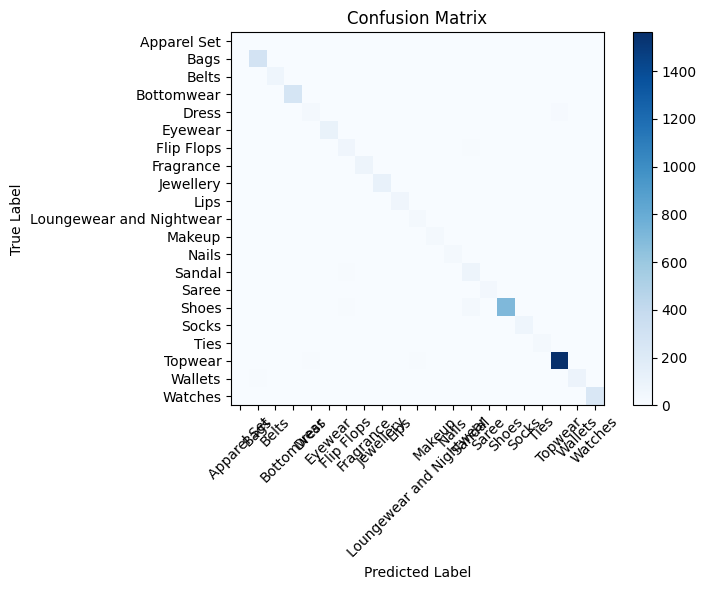

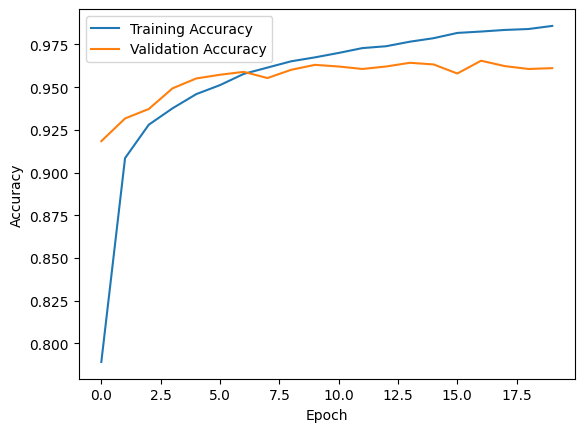

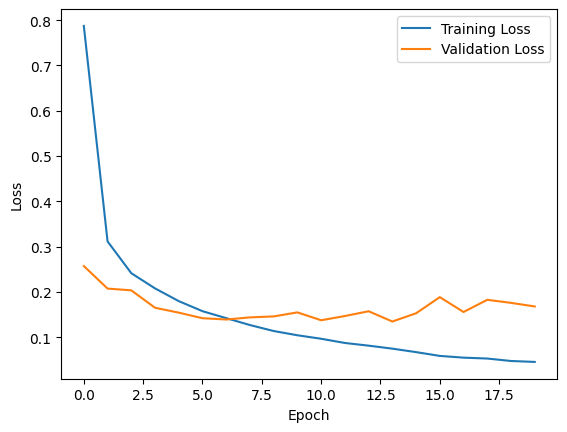

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, classification_report
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
train_image_features_path = '/content/drive/MyDrive/extracted_data/fashion_dataSet1/train_image_features.pkl'
val_image_features_path = '/content/drive/MyDrive/extracted_data/fashion_dataSet1/val_images_features.pkl'


# Load embeddings and corresponding image file names
with open(train_image_features_path, 'rb') as f:
    train_embeddings = pickle.load(f)
    print(len(train_embeddings))


with open(val_image_features_path, 'rb') as f:
    val_embeddings = pickle.load(f)

# Assuming your embeddings are in the right format for input
X_train = np.array(train_embeddings)
X_val=np.array(val_embeddings)
# Load the CSV file with subcategory labels

df_train = pd.read_csv('/content/drive/MyDrive/extracted_data/fashion_dataSet1/train.csv')

# Prepare your labels based on the image file names in the CSV
y_train = df_train['subCategory']  # Replace 'subcategory_column' with the column name from your CSV containing subcategory labels
print(len(y_train))
df_val=pd.read_csv('/content/drive/MyDrive/extracted_data/fashion_dataSet1/val.csv')
y_val = df_val['subCategory']

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
# ==========================================
# Predict labels on the validation set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)


# Compute precision, recall, F1-score, and support for each class
precision, recall, f1_score, support = precision_recall_fscore_support(y_val, y_val_pred_classes, average=None)

# Create a classification report
class_report = classification_report(y_val, y_val_pred_classes)
print("Classification Report:")
print(class_report)


# =======================================================
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred_classes)
print(f"Accuracy: {accuracy}")

# Calculate precision, recall, and F1-score
precision = precision_score(y_val, y_val_pred_classes, average='weighted')
recall = recall_score(y_val, y_val_pred_classes, average='weighted')
f1 = f1_score(y_val, y_val_pred_classes, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# ===========================================
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Predict labels on the validation set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Create a 5x5 confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)  # Adjust num_classes according to your data
plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
plt.yticks(tick_marks, label_encoder.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# print("Confusion Matrix:")
# print(conf_matrix)

# =======================================================

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Recommendation Algorithm

1/1 [==============================] - 1s 1s/step


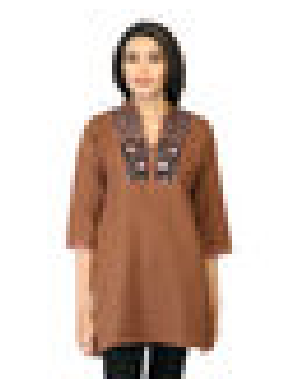

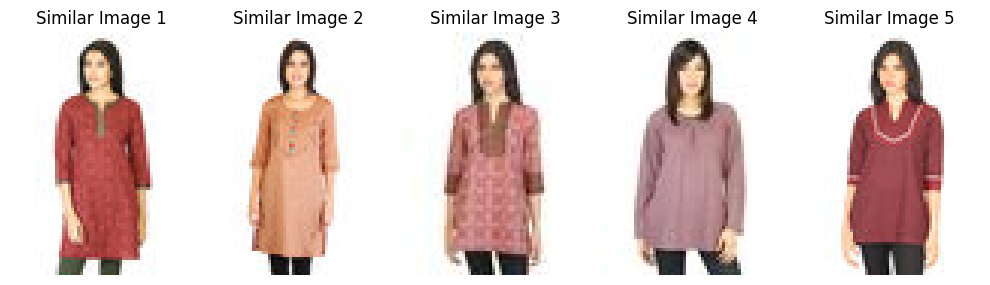

In [ ]:

import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.layers import GlobalMaxPooling2D
from keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.neighbors import NearestNeighbors
from keras.models import Sequential
import numpy as np
from numpy.linalg import norm
import pickle

model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model.trainable = False

model = Sequential([model, GlobalMaxPooling2D()])

def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expand_img = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expand_img)
    result_to_resnet = model.predict(preprocessed_img)
    flatten_result = result_to_resnet.flatten()
    result_normalized = flatten_result / norm(flatten_result)
    return result_normalized


# query_image='/content/drive/MyDrive/extracted_data/fashion_dataSet1/test_fol/1029.jpg'
query_image='/content/drive/MyDrive/extracted_data/fashion_dataSet1/test_fol/450.jpg'
query_embedding=extract_features(query_image,model)
all_embeddigns_path='/content/drive/MyDrive/extracted_data/fashion_dataSet1/train_image_features.pkl'
all_image_paths='/content/drive/MyDrive/extracted_data/fashion_dataSet1/train_fol'
with open(all_embeddigns_path, "rb") as f:
    embeddings = pickle.load(f)



knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(embeddings)

# Find nearest neighbors for the query image
distances, indices = knn.kneighbors(query_embedding.reshape(1, -1))

# Load the CSV file with image paths
csv_file_path = '/content/drive/MyDrive/extracted_data/fashion_dataSet1/train.csv'  # Replace with your CSV file path
df = pd.read_csv(csv_file_path)

# Get the filenames from the indices
similar_image_filenames = [df.iloc[i]['image'] for i in indices[0]]

# Find the corresponding image paths from the CSV file
similar_image_paths = []
for filename in similar_image_filenames:
    image_row = df[df['image'] == filename]  # Assuming 'image' is the column name with filenames
    if not image_row.empty:
        image_path = image_row.iloc[0]['image']  # Adjust 'image' column name accordingly
        similar_image_paths.append(image_path)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
read_img=mpimg.imread(query_image)
plt.axis('off')

plt.imshow(read_img)
plt.figure(figsize=(10, 6))
for i, path in enumerate(similar_image_paths):
    plt.subplot(1, len(similar_image_paths), i + 1)
    img = mpimg.imread(os.path.join(all_image_paths, path))
    plt.imshow(img)
    plt.title(f"Similar Image {i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
